In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import os
import cortex
import numpy as np
import matplotlib.pyplot as pl
import sys
import yaml
from scipy.stats import sem, ks_2samp
from statsmodels.stats import weightstats
from sklearn.linear_model import LinearRegression

sys.path.append("..")

from prfpy.stimulus import PRFStimulus2D
from prfpy.grid import Iso2DGaussianGridder, CSS_Iso2DGaussianGridder, Norm_Iso2DGaussianGridder, DoG_Iso2DGaussianGridder
from prfpy.fit import Iso2DGaussianFitter, Norm_Iso2DGaussianFitter, DoG_Iso2DGaussianFitter, CSS_Iso2DGaussianFitter

from utils.utils import create_full_stim, roi_mask, fwhmax, fwatmin

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#import subject from freesurfer to pycortex database
#this only works if line 335 in cortex.freesurfer.py is commented out (the extra fp.readline())
#cortex.freesurfer.import_subj('sub-006', freesurfer_subject_dir='/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/freesurfer', 
#                              whitematter_surf='smoothwm')



#create flatmaps with tksurfer, then run the folowing
#to be tested, to import flatmaps made with the procedure
#cortex.freesurfer.import_flat(subject, patch, hemis=['lh', 'rh'], sname=None,
#                flat_type='freesurfer',
#                freesurfer_subject_dir=None, clean=False)

In [2]:
#load data sub 006 posi prf constraints num first
subj='sub-006'

gauss = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-006_iterparams-gauss_space-fsnative20191109165849.npy")
css_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-006_iterparams-css_space-fsnative20191109165849.npy")
dog_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-006_iterparams-dog_space-fsnative20191109165849.npy")
norm_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-006_iterparams-norm_space-fsnative20191109165849.npy")

norm_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-006_gridparams-norm_space-fsnative20191109165849.npy")
gauss_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-006_gridparams-gauss_space-fsnative20191109165849.npy")

#timecourse and mask are same as before
nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_nonlow-var-mask_space-fsnative.npy")
timecourse = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_timecourse_space-fsnative.npy')

#load data fsnative sub 006 posi prf constraints num first iterated
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-006_iterparams-gauss_space-fsnative20191110131514.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-006_iterparams-css_space-fsnative20191110131514.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-006_iterparams-dog_space-fsnative20191110131514.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-006_iterparams-norm_space-fsnative20191110131514.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = gauss_it[(gauss[:,-1]<gauss_it[:,-1])]
css_res[(css_res[:,-1]<css_res_it[:,-1])] = css_res_it[(css_res[:,-1]<css_res_it[:,-1])]
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])]
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])]

#load data fsnative sub 006 posi prf constraints tc first
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-006_iterparams-gauss_space-fsnative20191109100256.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-006_iterparams-css_space-fsnative20191109100256.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-006_iterparams-dog_space-fsnative20191109100256.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-006_iterparams-norm_space-fsnative20191109100256.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = gauss_it[(gauss[:,-1]<gauss_it[:,-1])]
css_res[(css_res[:,-1]<css_res_it[:,-1])] = css_res_it[(css_res[:,-1]<css_res_it[:,-1])]
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])]
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])]

#load data fsnative sub 006 posi prf constraints tc first iterated
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-006_iterparams-gauss_space-fsnative20191109141507.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-006_iterparams-css_space-fsnative20191109141507.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-006_iterparams-dog_space-fsnative20191109141507.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-006_iterparams-norm_space-fsnative20191109141507.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = gauss_it[(gauss[:,-1]<gauss_it[:,-1])]
css_res[(css_res[:,-1]<css_res_it[:,-1])] = css_res_it[(css_res[:,-1]<css_res_it[:,-1])]
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])]
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])]

In [66]:
#load data fsnative sub 007 posi prf constraints tc first
subj='sub-007'

gauss = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_iterparams-gauss_space-fsnative.npy")
css_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_iterparams-css_space-fsnative.npy")
dog_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_iterparams-dog_space-fsnative.npy")
norm_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_iterparams-norm_space-fsnative.npy")

gauss_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_gridparams-gauss_space-fsnative.npy")
norm_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_gridparams-norm_space-fsnative.npy")

nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_nonlow-var-mask_space-fsnative.npy")
timecourse = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_timecourse_space-fsnative.npy')

#load data fsnative sub 007 posi prf constraints tc first iterated with num
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_iterparams-gauss_space-fsnative20191112083058.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_iterparams-css_space-fsnative20191112083058.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_iterparams-dog_space-fsnative20191112083058.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_tc_first/sub-007_iterparams-norm_space-fsnative20191112083058.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = gauss_it[(gauss[:,-1]<gauss_it[:,-1])]
css_res[(css_res[:,-1]<css_res_it[:,-1])] = css_res_it[(css_res[:,-1]<css_res_it[:,-1])]
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])]
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])]

#load data fsnative sub 007 posi prf constraints num first
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-007_iterparams-gauss_space-fsnative20191112180440.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-007_iterparams-css_space-fsnative20191112180440.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-007_iterparams-dog_space-fsnative20191112180440.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-007_iterparams-norm_space-fsnative20191112180440.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = gauss_it[(gauss[:,-1]<gauss_it[:,-1])]
css_res[(css_res[:,-1]<css_res_it[:,-1])] = css_res_it[(css_res[:,-1]<css_res_it[:,-1])]
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])]
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])]

#load data fsnative sub 006 posi prf constraints num first iterated
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-007_iterparams-gauss_space-fsnative20191113094719.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-007_iterparams-css_space-fsnative20191113094719.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-007_iterparams-dog_space-fsnative20191113094719.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/pos_prf_constraints_num_first/sub-007_iterparams-norm_space-fsnative20191113094719.npy")

gauss[(gauss[:,-1]<gauss_it[:,-1])] = gauss_it[(gauss[:,-1]<gauss_it[:,-1])]
css_res[(css_res[:,-1]<css_res_it[:,-1])] = css_res_it[(css_res[:,-1]<css_res_it[:,-1])]
dog_res[(dog_res[:,-1]<dog_res_it[:,-1])] = dog_res_it[(dog_res[:,-1]<dog_res_it[:,-1])]
norm_res[(norm_res[:,-1]<norm_res_it[:,-1])] = norm_res_it[(norm_res[:,-1]<norm_res_it[:,-1])]

In [3]:
%%capture
#transferring Wang 2015 atlas labels from fsaverage to subject
idx_rois = {}
values = {}
wang_rois = ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "VO1", "VO2", "PHC1", "PHC2",
    "TO2", "TO1", "LO2", "LO1", "V3B", "V3A", "IPS0", "IPS1", "IPS2", "IPS3", "IPS4", 
    "IPS5", "SPL1", "FEF"]
for roi in wang_rois:
    idx_rois[roi], values_roi = cortex.freesurfer.get_label(subject=subj,
                                              label='wang2015atlas.'+roi,
                                              fs_dir='/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/freesurfer',
                                              src_subject=subj)
    
    #idx_rois[roi] = np.append(idx_rois[roi], idx_rois_roi+polar.shape[0])

idx_rois['visual_system'] = np.concatenate(tuple([idx_rois[roi] for roi in idx_rois]), axis=0)
idx_rois['V1']=np.concatenate((idx_rois['V1v'],idx_rois['V1d']))
idx_rois['V2']=np.concatenate((idx_rois['V2v'],idx_rois['V2d']))
idx_rois['V3']=np.concatenate((idx_rois['V3v'],idx_rois['V3d']))



In [885]:
ds_rois = {}
data = np.zeros(nonzerovar_mask.shape[0])
for i, roi in enumerate(wang_rois):
    
    roi_data = np.zeros(nonzerovar_mask.shape[0])
    roi_data[idx_rois[roi]] = 1
    data[idx_rois[roi]] = i+1
    ds_rois[roi] = cortex.Vertex2D(roi_data, roi_data.astype('bool'), subj, cmap='RdBu_r_alpha').raw
    
    #need flattened brain to do this
    #cortex.add_roi(ds_rois[roi], name=roi, open_inkscape=False, add_path=True)
    


ds_rois['Wang2015Atlas'] = cortex.Vertex2D(data, data.astype('bool'), subj, cmap='Retinotopy_HSV_alpha').raw
cortex.webgl.show(ds_rois,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True,
                 with_borders=True, 
                 with_colorbar=True)

<IPython.core.display.Javascript object>


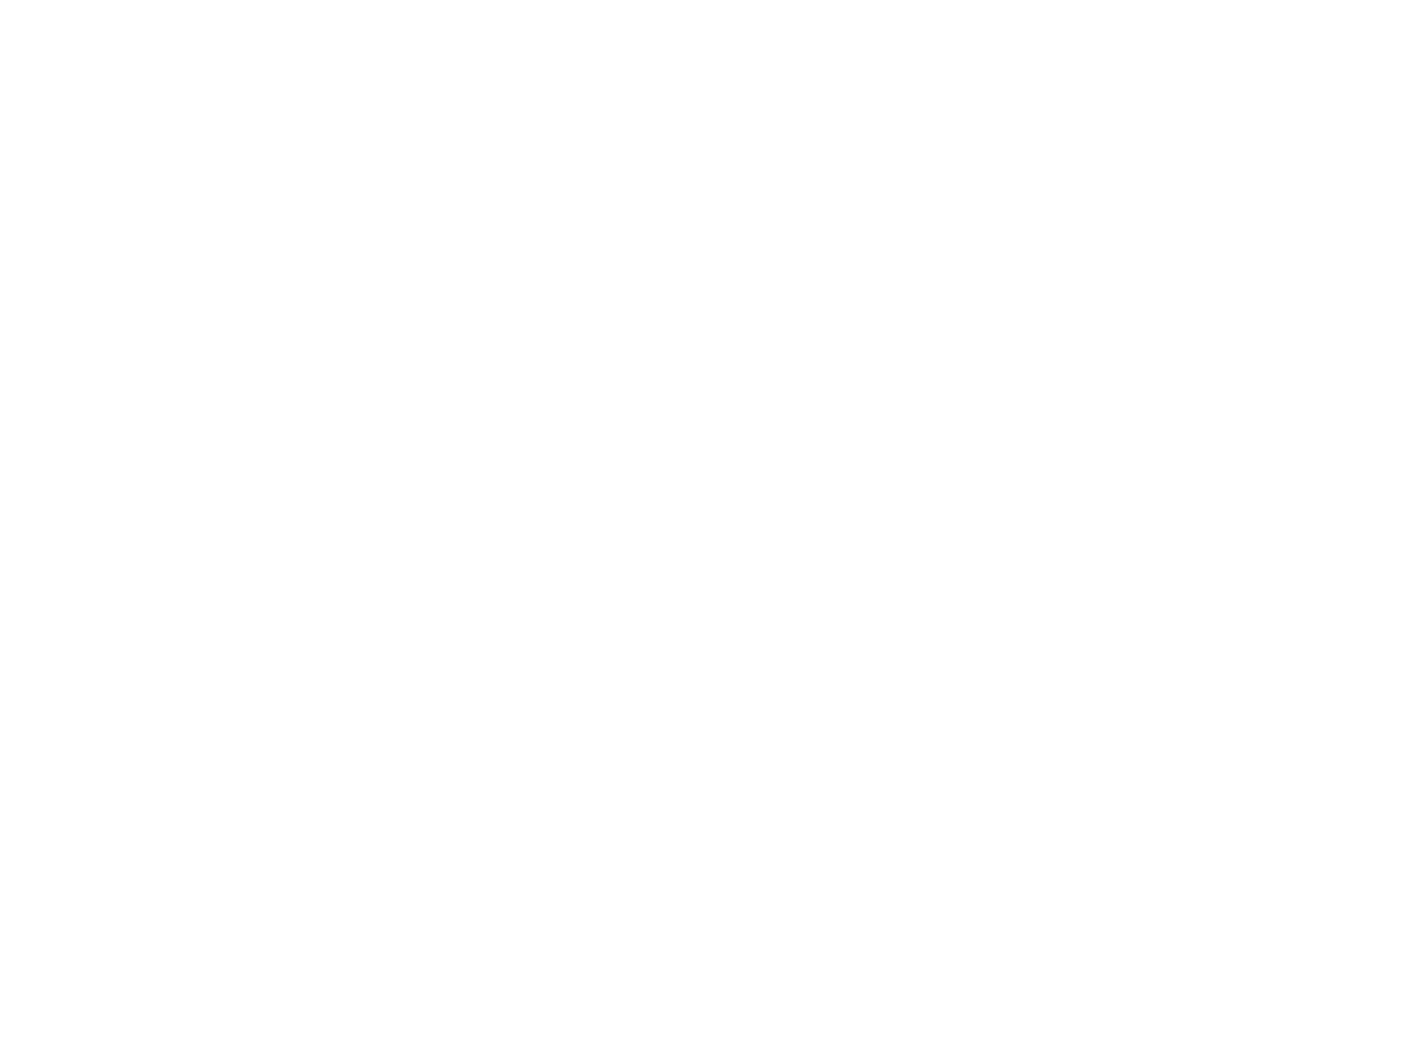

<IPython.core.display.Javascript object>


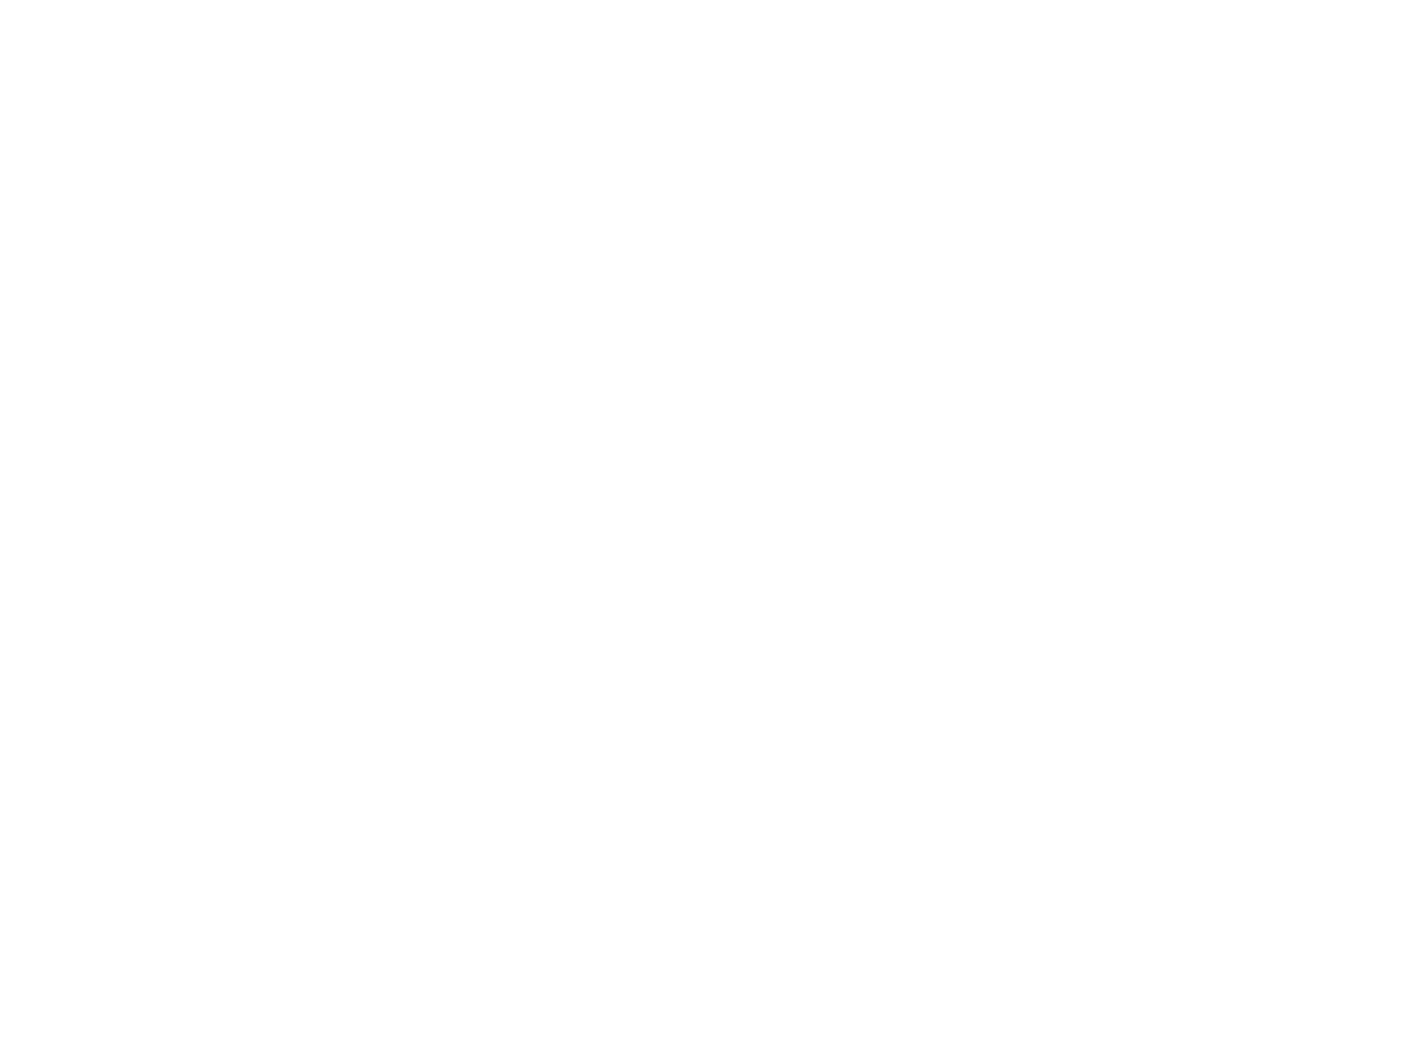

<IPython.core.display.Javascript object>


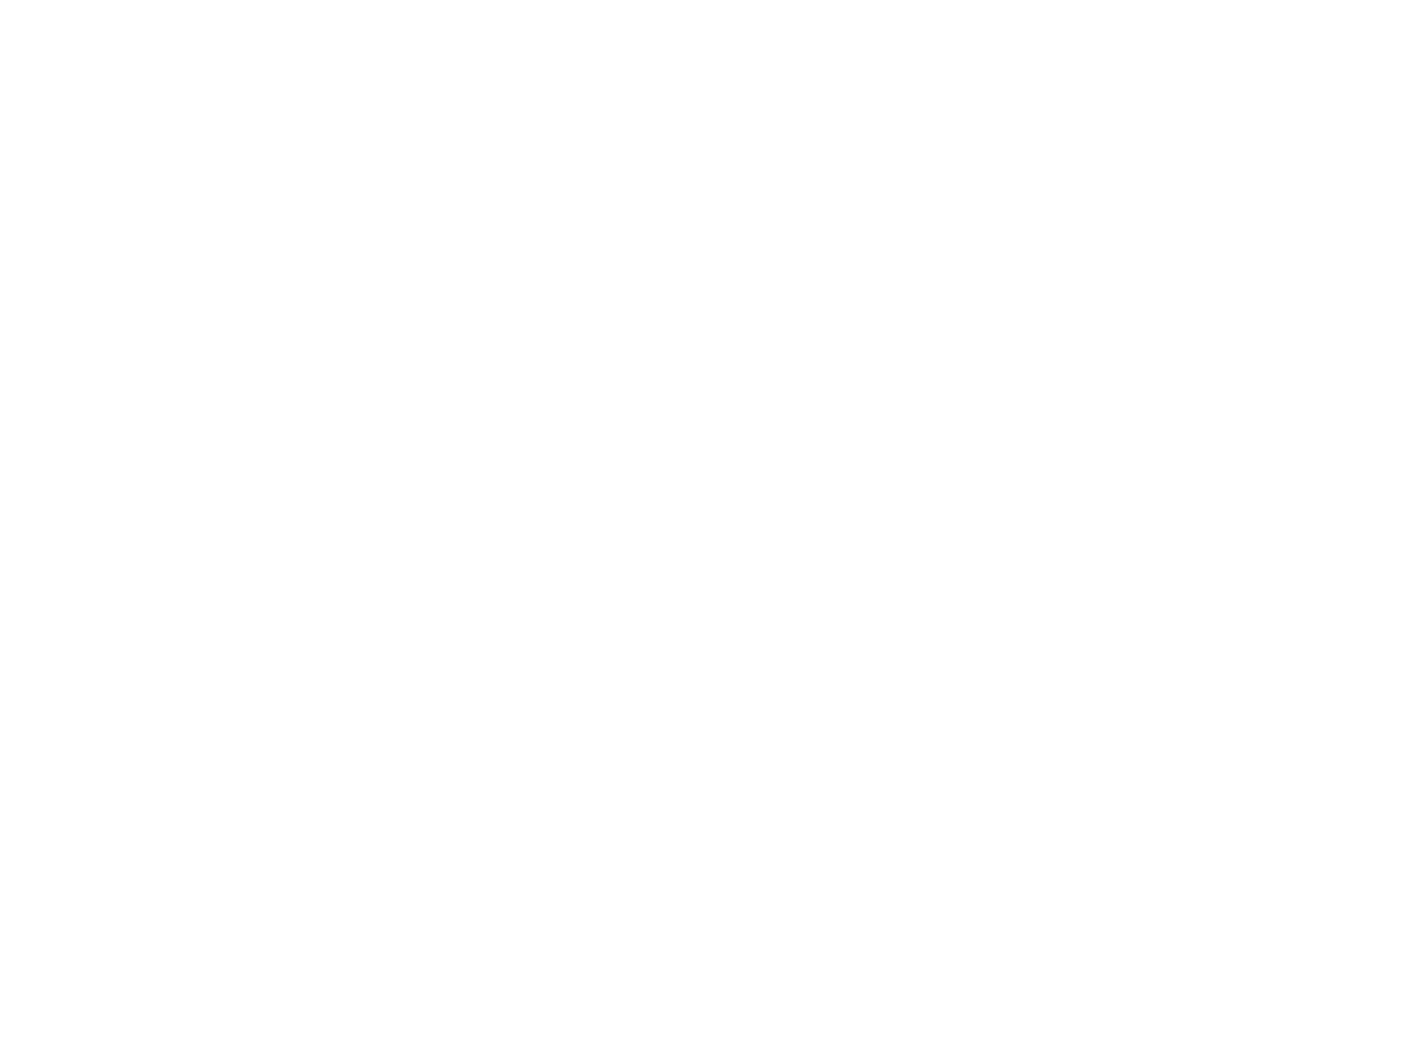

<IPython.core.display.Javascript object>


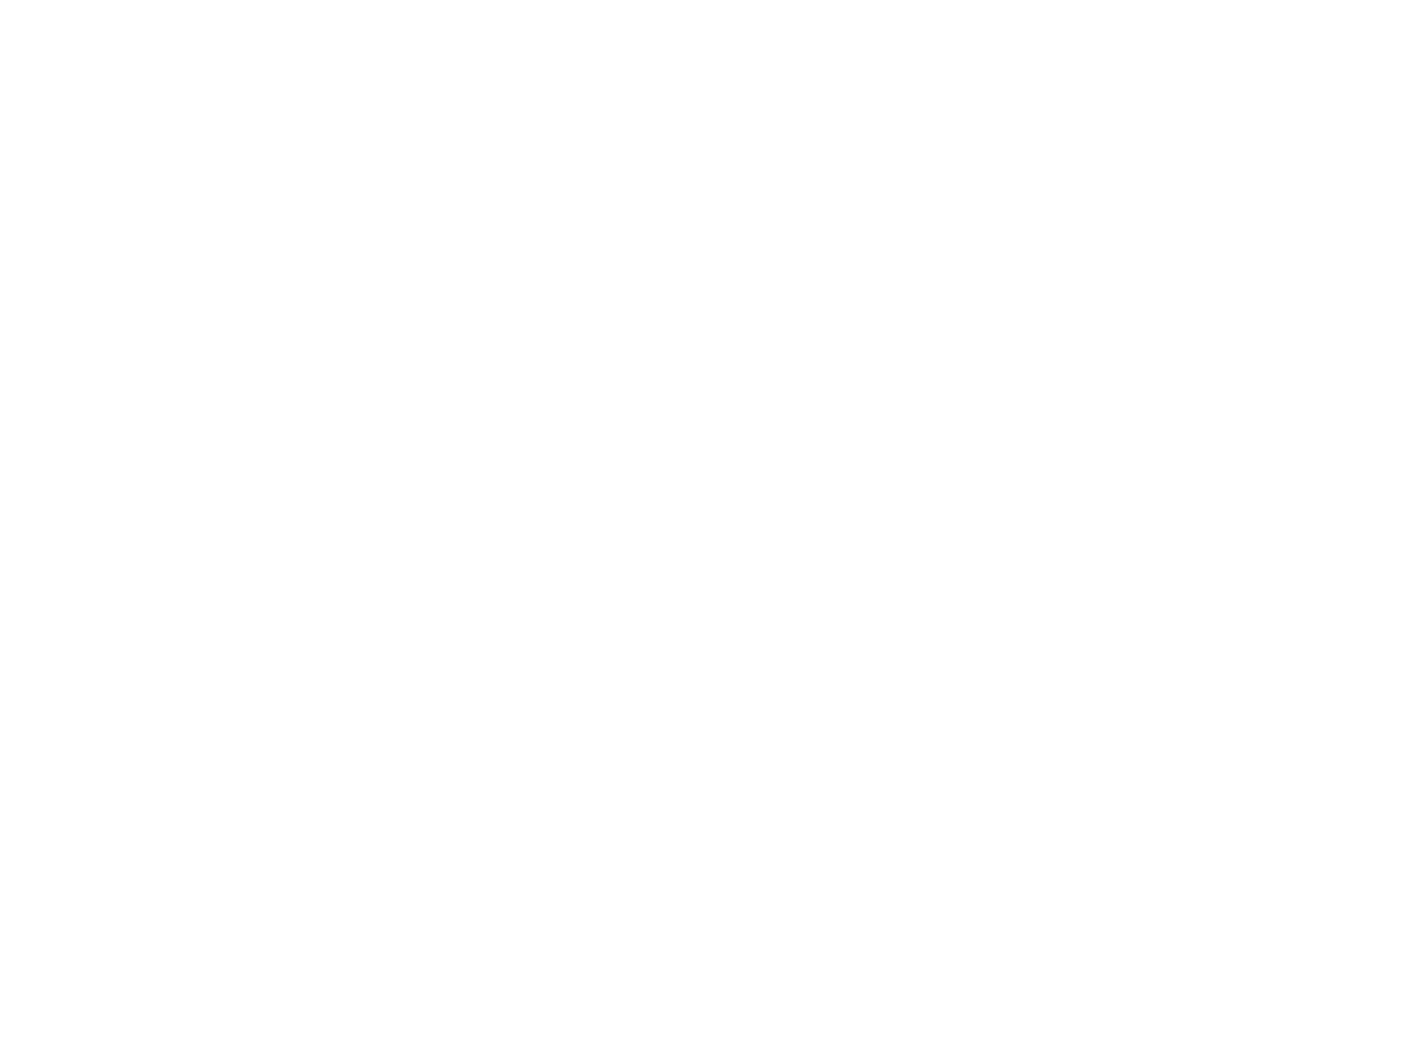

<IPython.core.display.Javascript object>


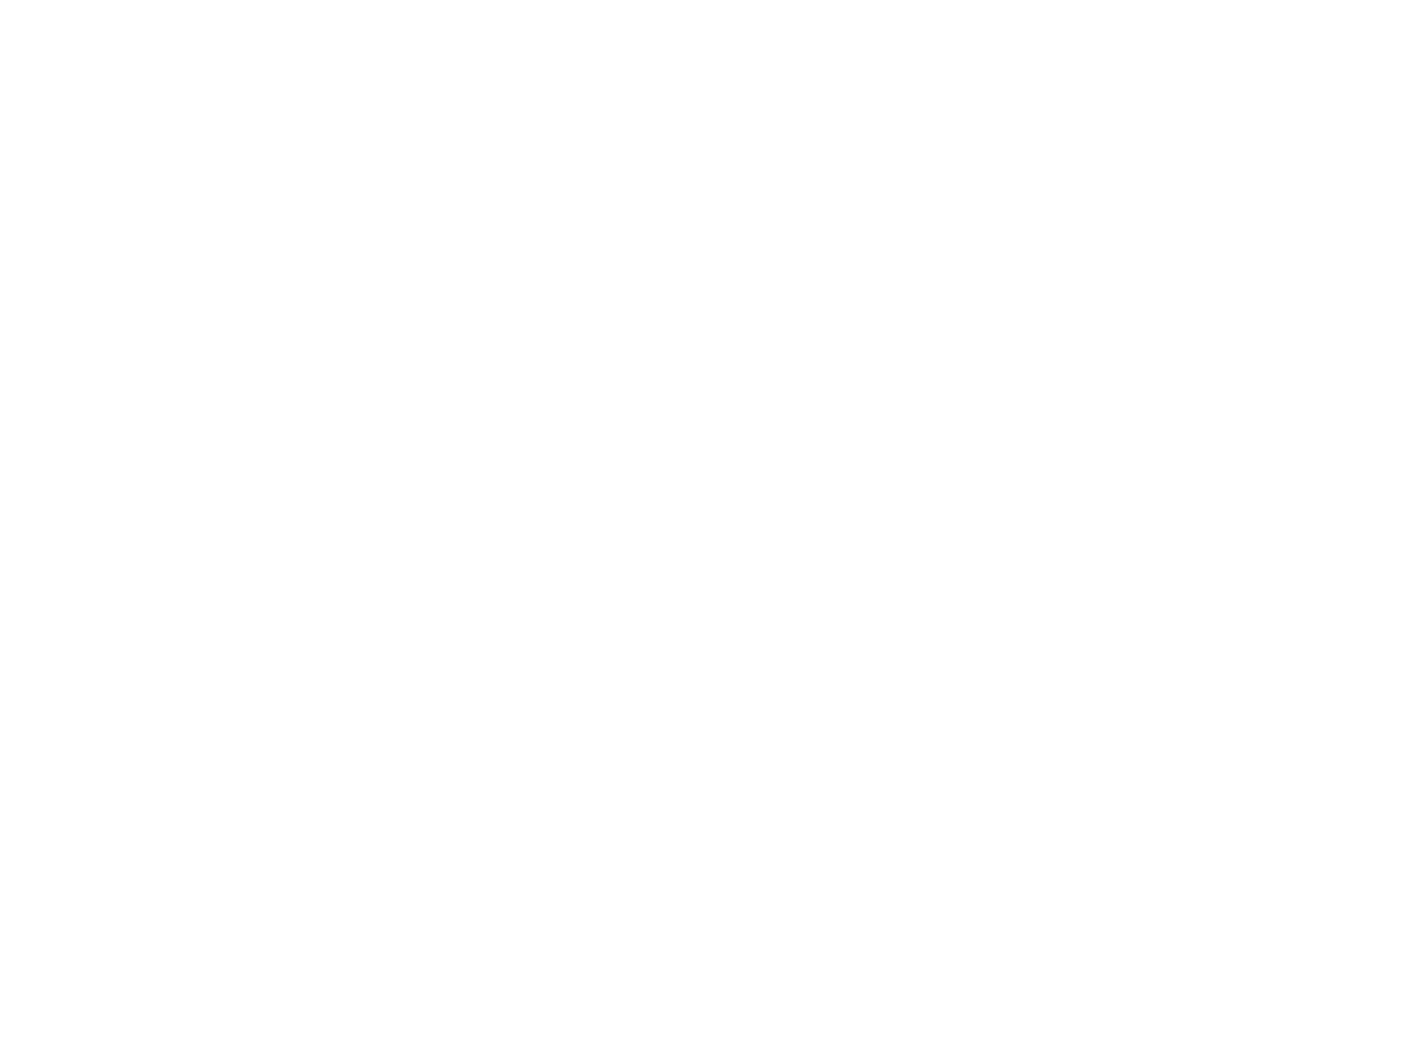

<IPython.core.display.Javascript object>


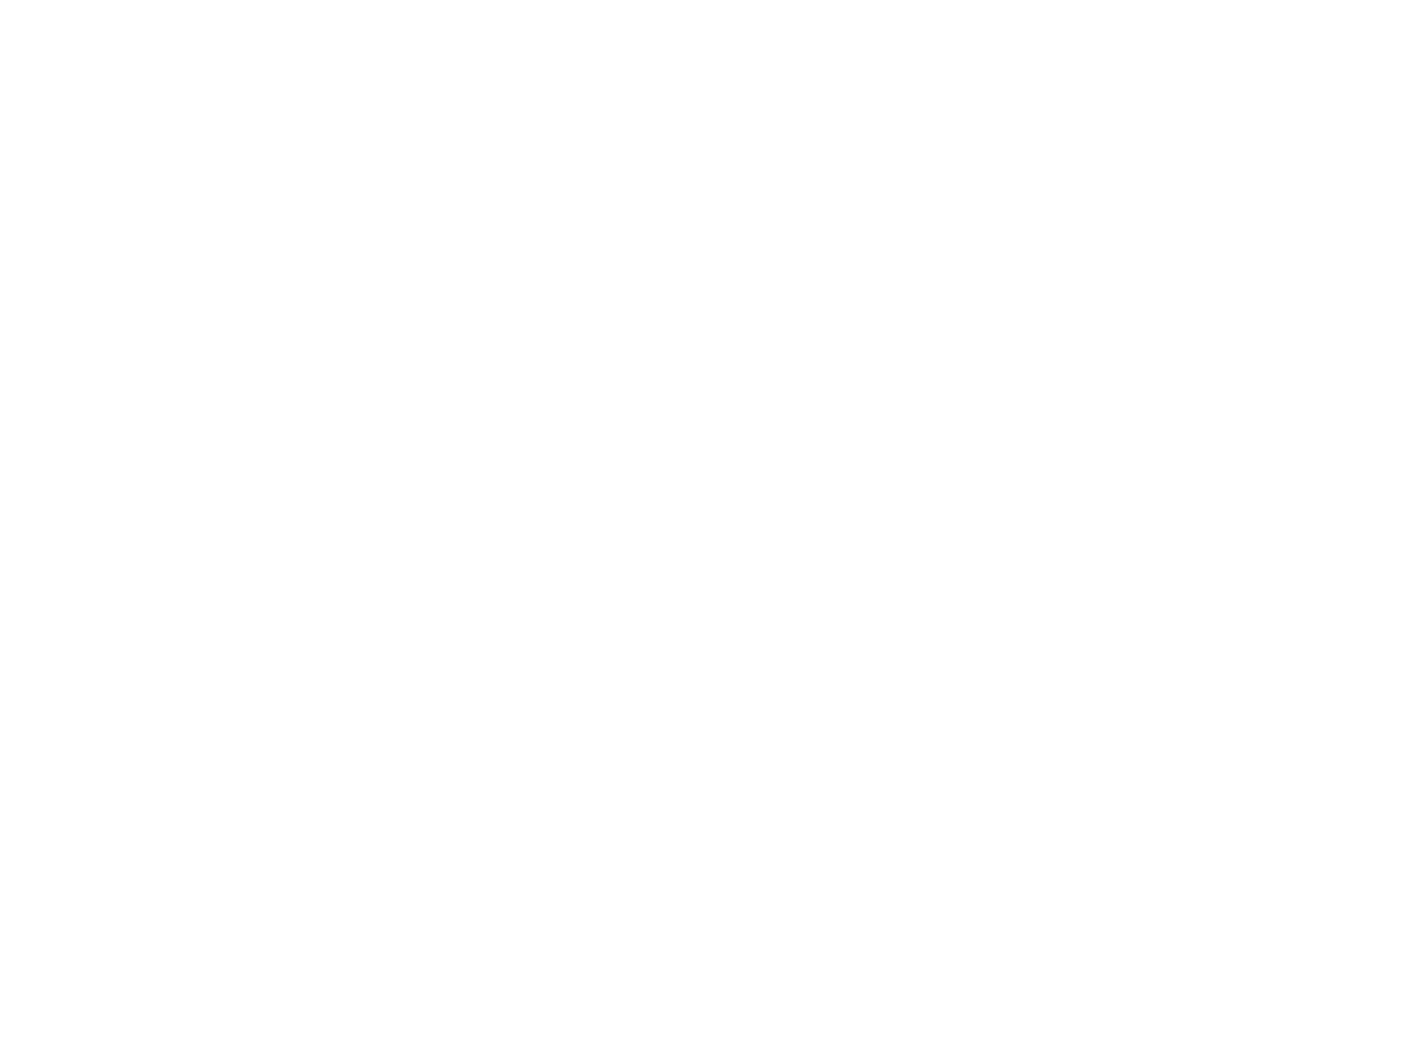

<IPython.core.display.Javascript object>


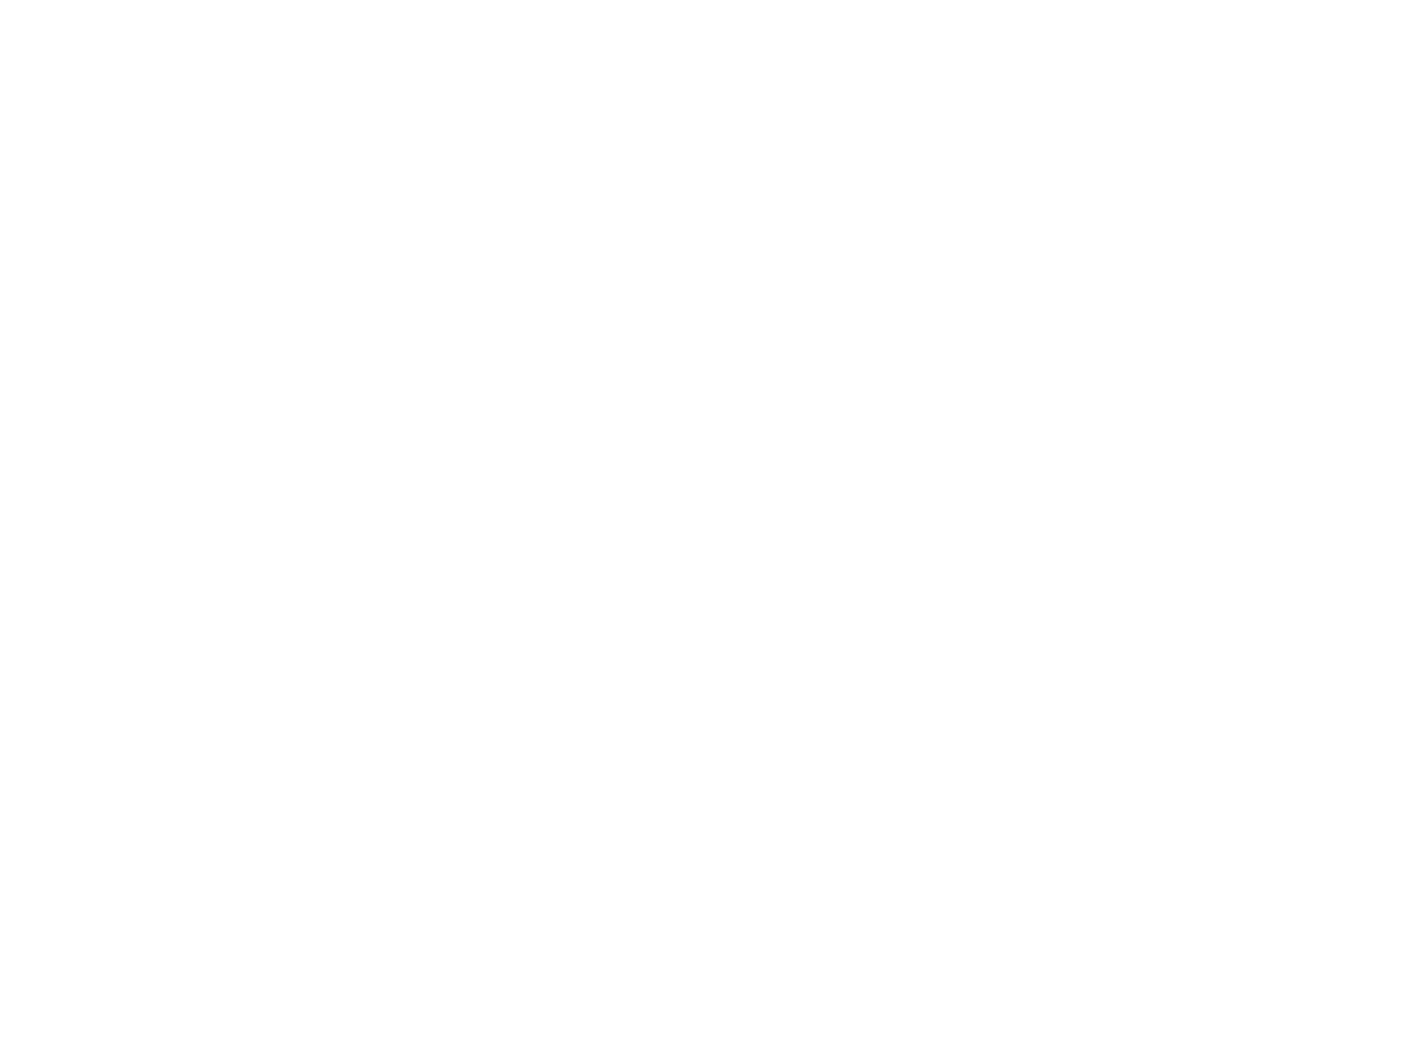

<IPython.core.display.Javascript object>


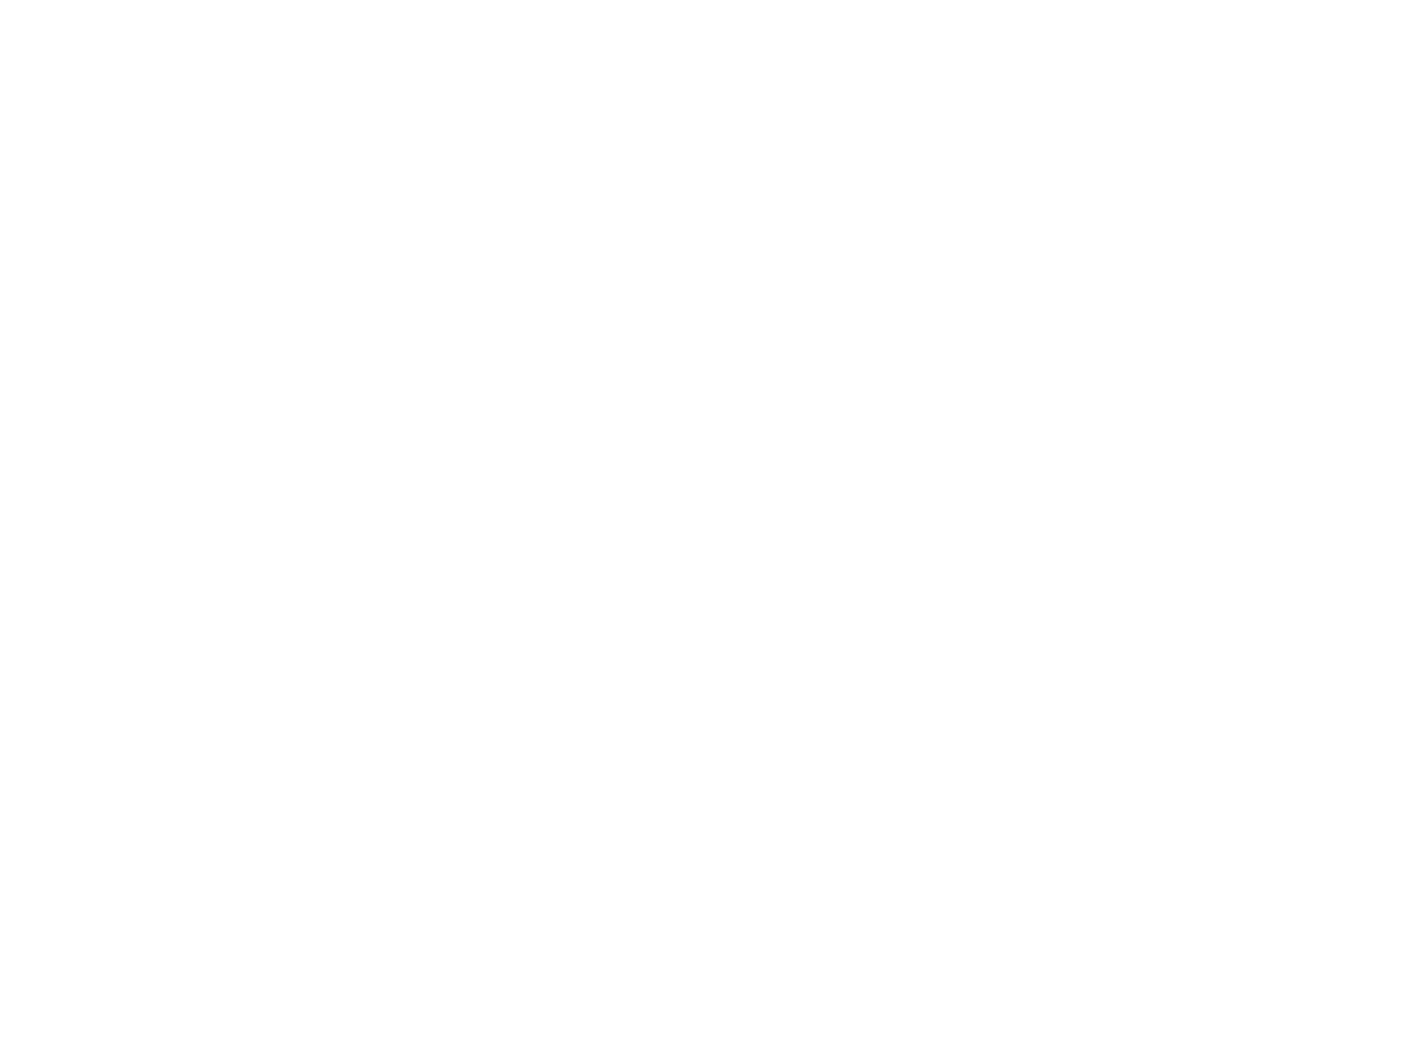

<IPython.core.display.Javascript object>


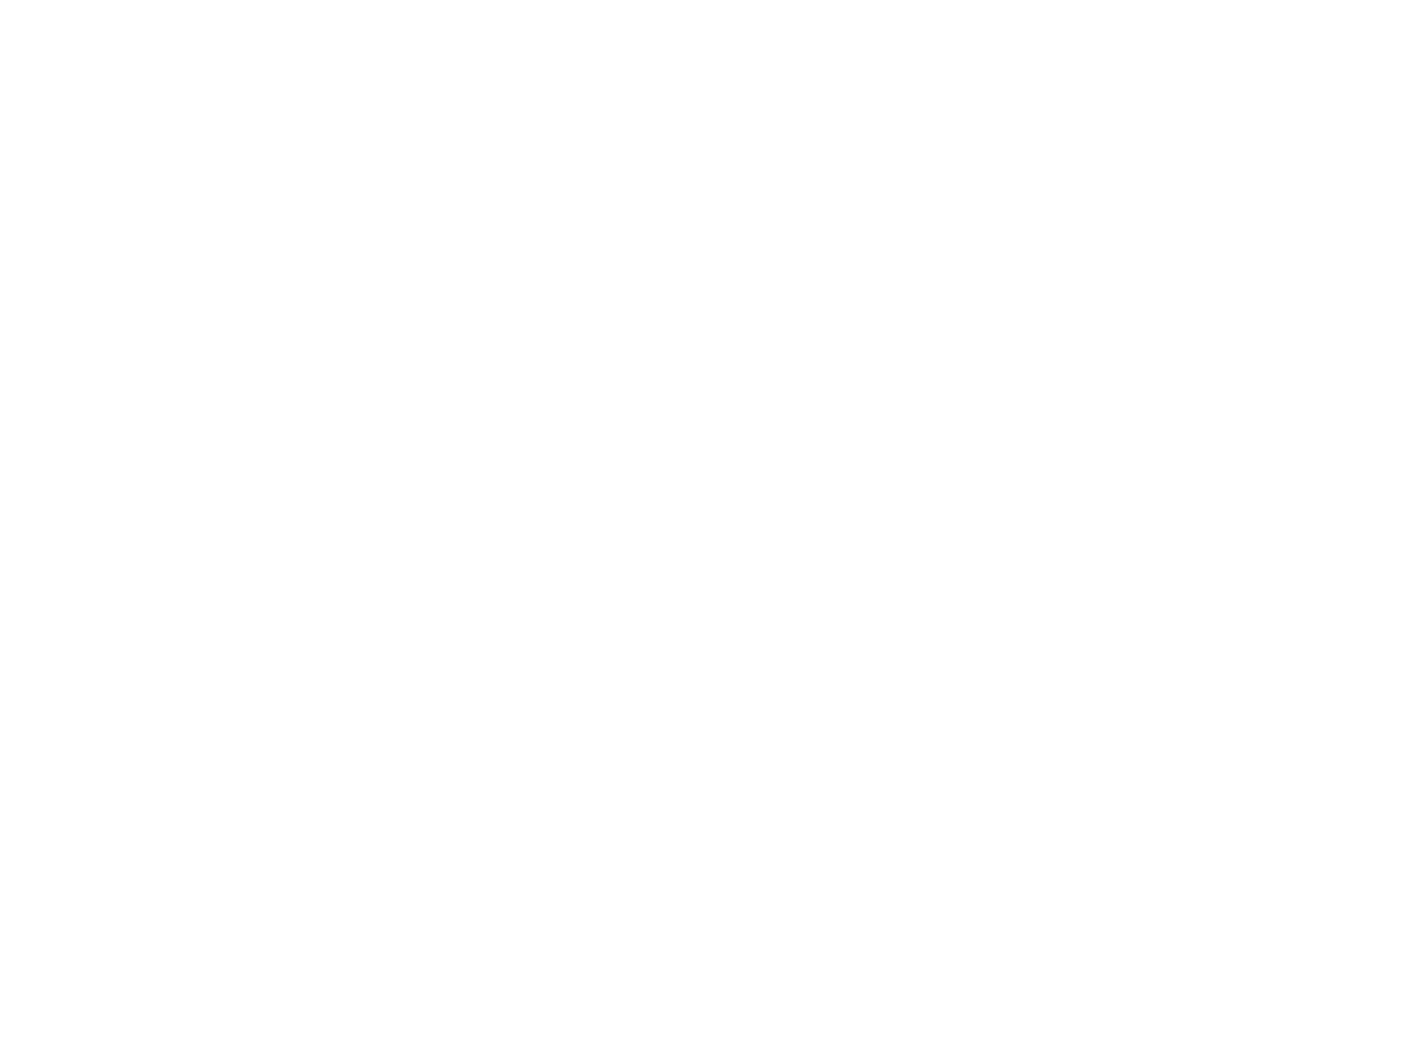

<IPython.core.display.Javascript object>


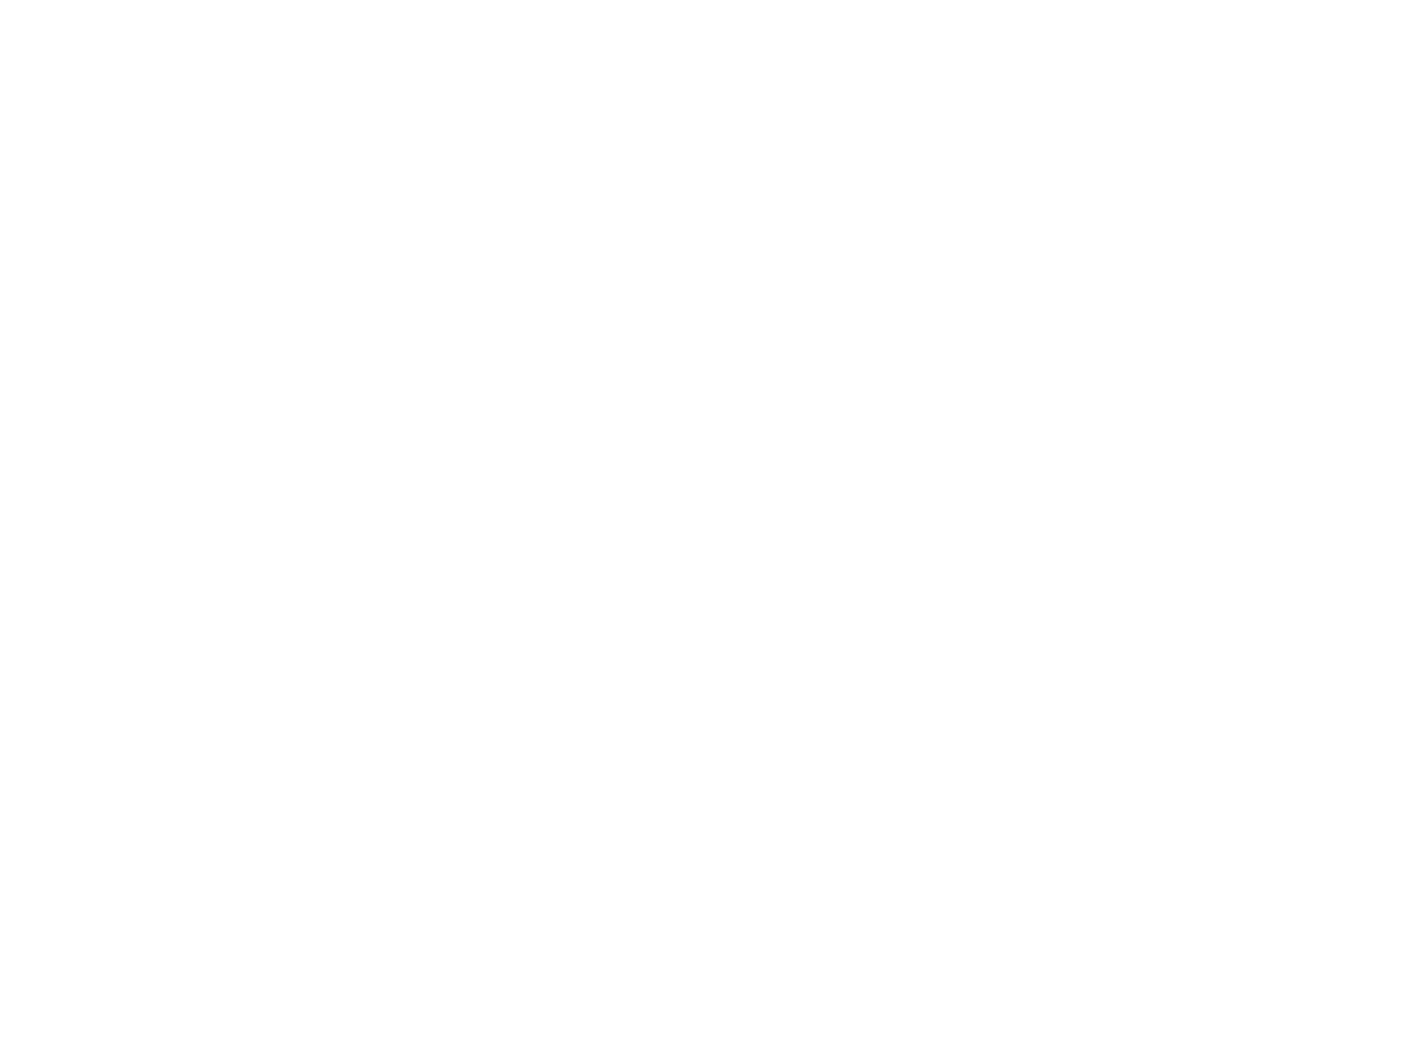

<IPython.core.display.Javascript object>


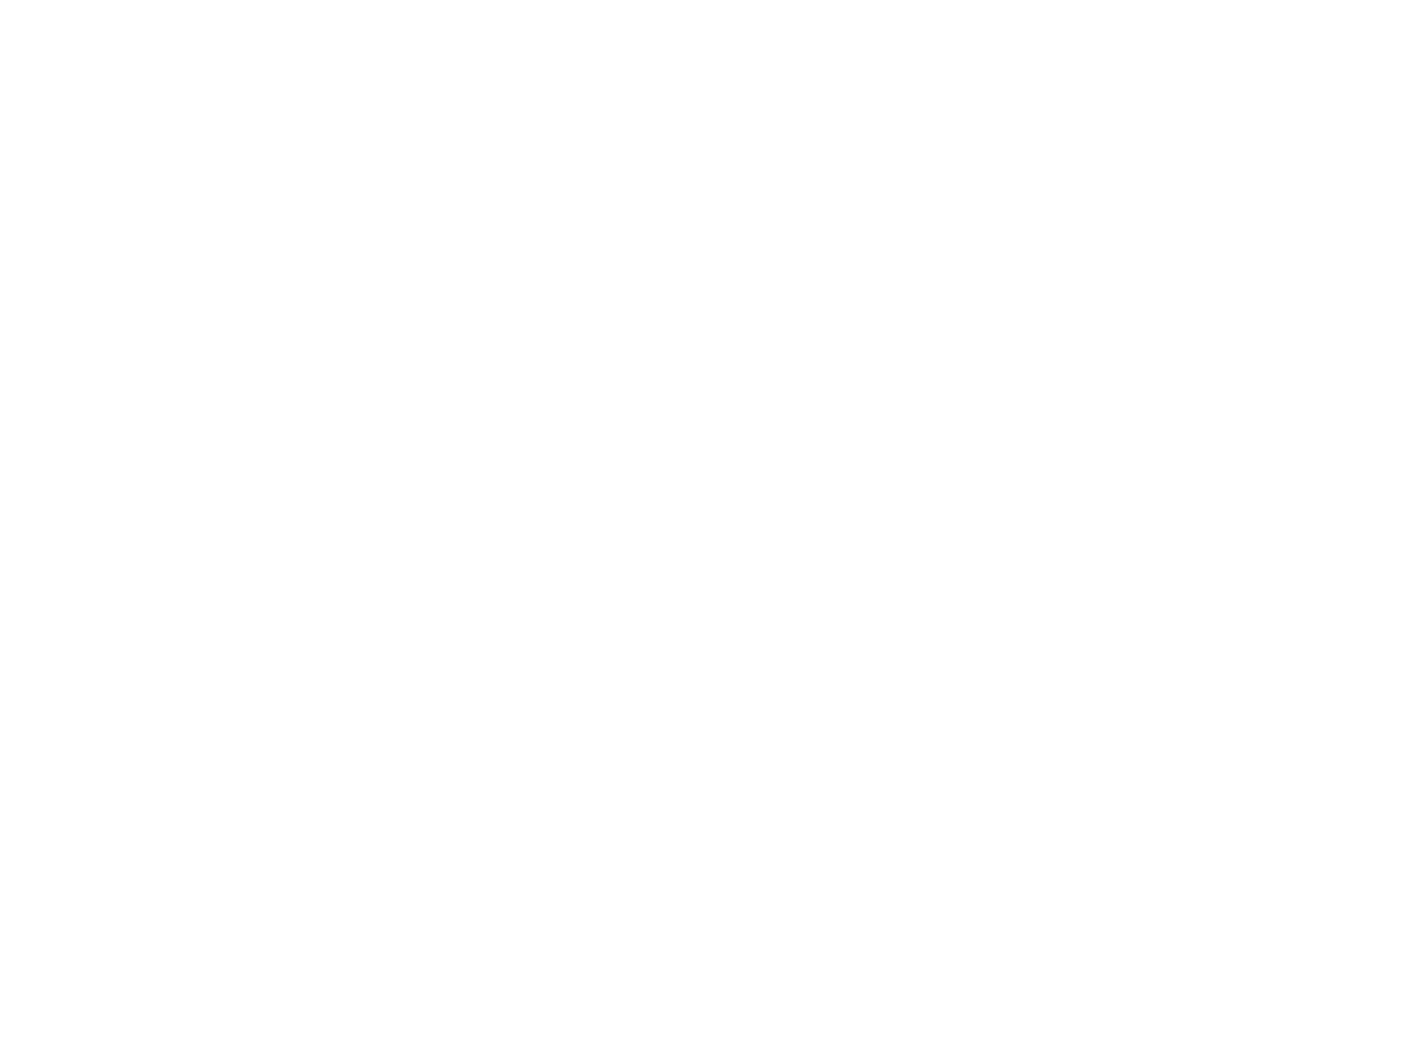

<IPython.core.display.Javascript object>


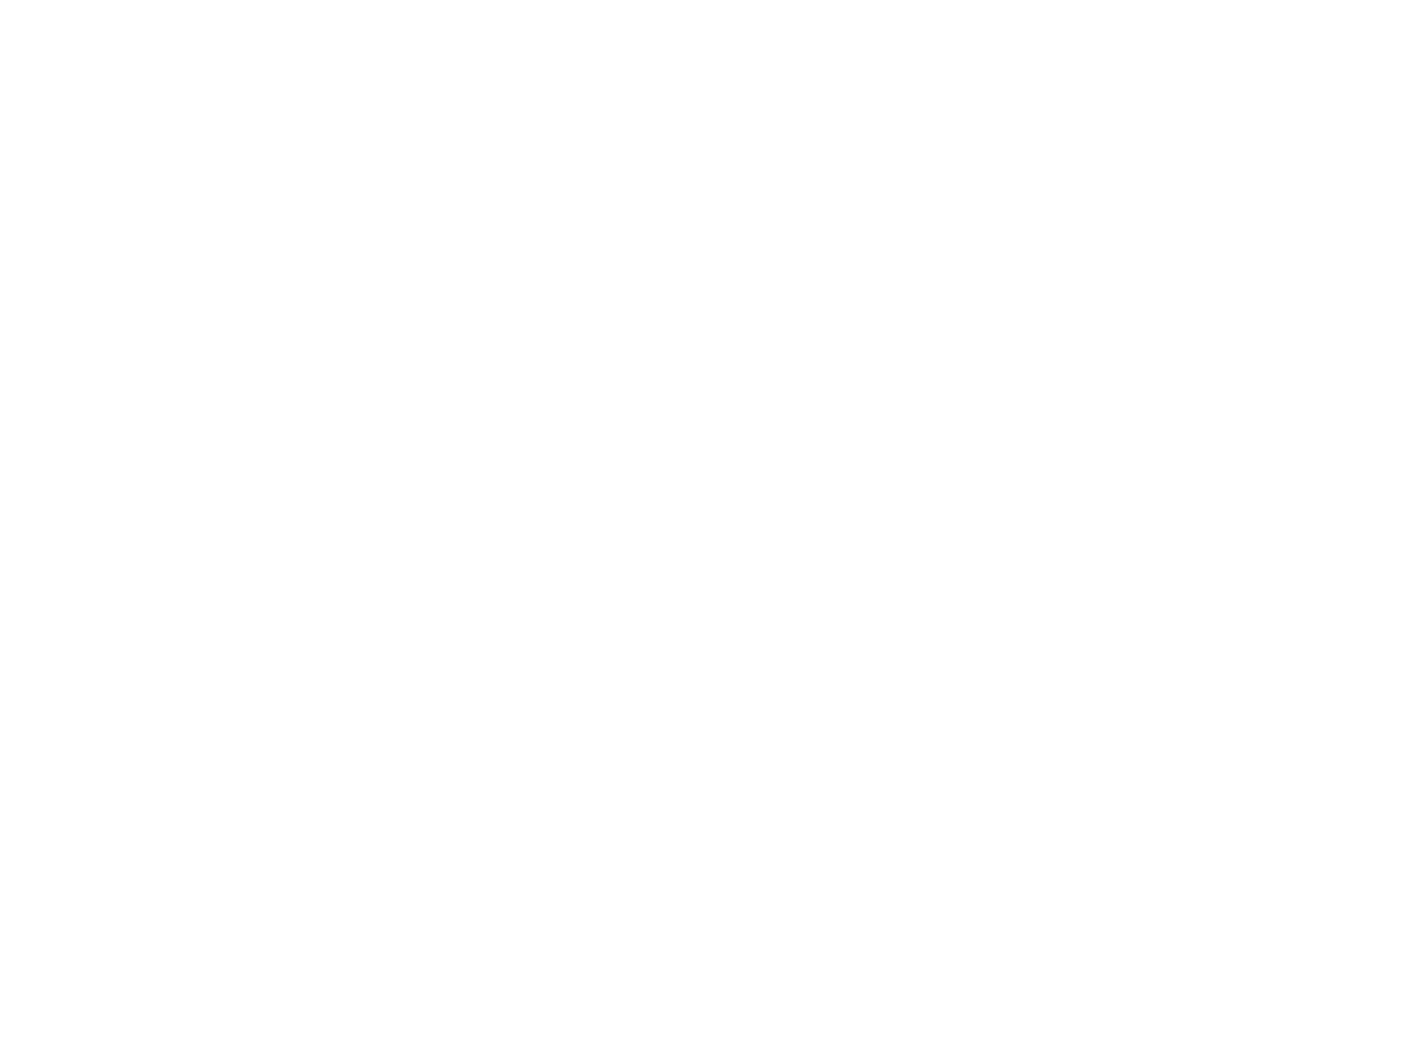

<IPython.core.display.Javascript object>


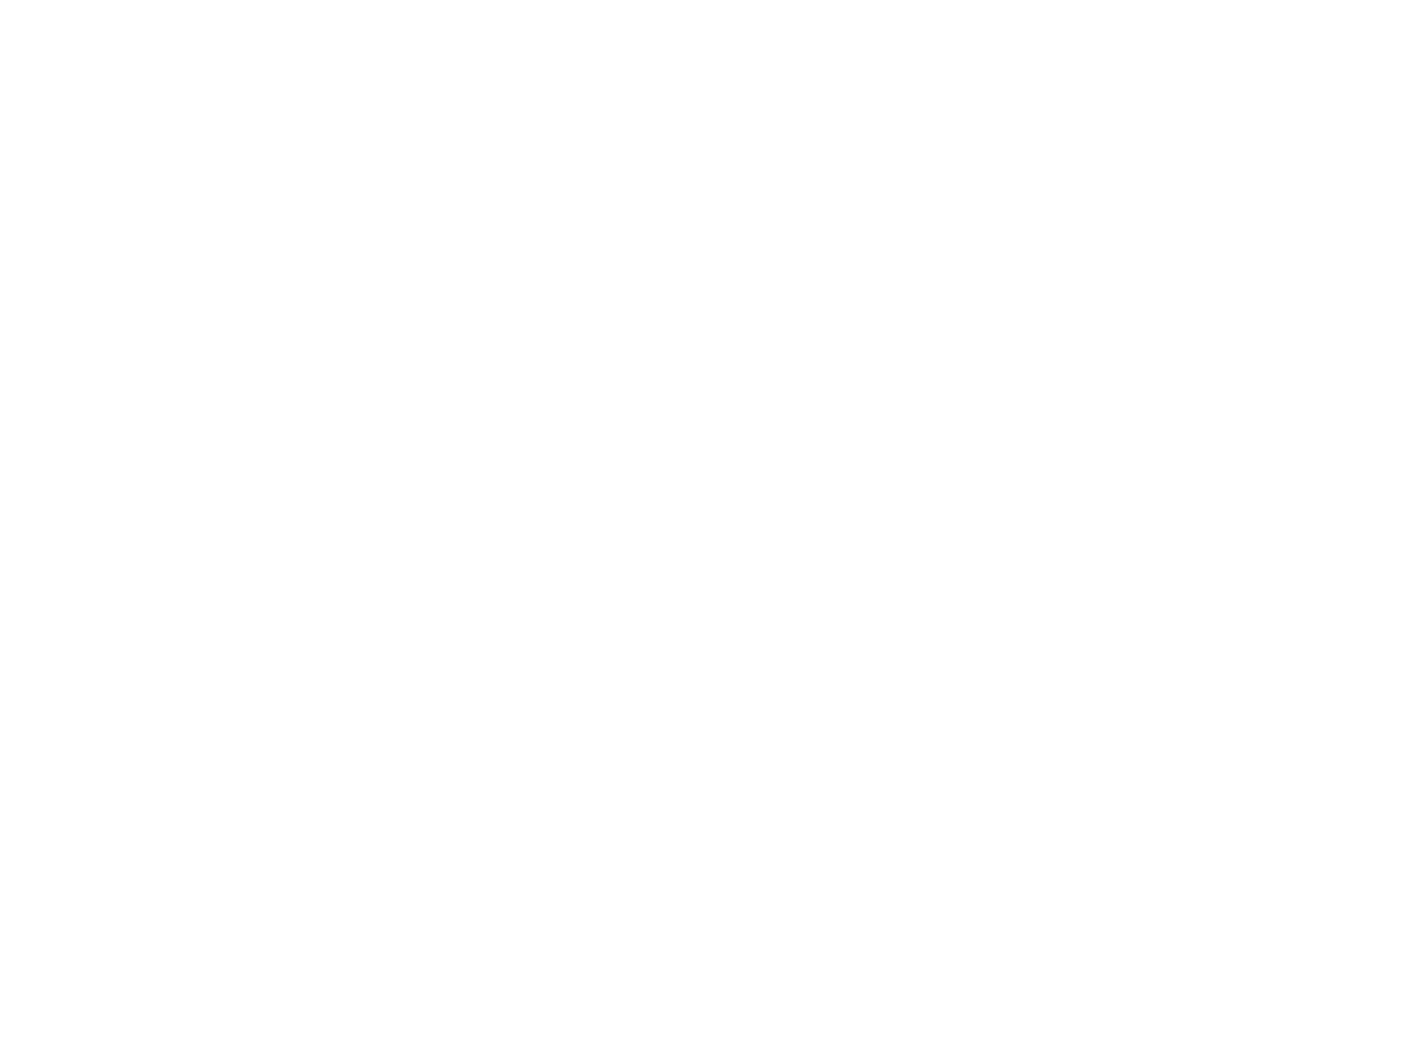

<IPython.core.display.Javascript object>


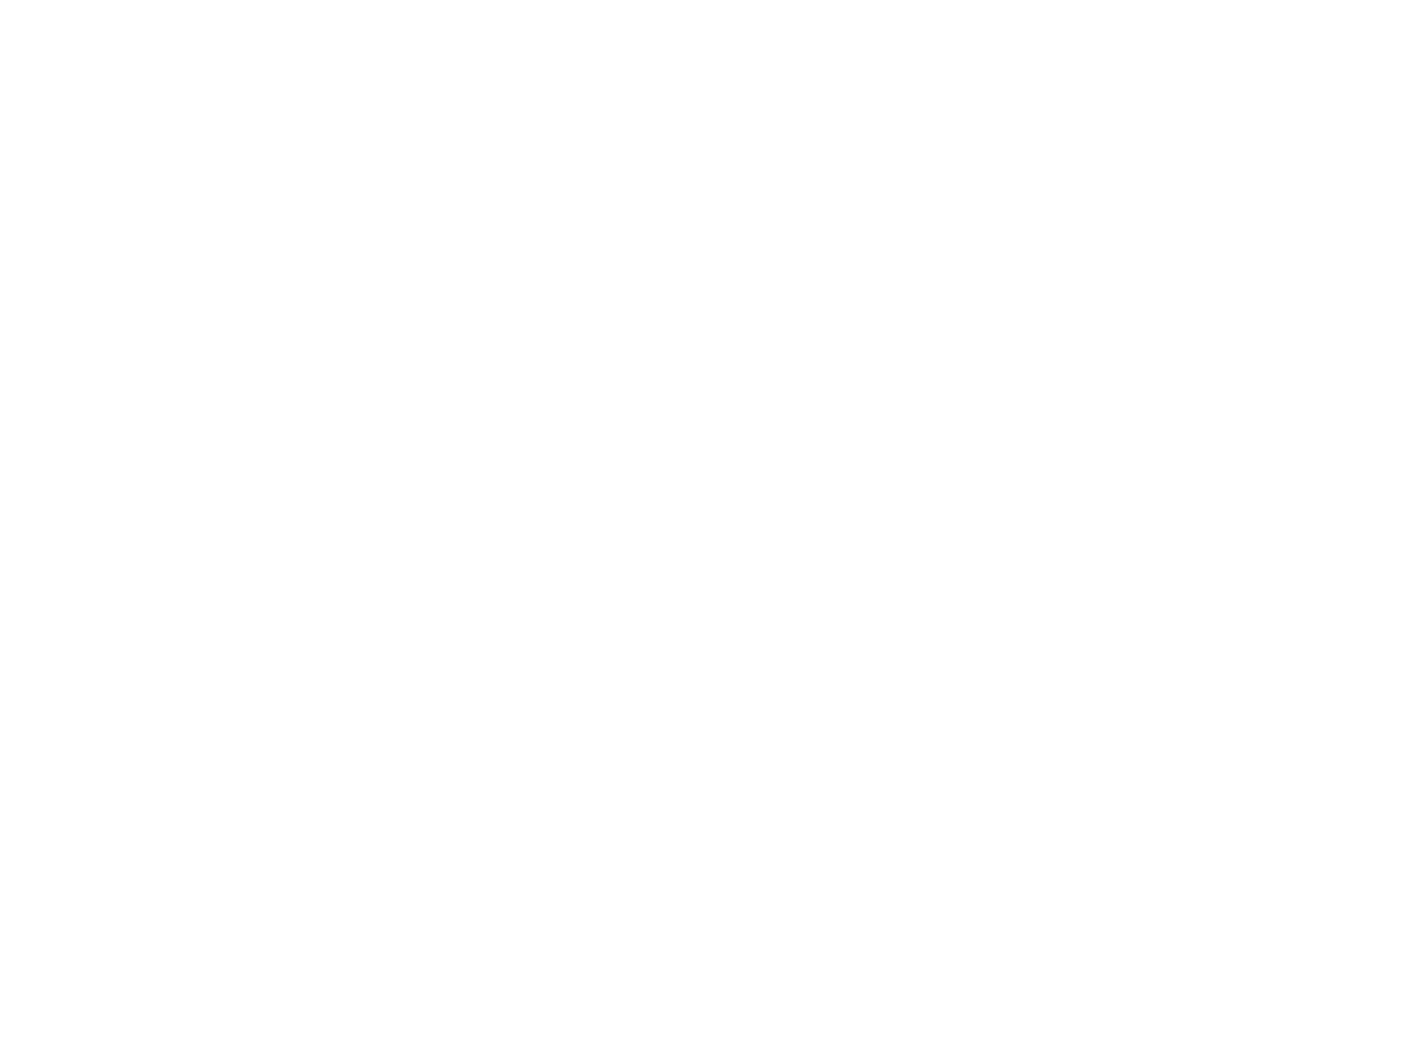

<IPython.core.display.Javascript object>


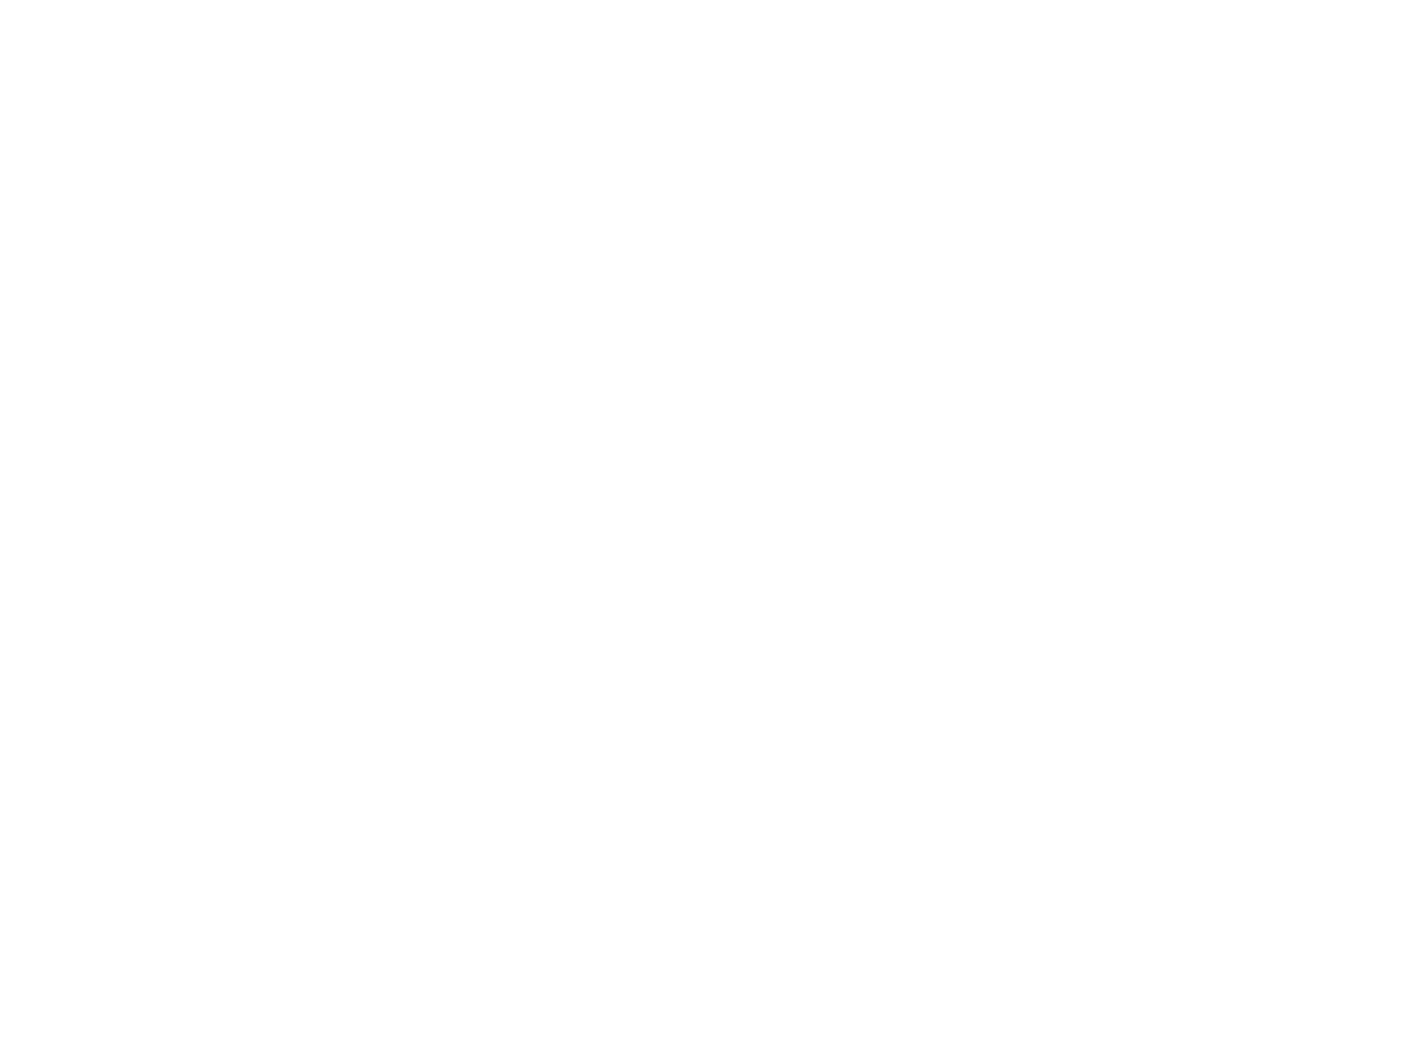

<IPython.core.display.Javascript object>


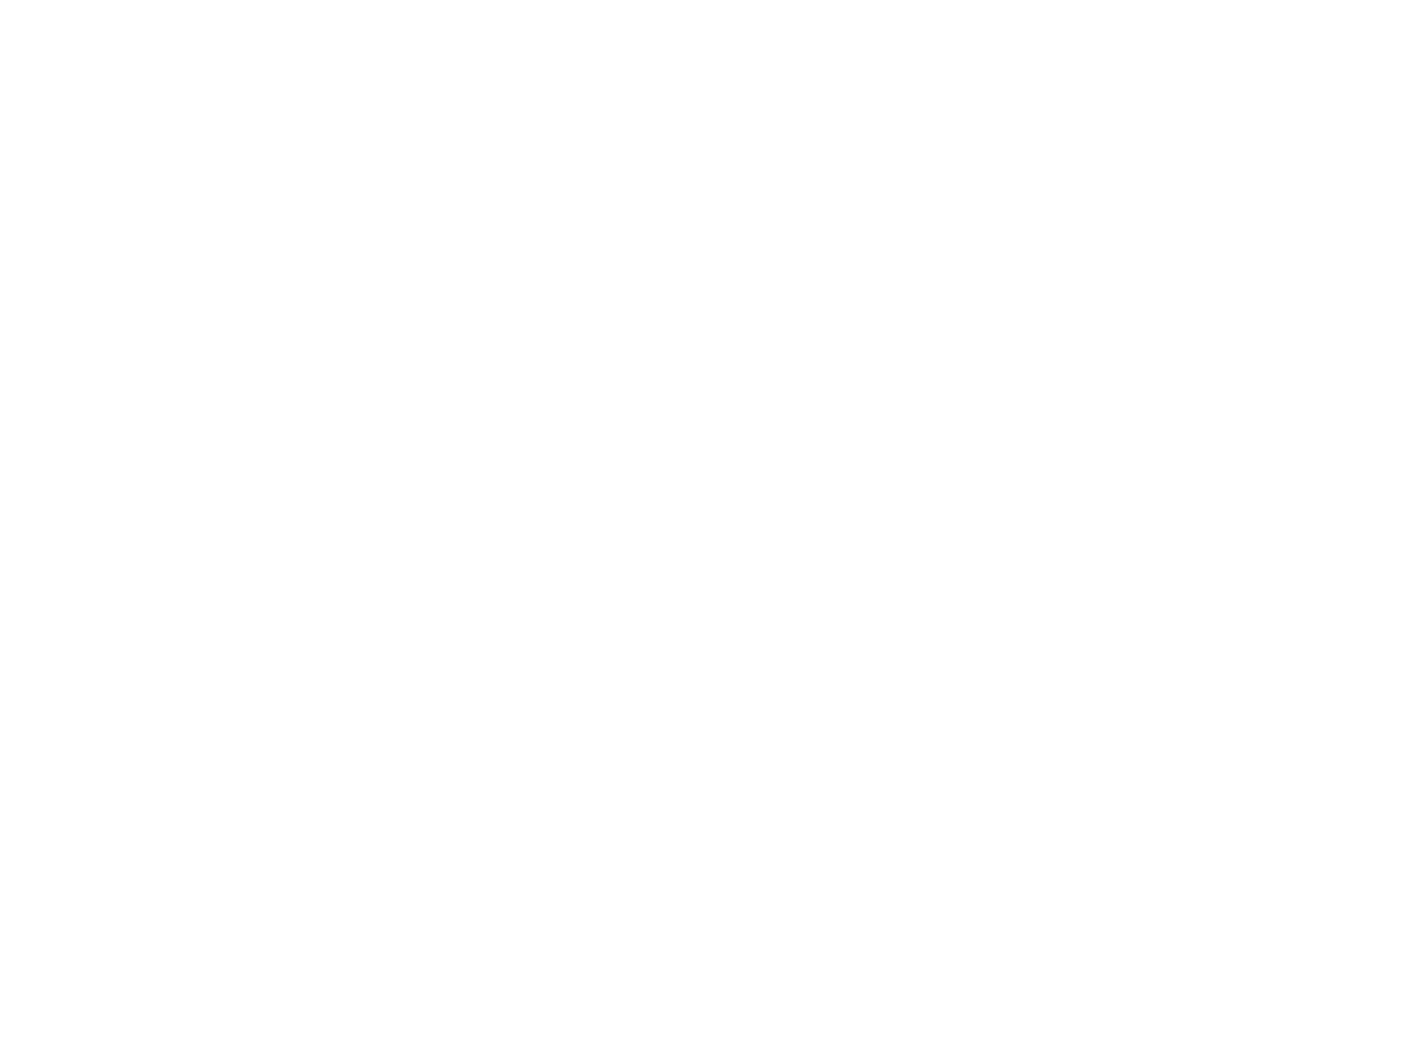

<IPython.core.display.Javascript object>


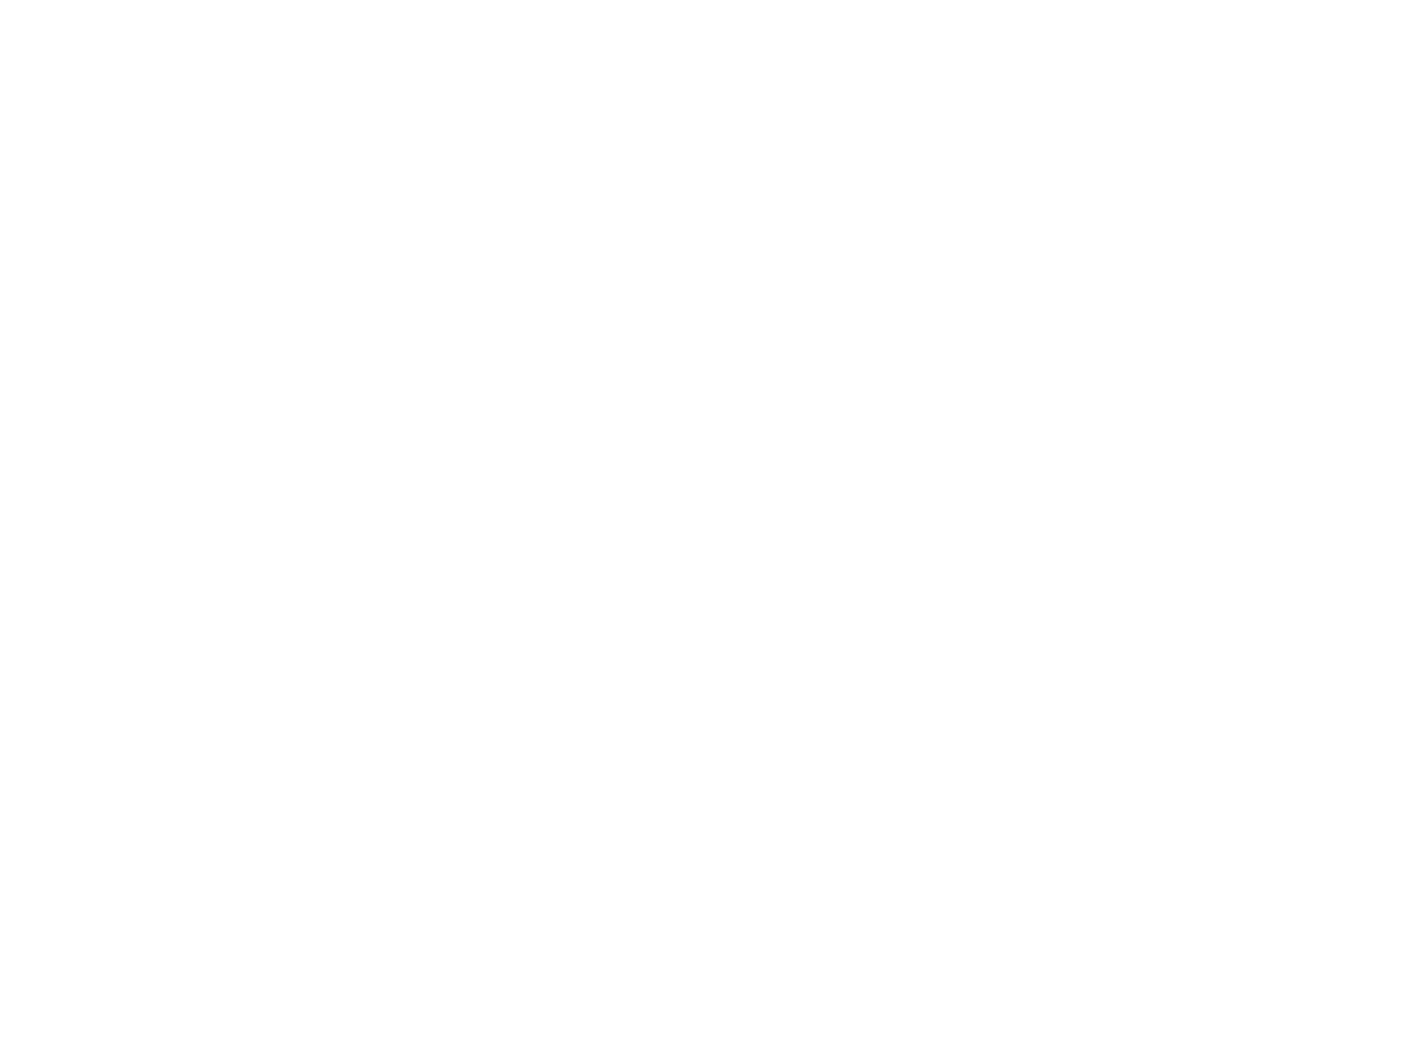

<IPython.core.display.Javascript object>


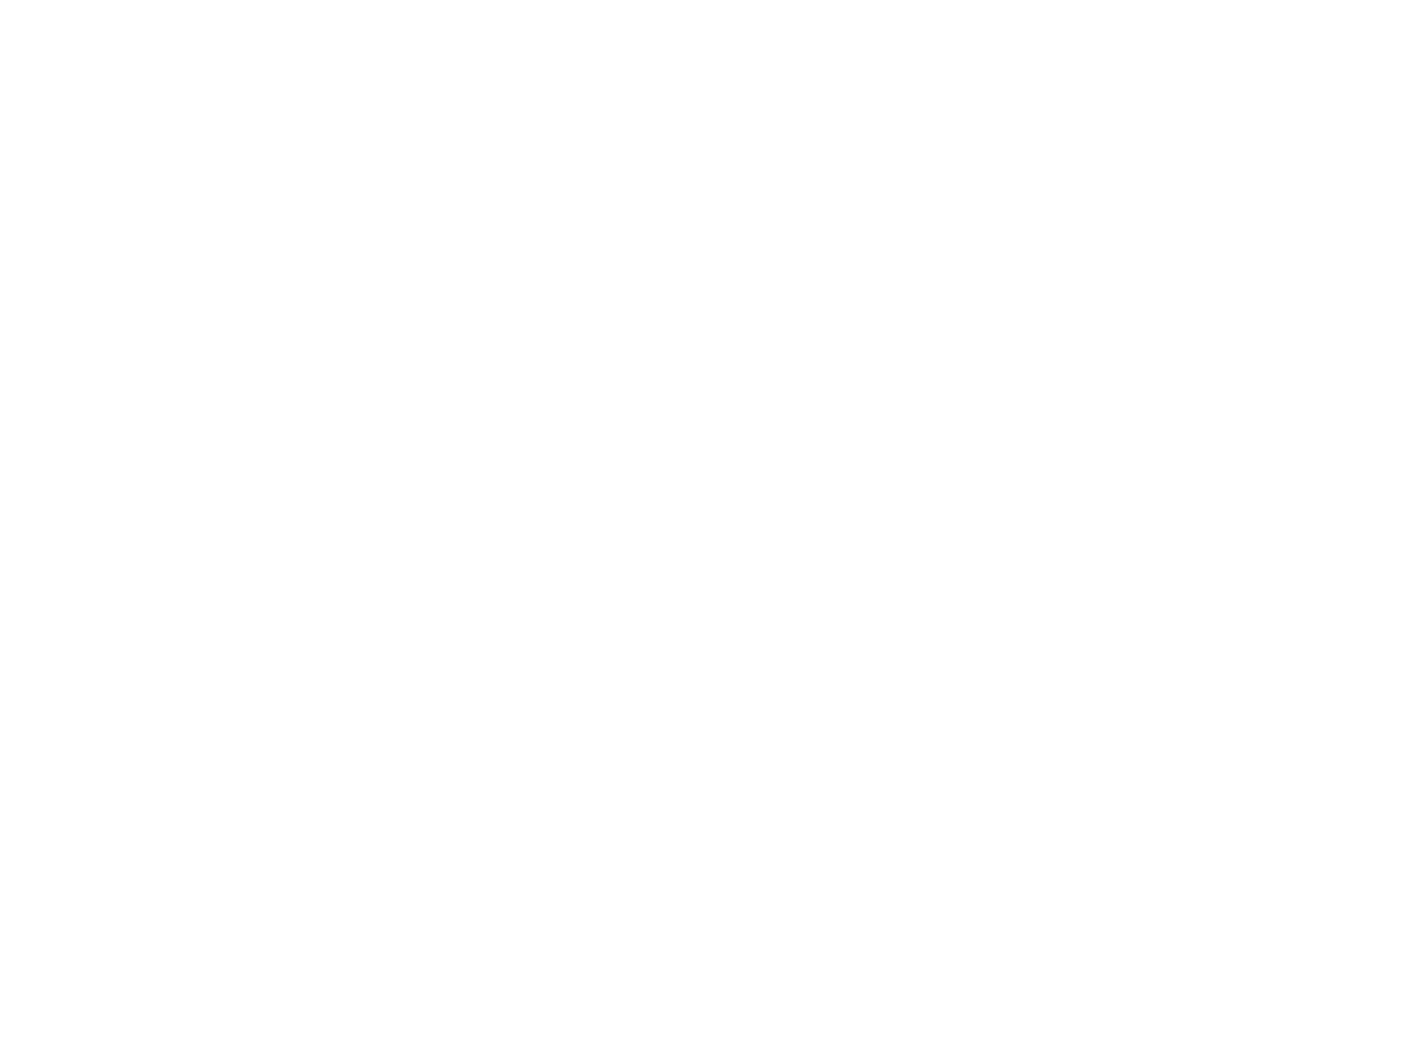

<IPython.core.display.Javascript object>


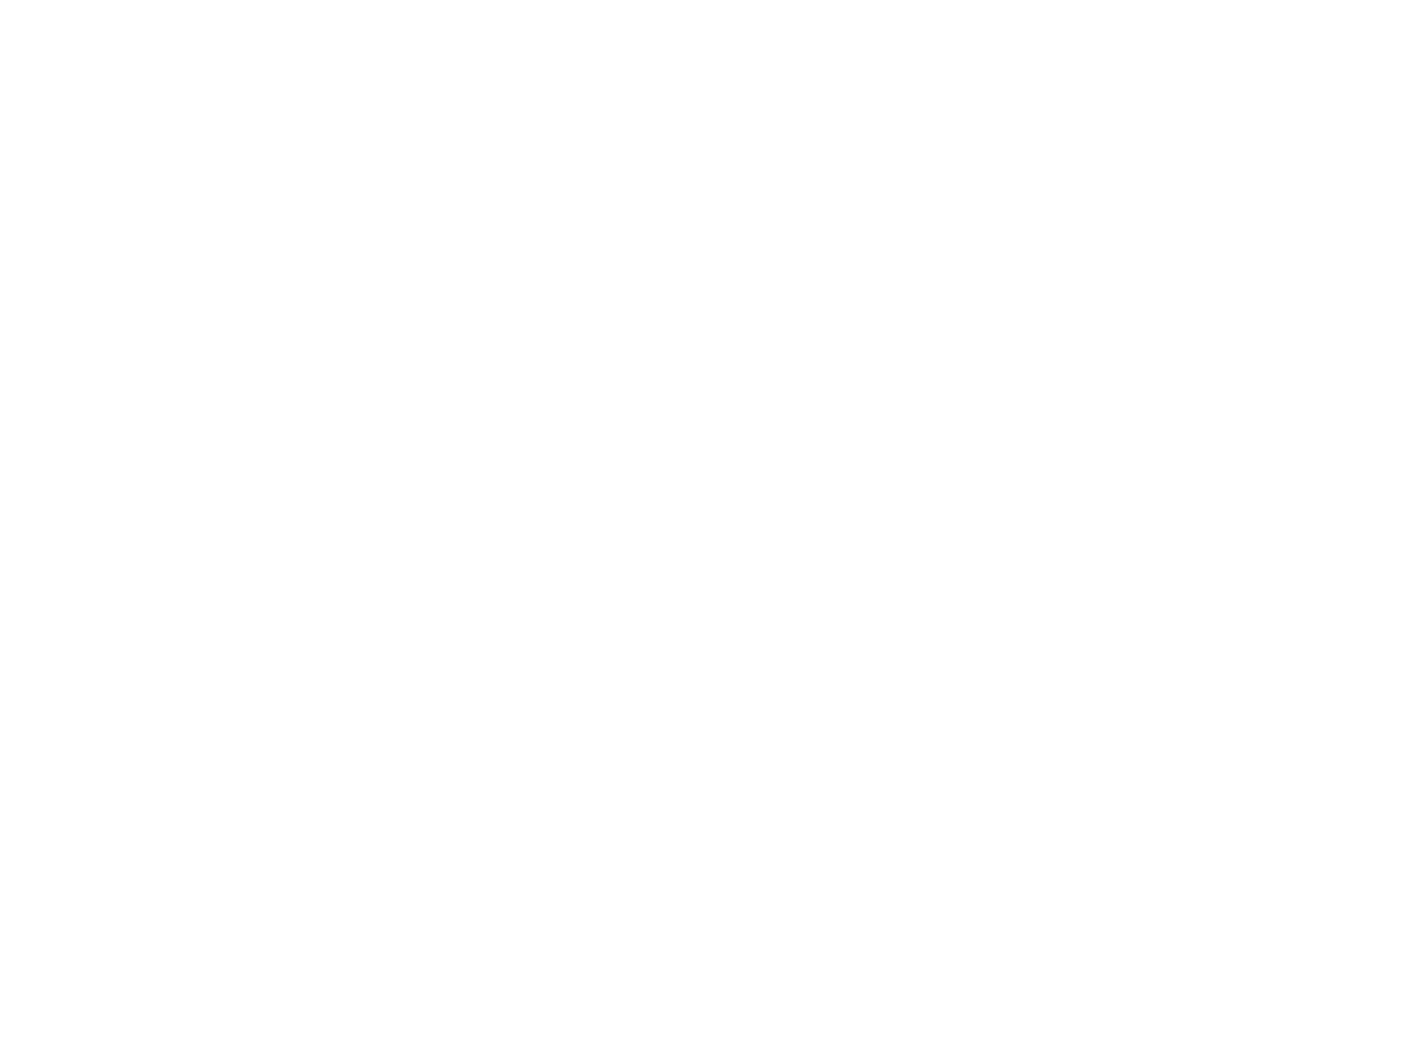

<IPython.core.display.Javascript object>


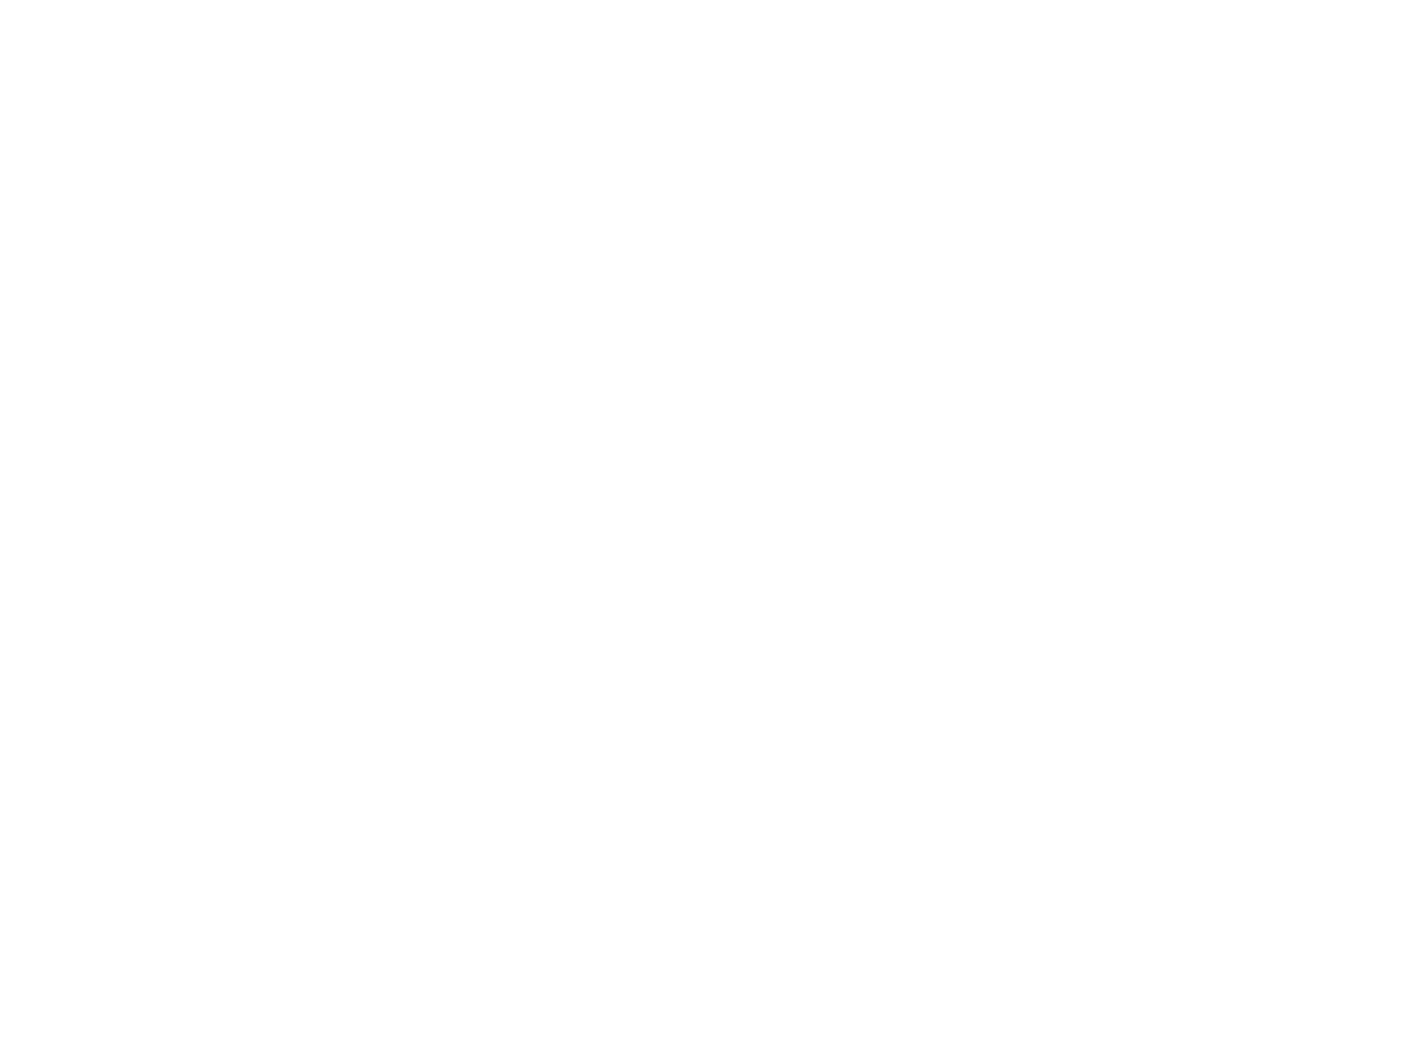

<IPython.core.display.Javascript object>


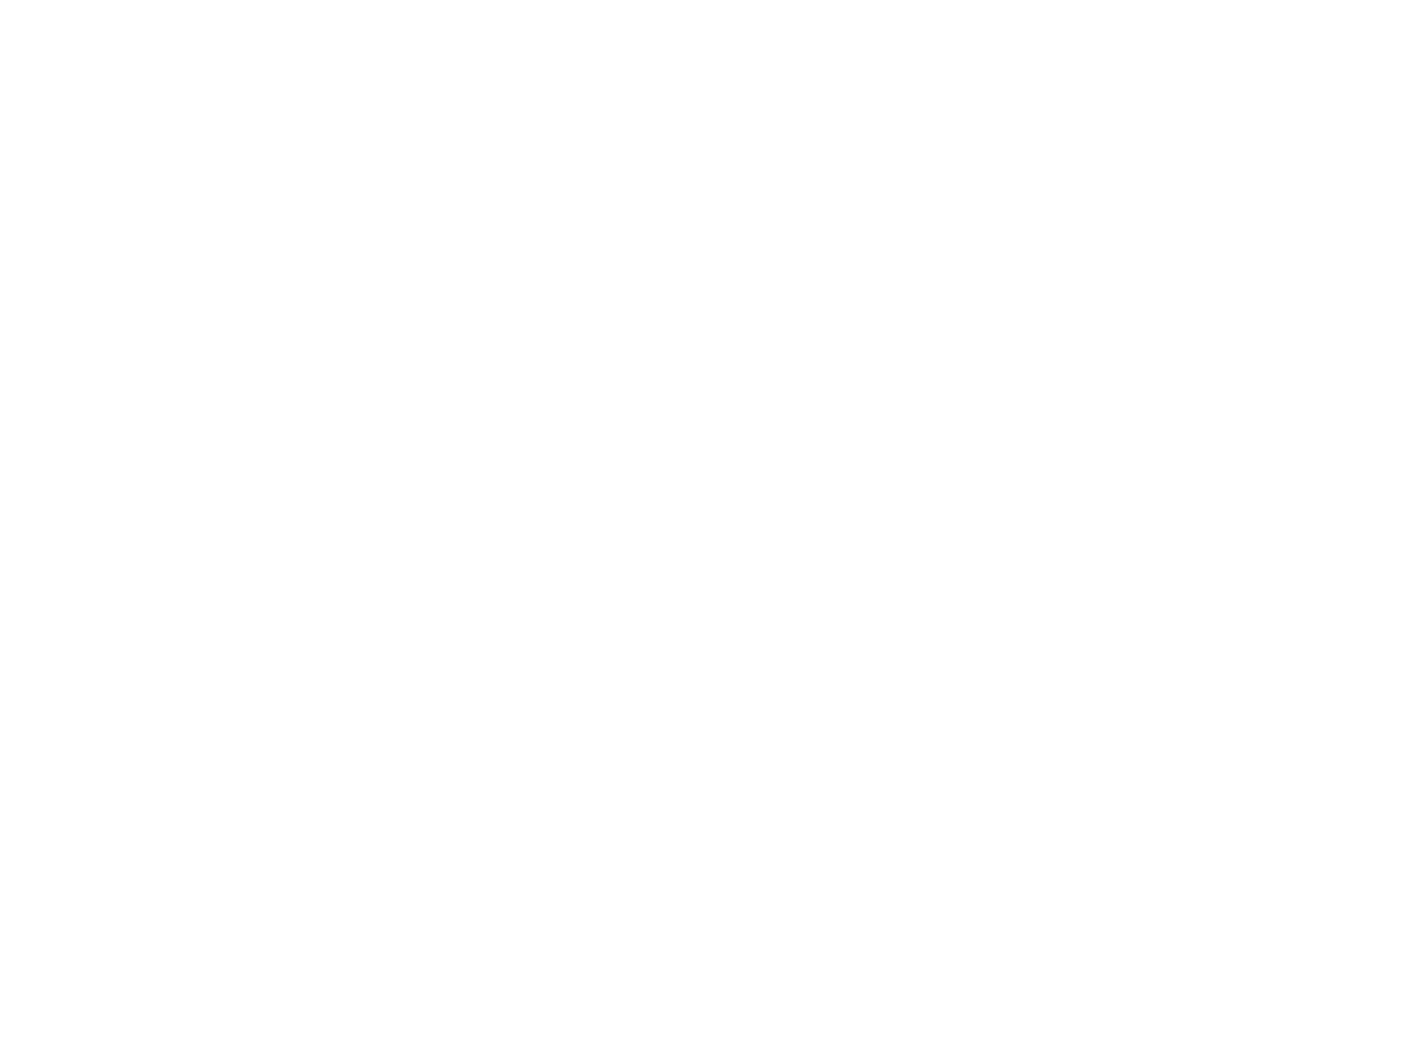

<IPython.core.display.Javascript object>


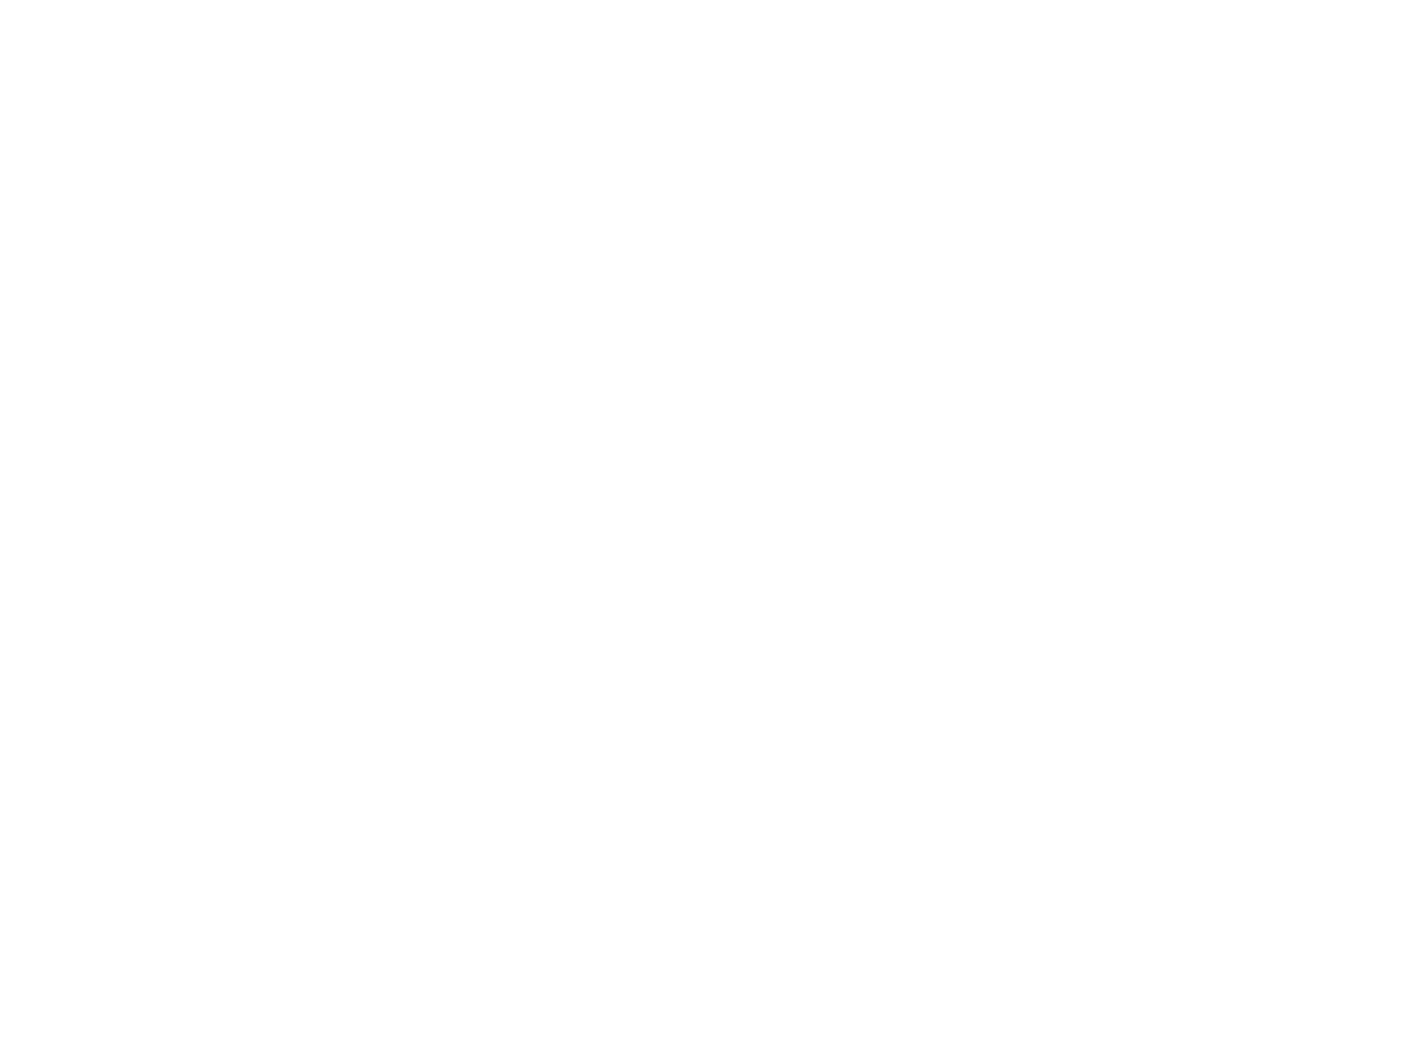

<IPython.core.display.Javascript object>


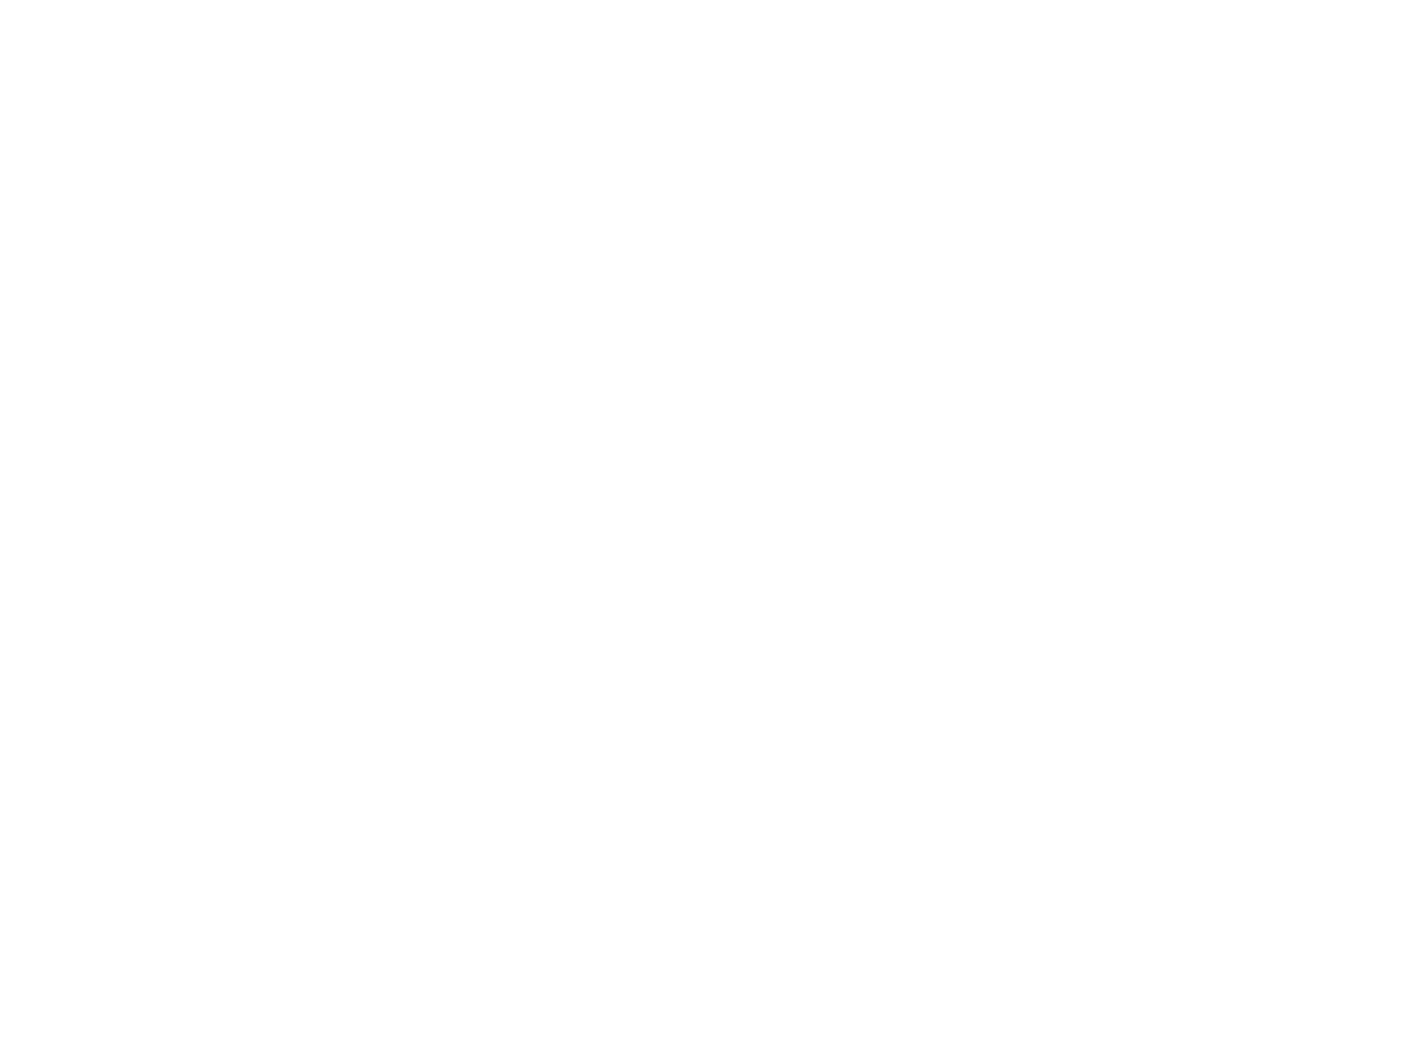

<IPython.core.display.Javascript object>


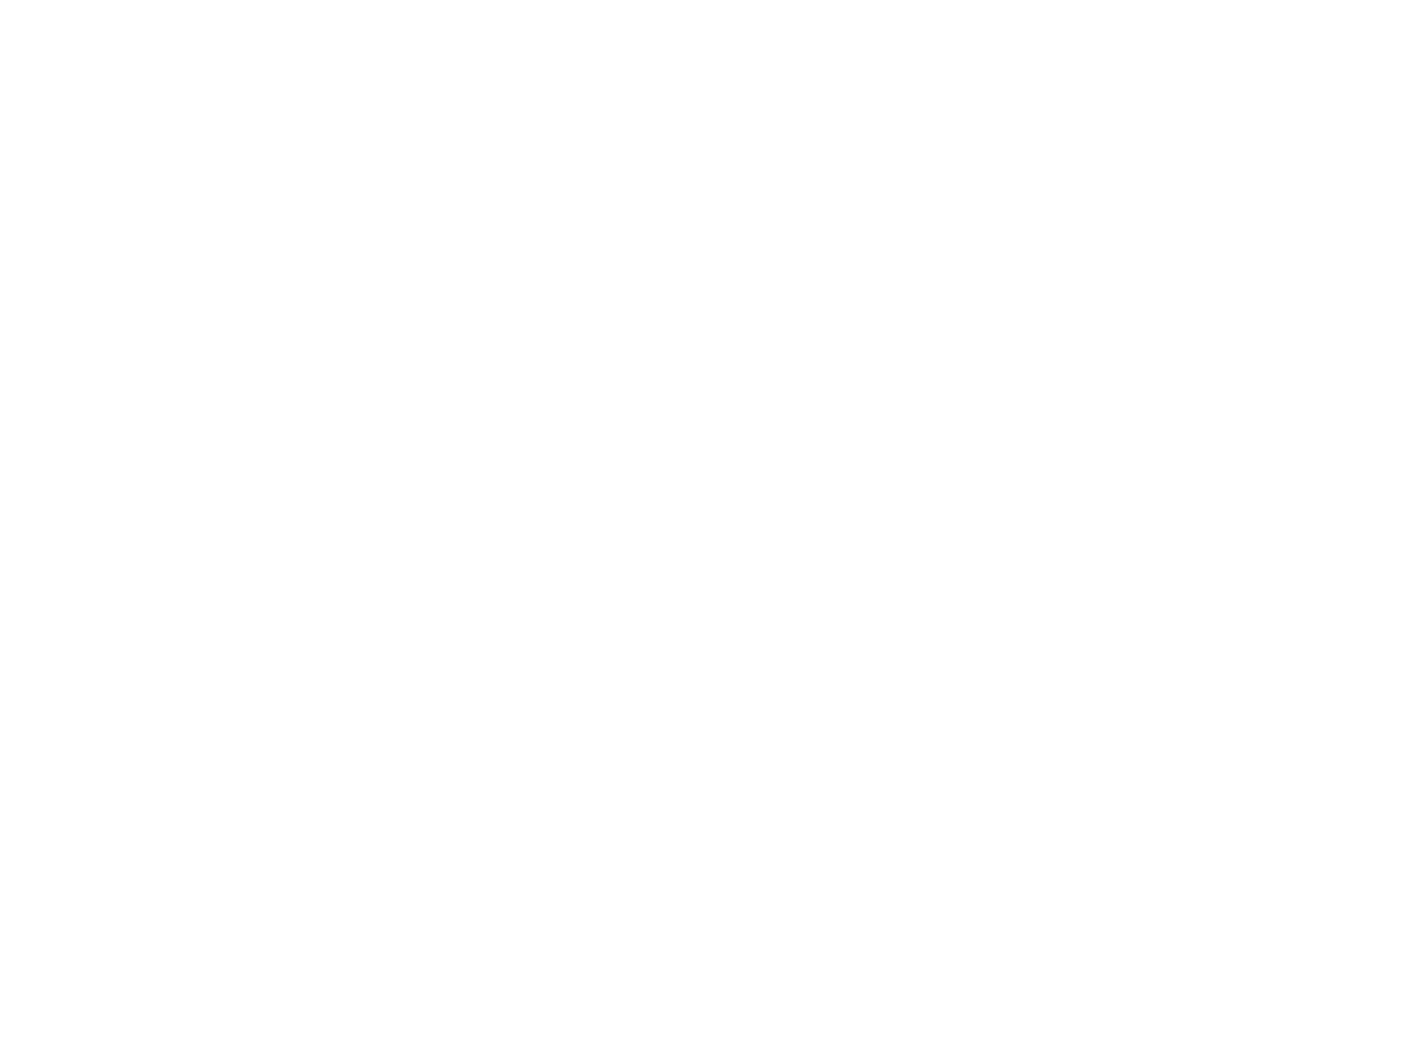

<IPython.core.display.Javascript object>


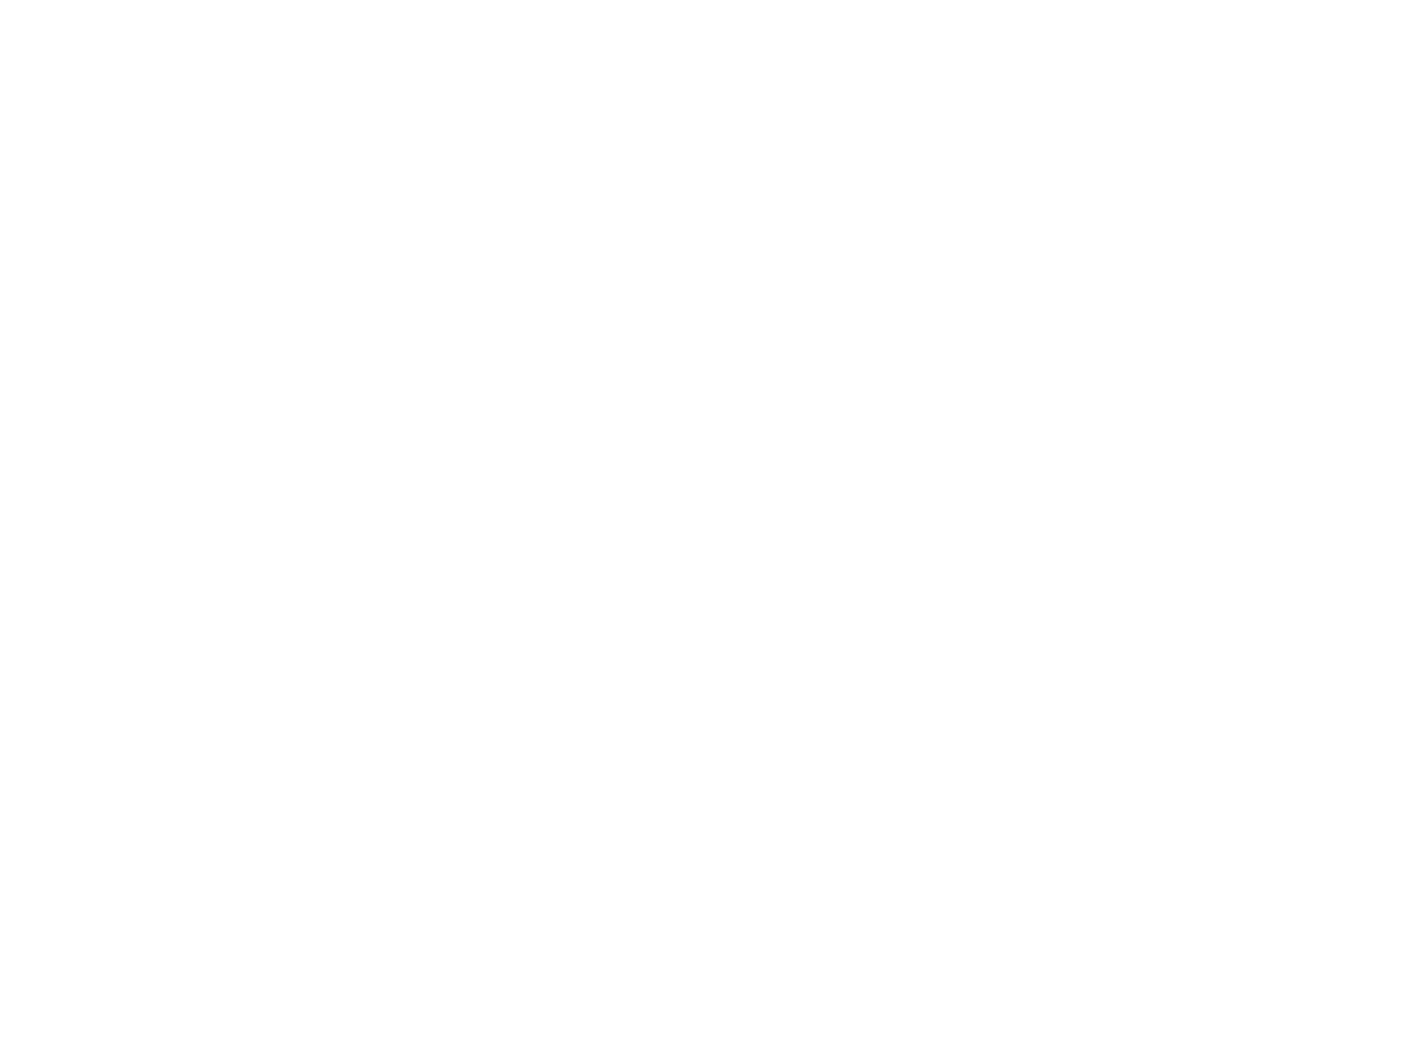

<IPython.core.display.Javascript object>


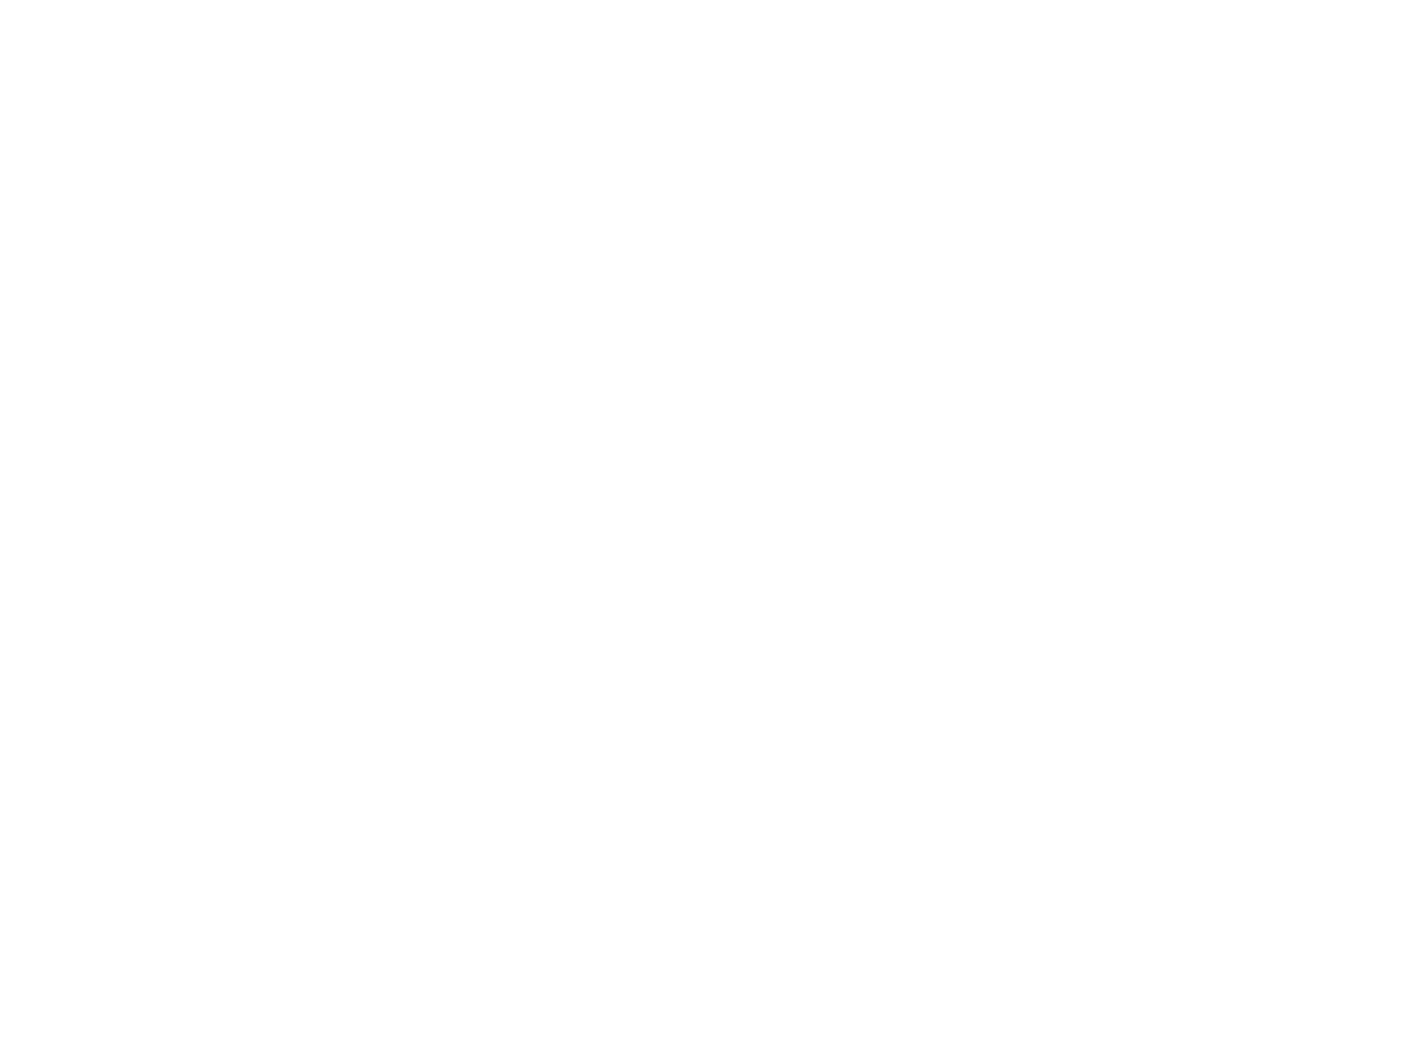

<IPython.core.display.Javascript object>


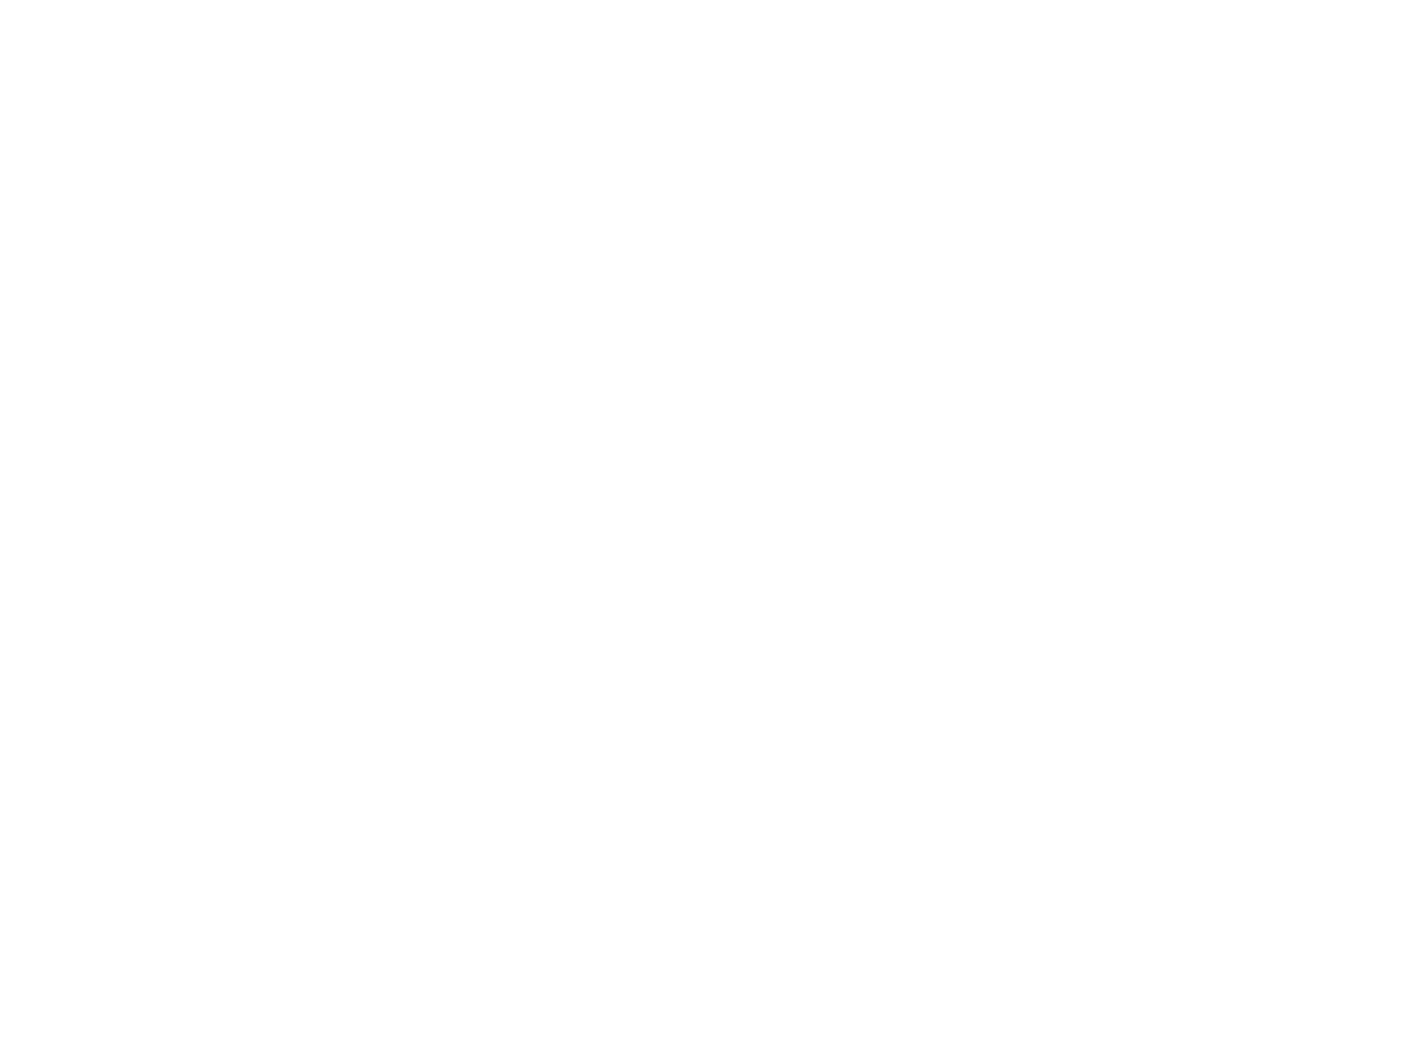

<IPython.core.display.Javascript object>


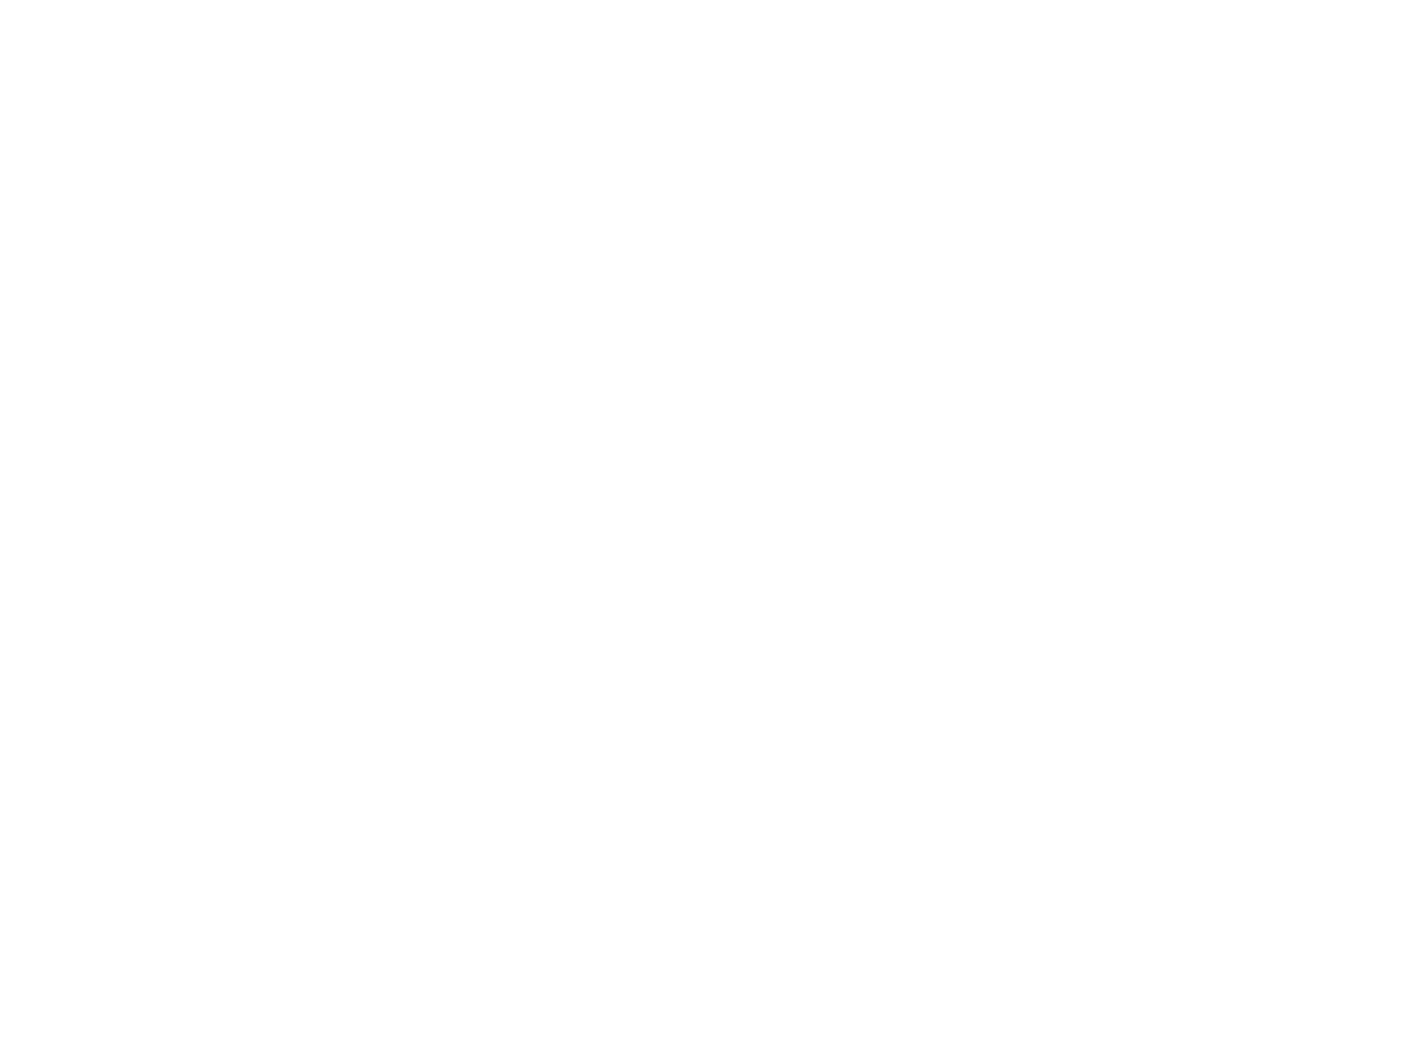

<IPython.core.display.Javascript object>


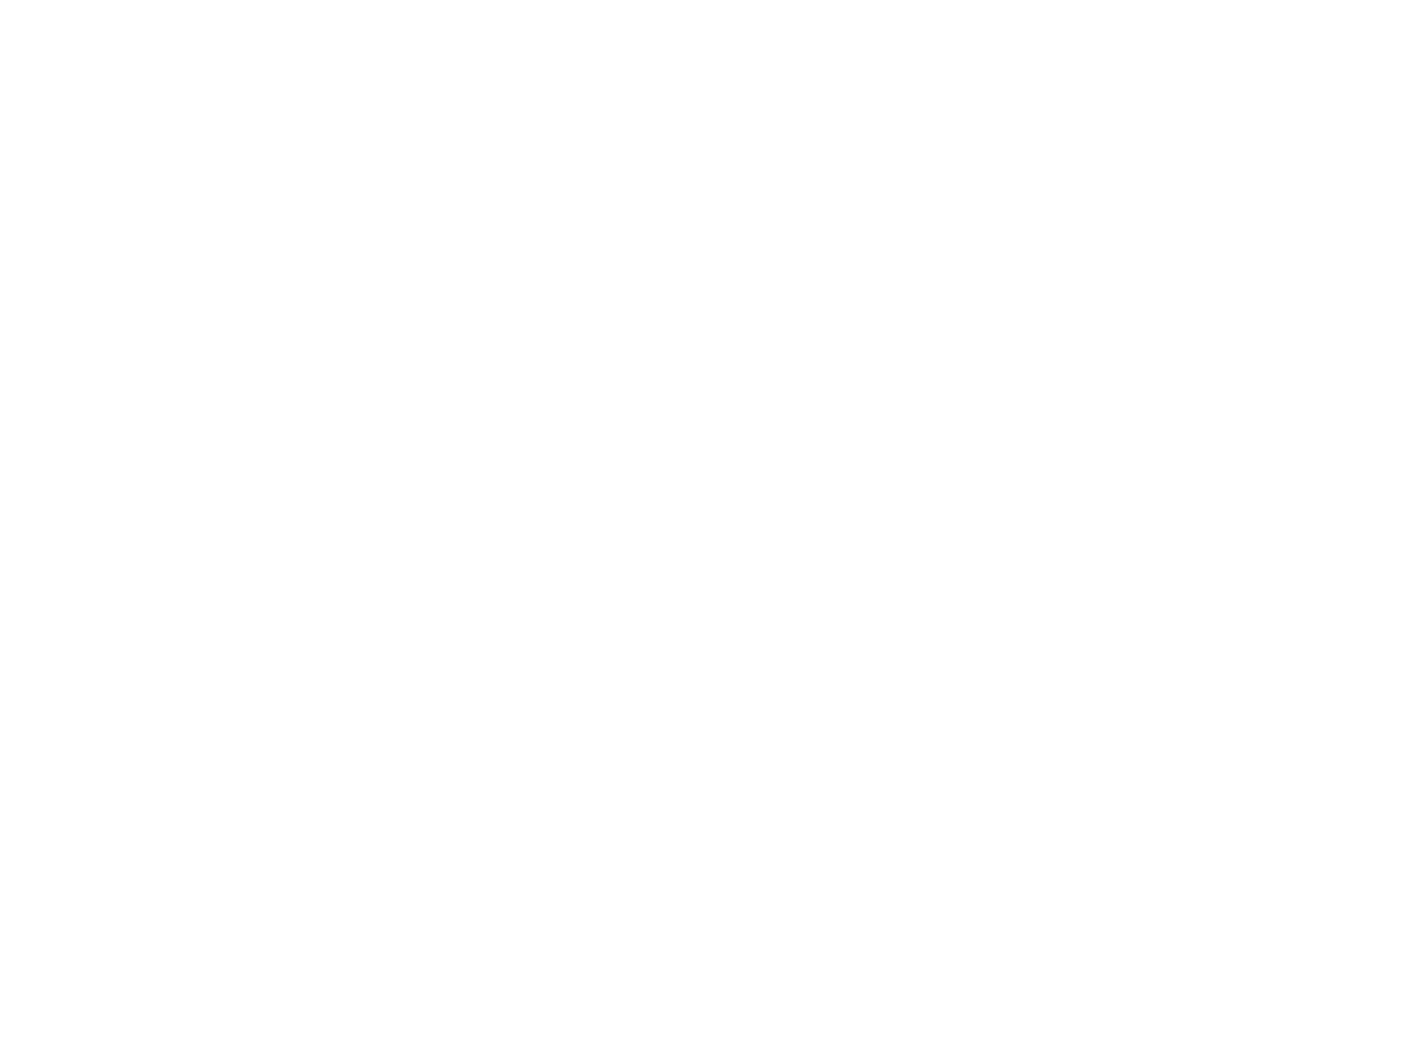

In [4]:
#plotting histograms of mean signal intensity per ROI
tc_mean_full = np.zeros(nonzerovar_mask.shape)
tc_mean = timecourse.mean(-1)
tc_mean_full[nonzerovar_mask]=tc_mean
for roi in idx_rois:
    pl.figure()
    pl.title(roi)
    pl.hist(tc_mean_full[idx_rois[roi]],bins=100)
    pl.show()   
    pl.close()


<IPython.core.display.Javascript object>


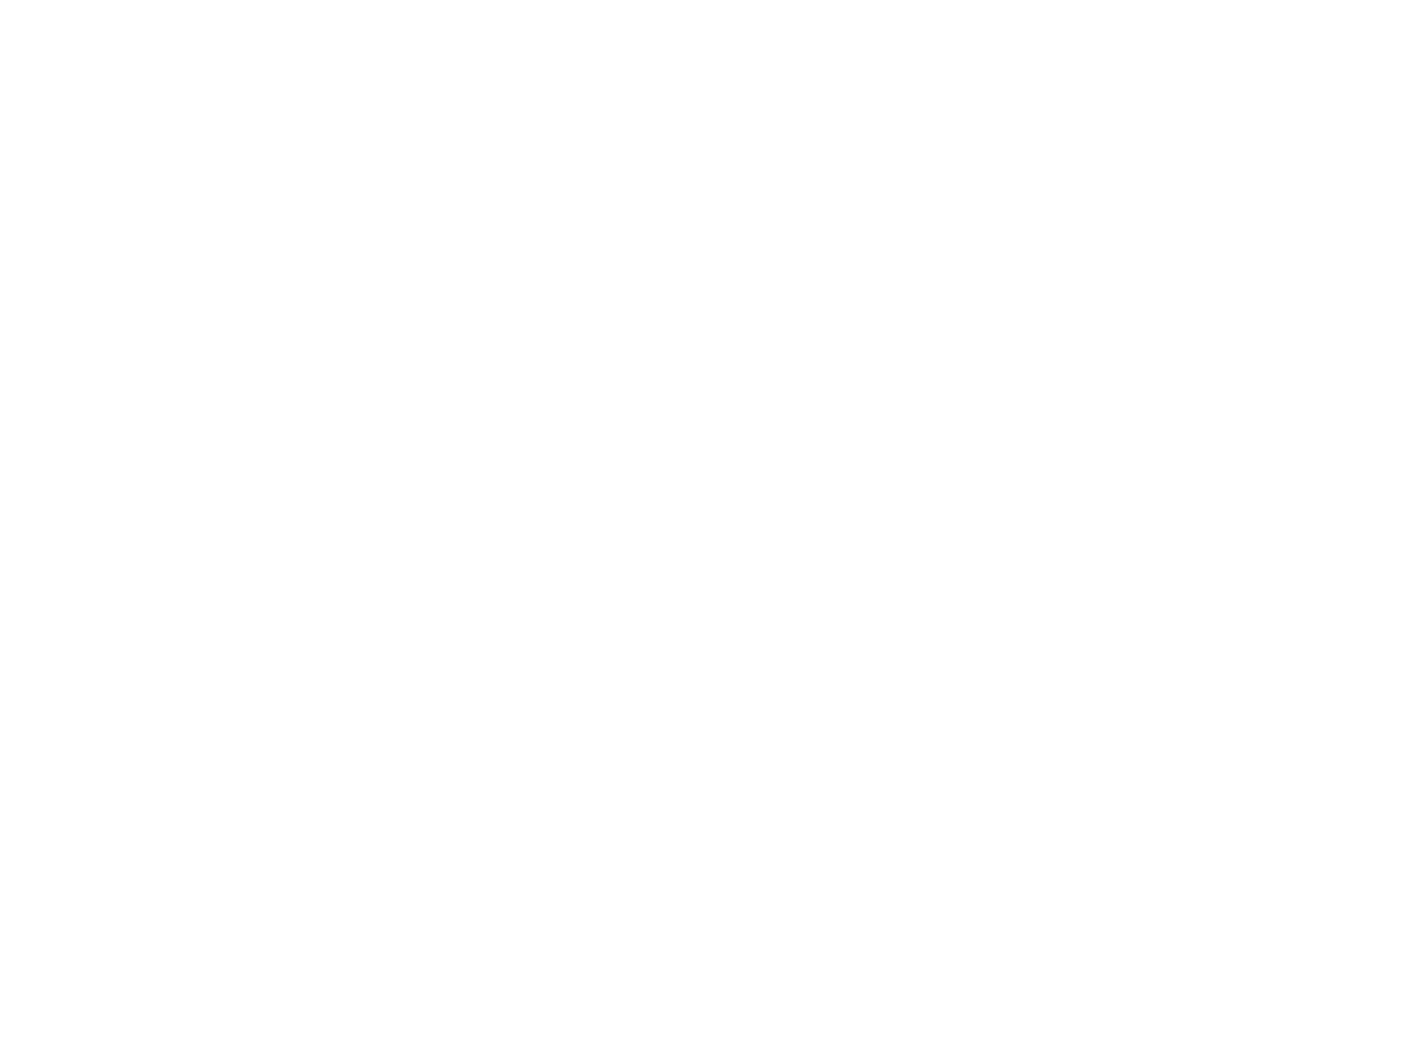

<IPython.core.display.Javascript object>


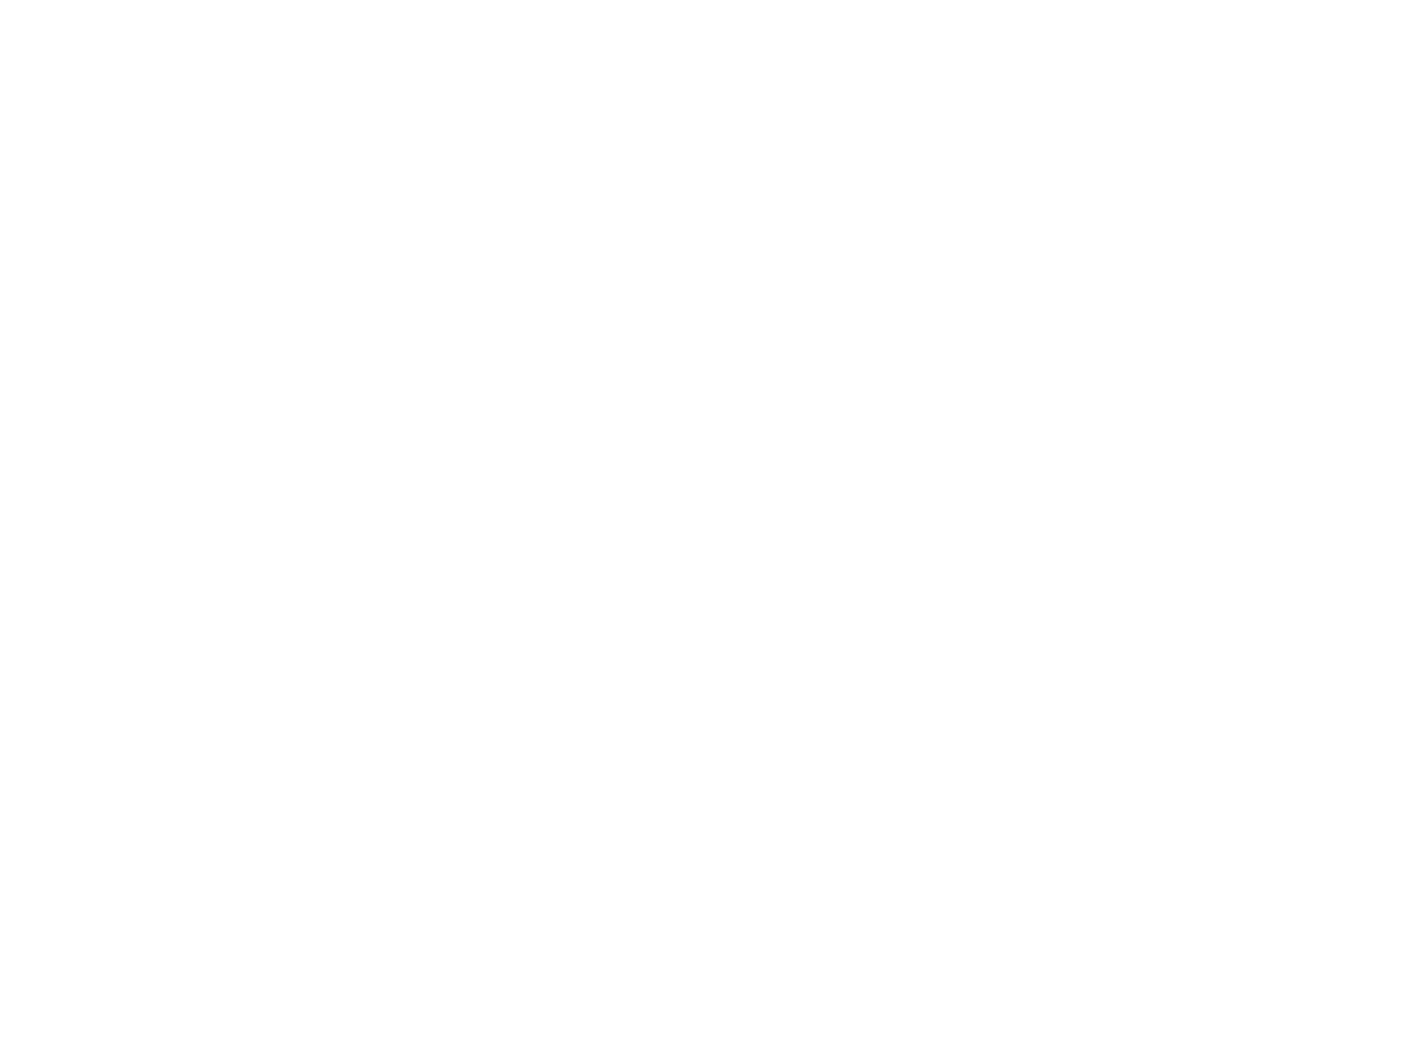

<IPython.core.display.Javascript object>


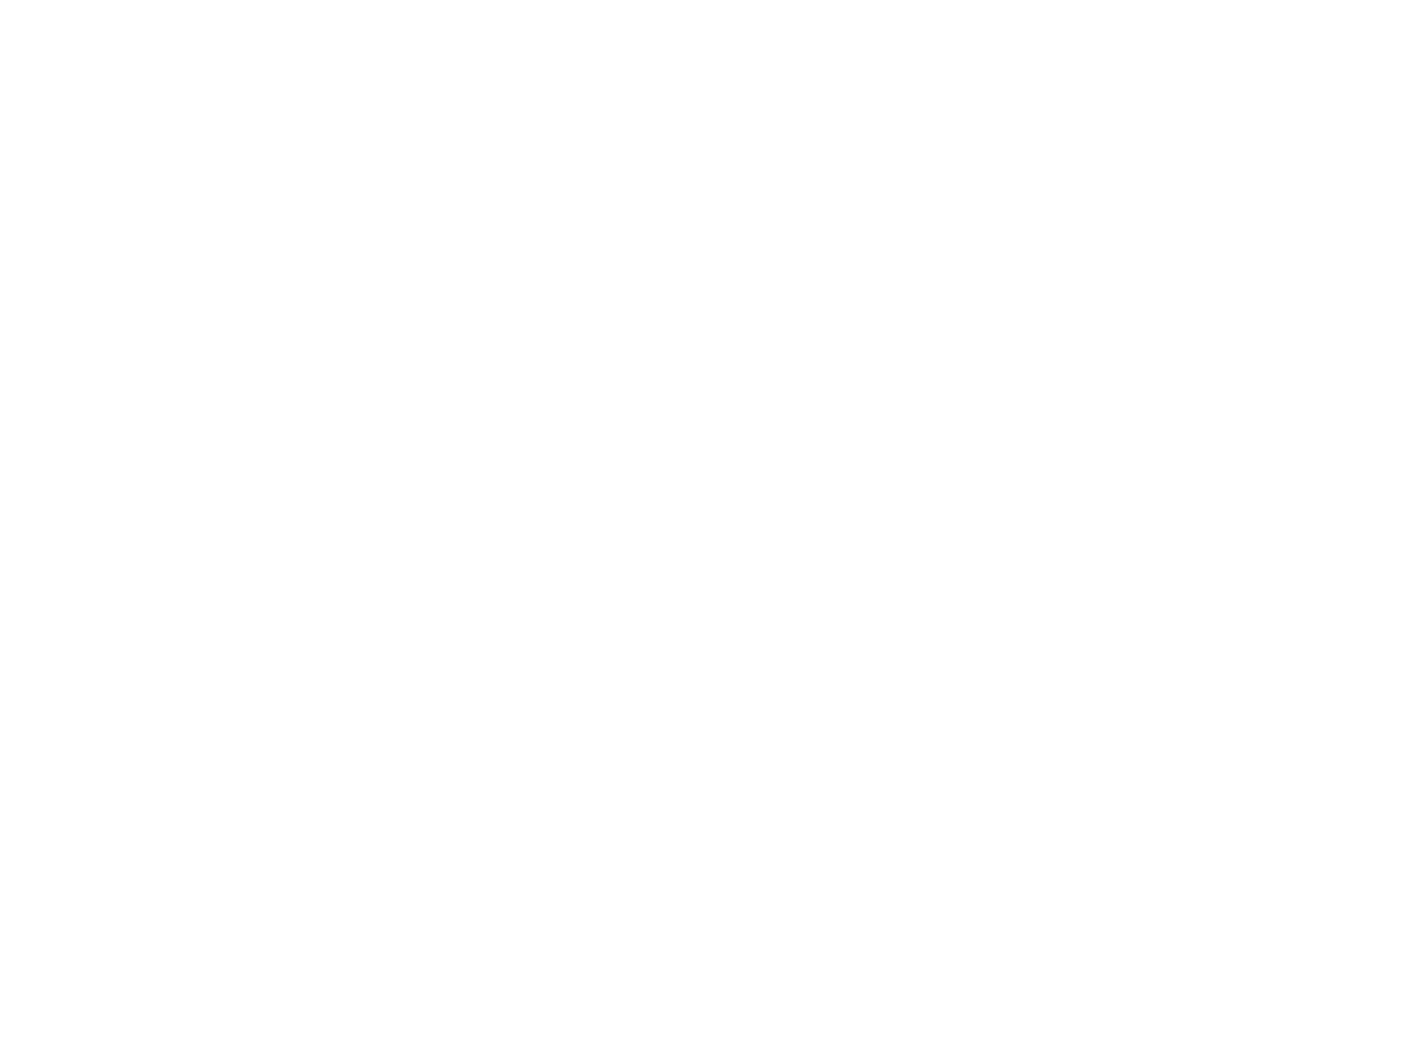

<IPython.core.display.Javascript object>


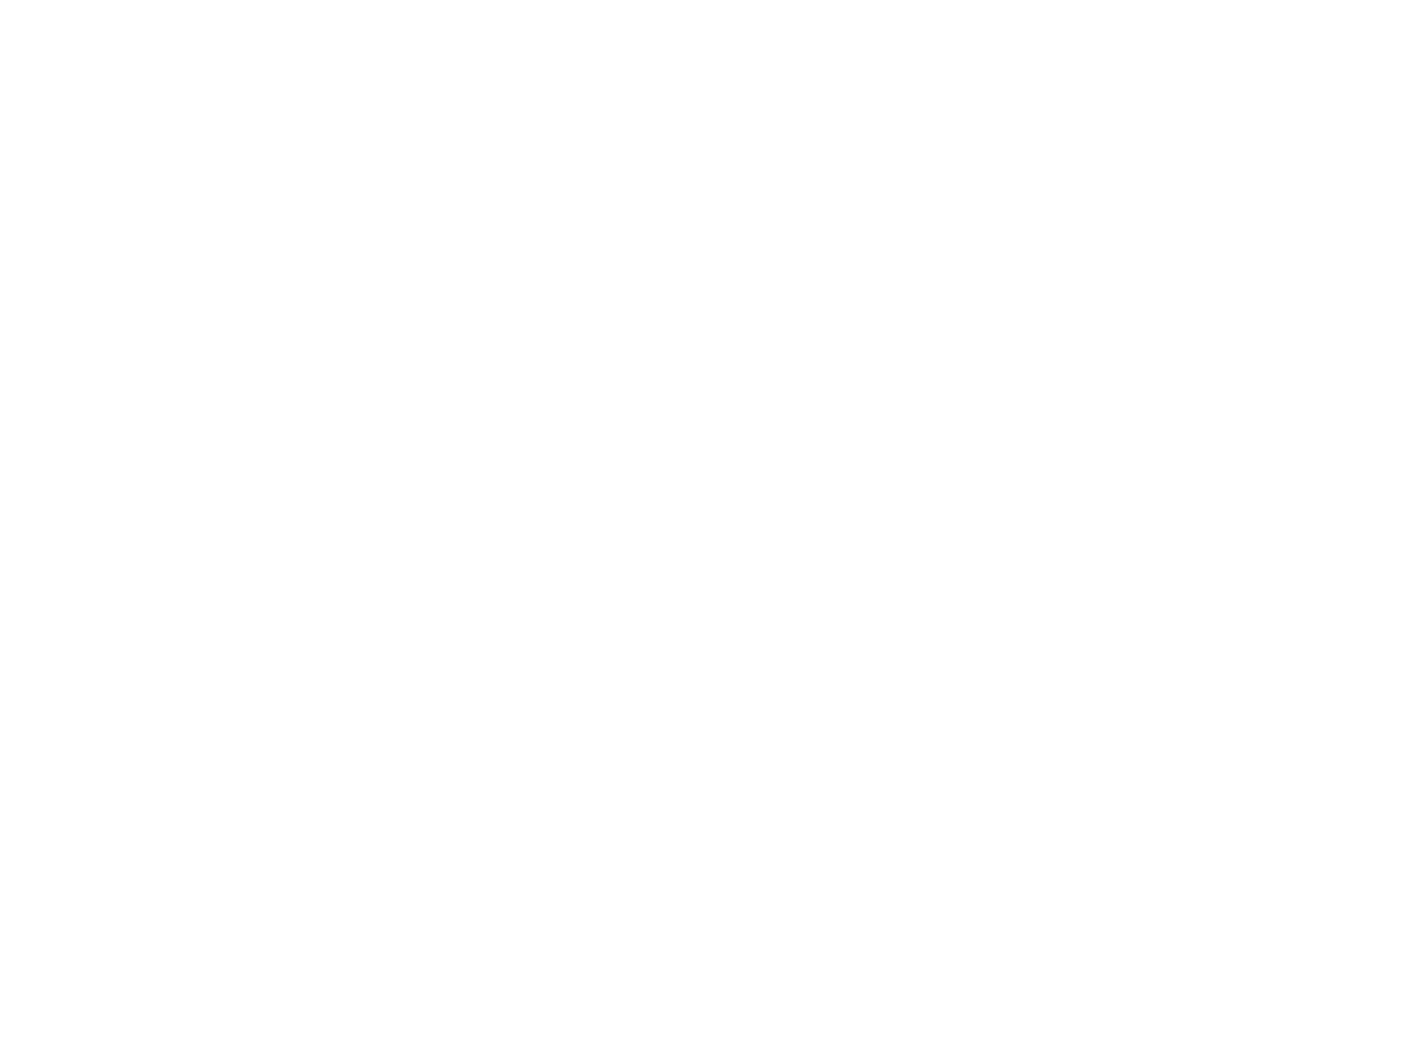

<IPython.core.display.Javascript object>


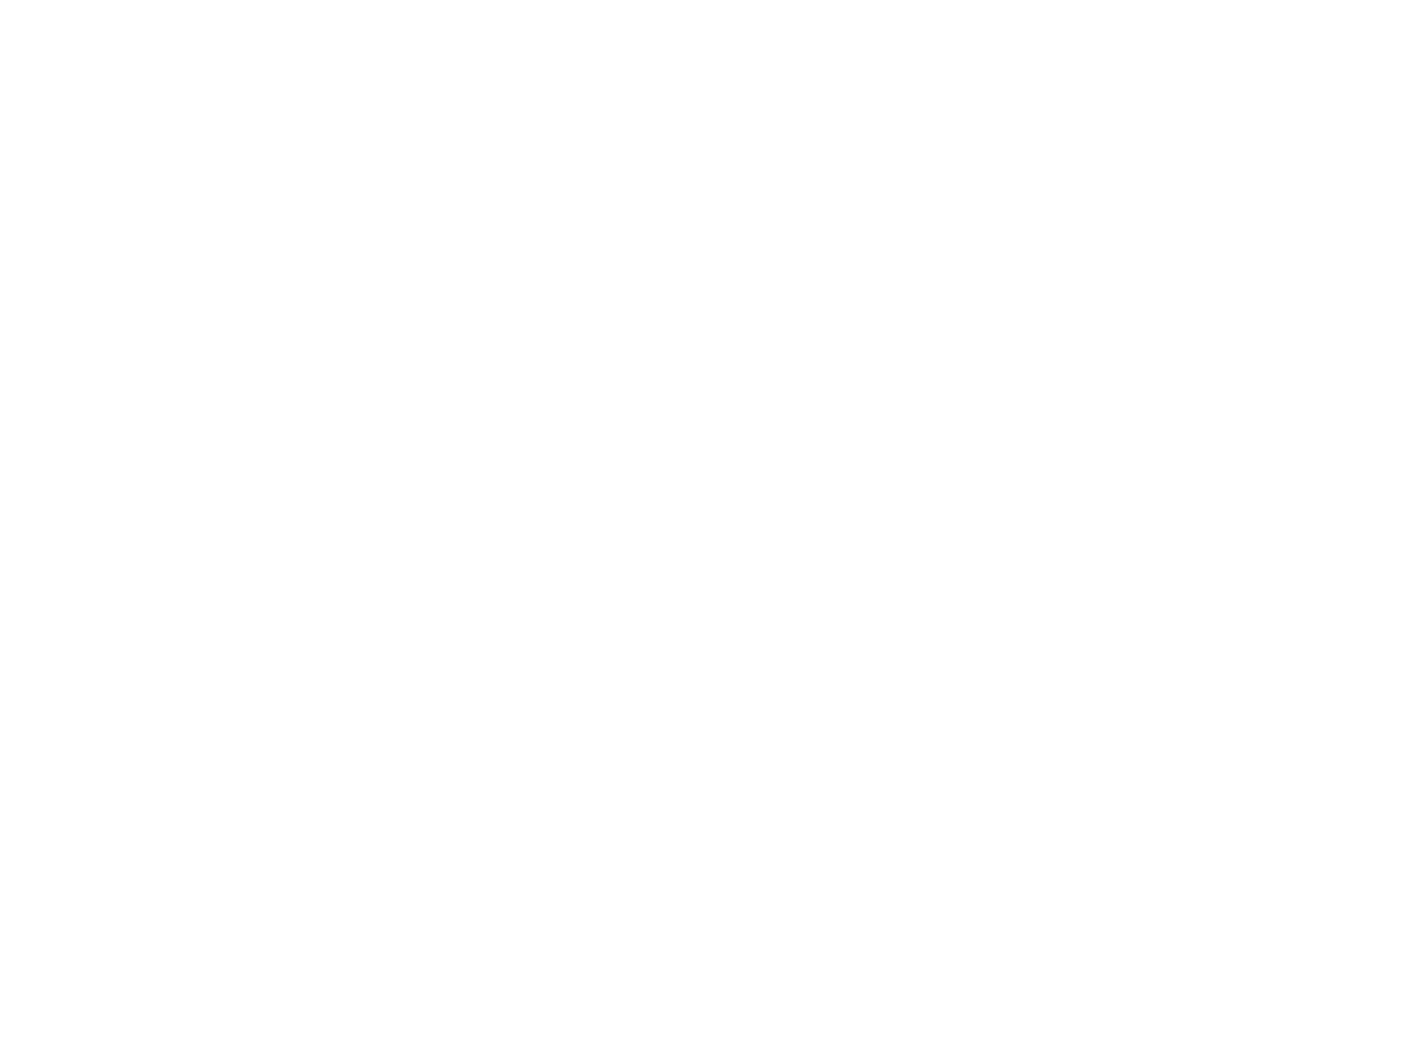

<IPython.core.display.Javascript object>


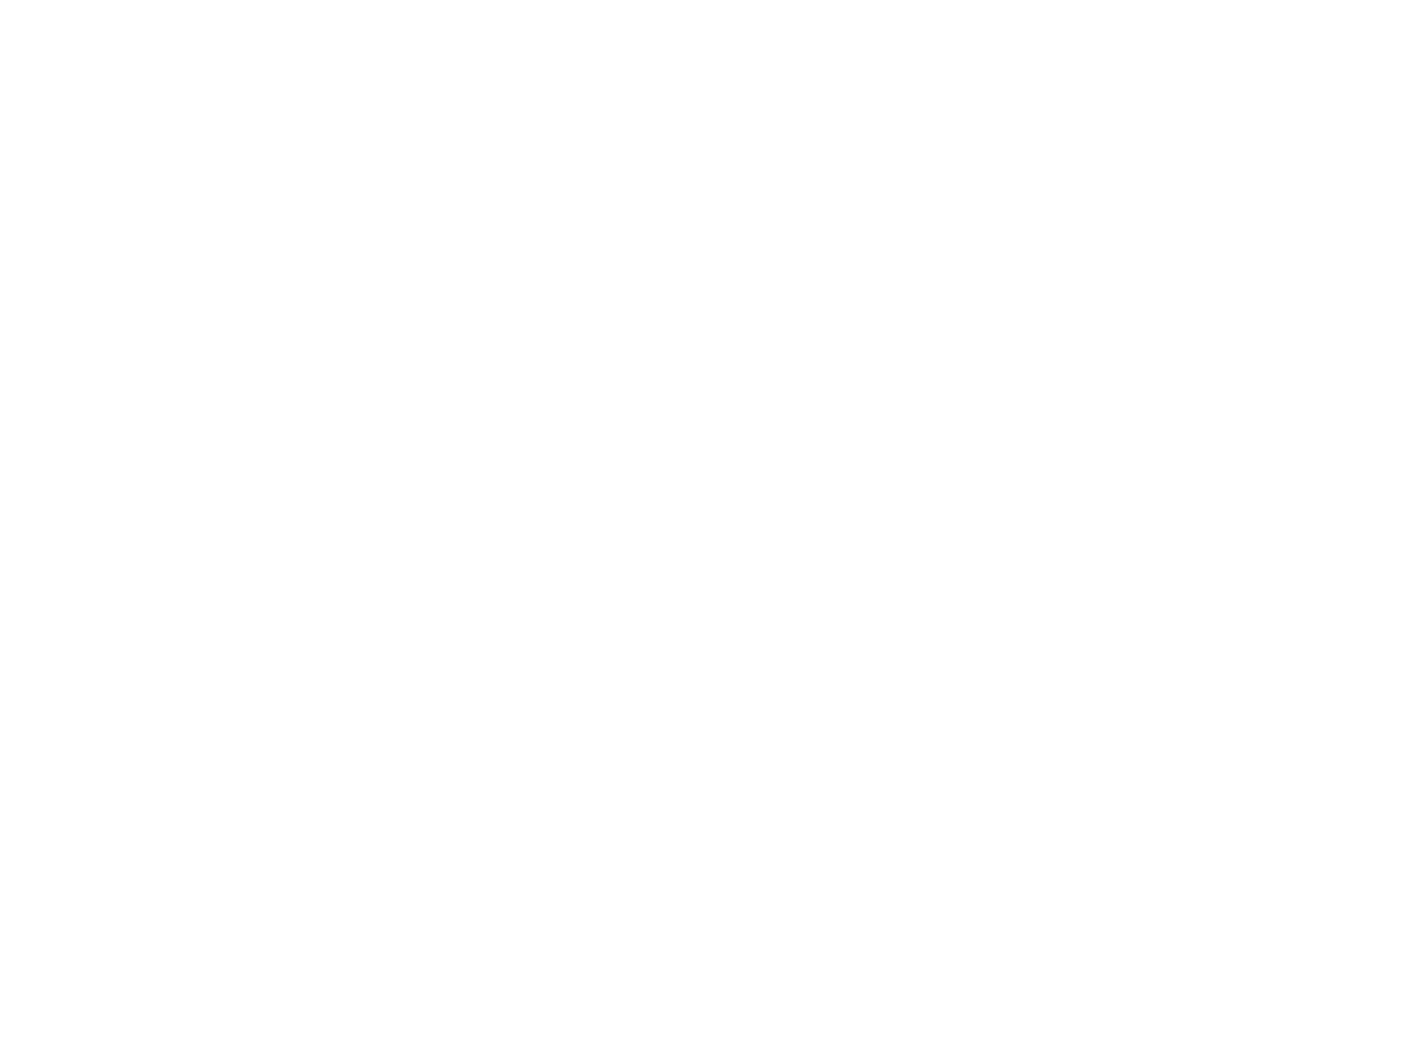

<IPython.core.display.Javascript object>


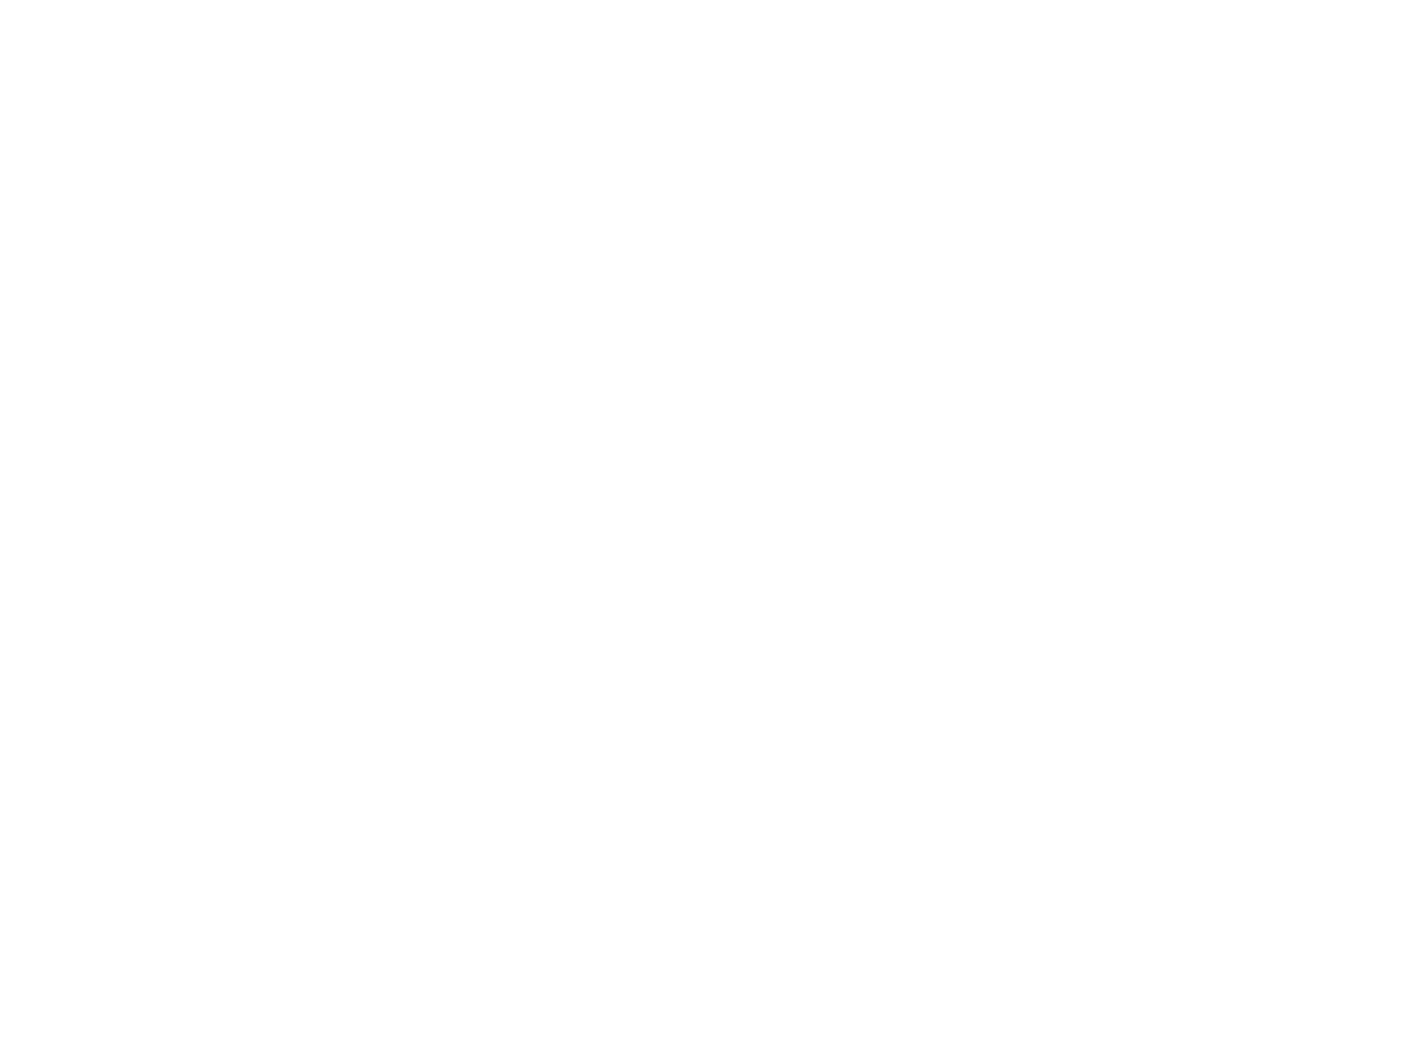

<IPython.core.display.Javascript object>


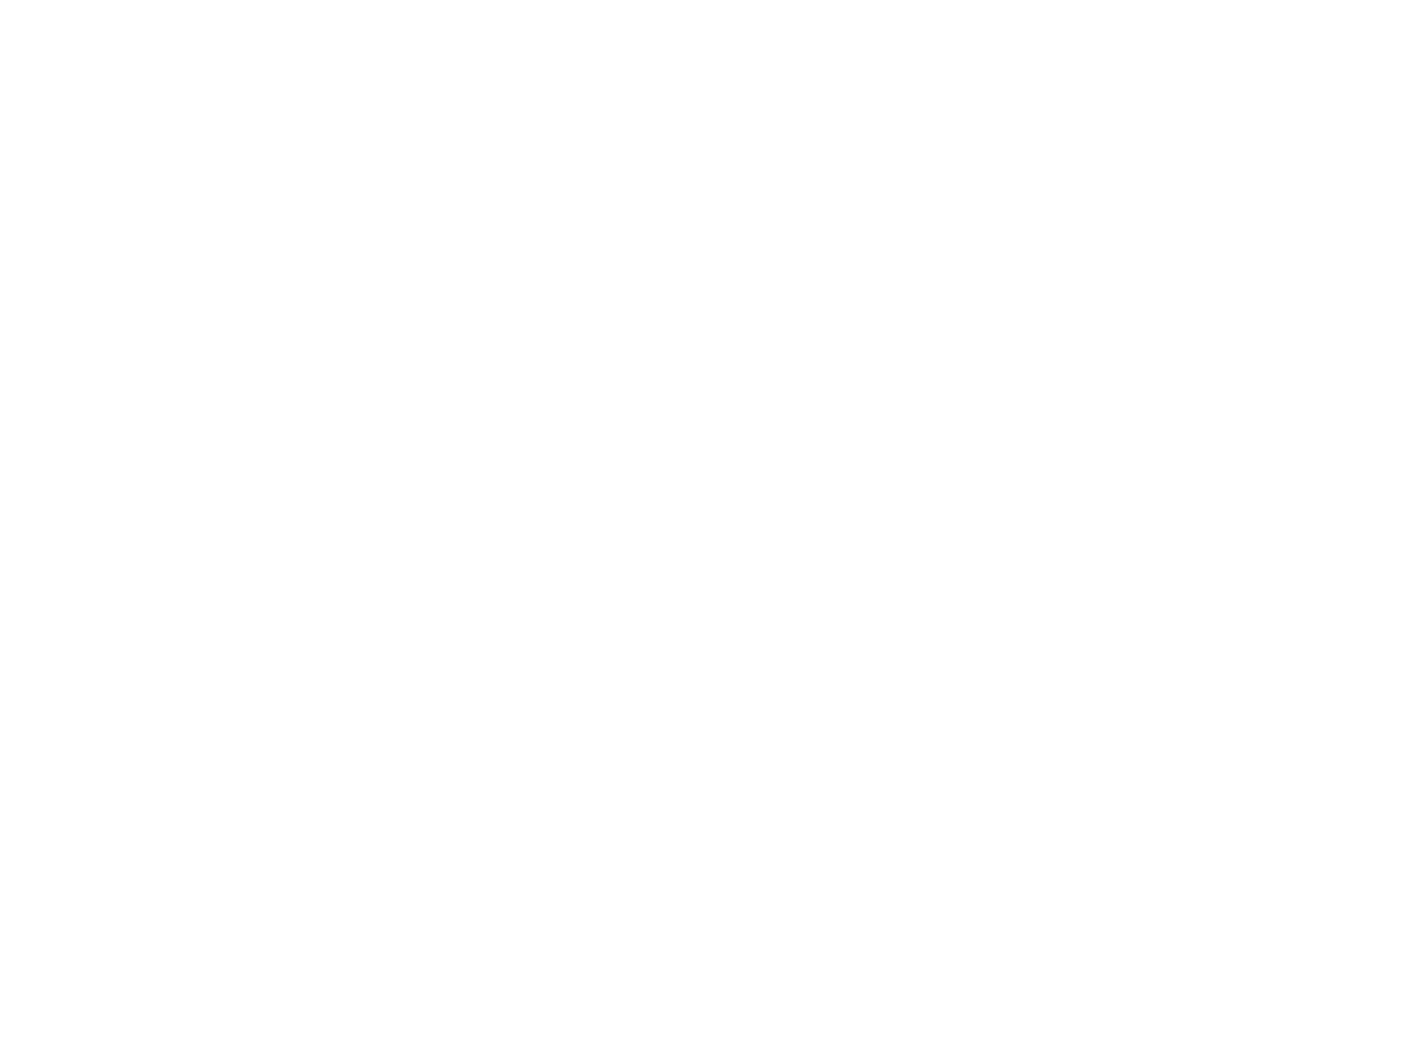

<IPython.core.display.Javascript object>


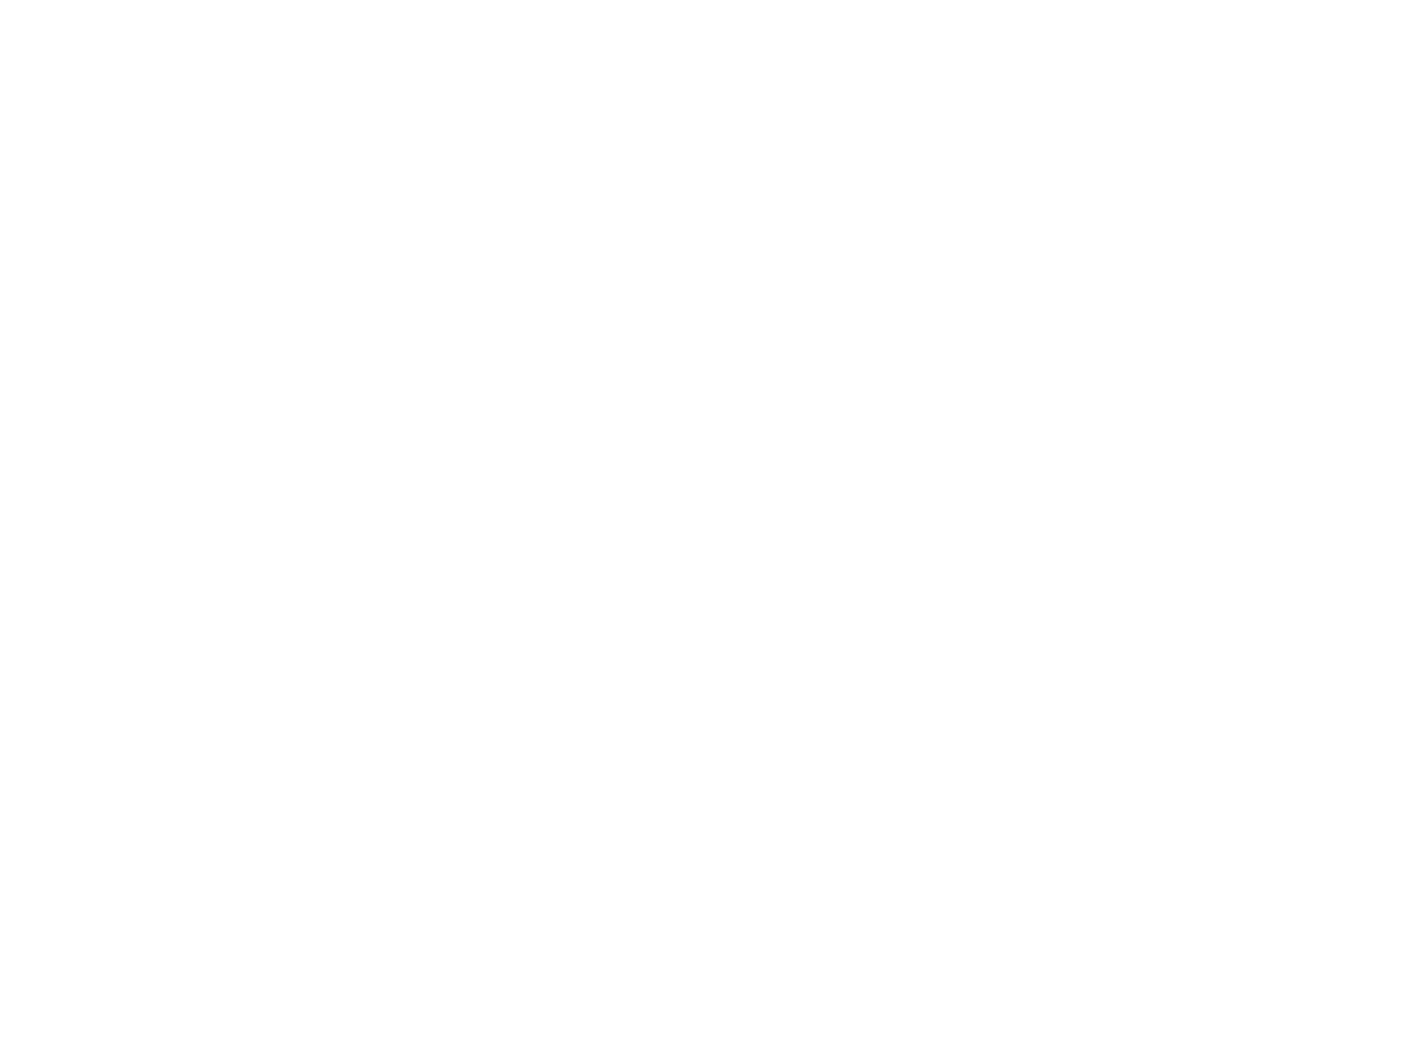

<IPython.core.display.Javascript object>


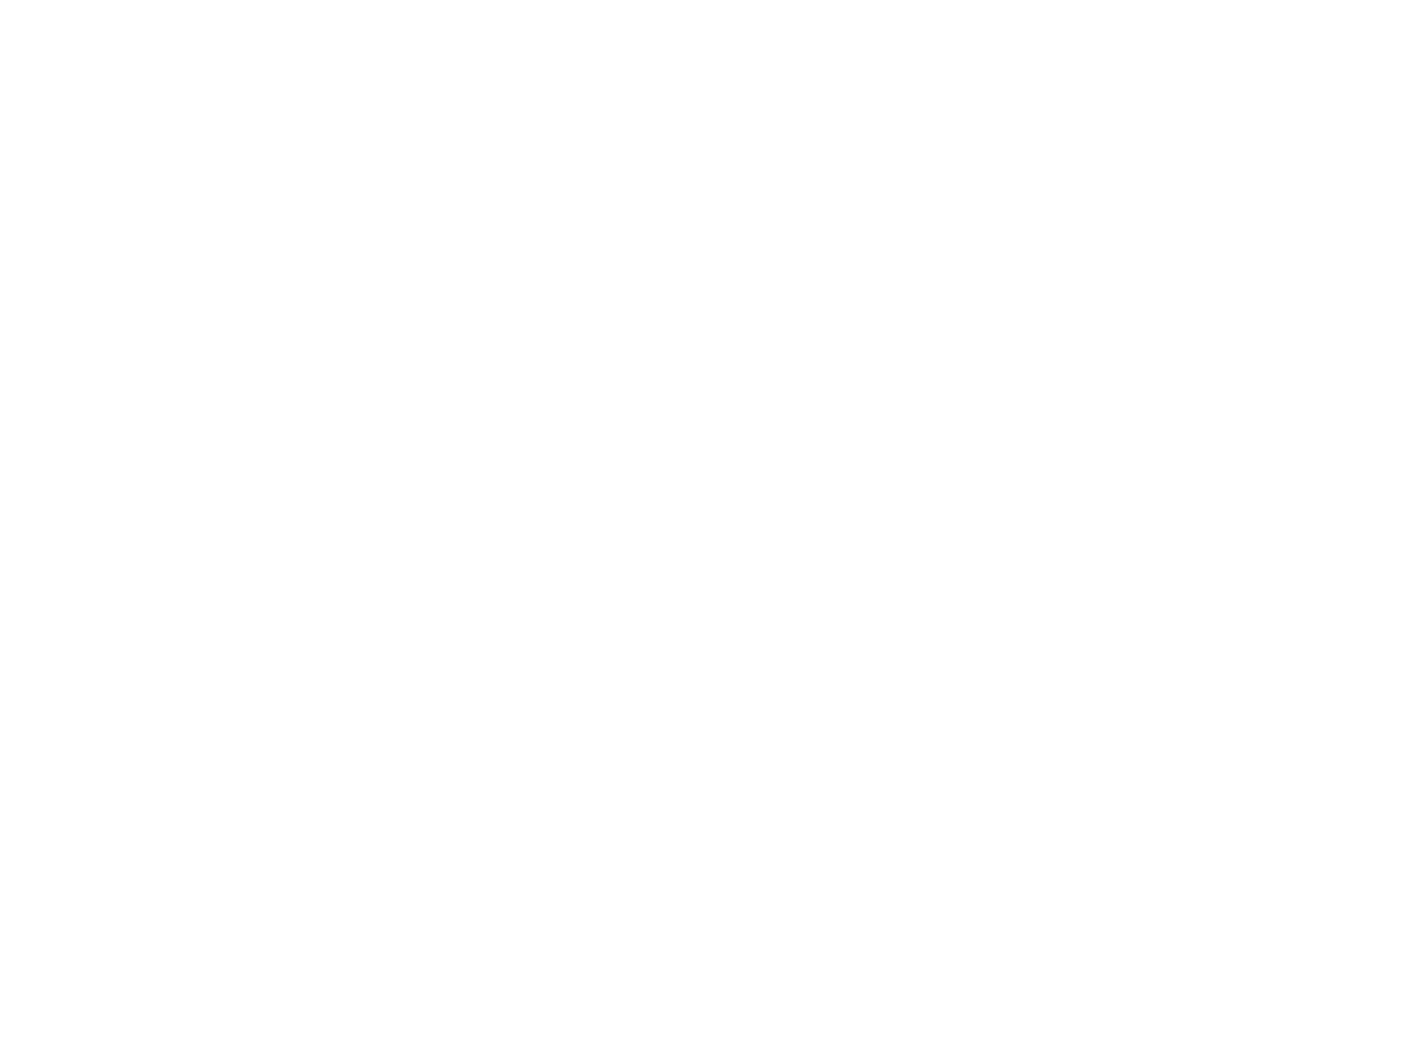

<IPython.core.display.Javascript object>


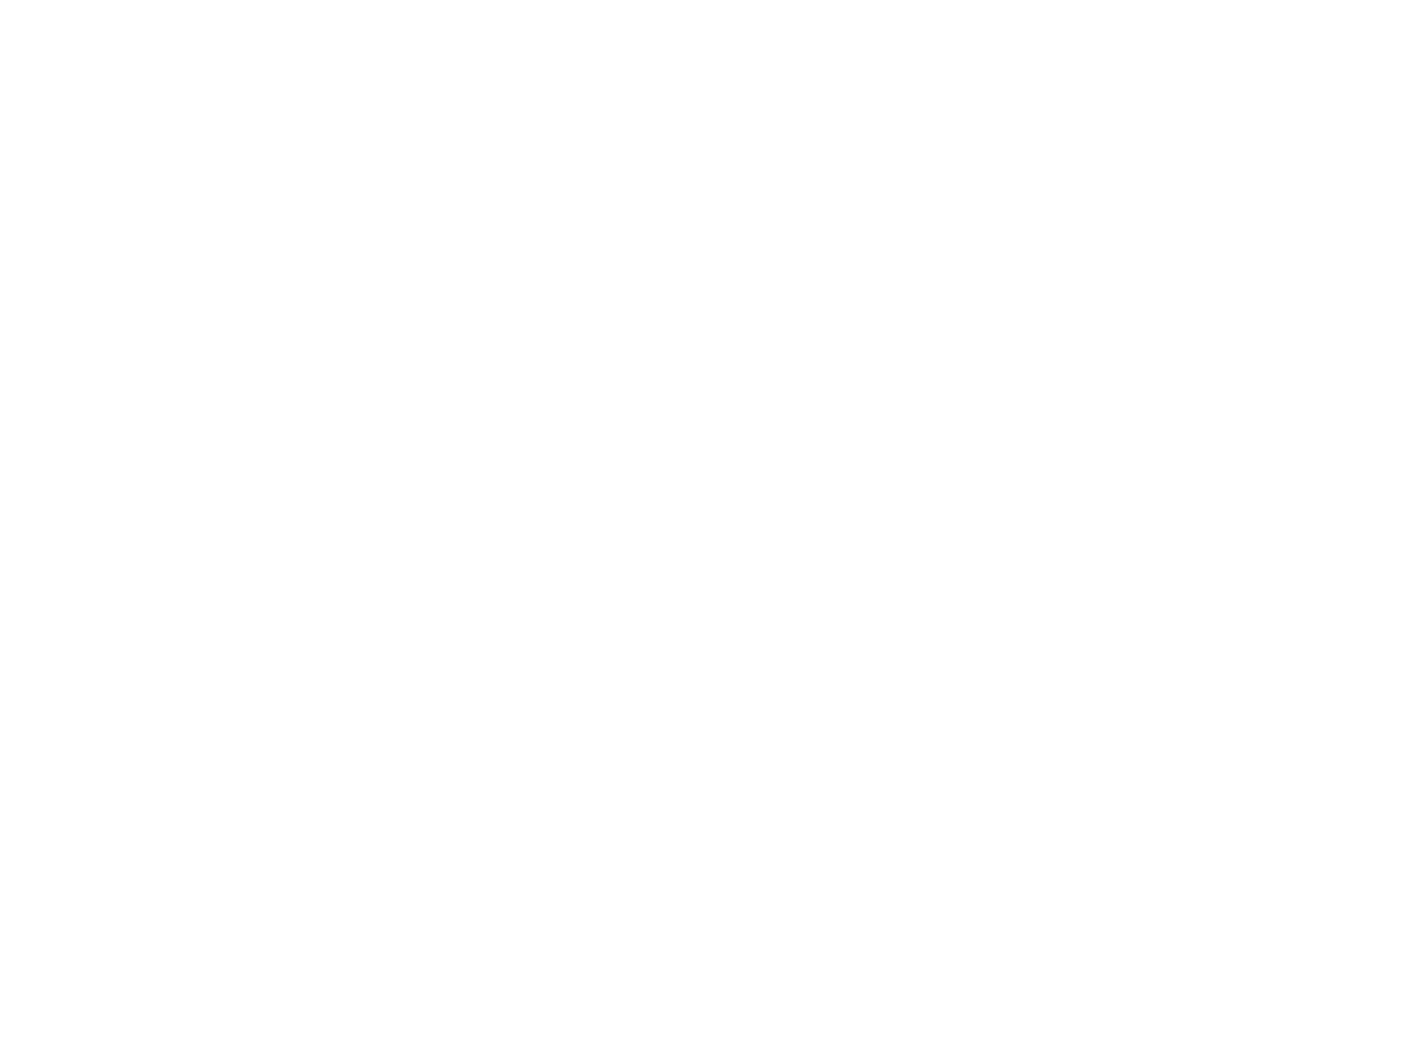

<IPython.core.display.Javascript object>


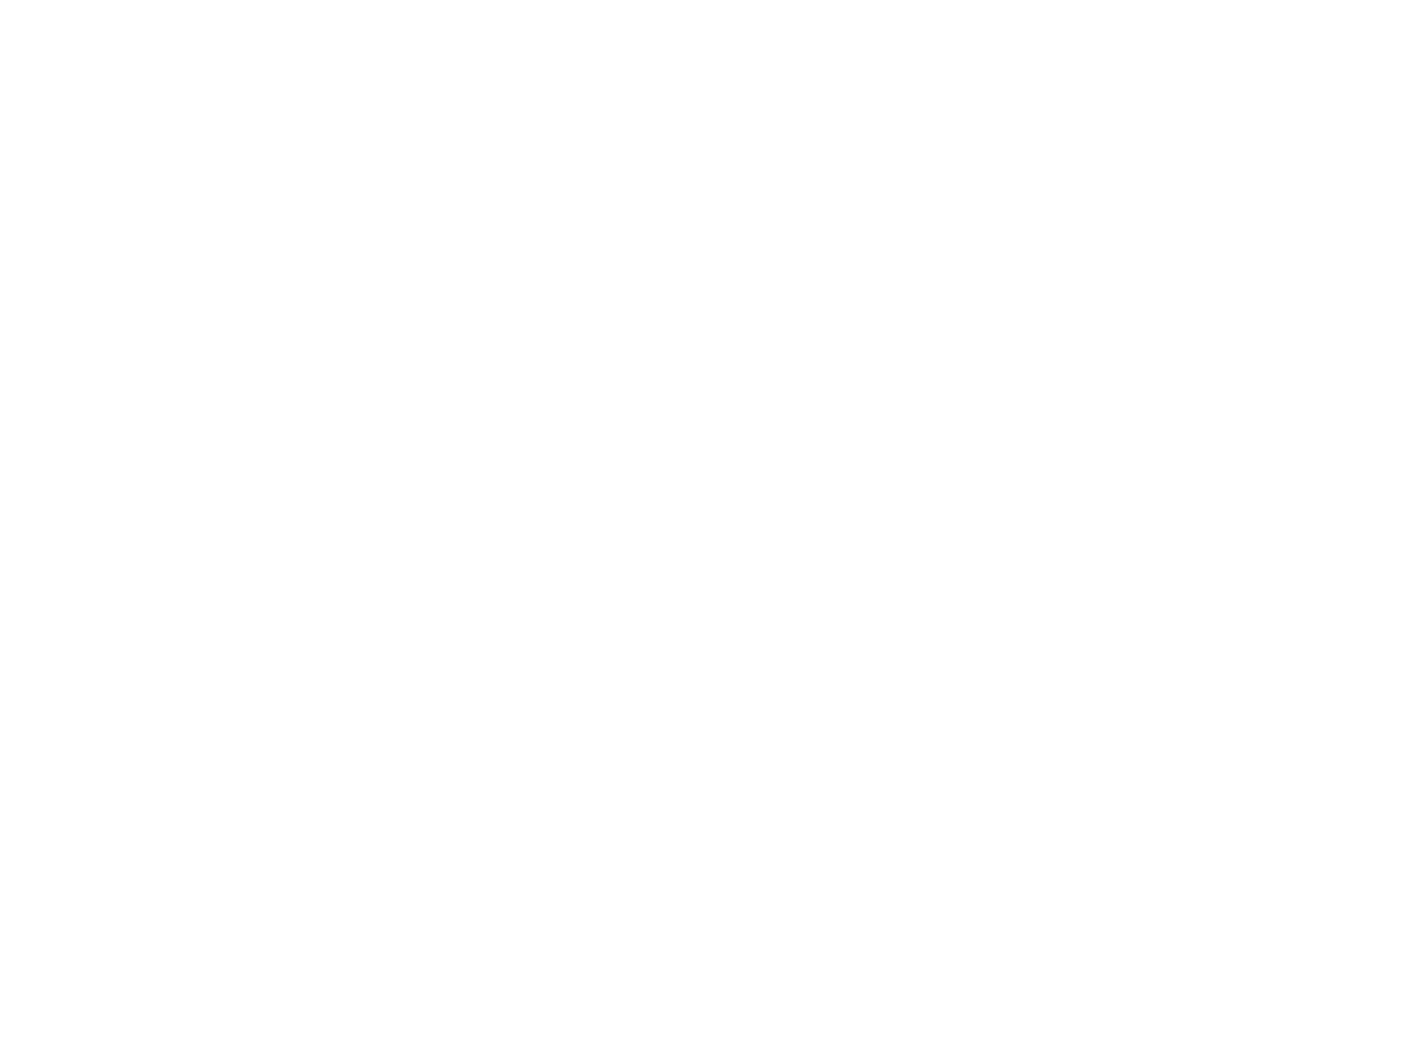

<IPython.core.display.Javascript object>


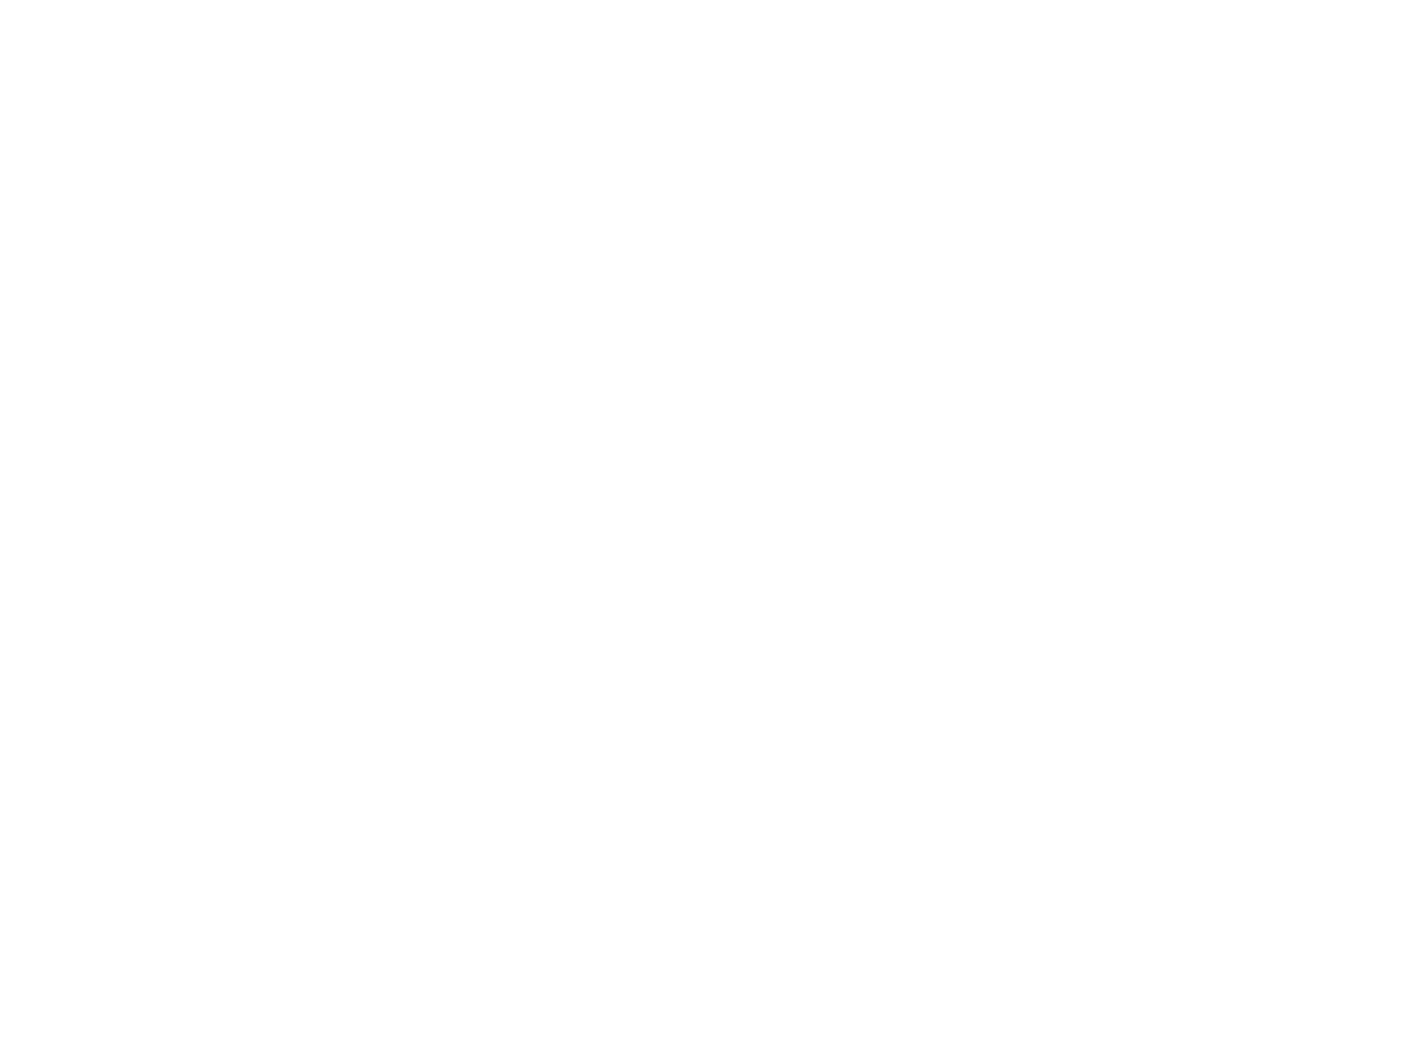

<IPython.core.display.Javascript object>


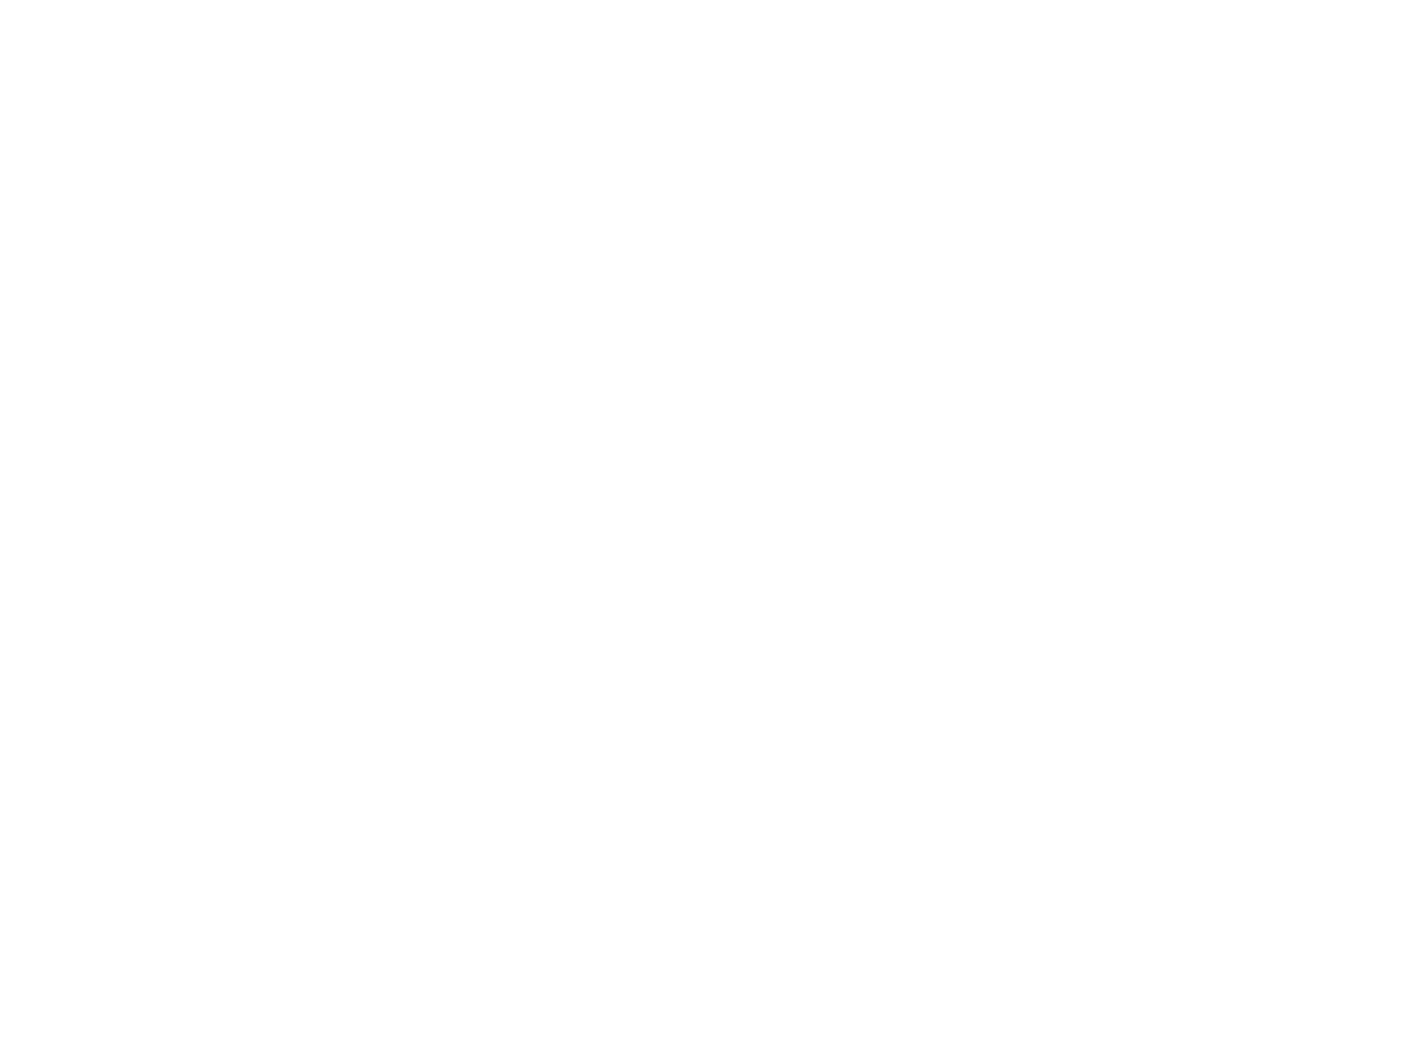

<IPython.core.display.Javascript object>


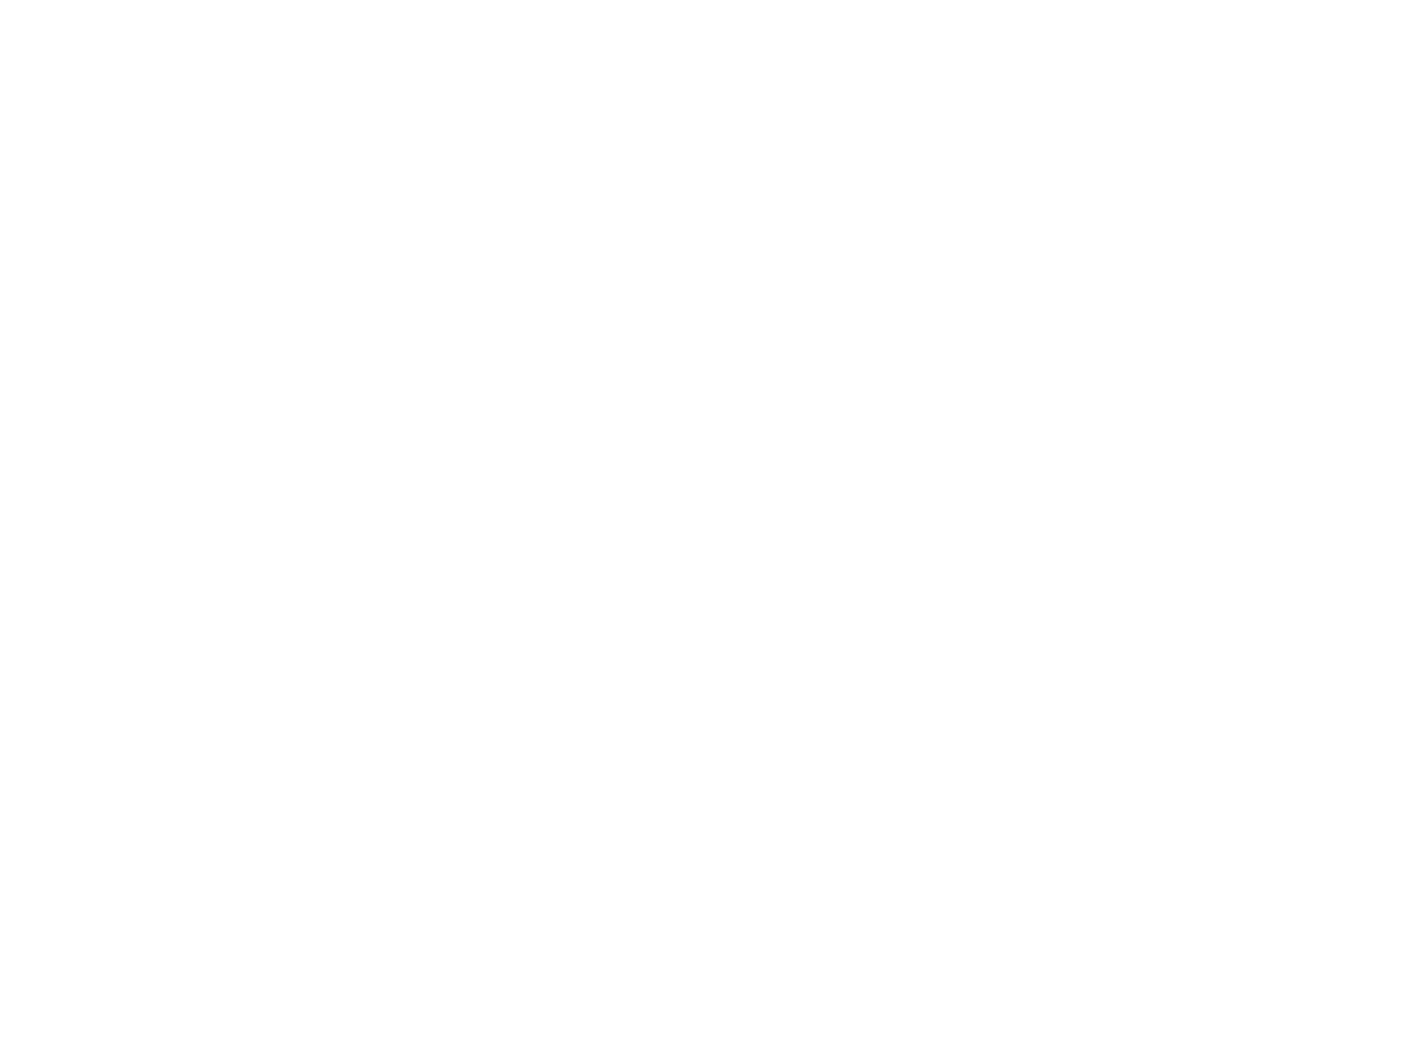

<IPython.core.display.Javascript object>


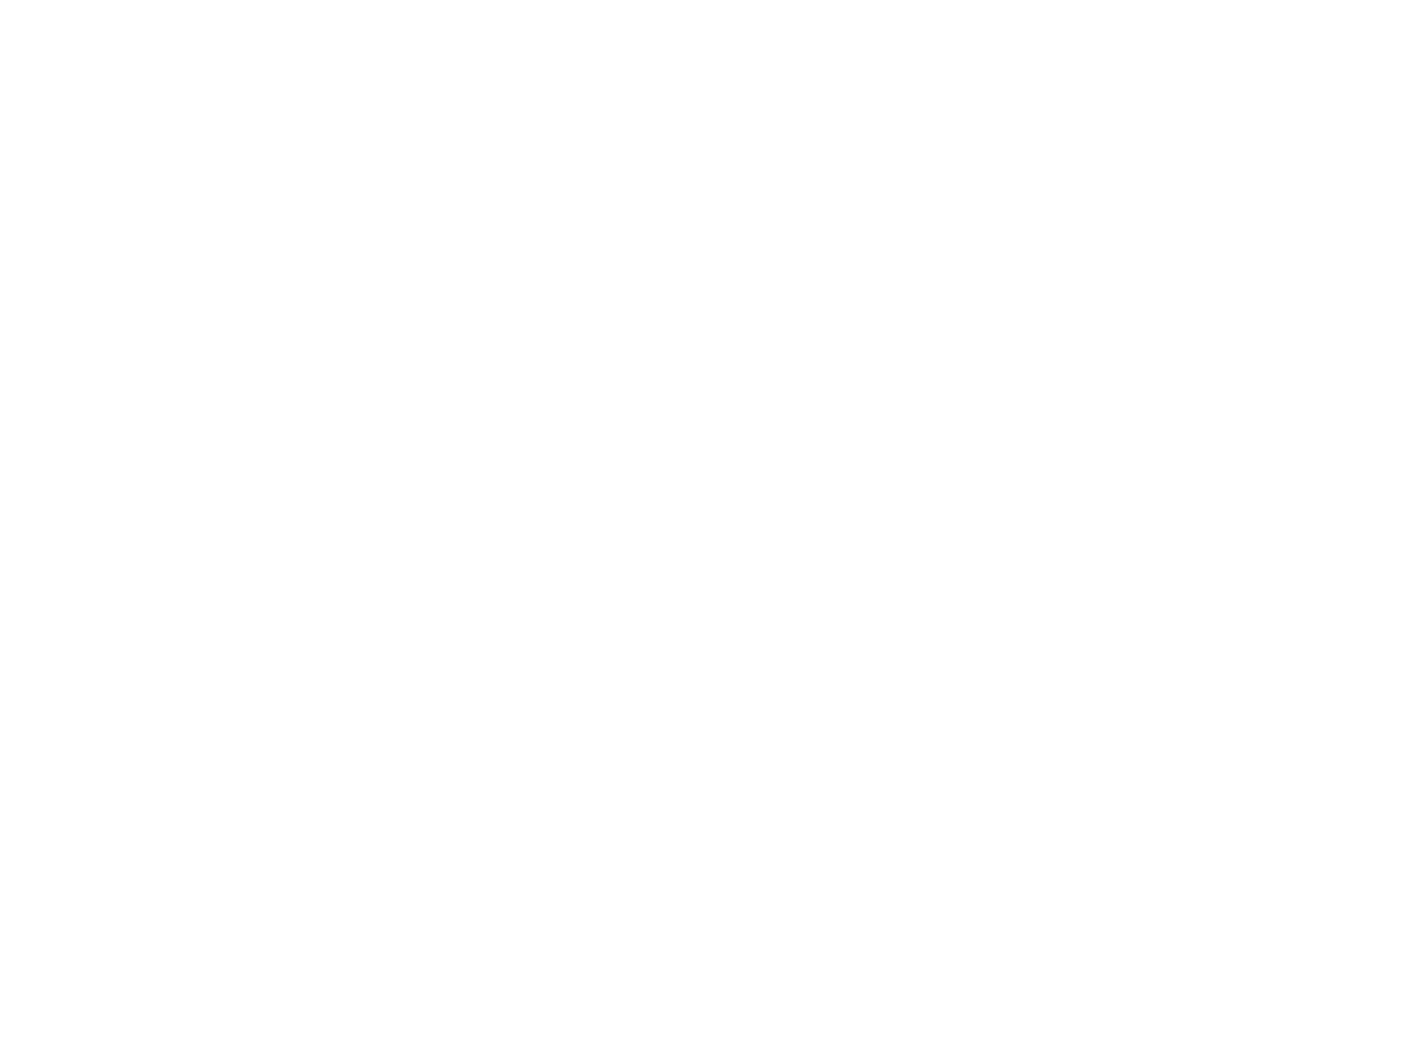

<IPython.core.display.Javascript object>


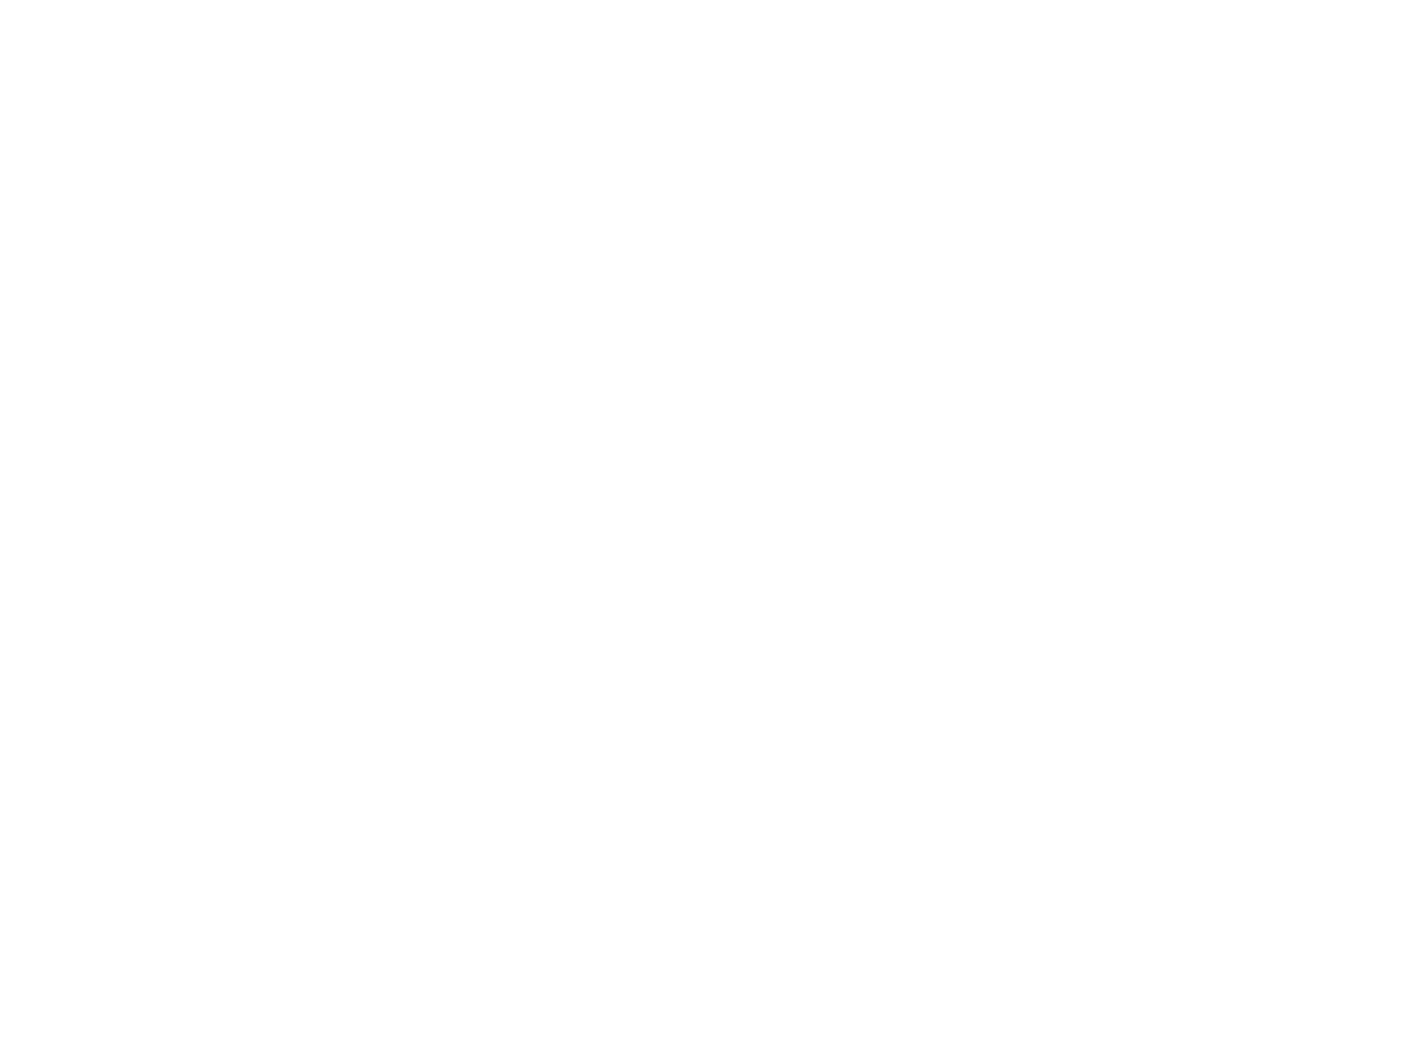

<IPython.core.display.Javascript object>


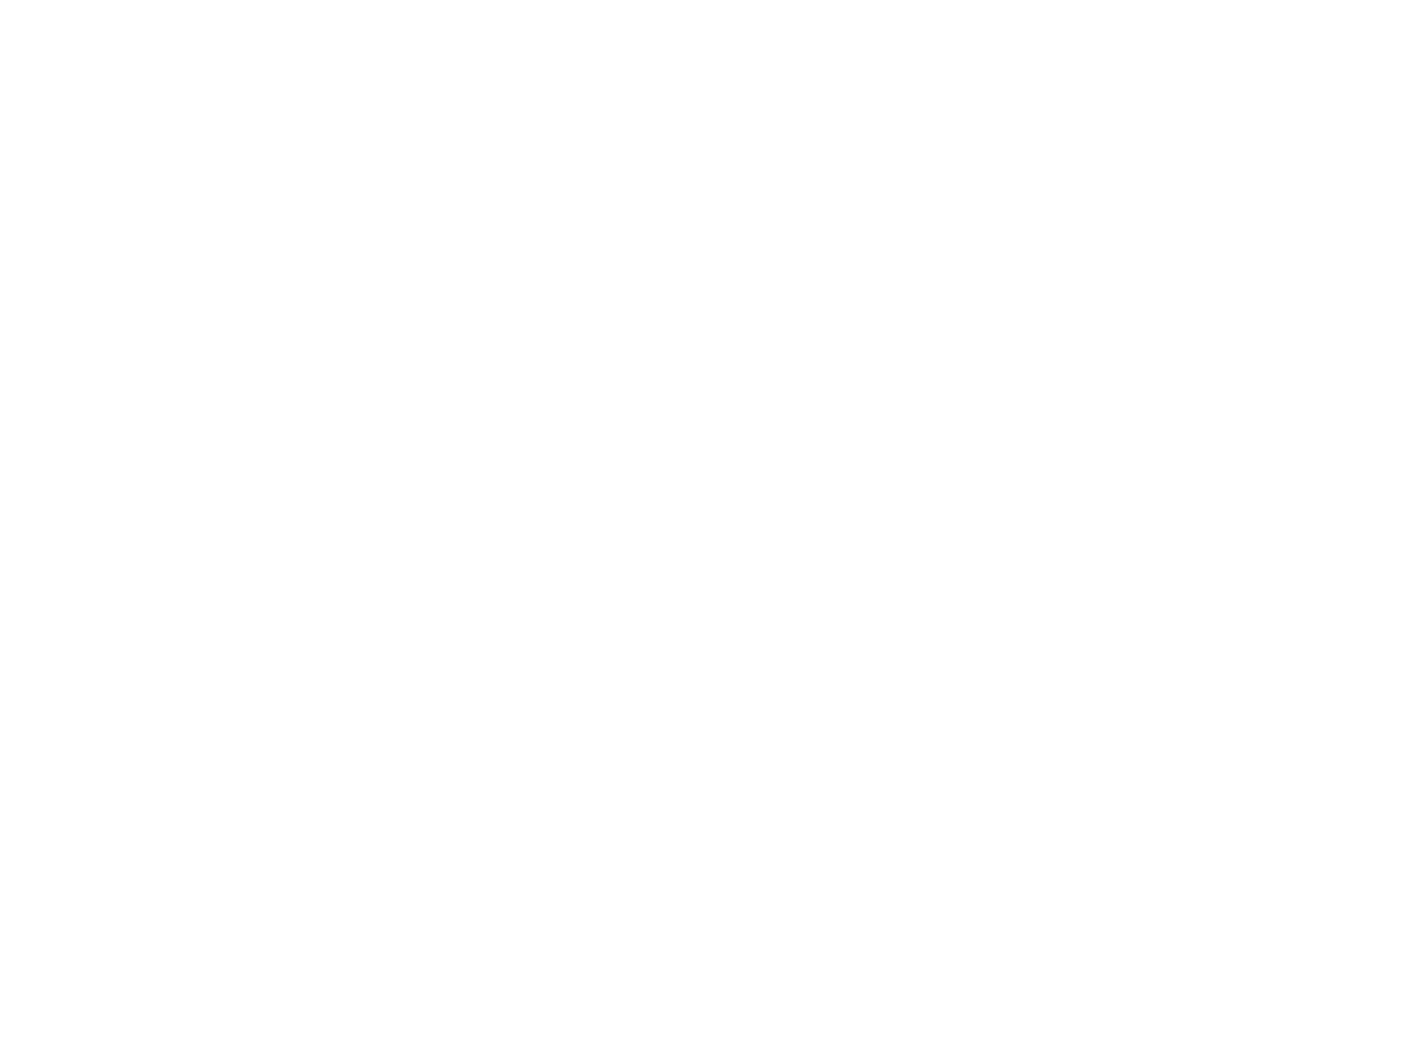

<IPython.core.display.Javascript object>


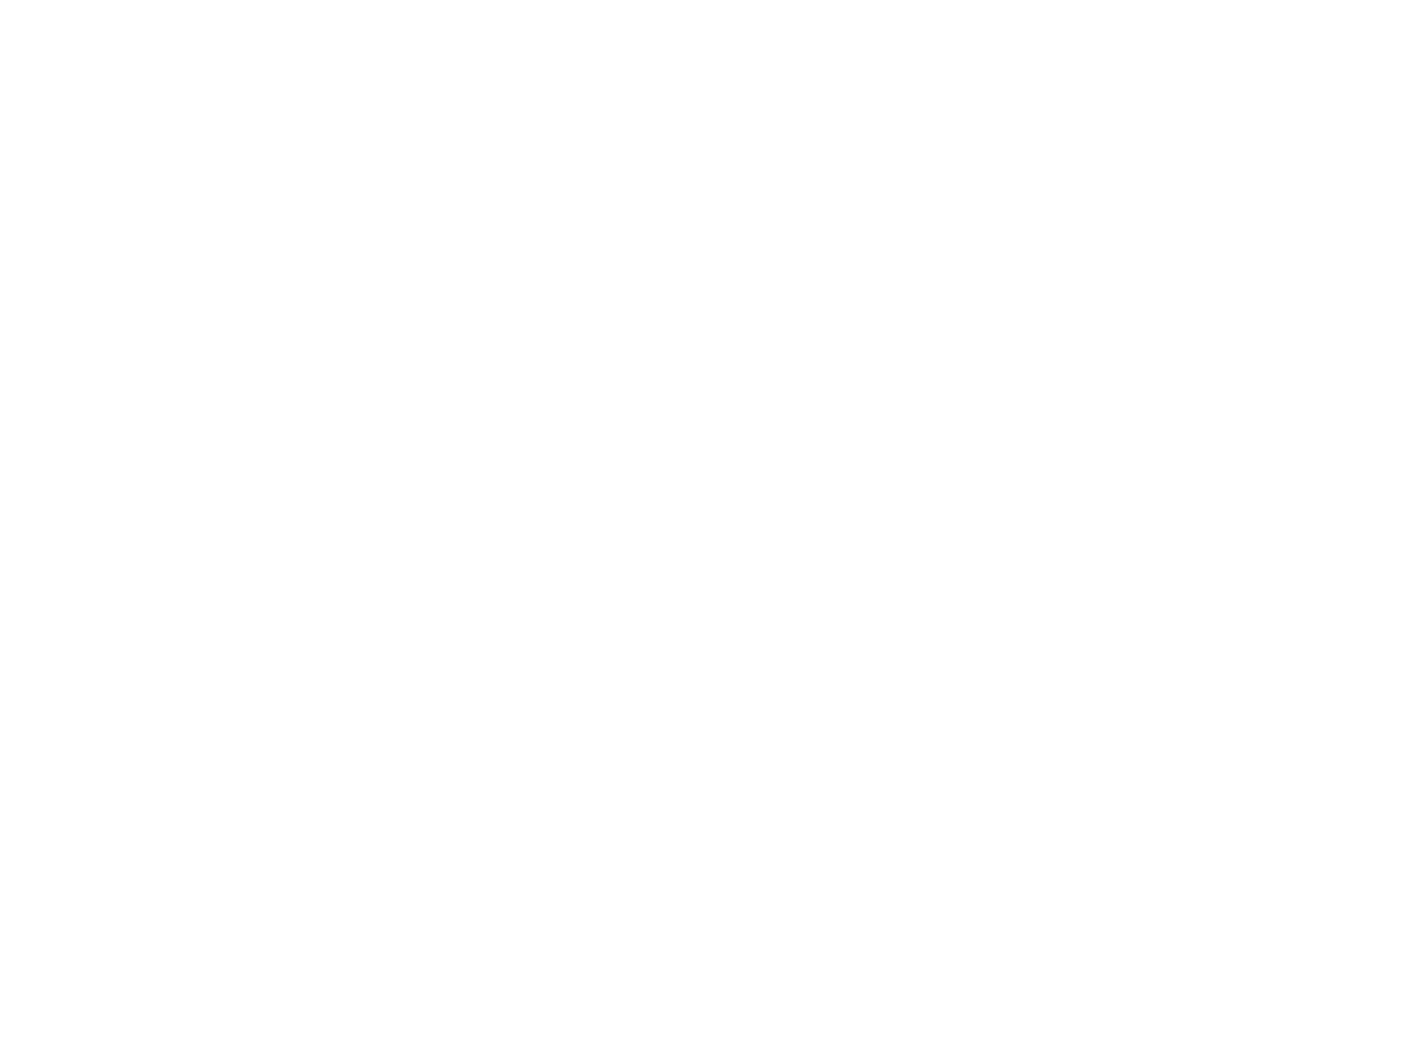

<IPython.core.display.Javascript object>


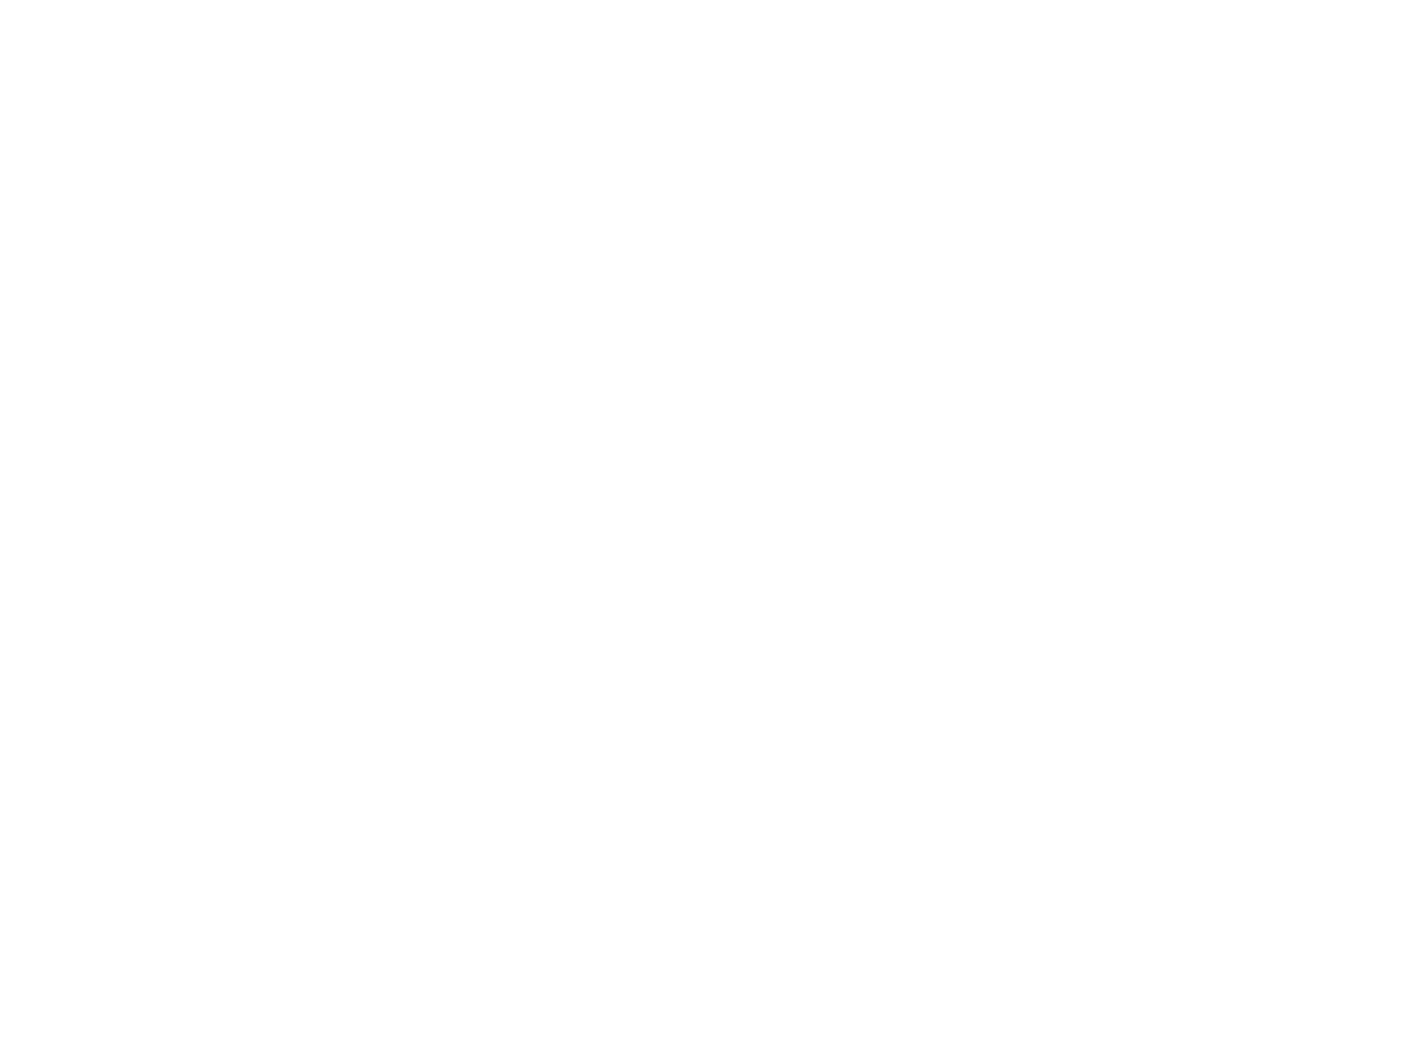

<IPython.core.display.Javascript object>


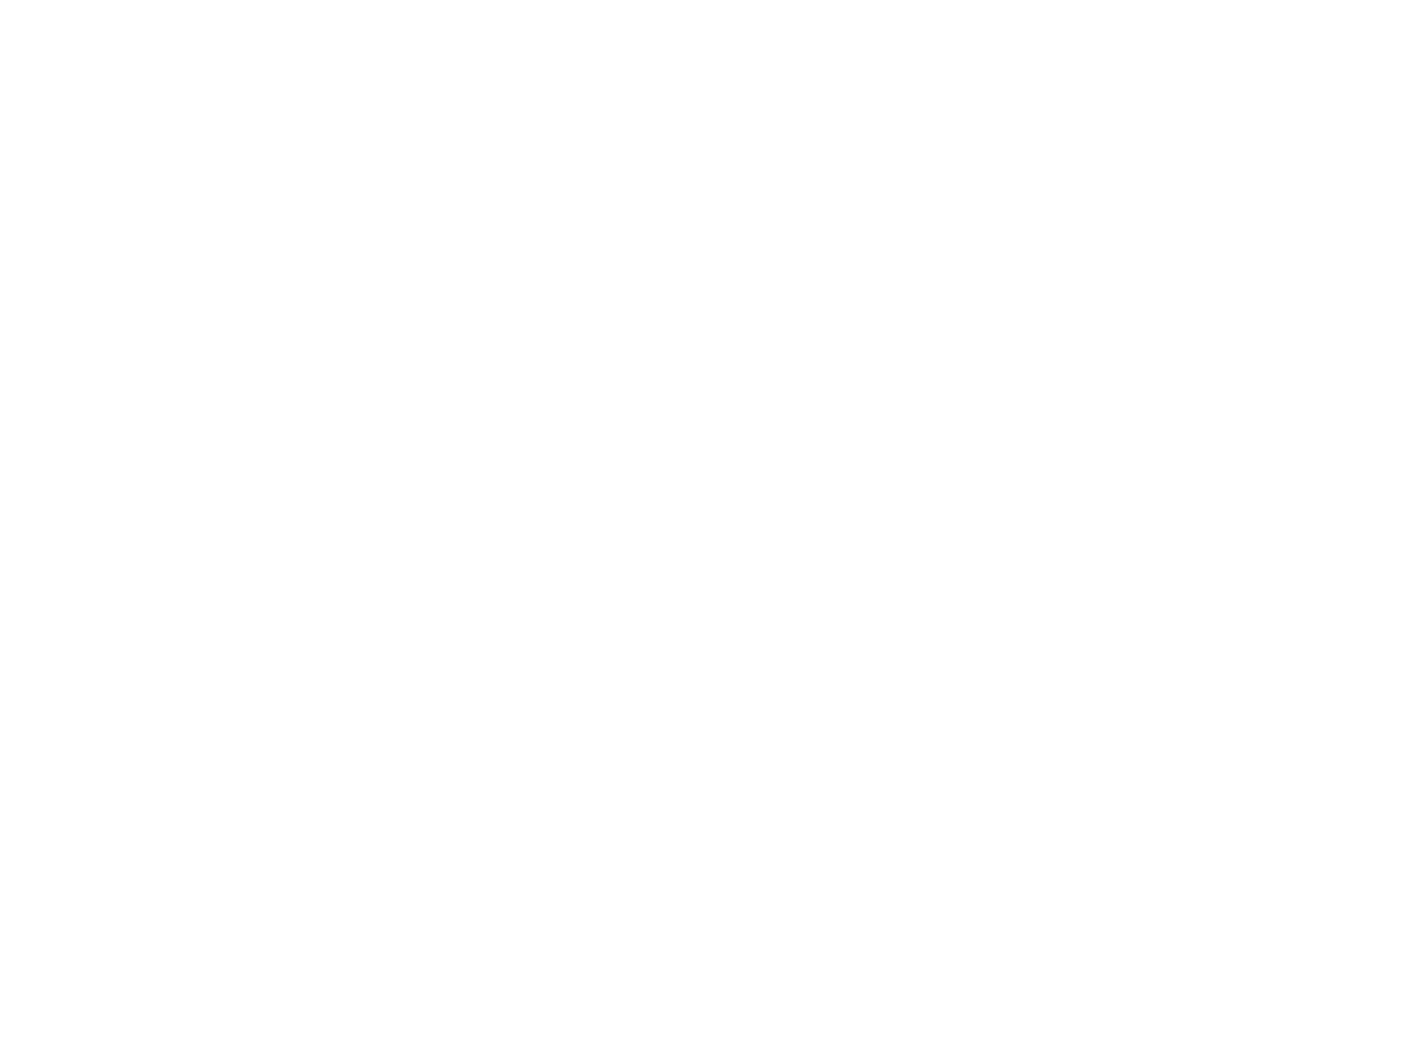

<IPython.core.display.Javascript object>


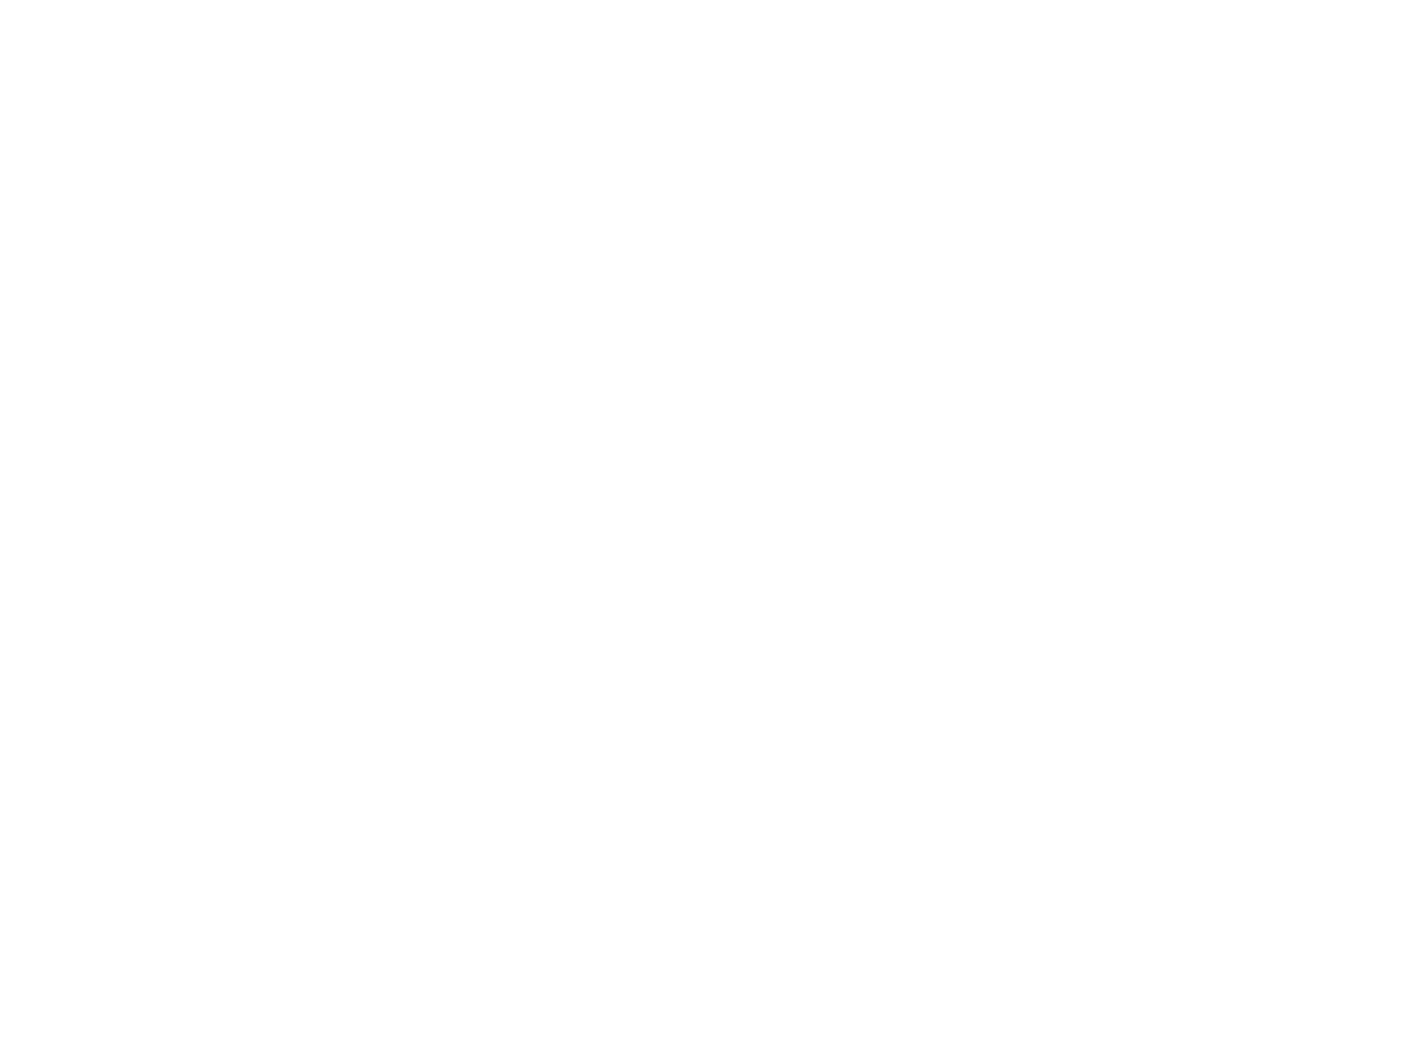

<IPython.core.display.Javascript object>


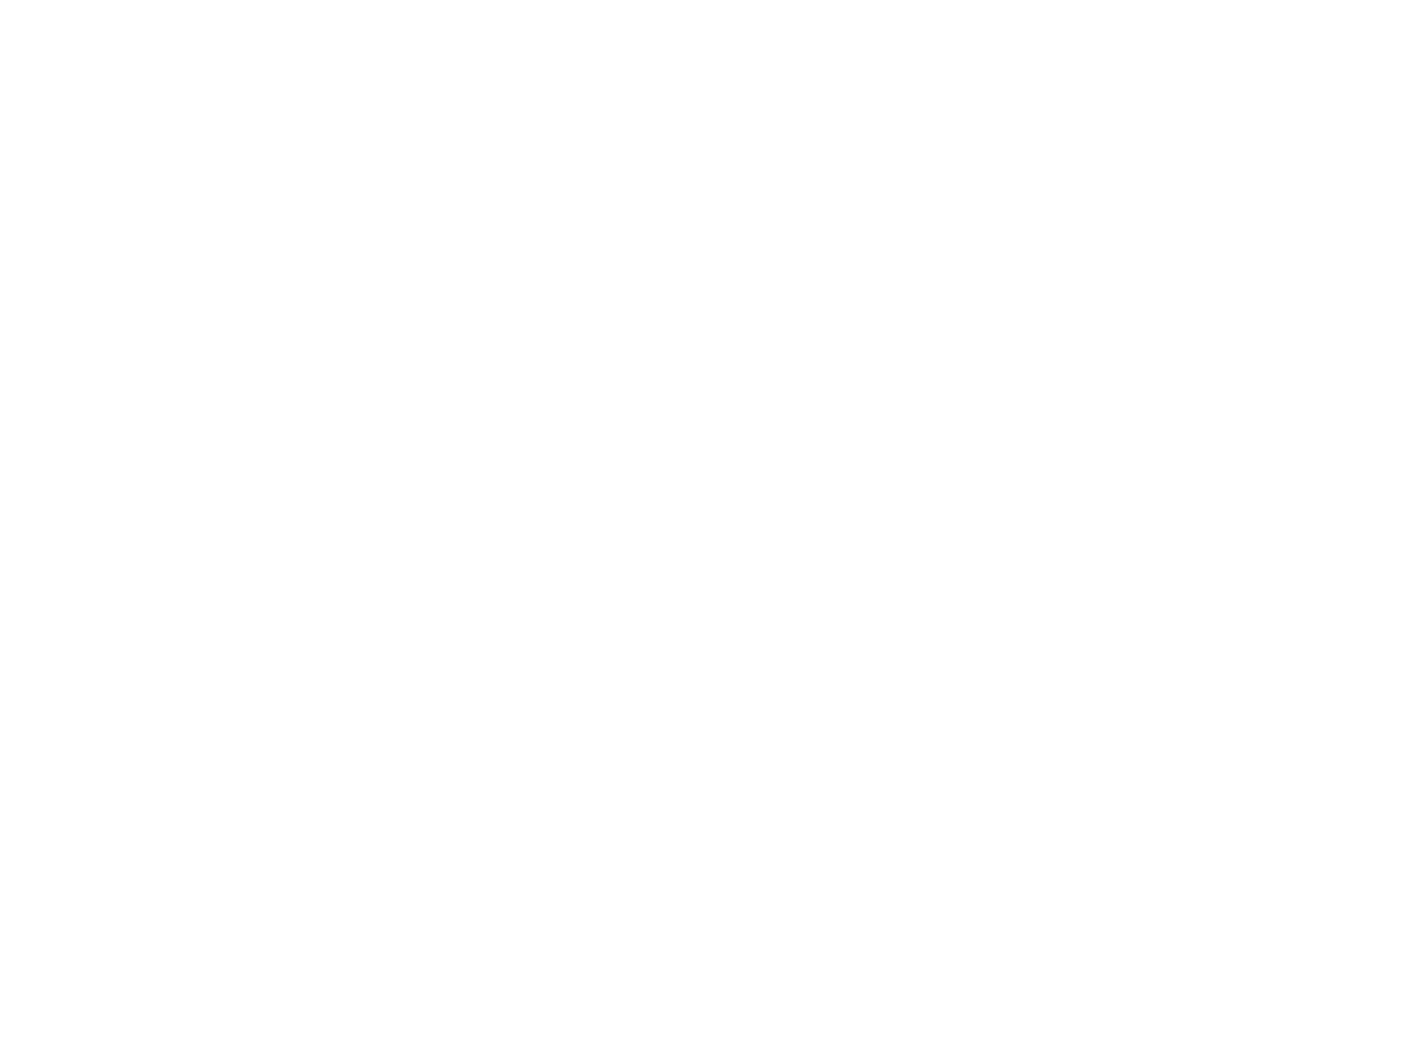

<IPython.core.display.Javascript object>


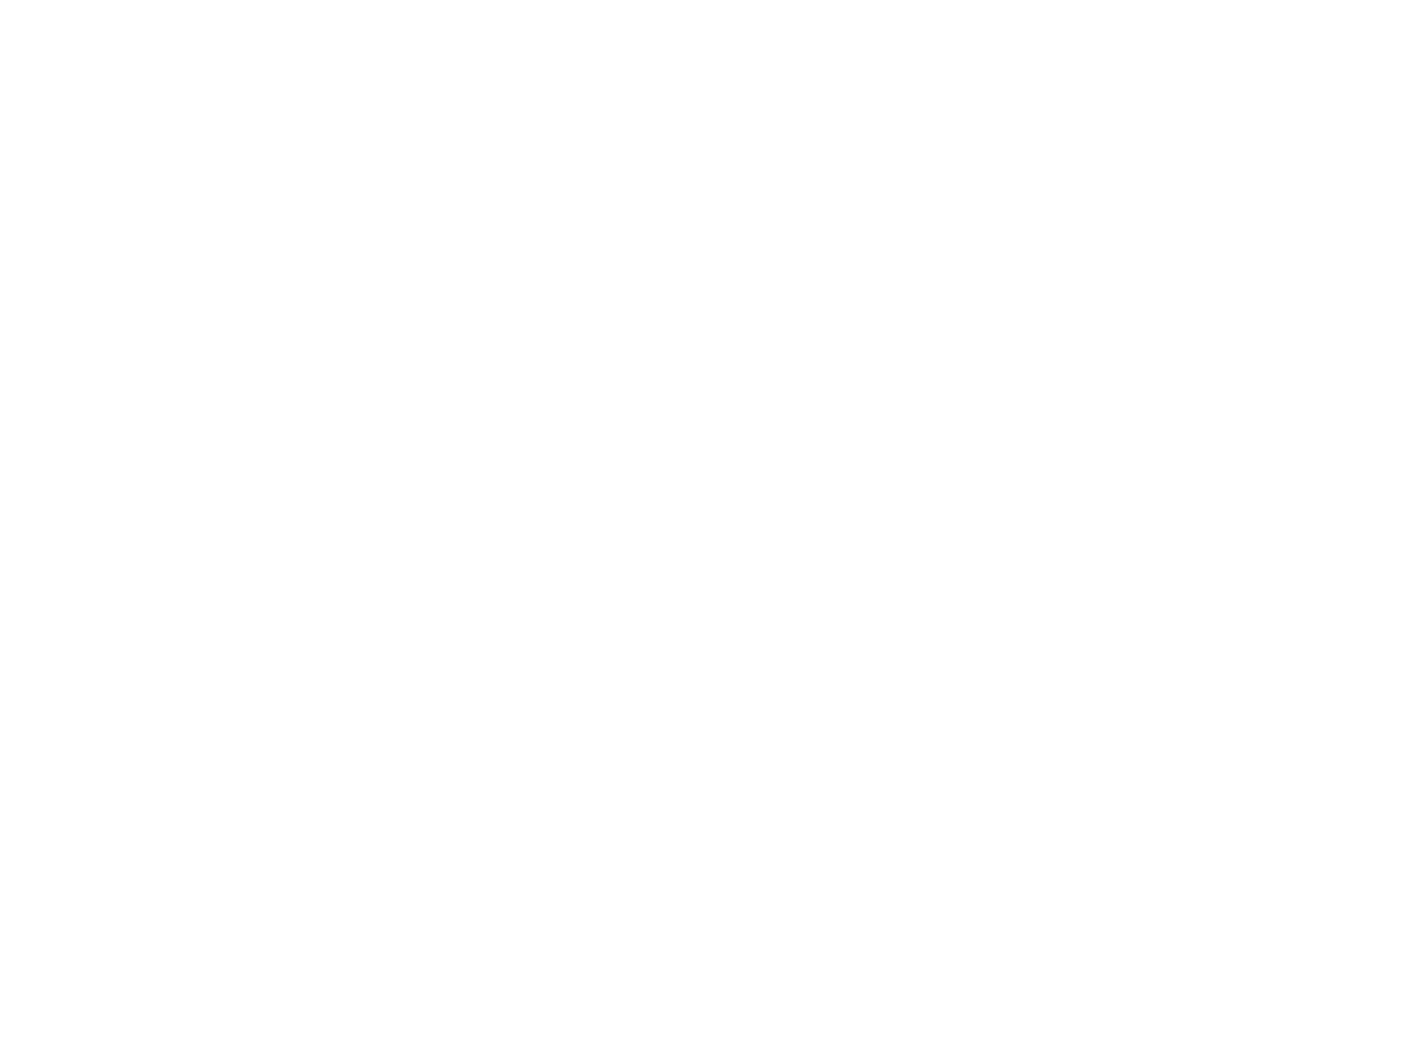

<IPython.core.display.Javascript object>


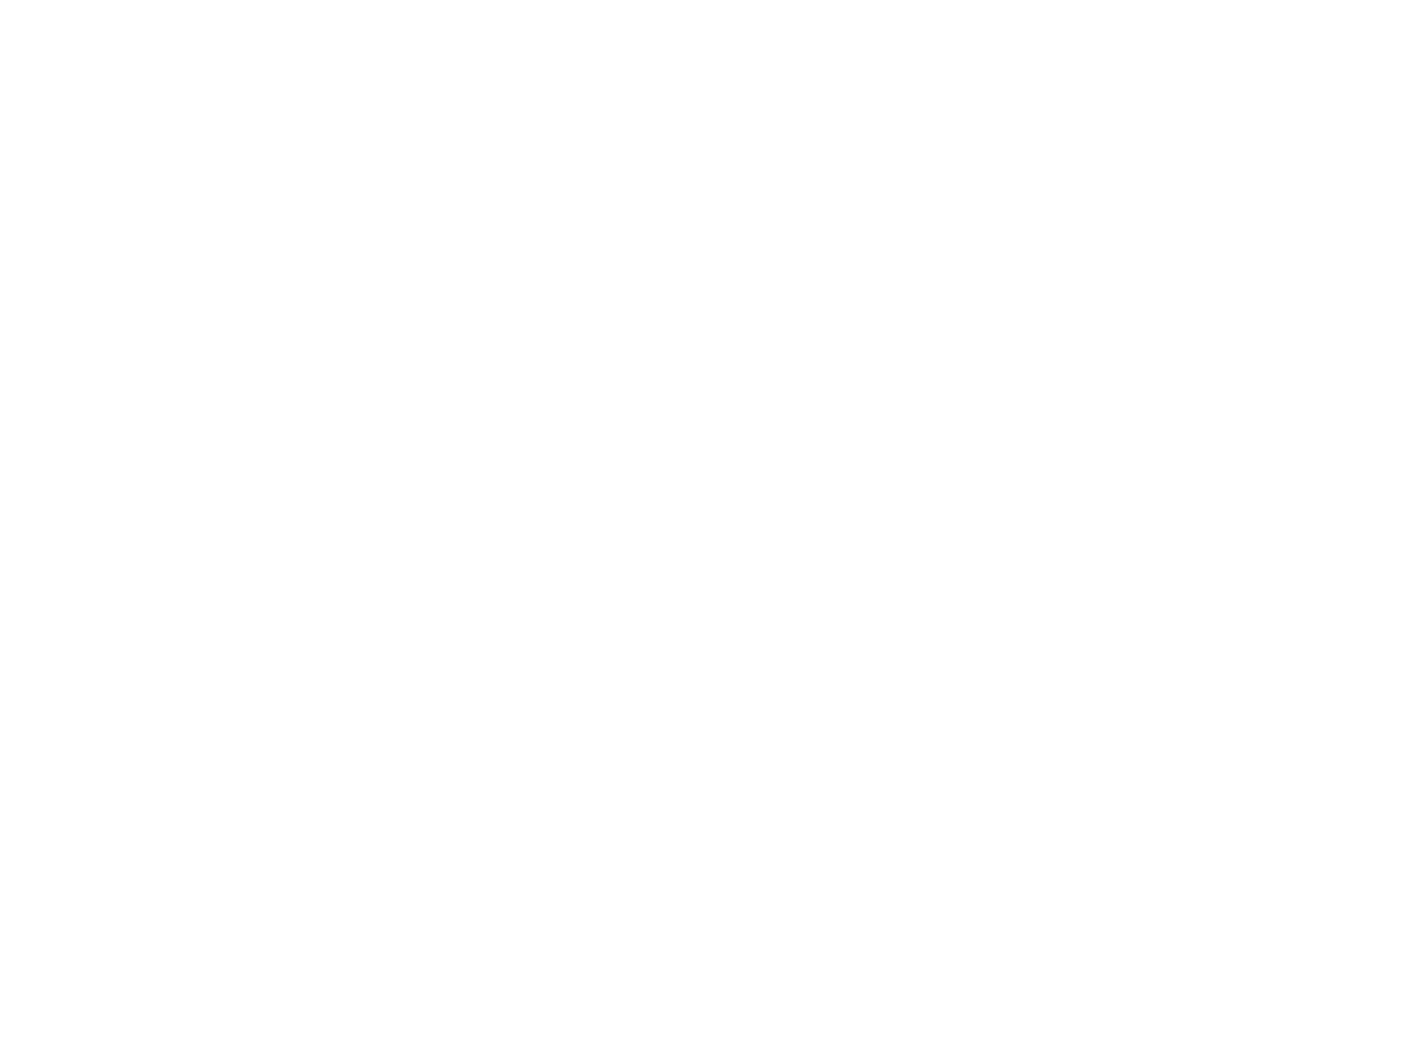

<IPython.core.display.Javascript object>


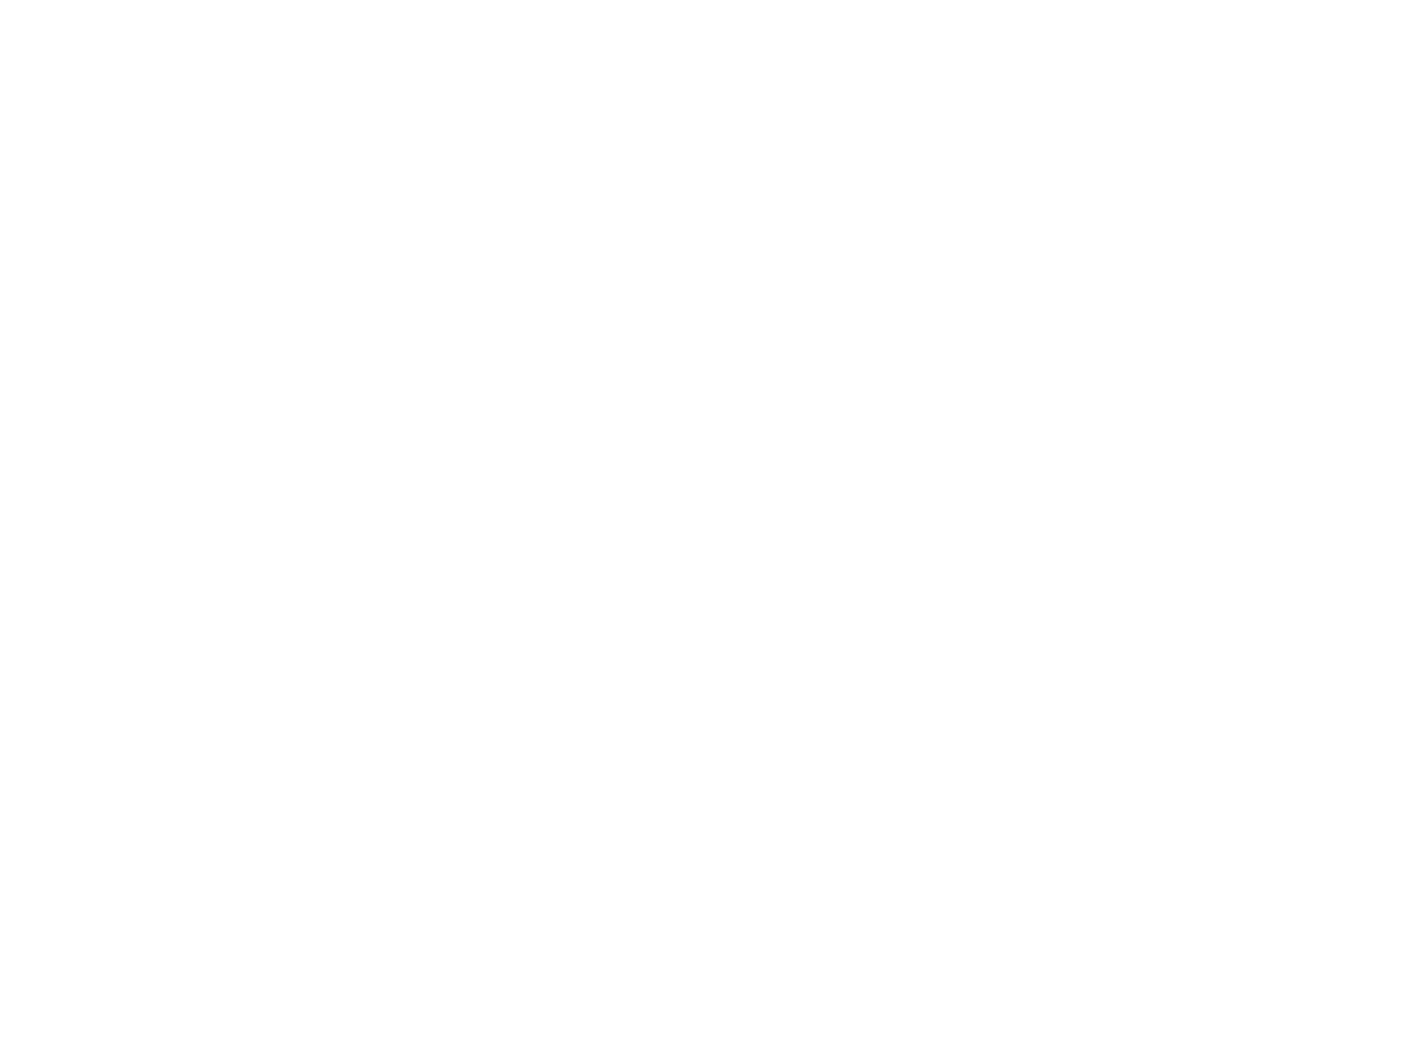

<IPython.core.display.Javascript object>


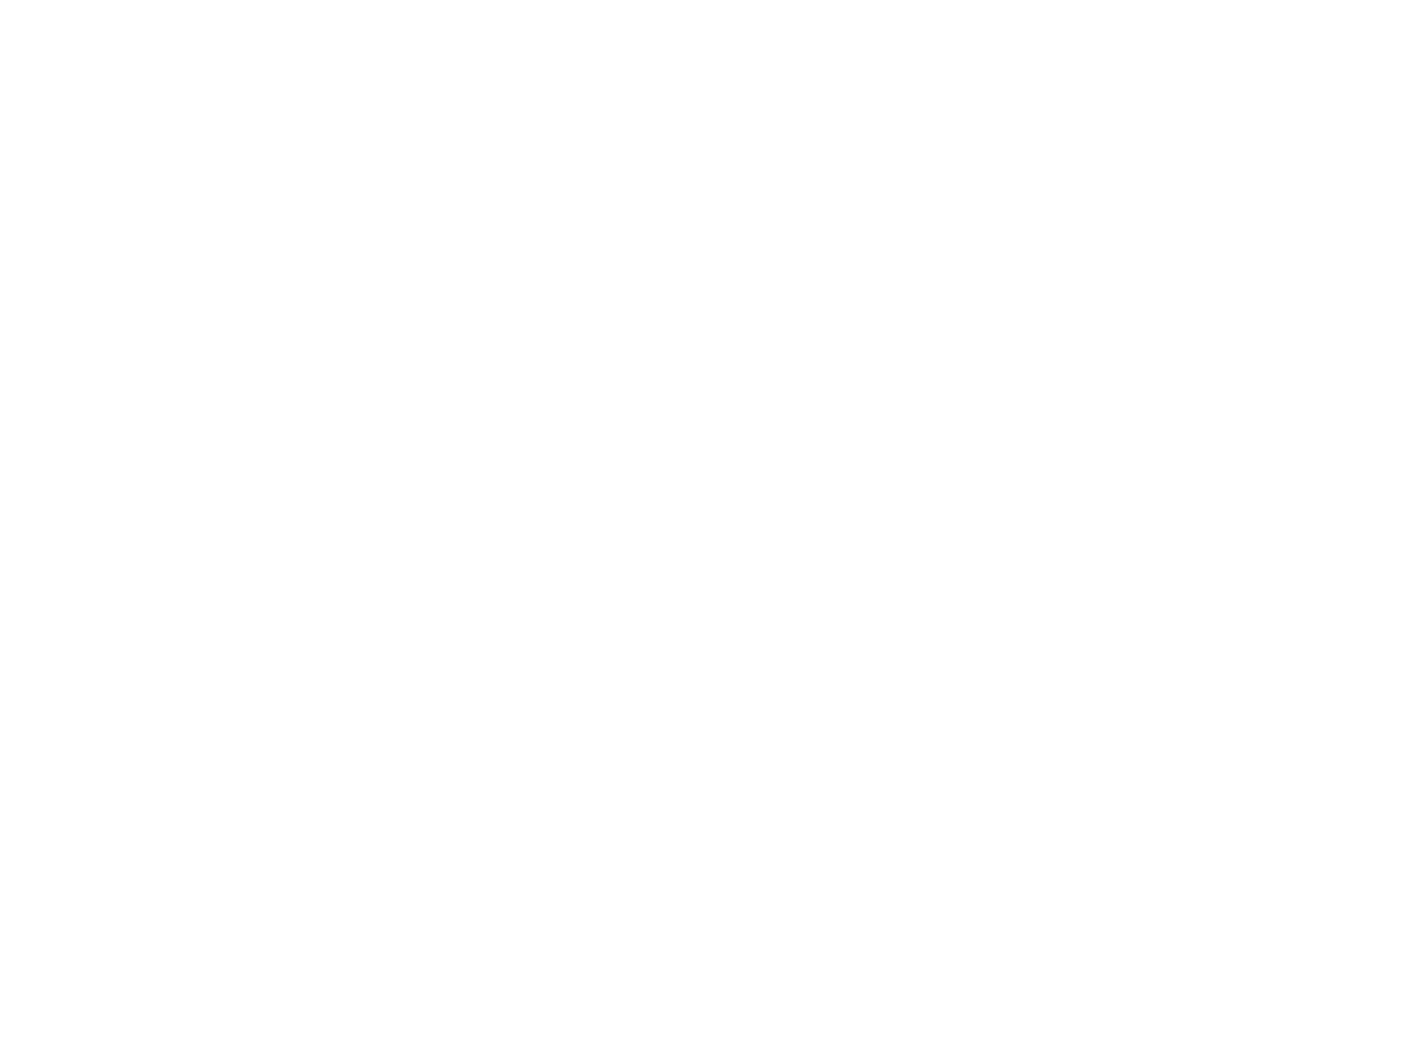

<IPython.core.display.Javascript object>


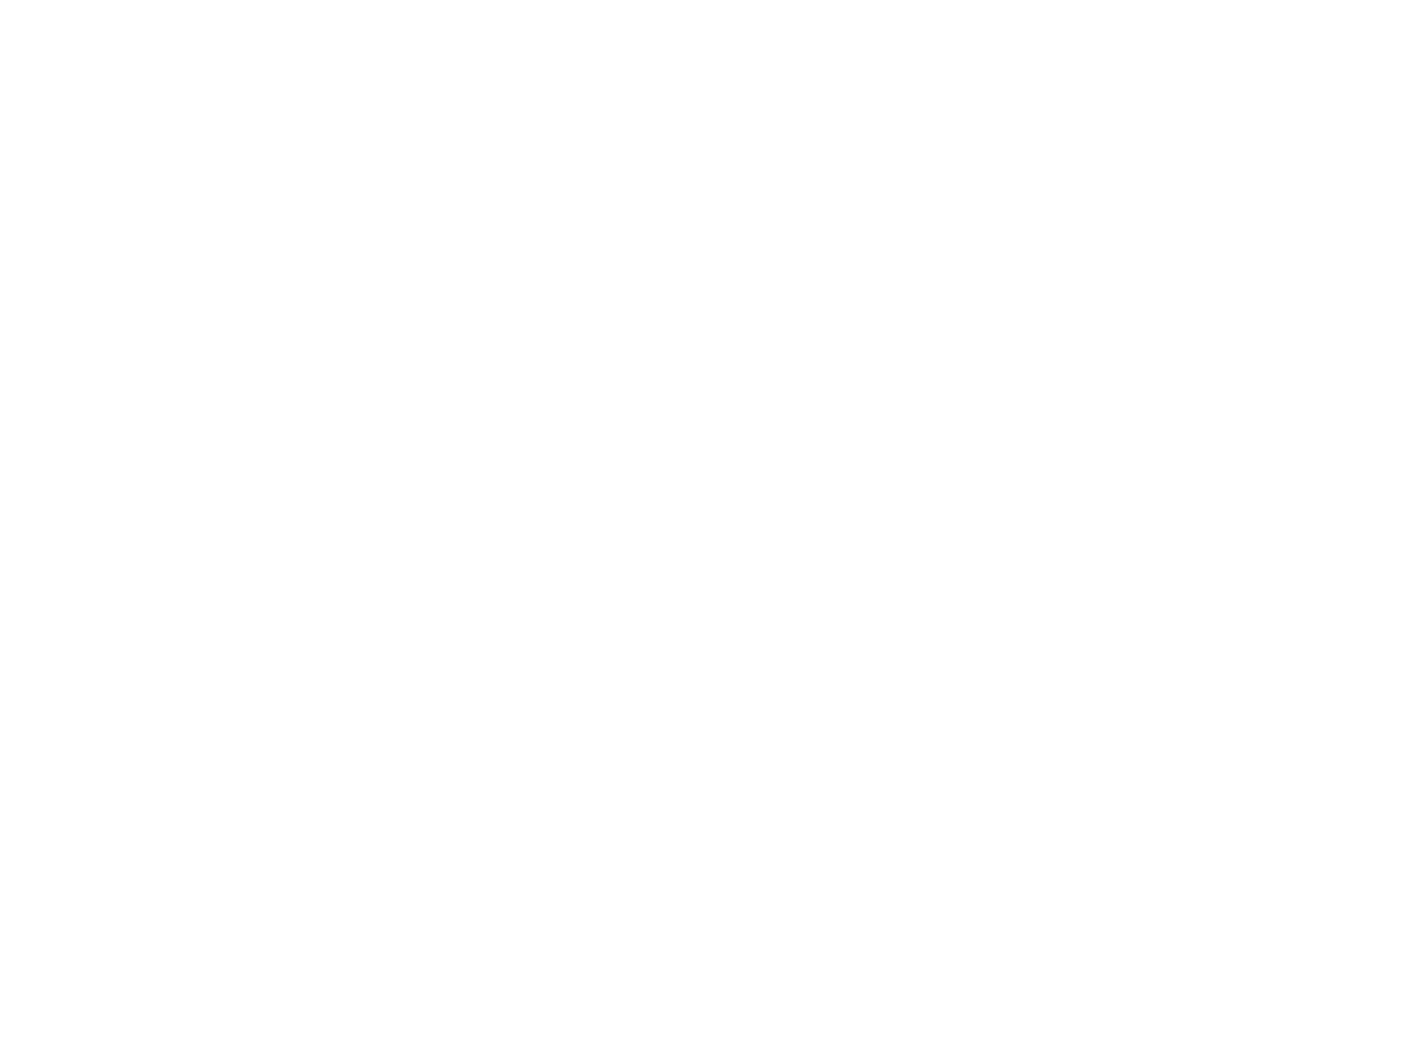

<IPython.core.display.Javascript object>


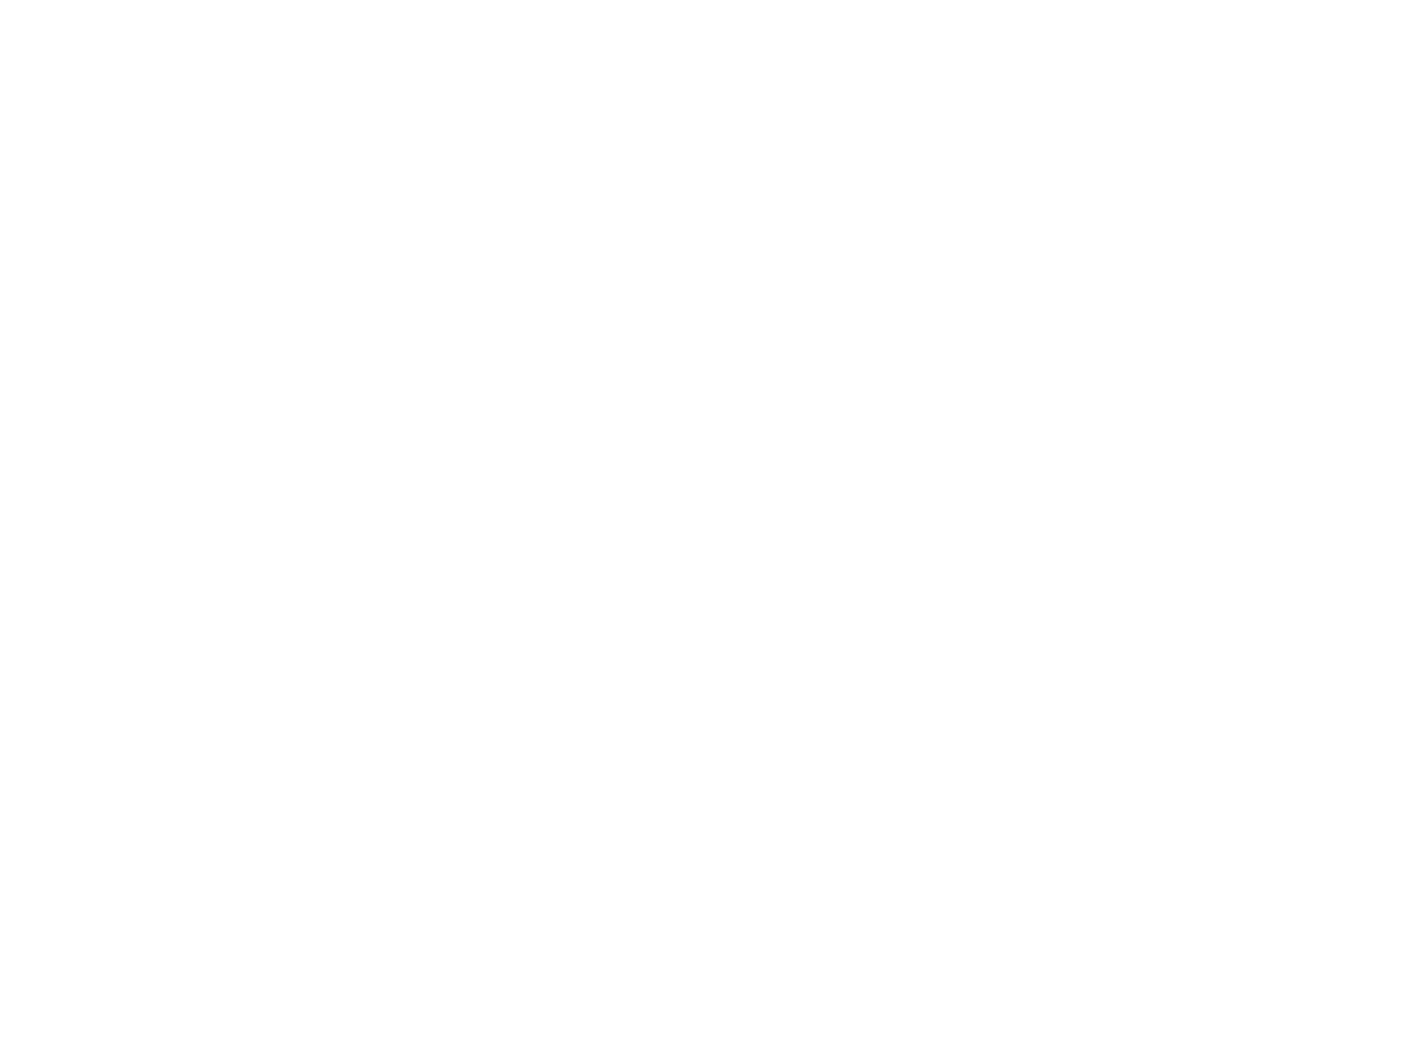

In [82]:
#plotting histograms of variance per ROI
tc_var_full = np.zeros(nonzerovar_mask.shape)
tc_var = timecourse.var(-1)
tc_var_full[nonzerovar_mask]= tc_var
for roi in idx_rois:
    pl.figure()
    pl.title(roi)
    pl.hist(tc_var_full[idx_rois[roi]],bins=100)
    pl.show()
    pl.close()

<IPython.core.display.Javascript object>


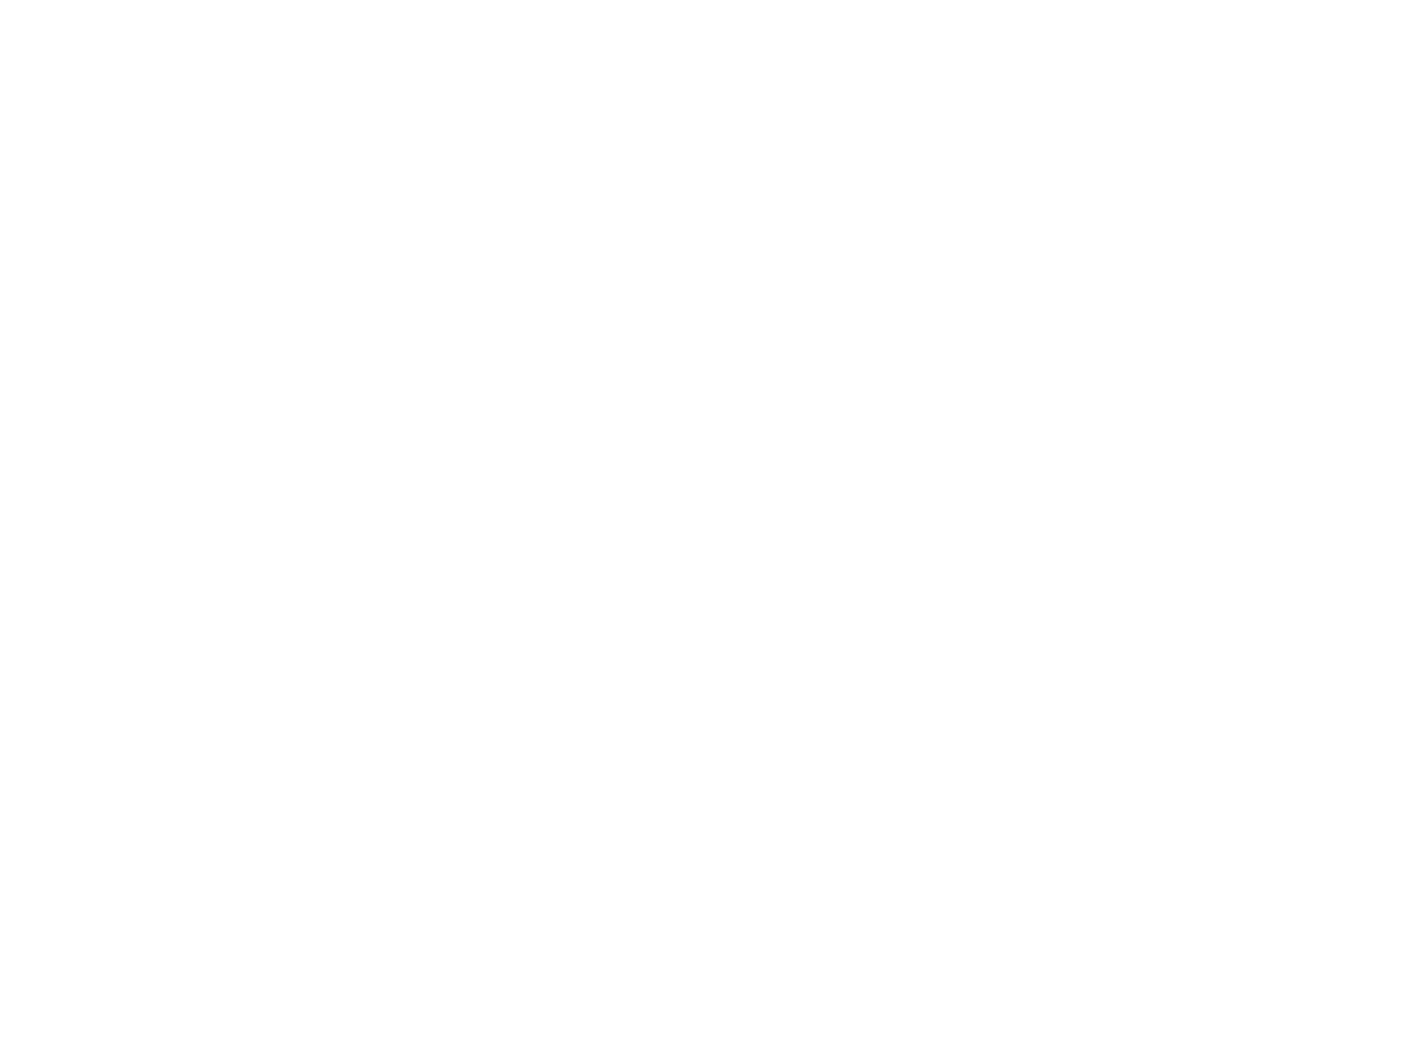

<IPython.core.display.Javascript object>


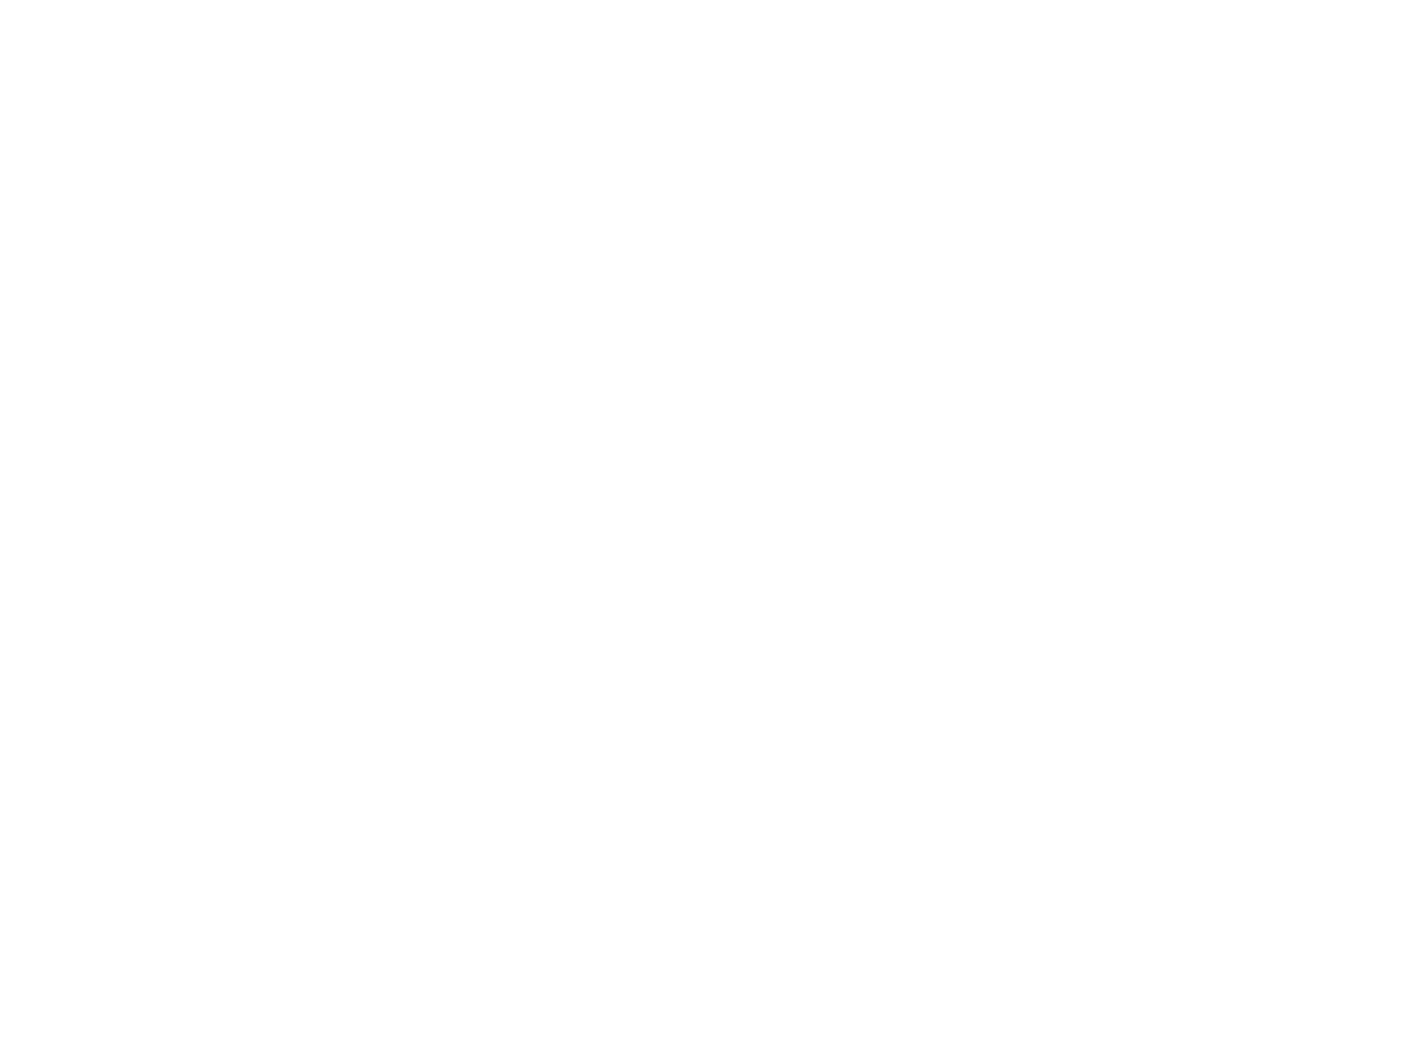

<IPython.core.display.Javascript object>


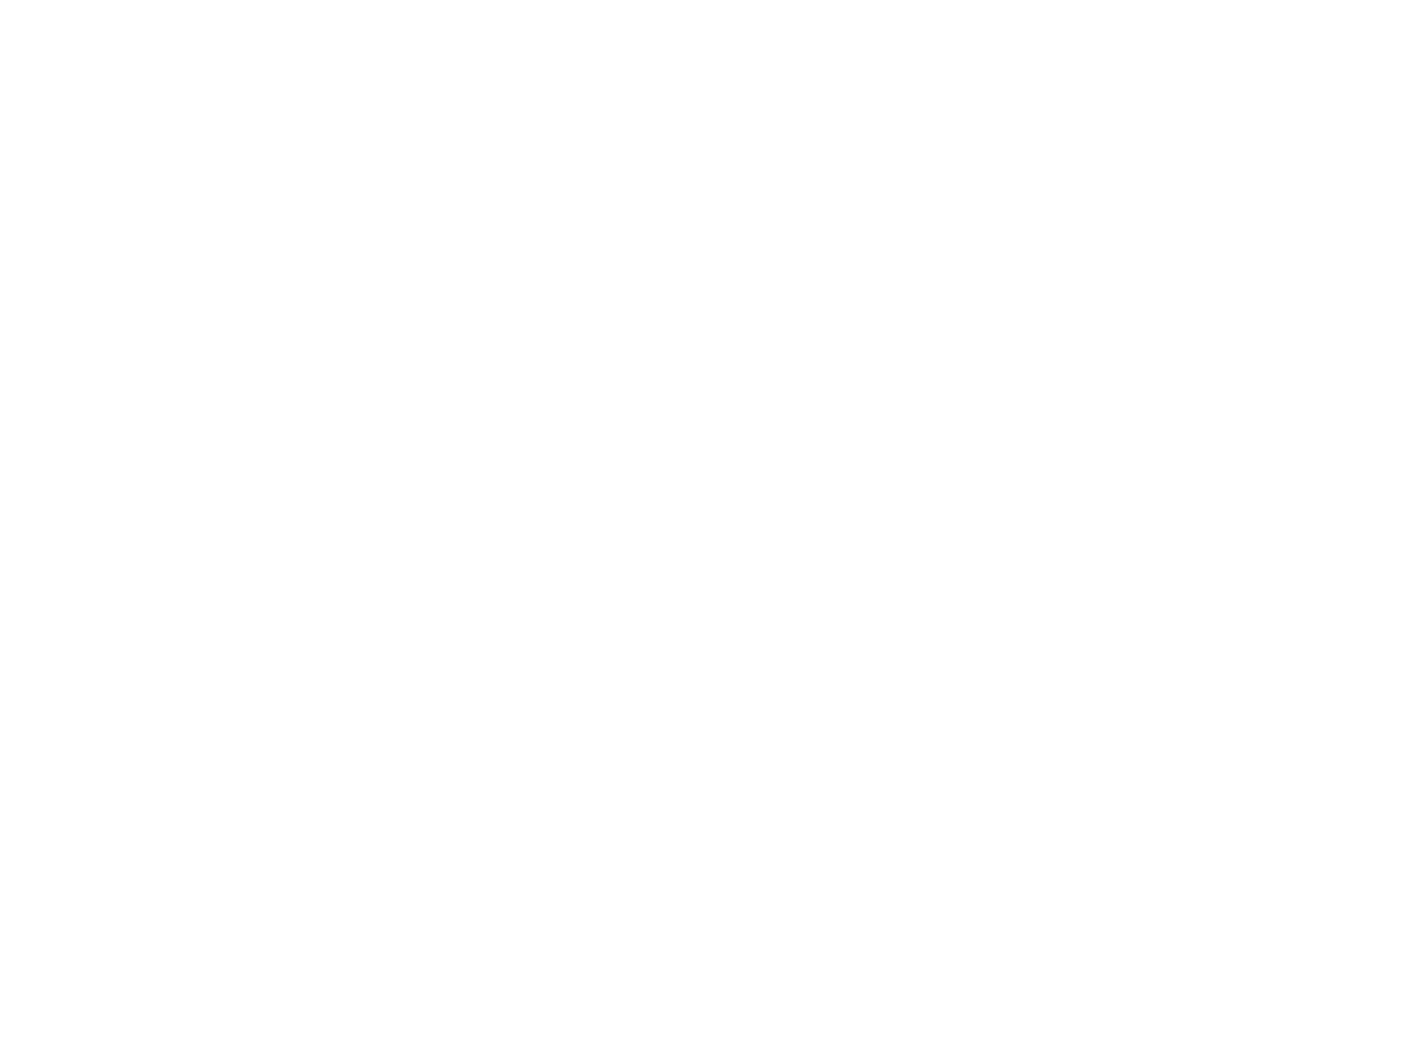

<IPython.core.display.Javascript object>


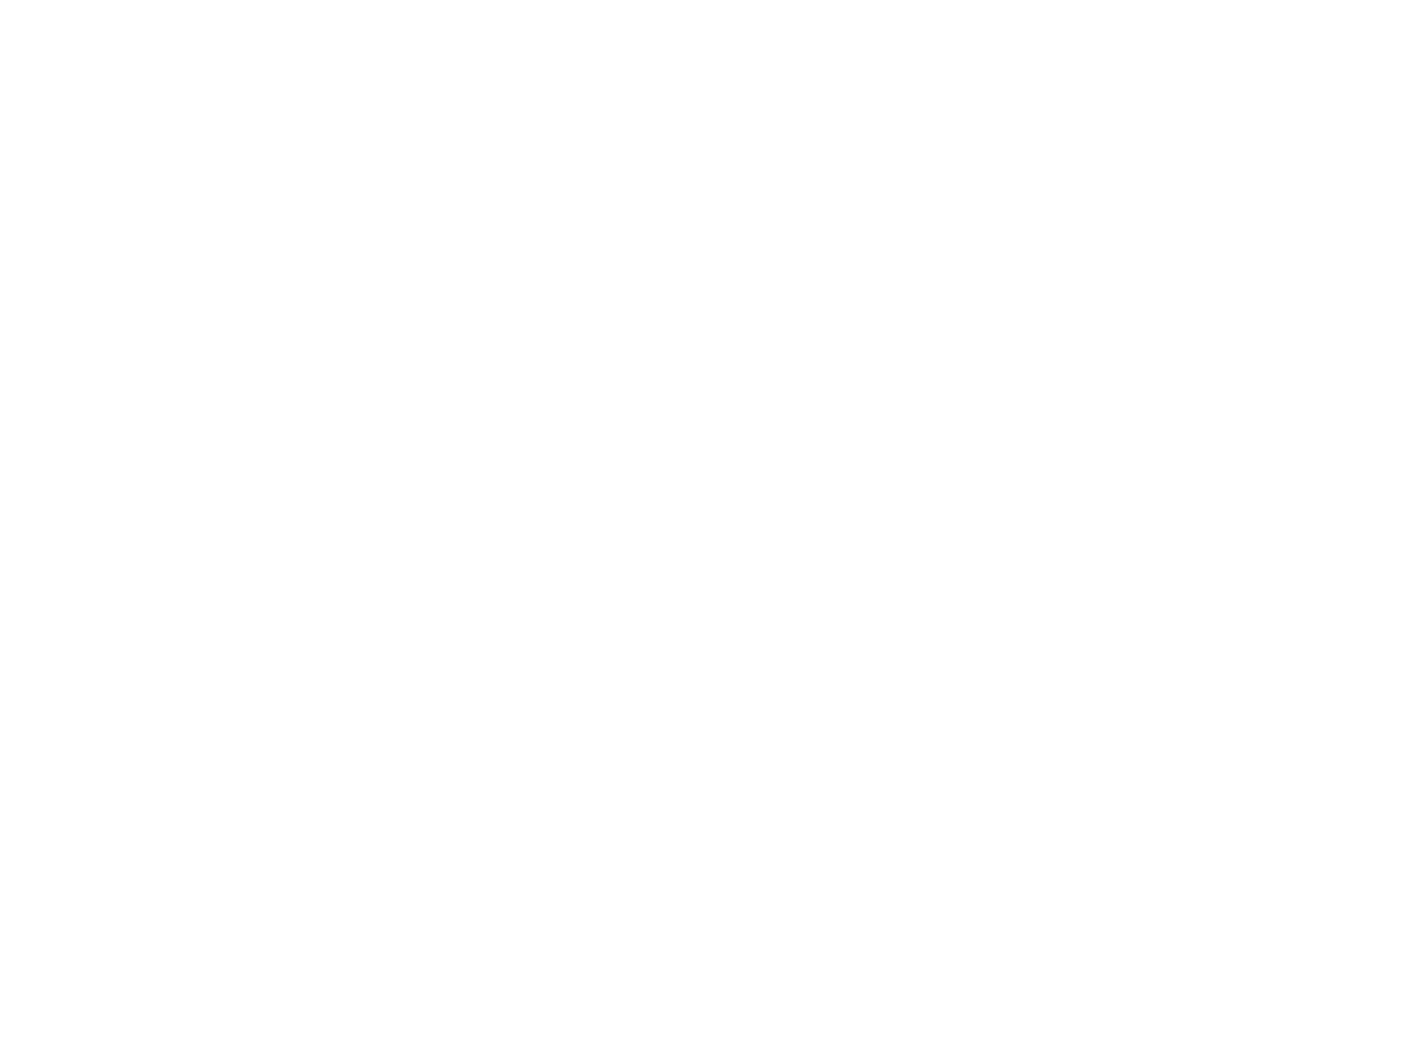

<IPython.core.display.Javascript object>


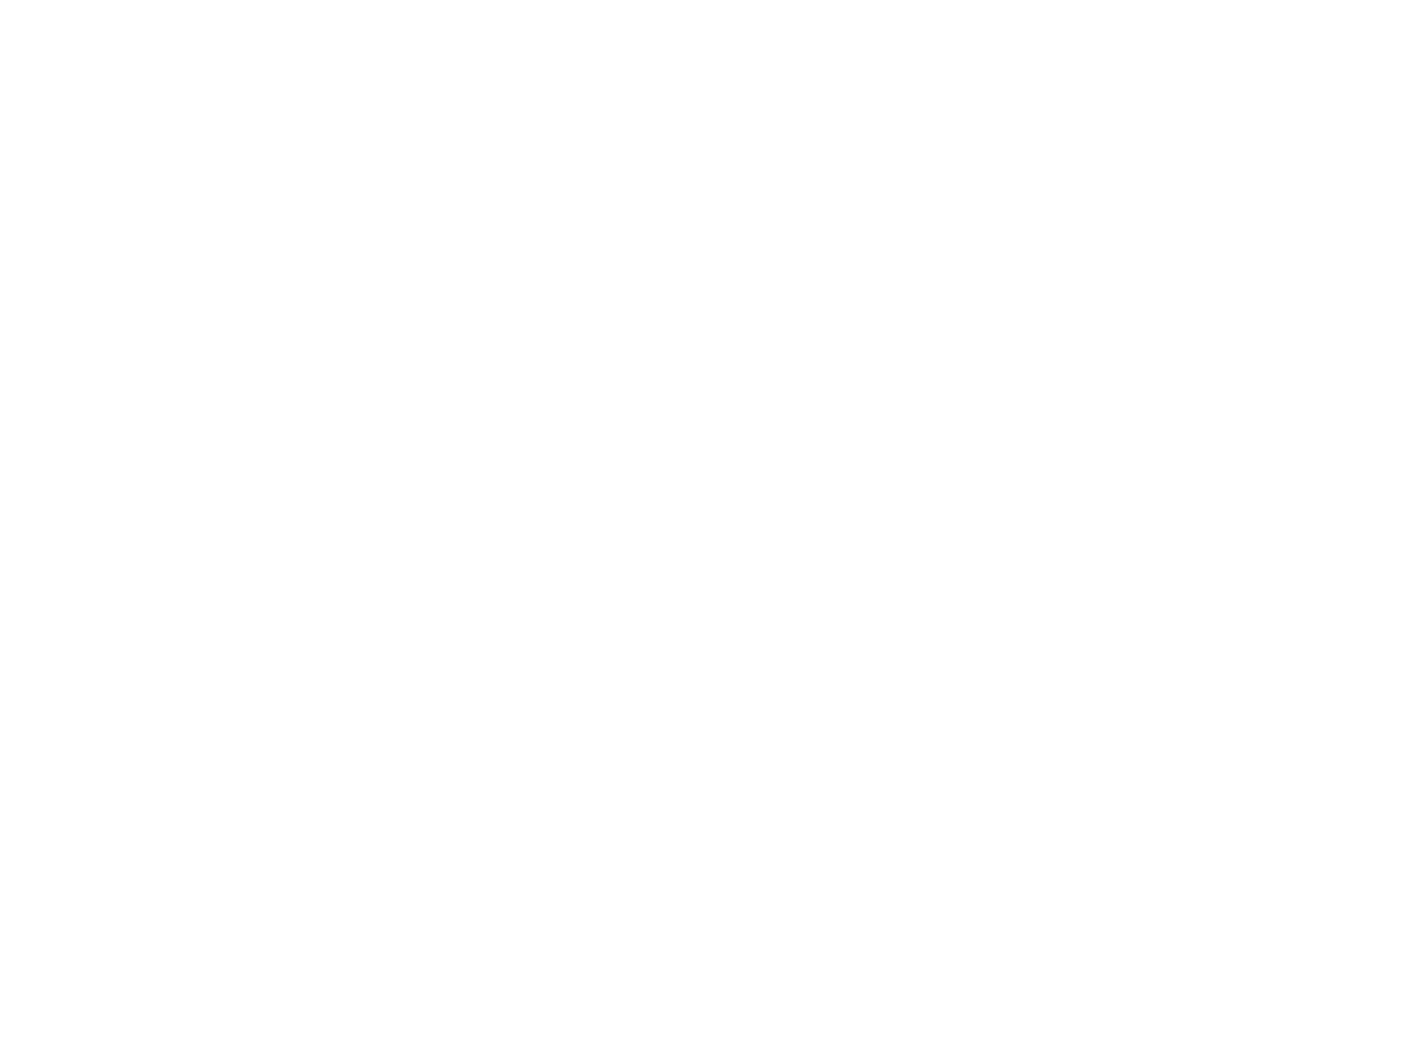

<IPython.core.display.Javascript object>


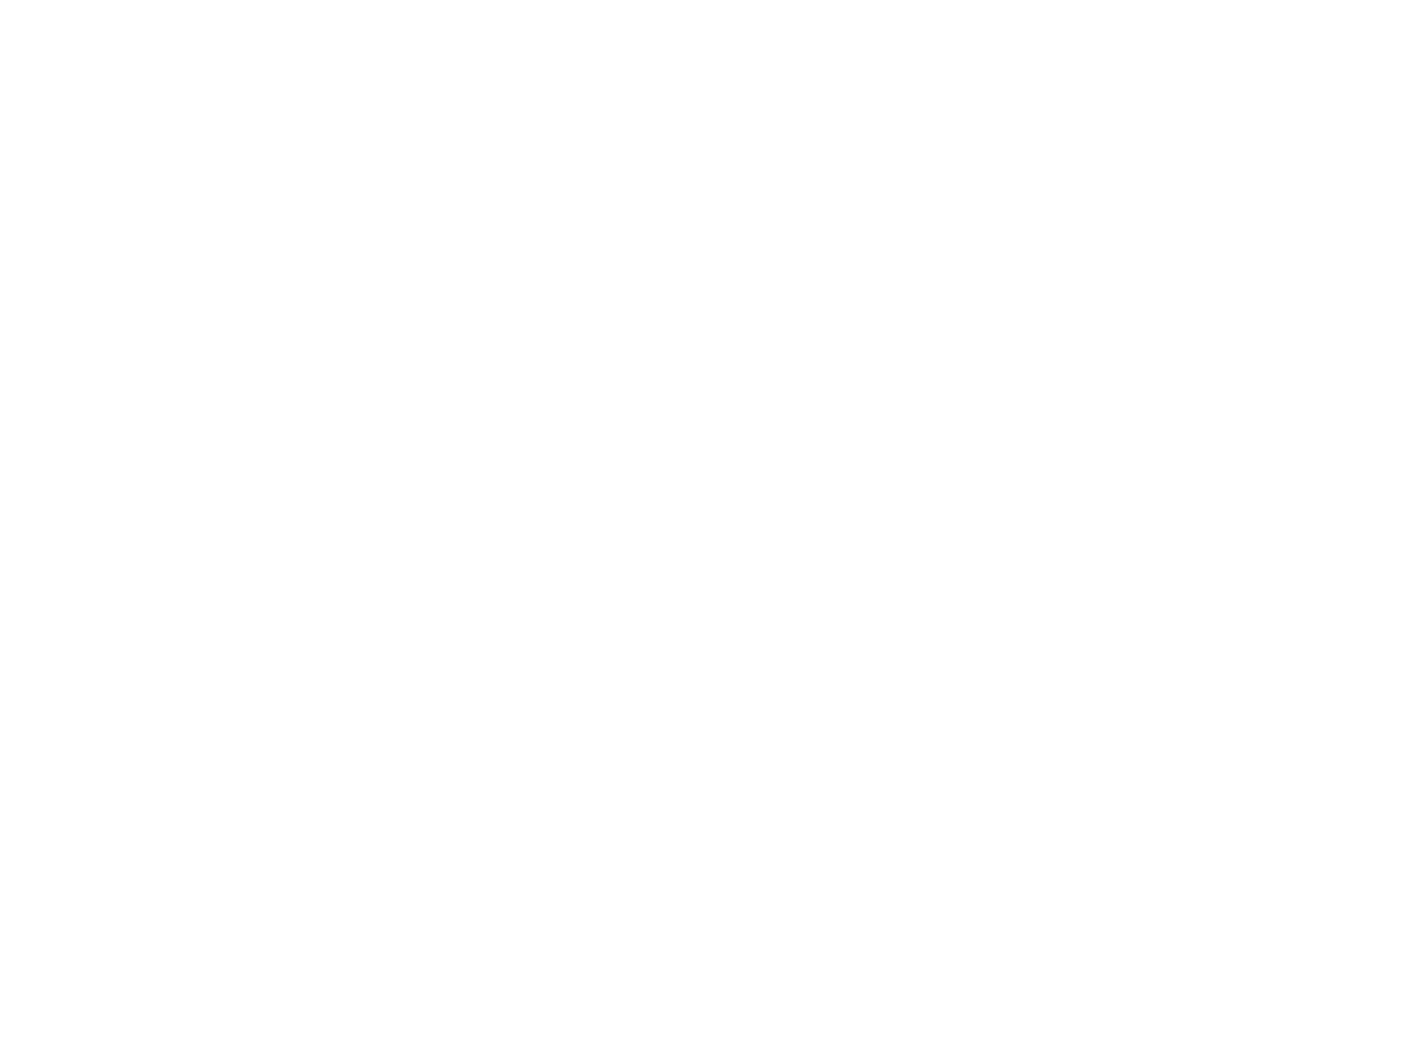

<IPython.core.display.Javascript object>


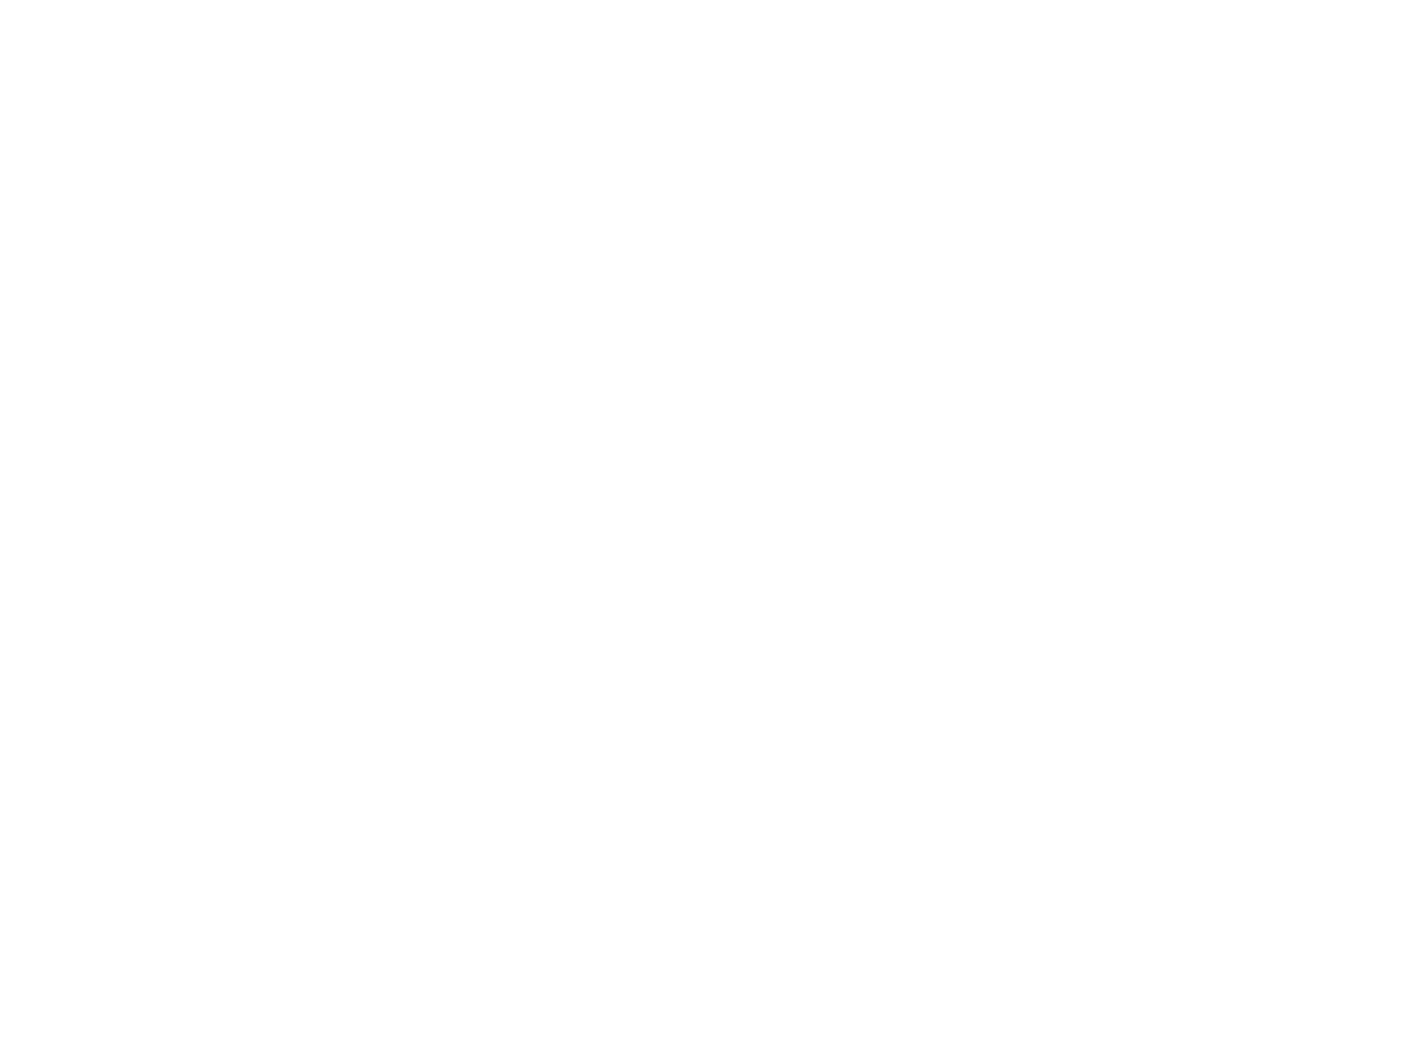

<IPython.core.display.Javascript object>


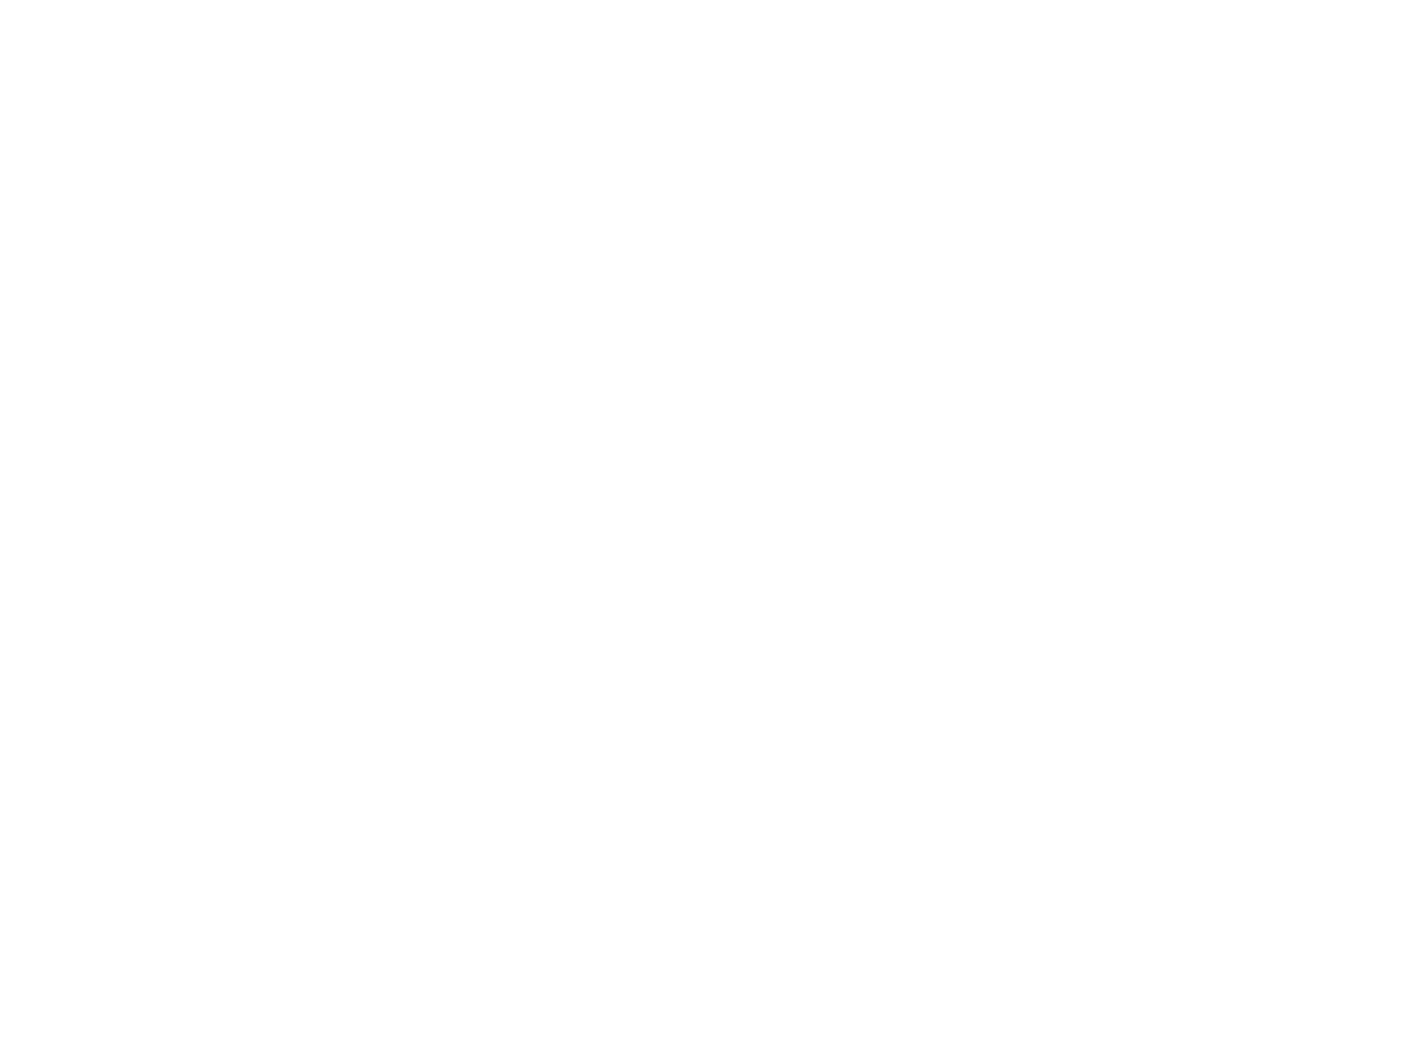

<IPython.core.display.Javascript object>


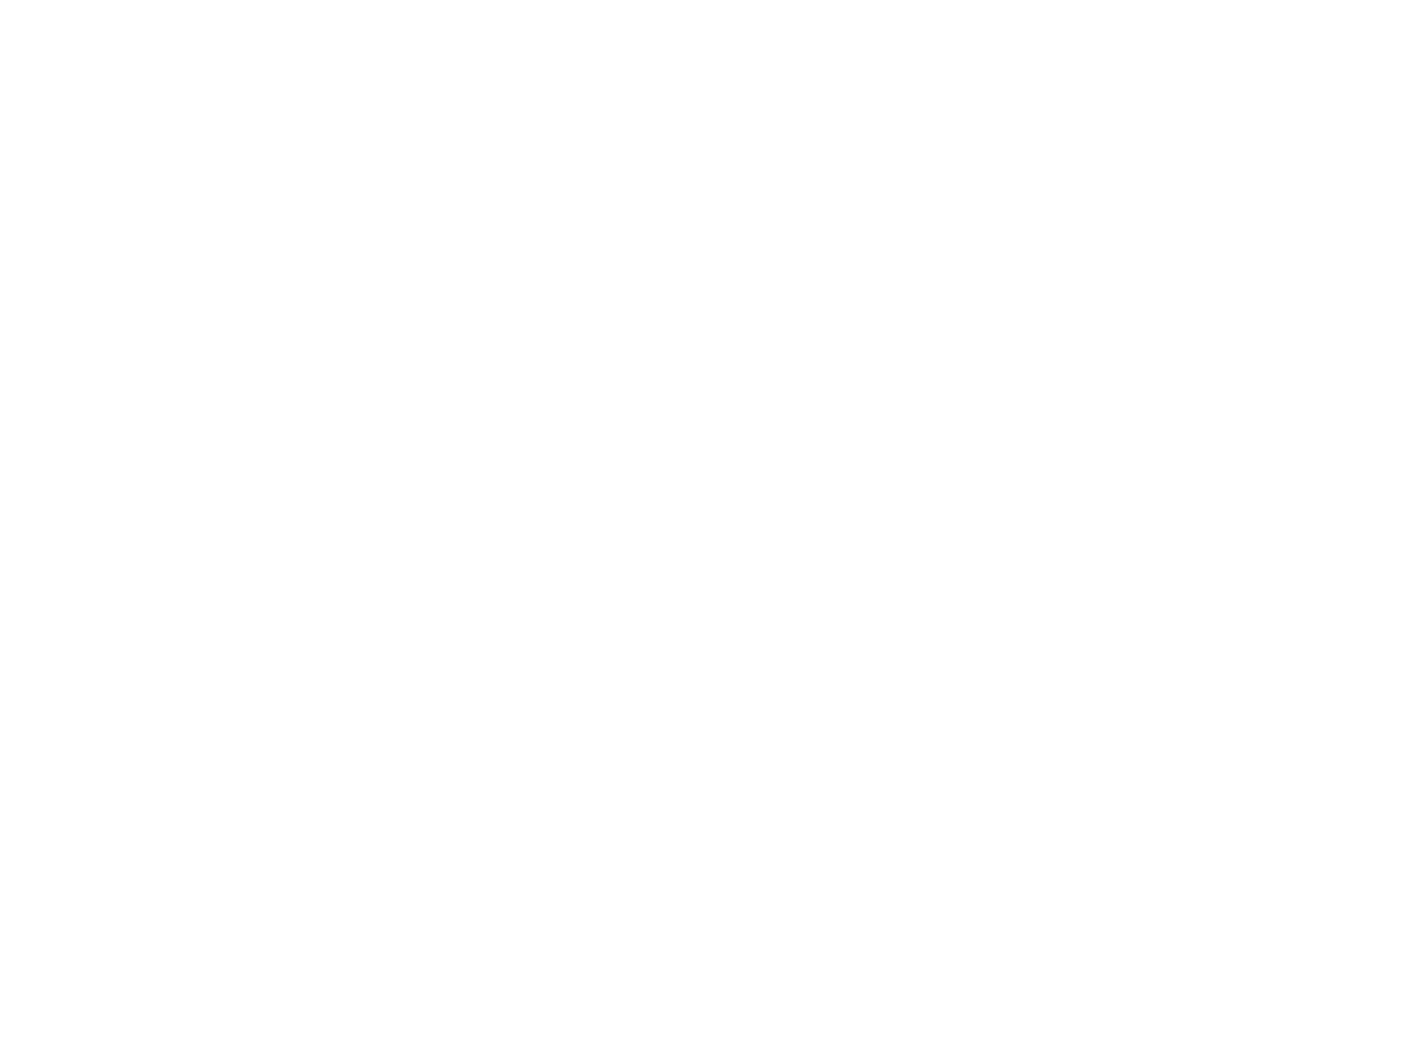

<IPython.core.display.Javascript object>


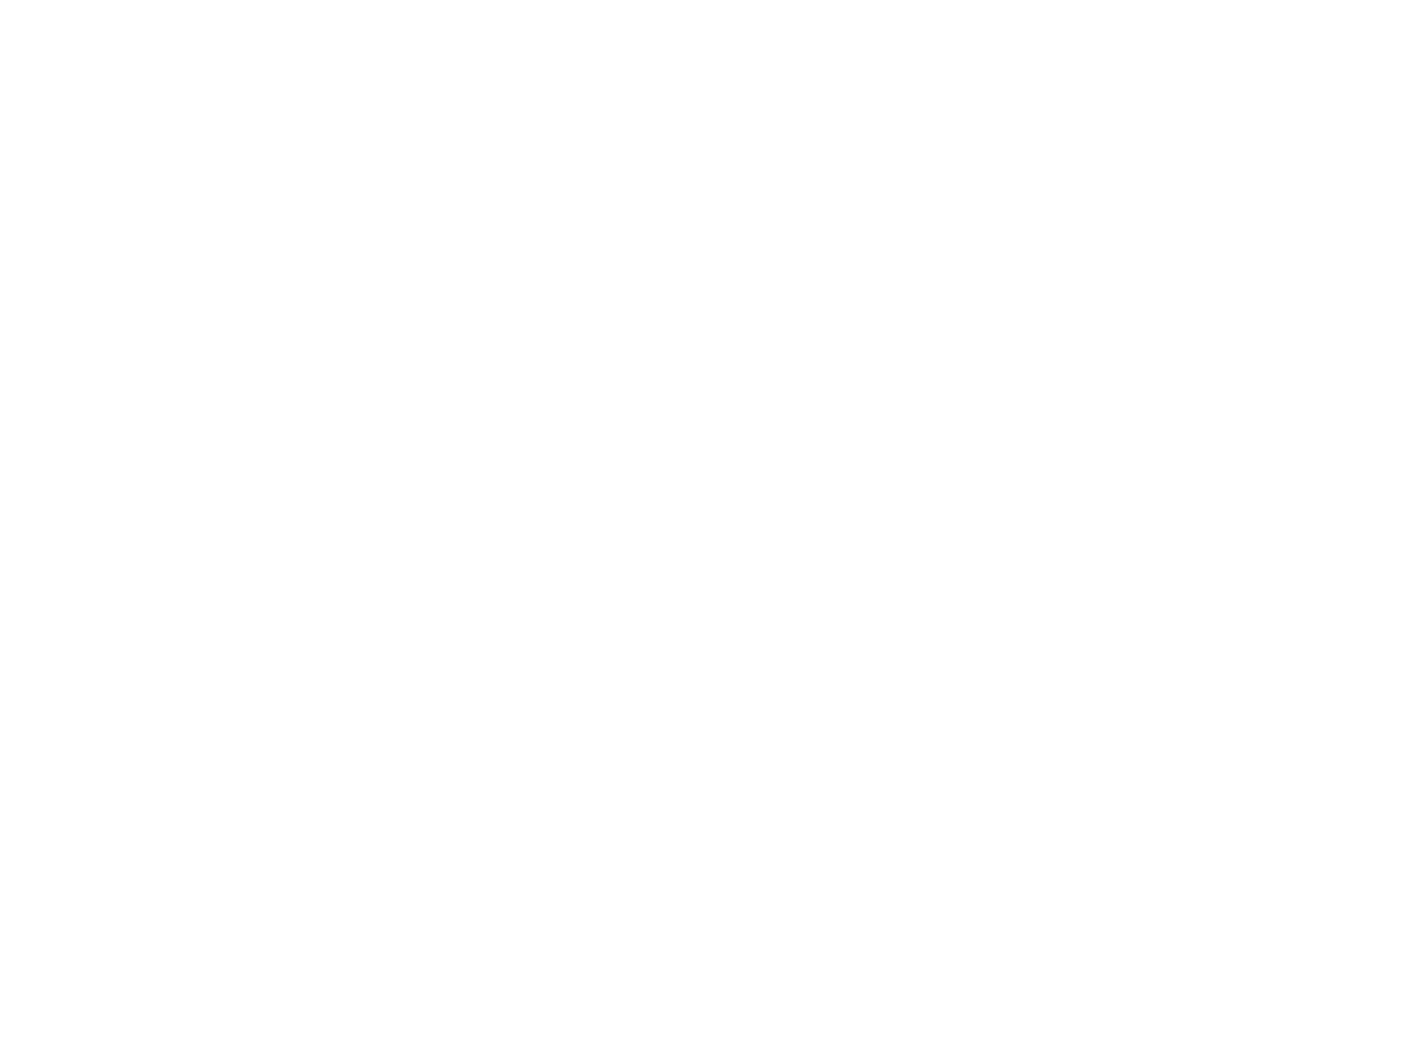

<IPython.core.display.Javascript object>


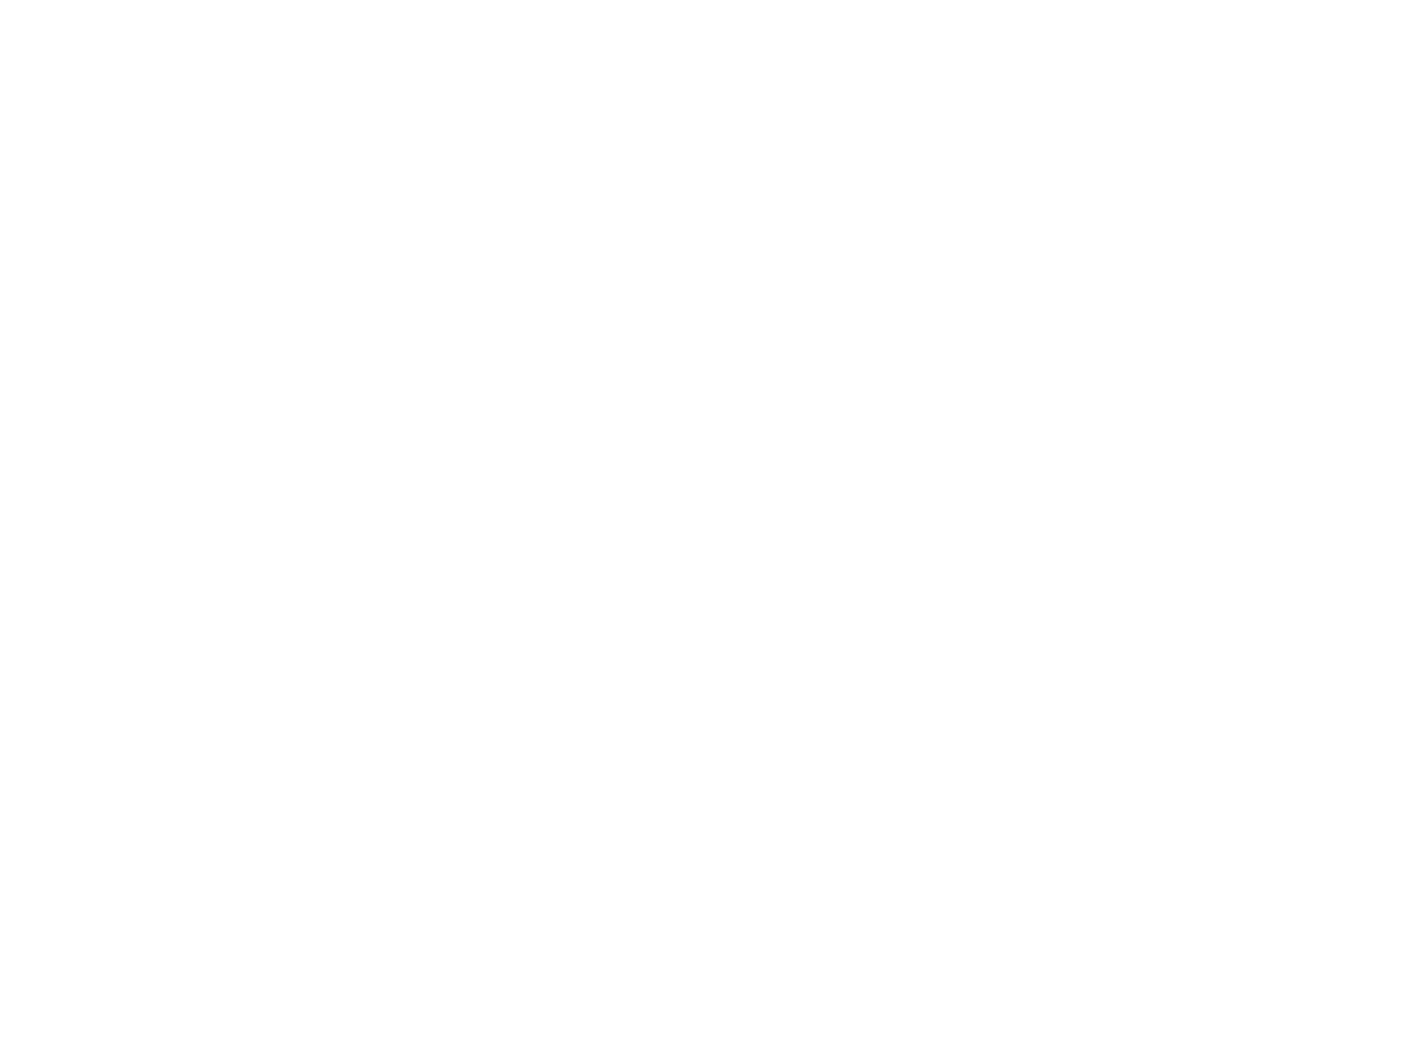

<IPython.core.display.Javascript object>


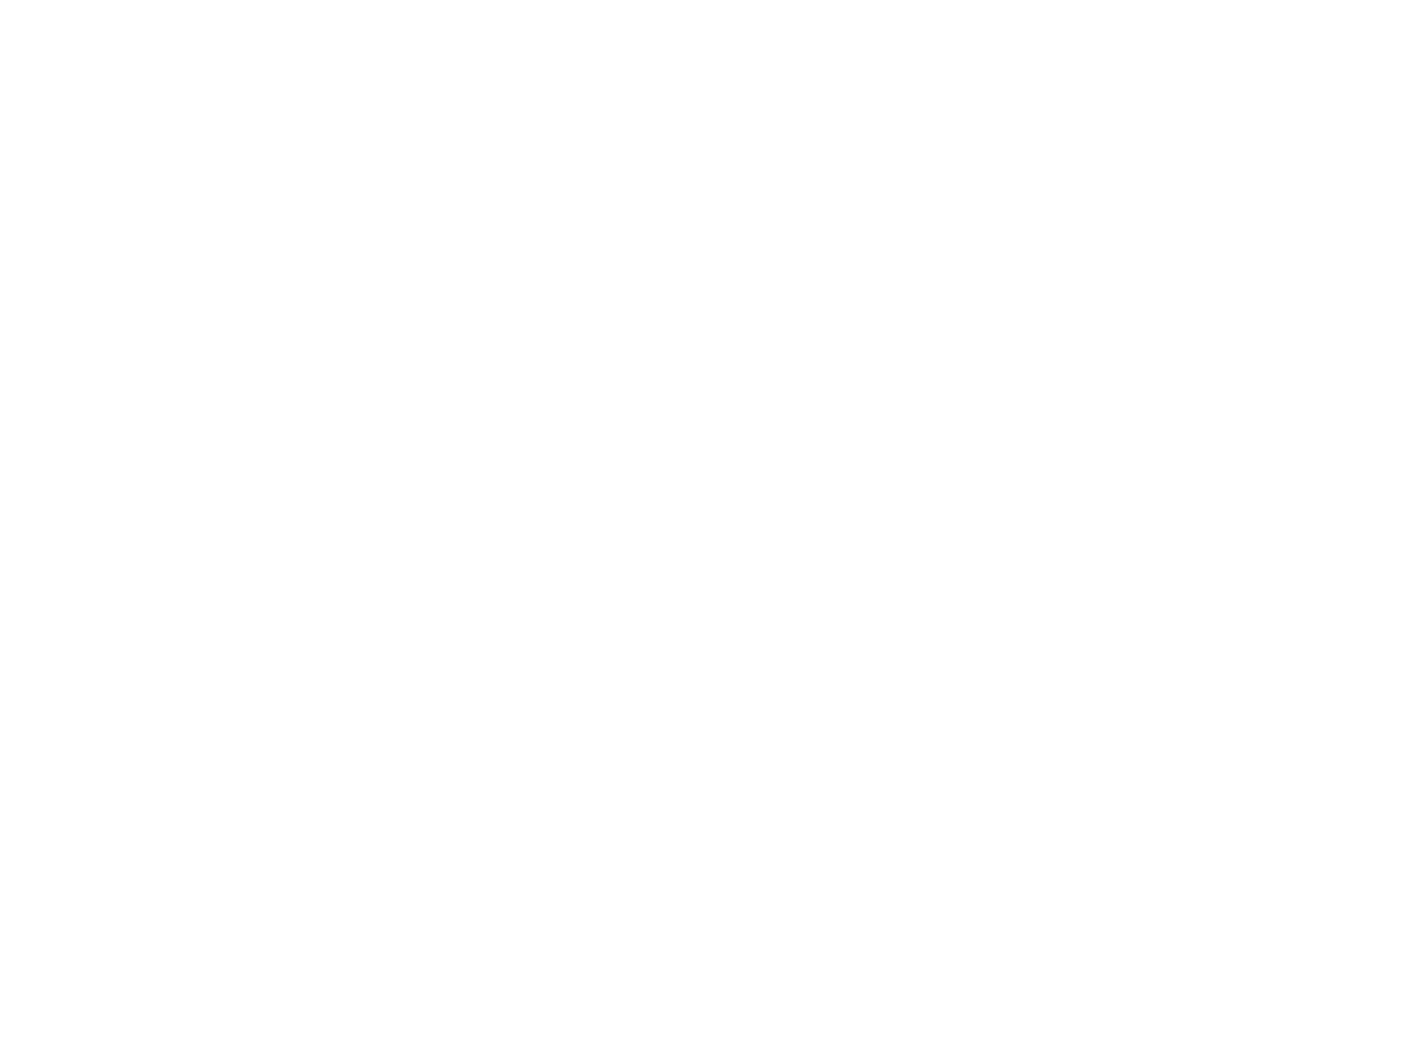

<IPython.core.display.Javascript object>


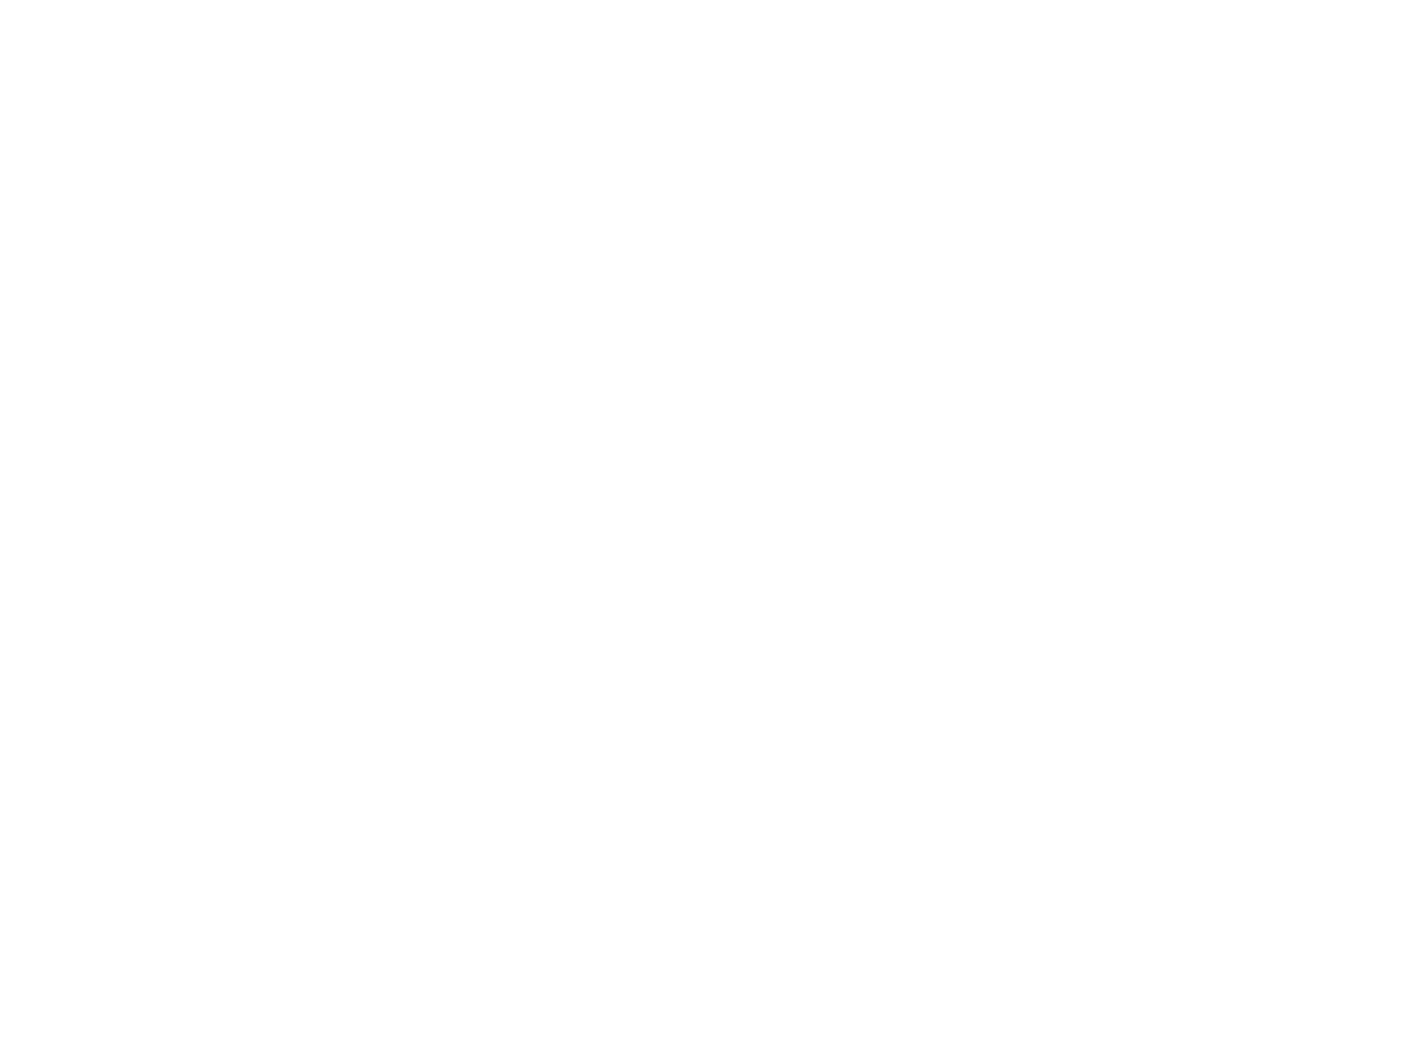

<IPython.core.display.Javascript object>


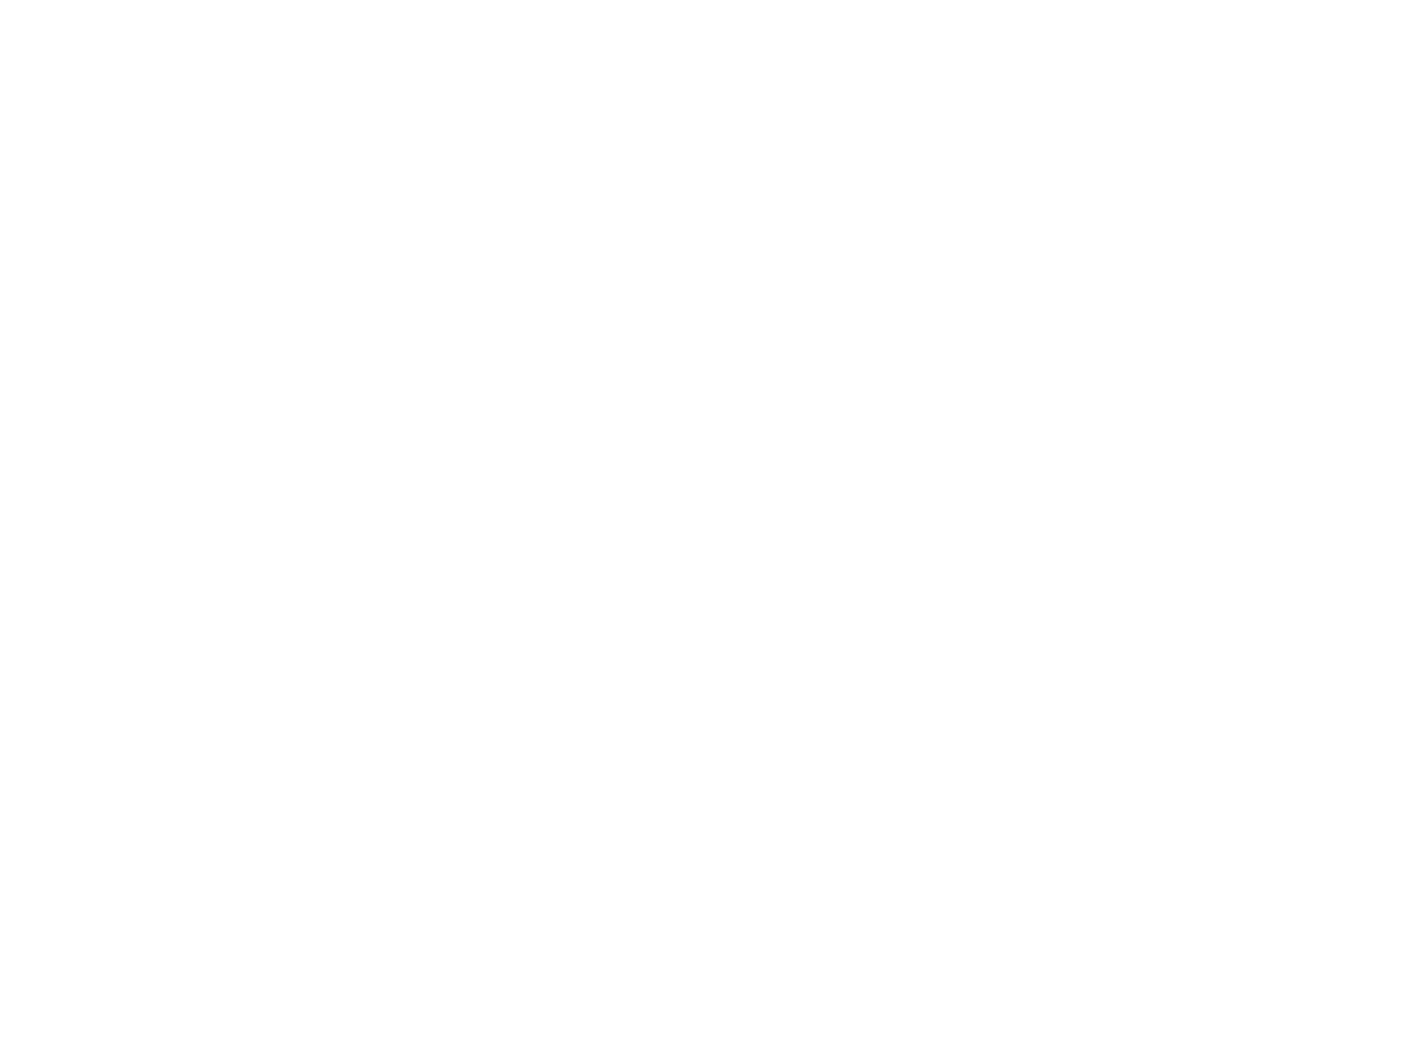

<IPython.core.display.Javascript object>


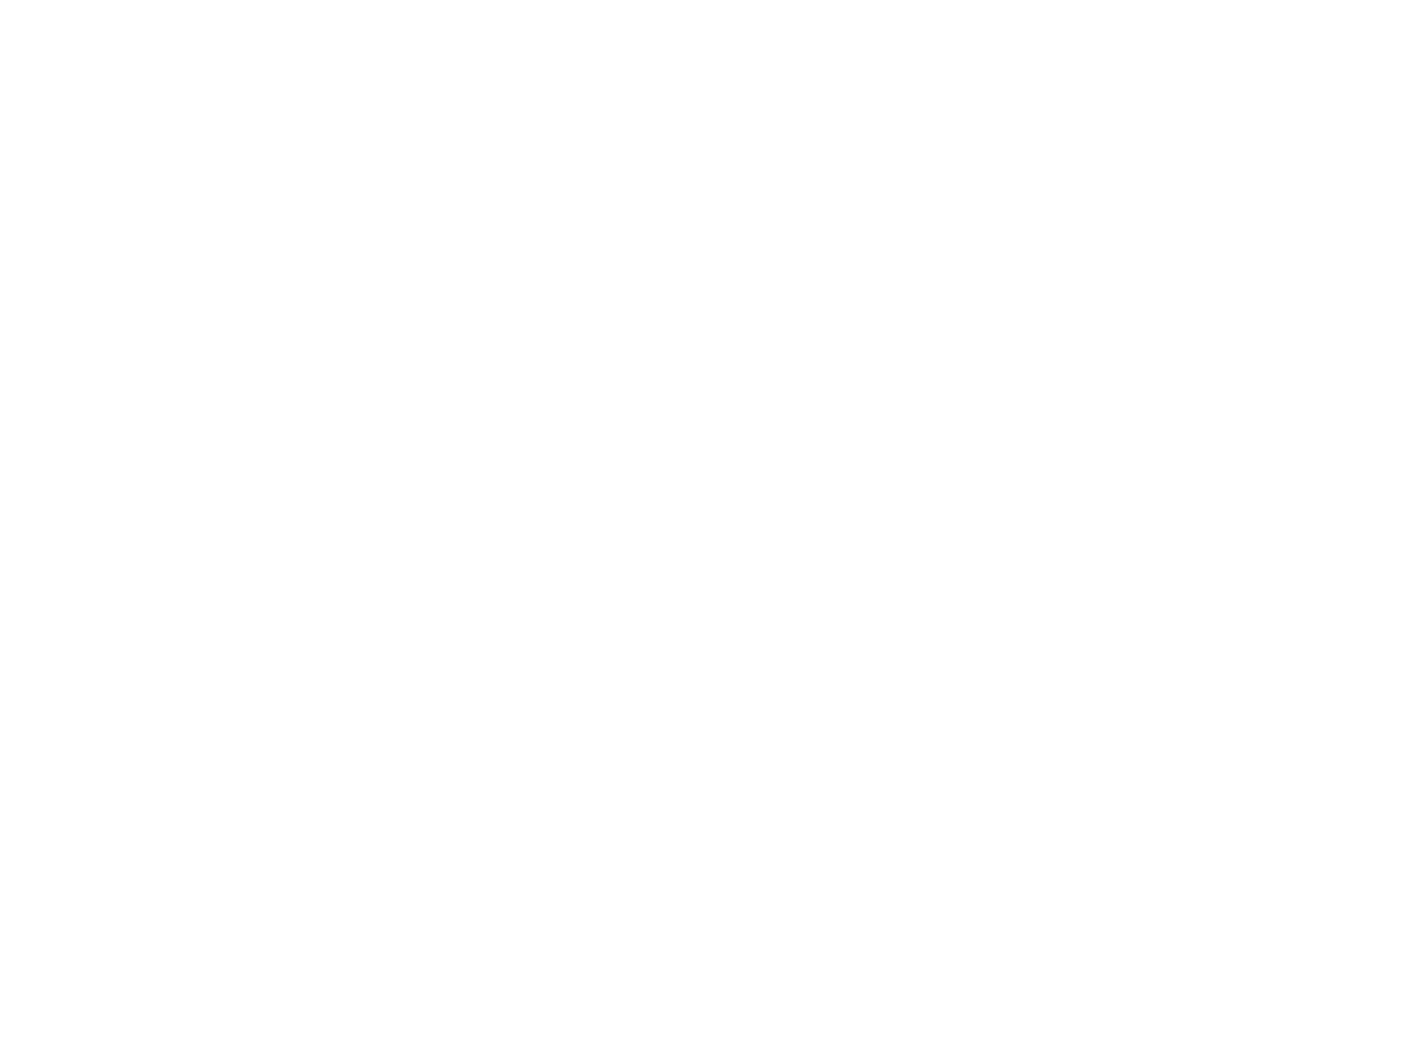

<IPython.core.display.Javascript object>


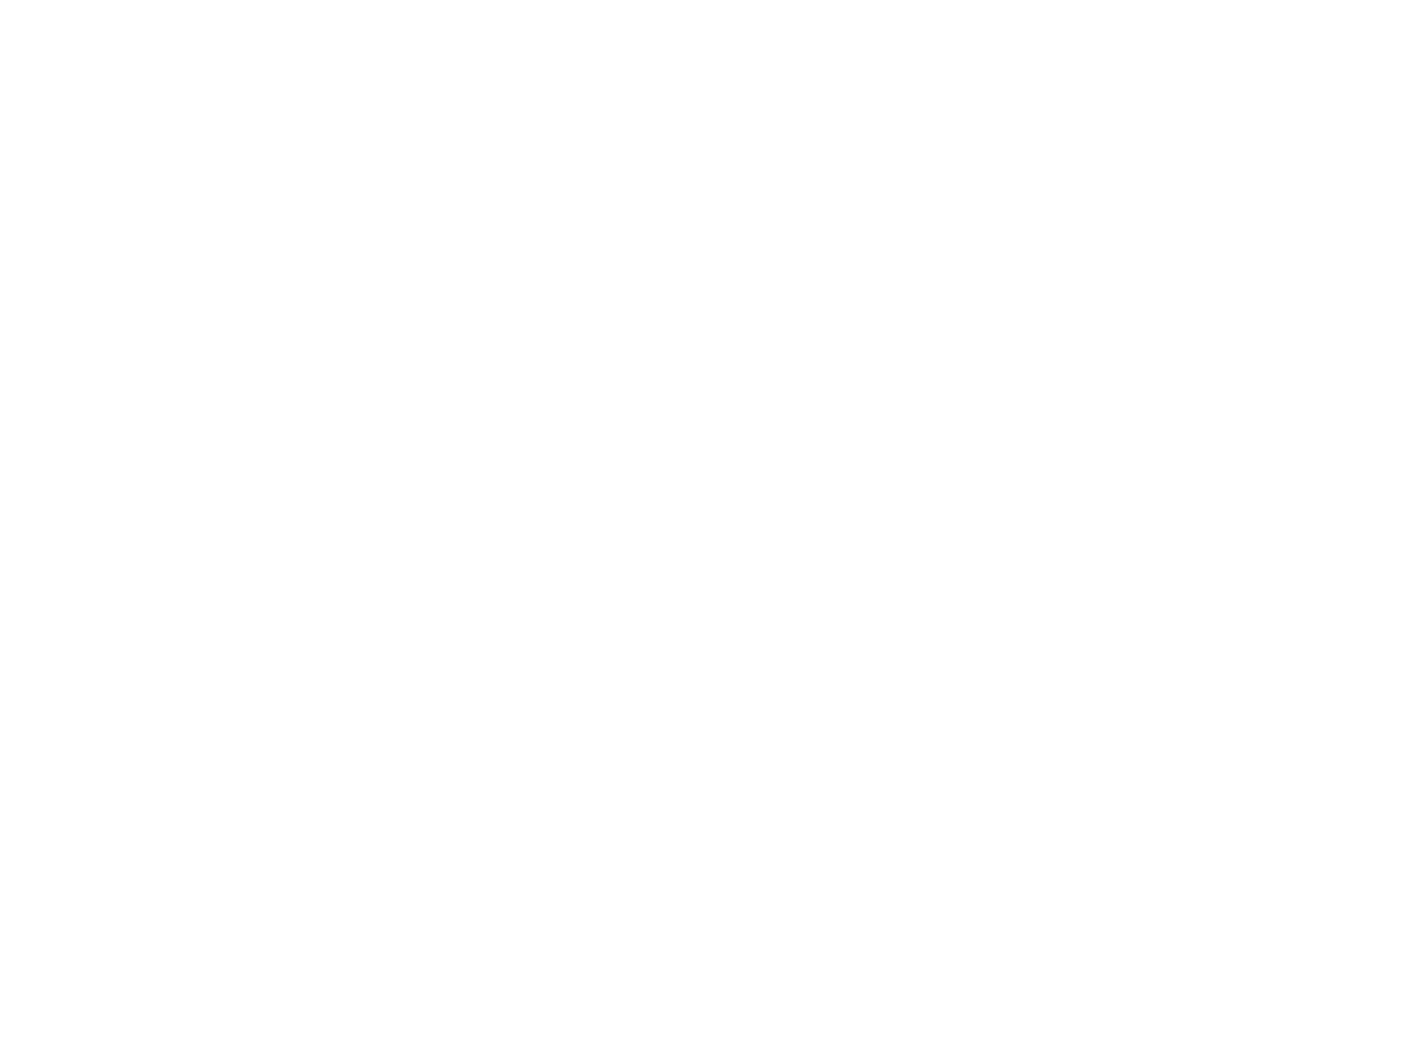

<IPython.core.display.Javascript object>


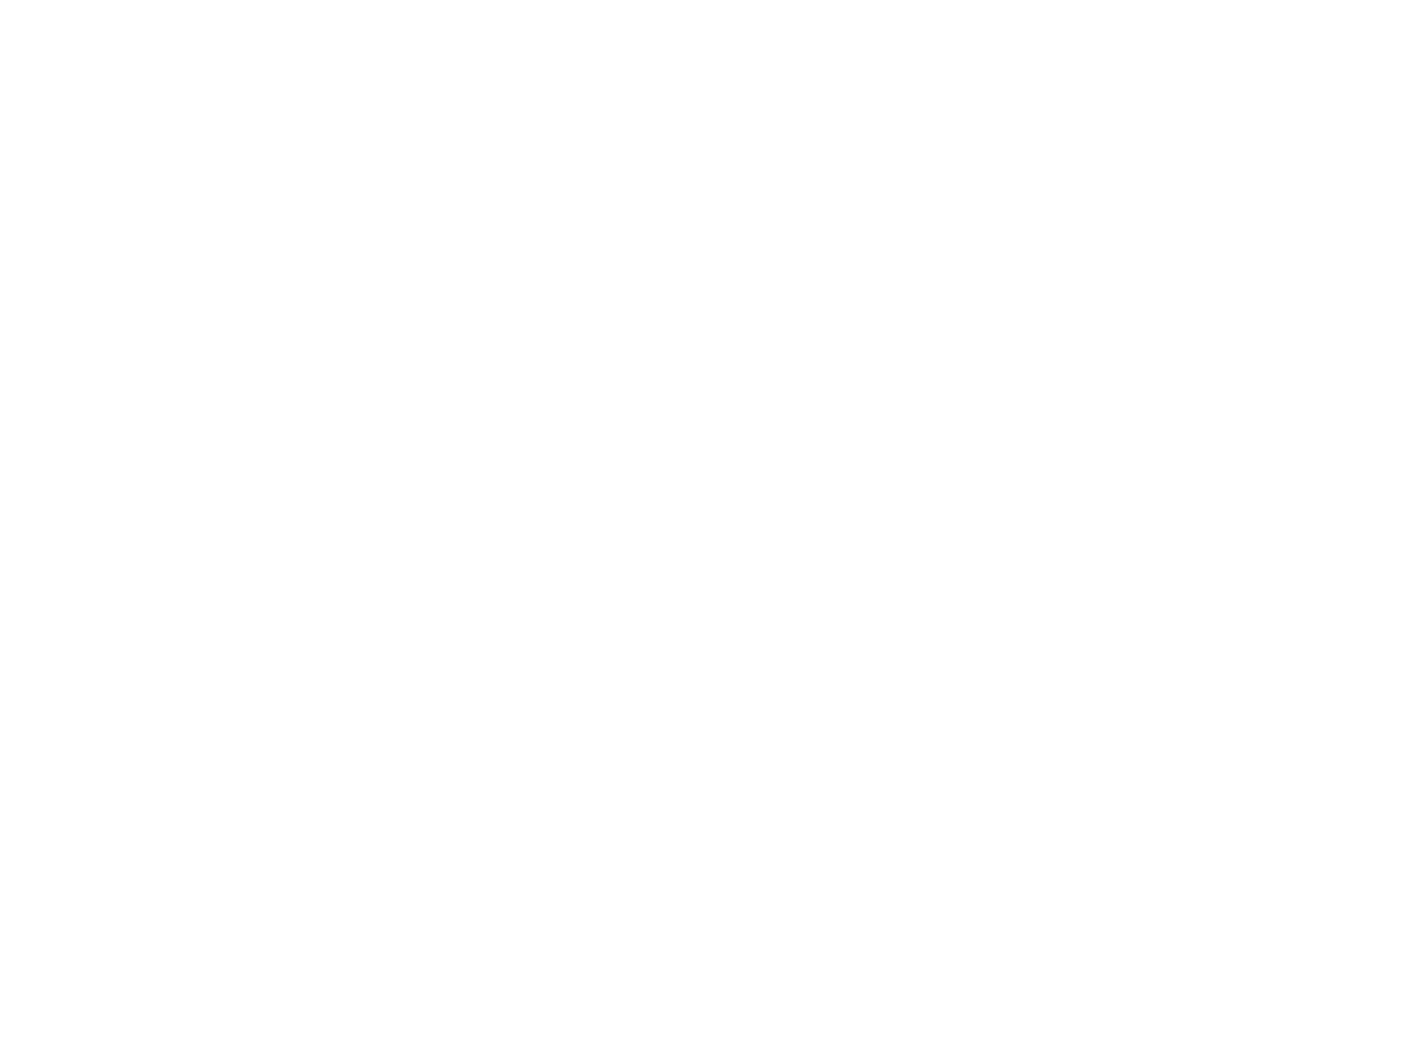

<IPython.core.display.Javascript object>


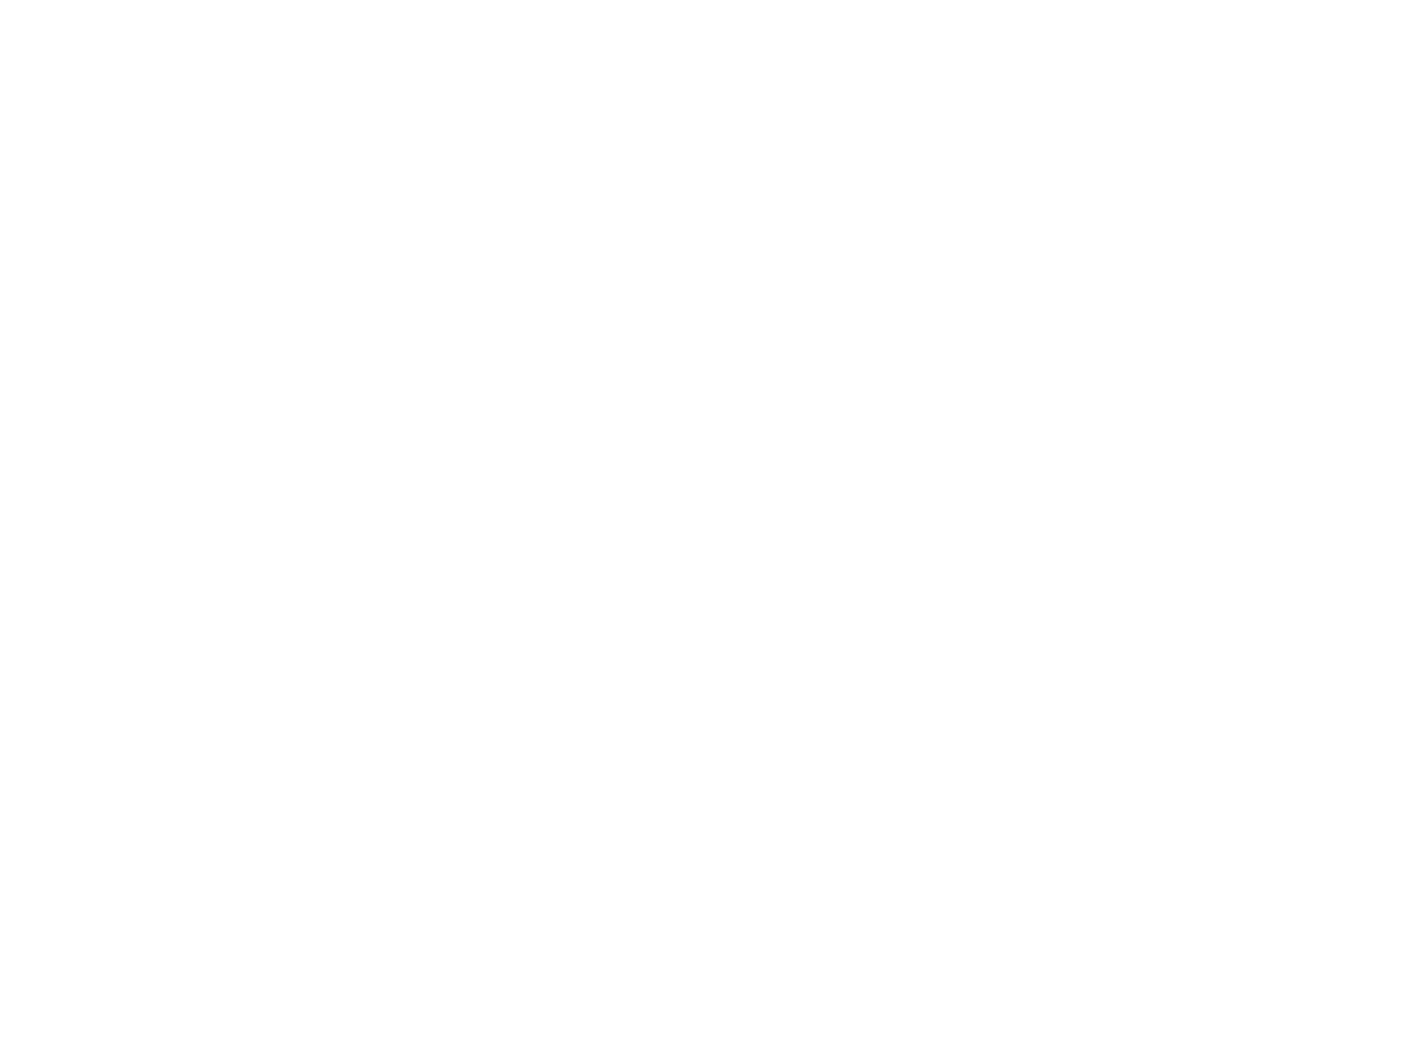

<IPython.core.display.Javascript object>


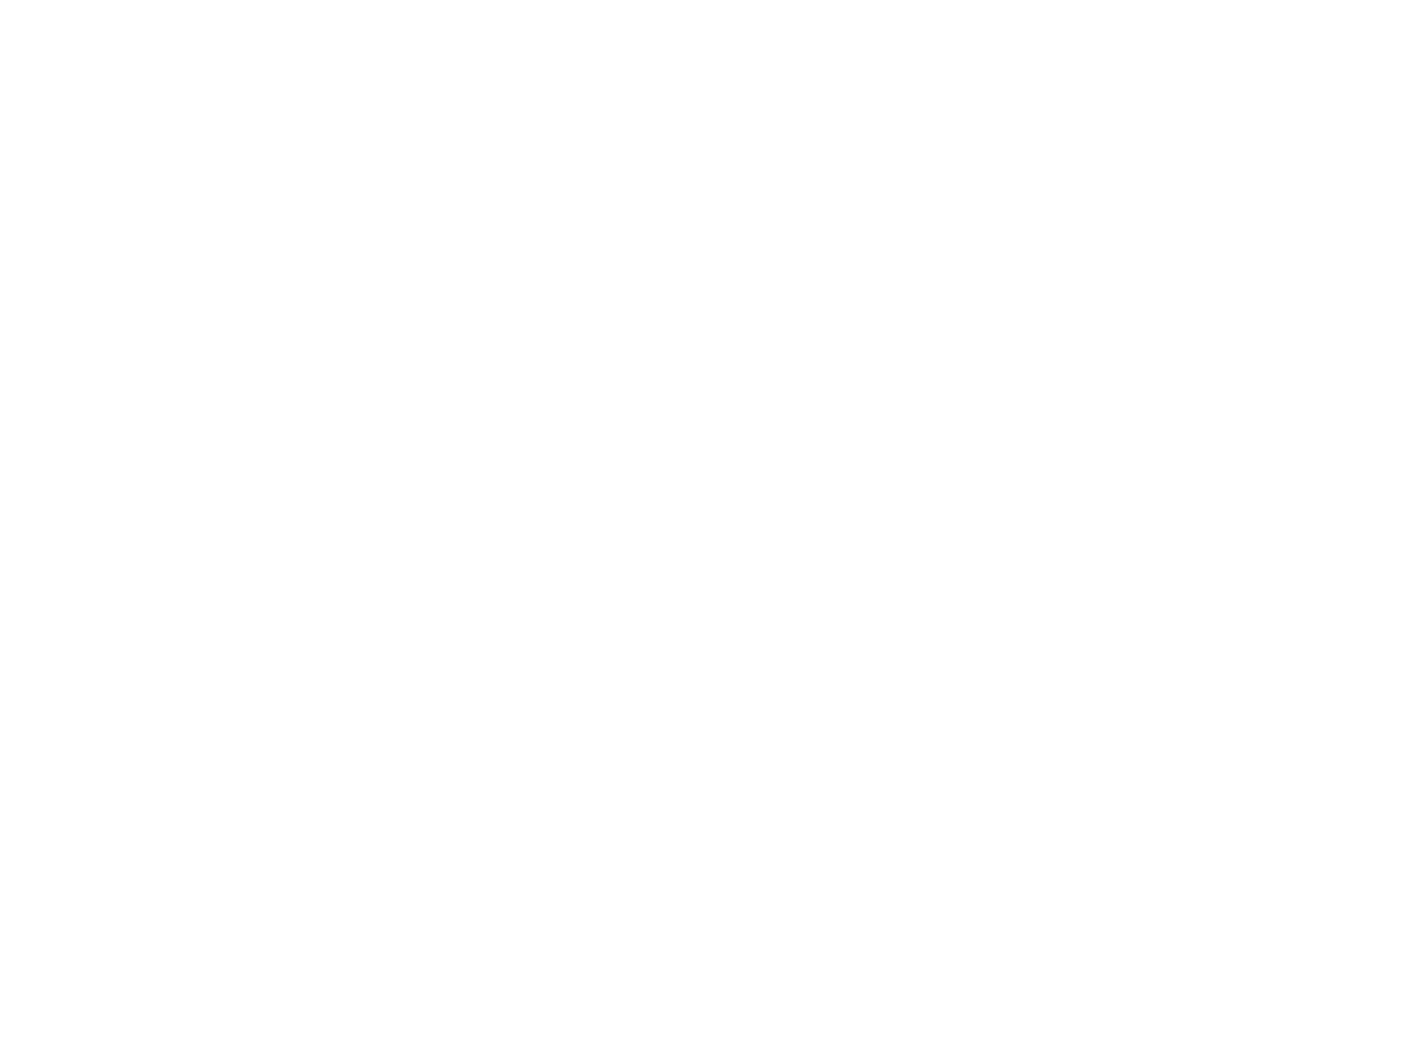

<IPython.core.display.Javascript object>


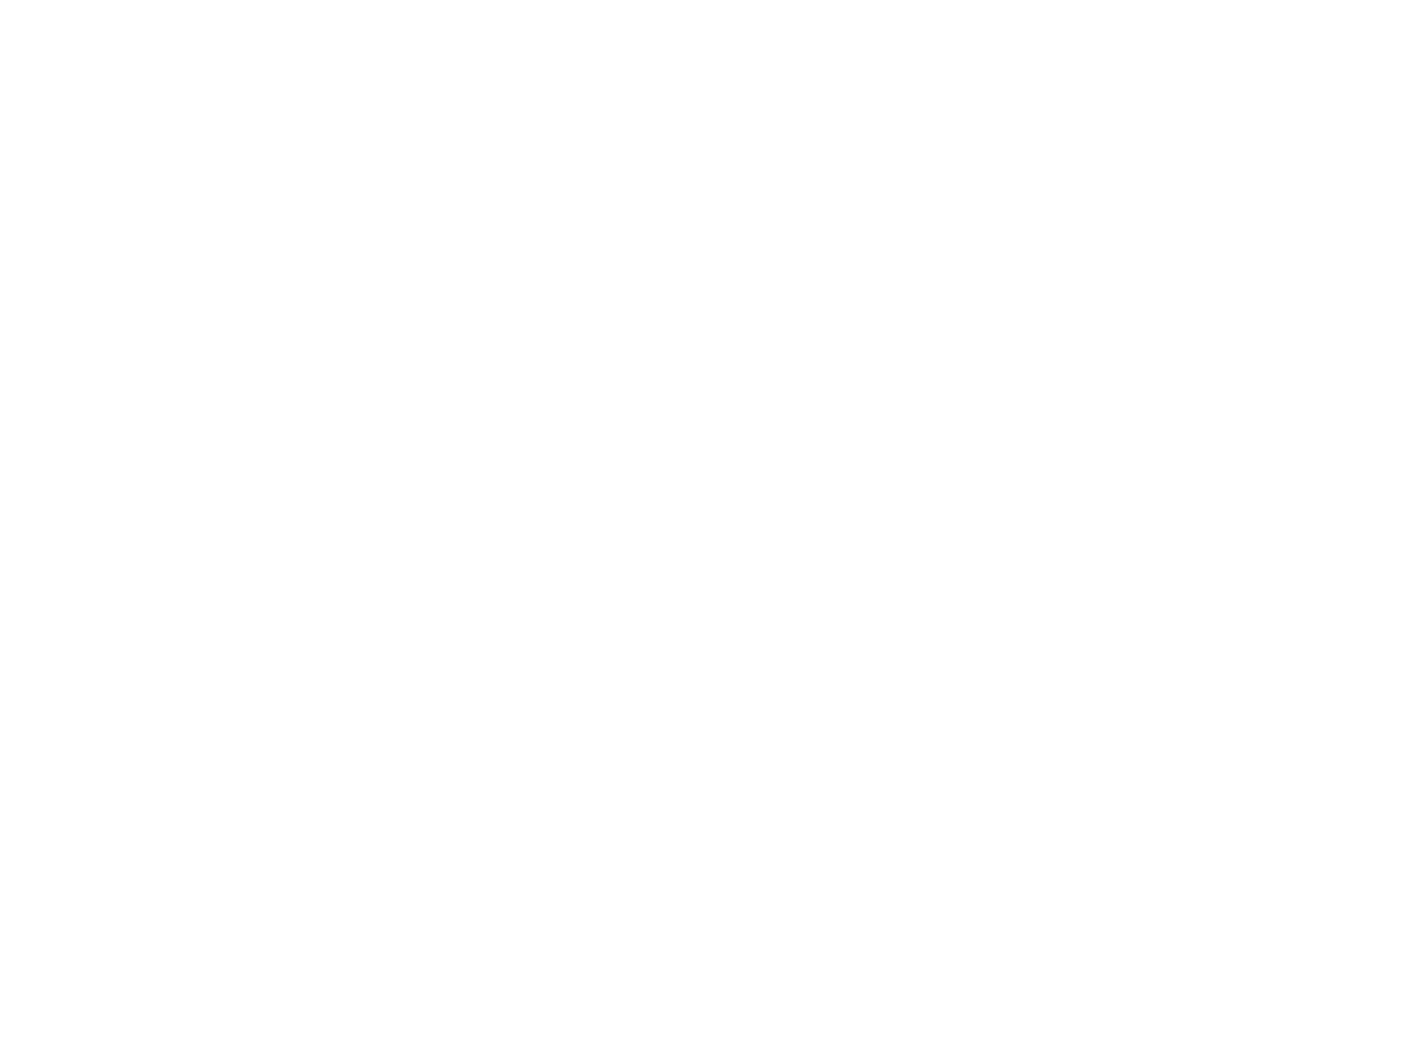

<IPython.core.display.Javascript object>


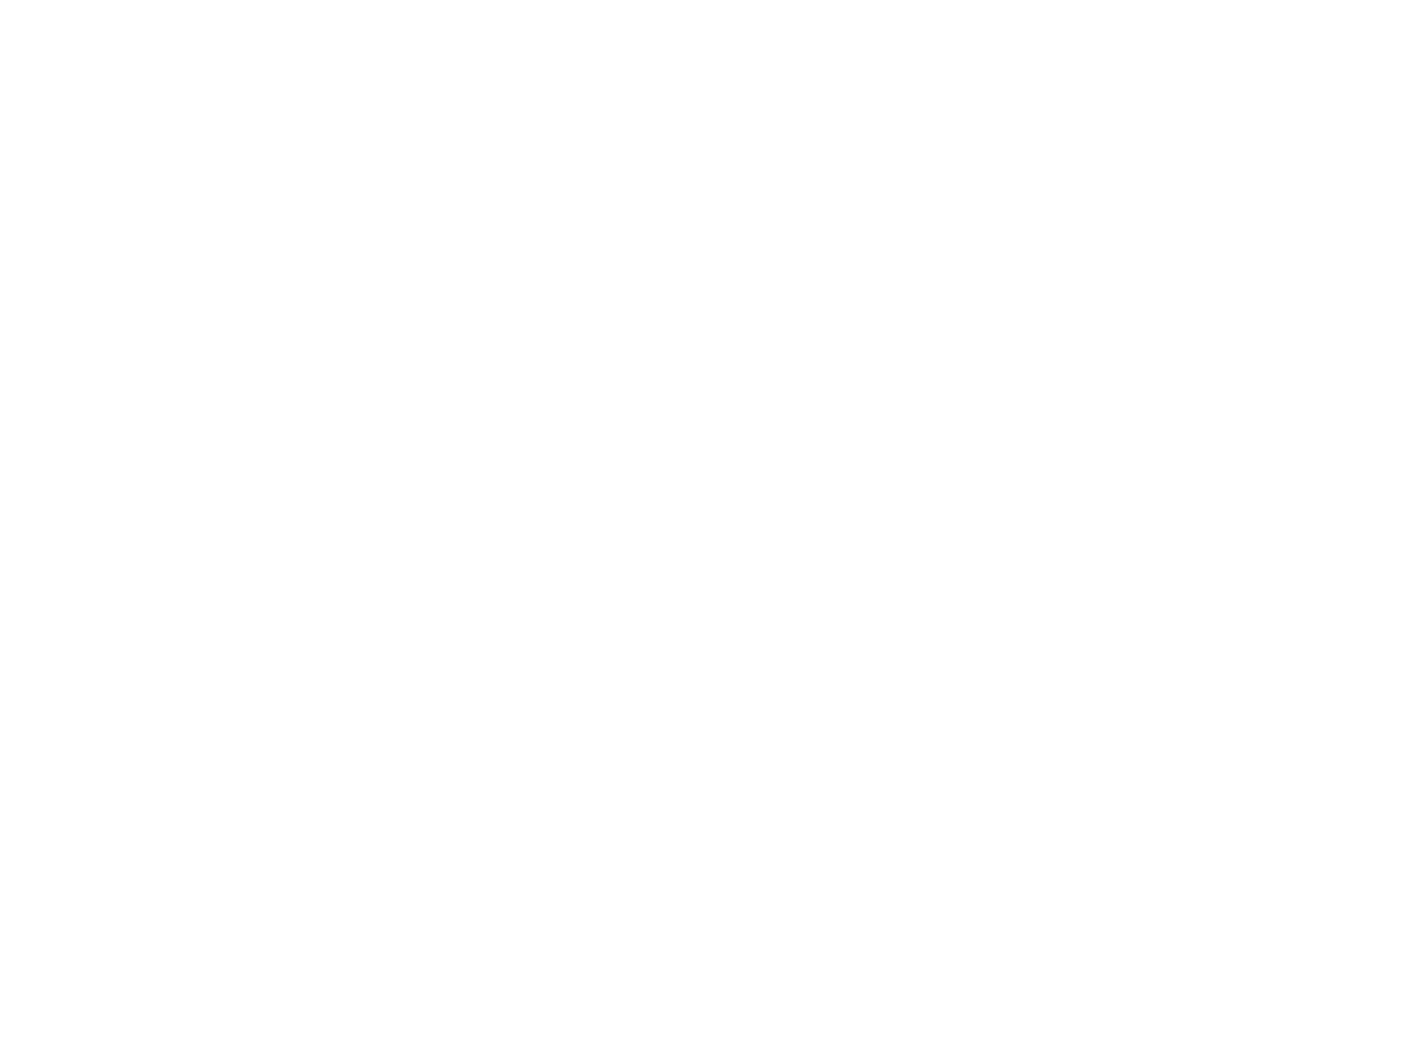

<IPython.core.display.Javascript object>


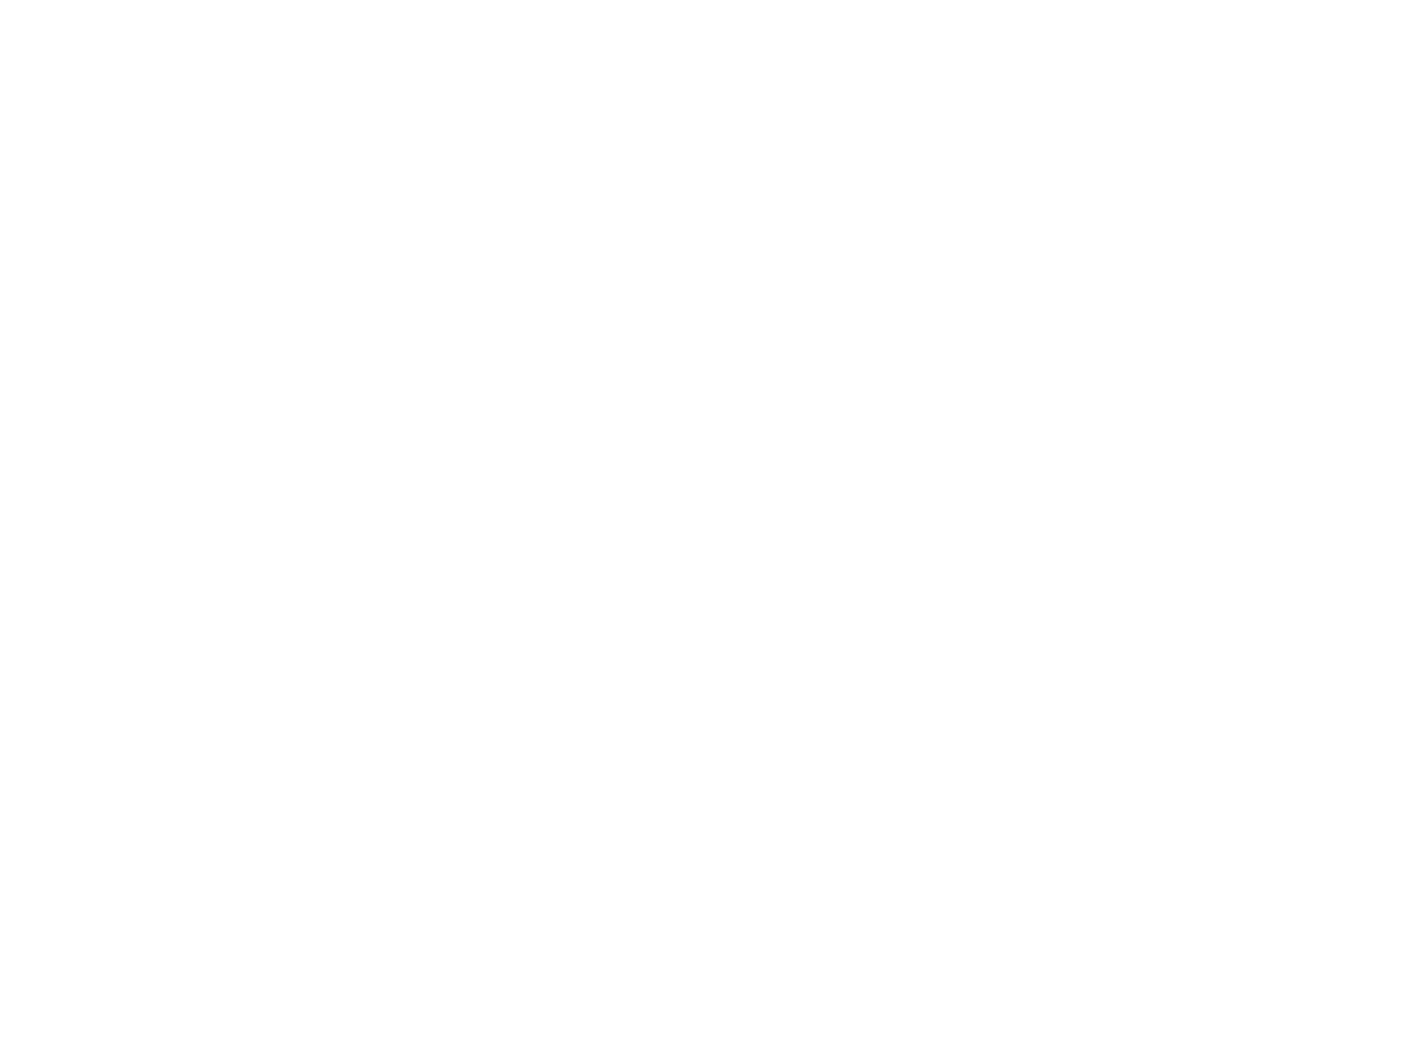

<IPython.core.display.Javascript object>


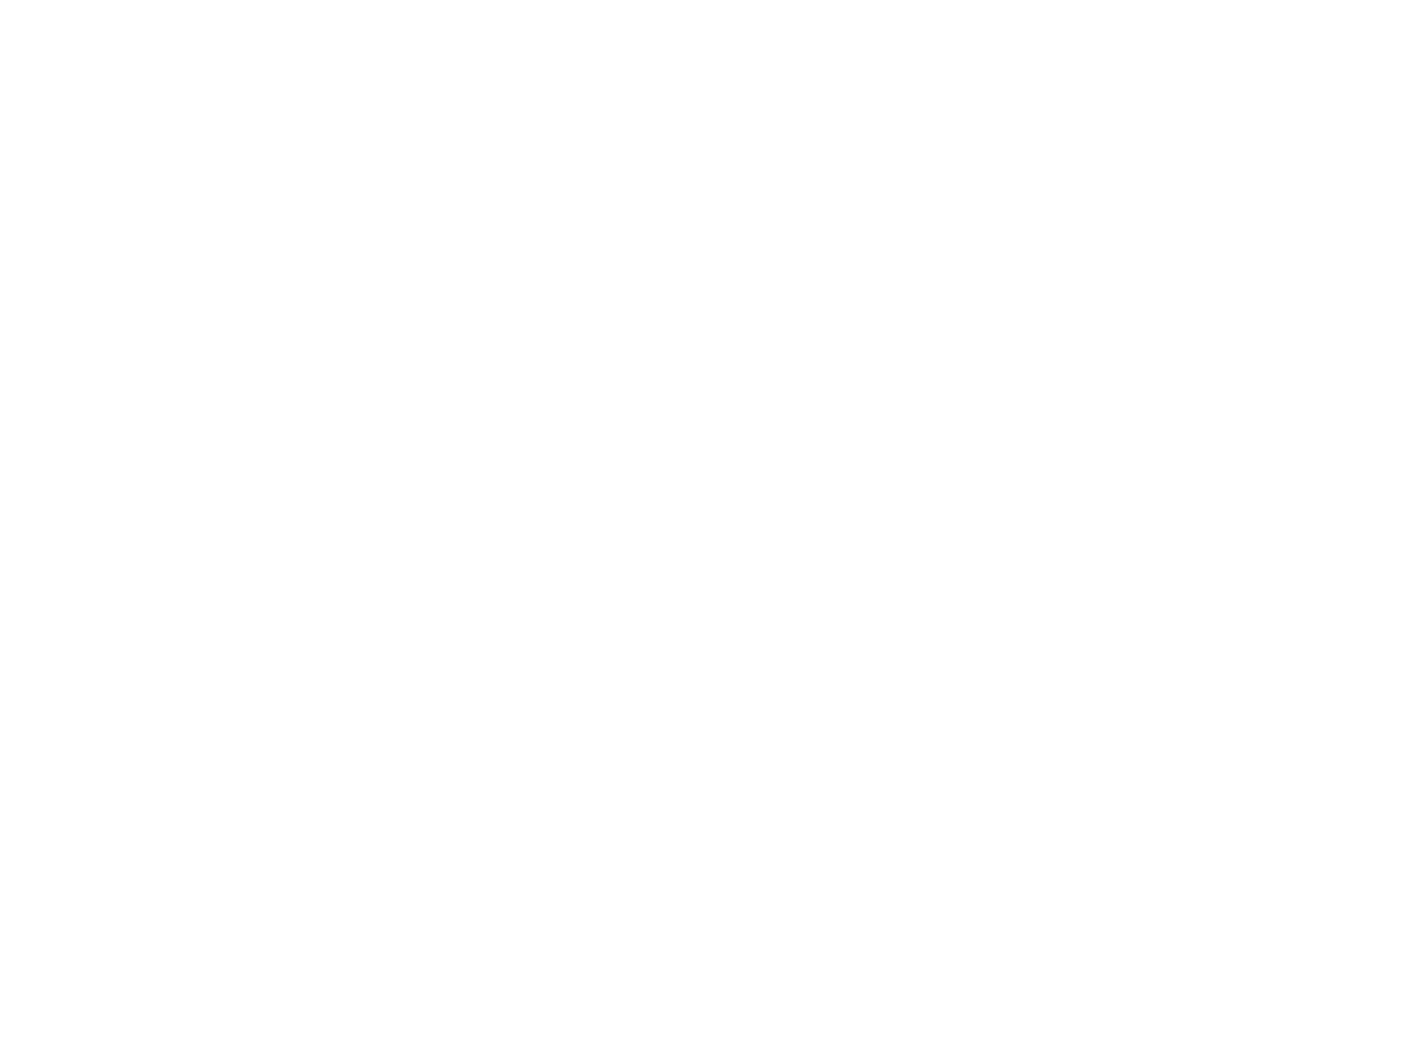

<IPython.core.display.Javascript object>


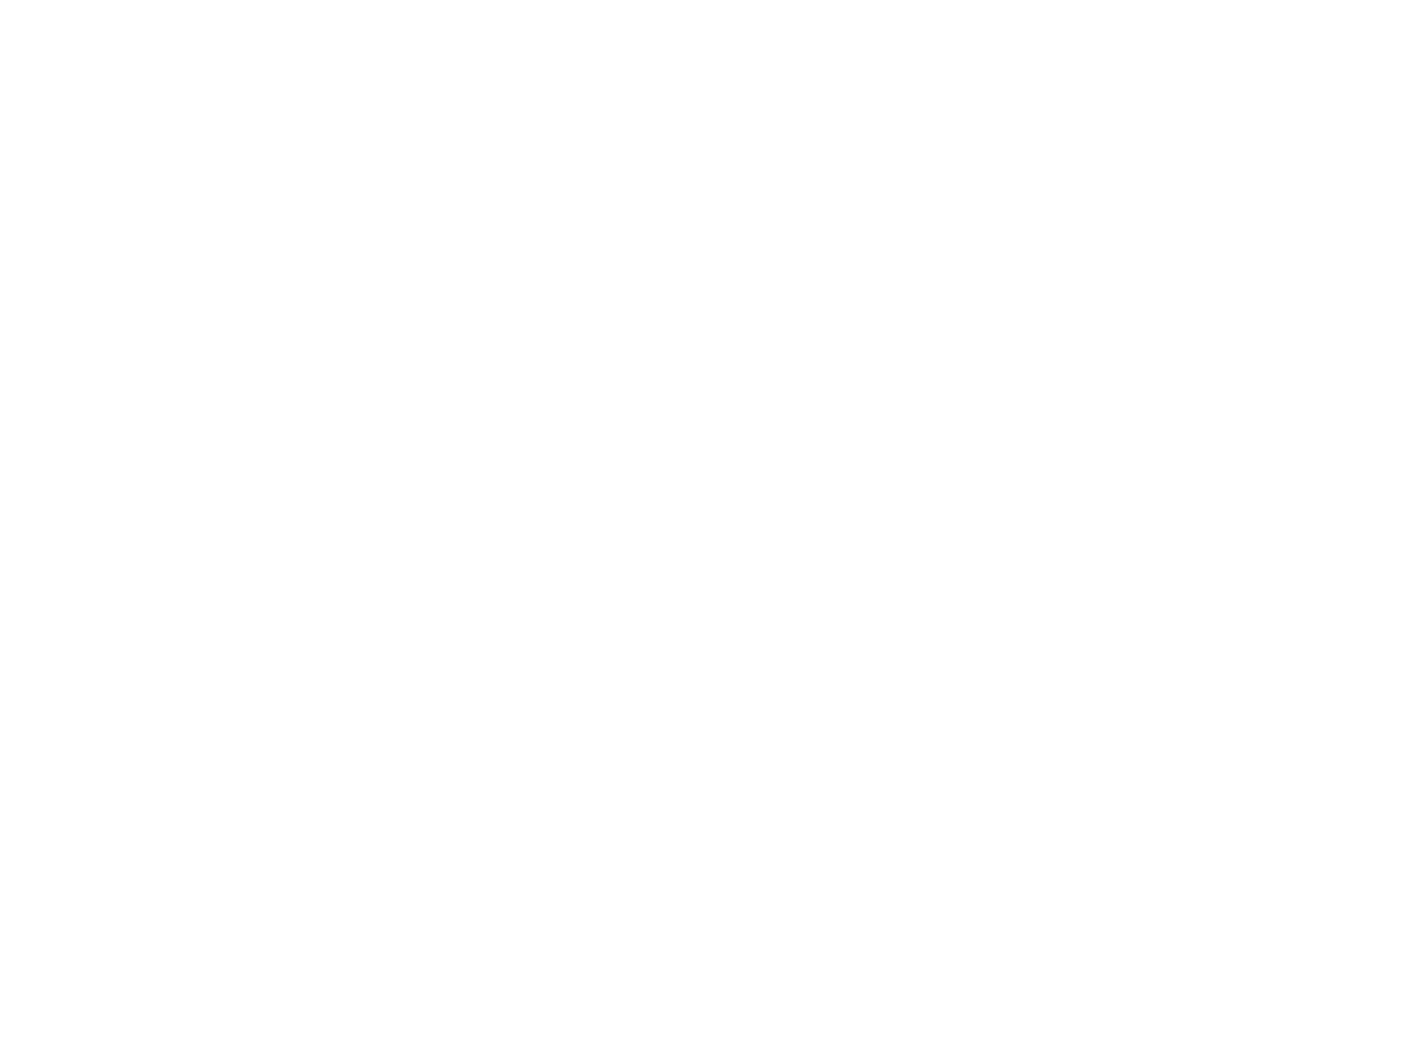

<IPython.core.display.Javascript object>


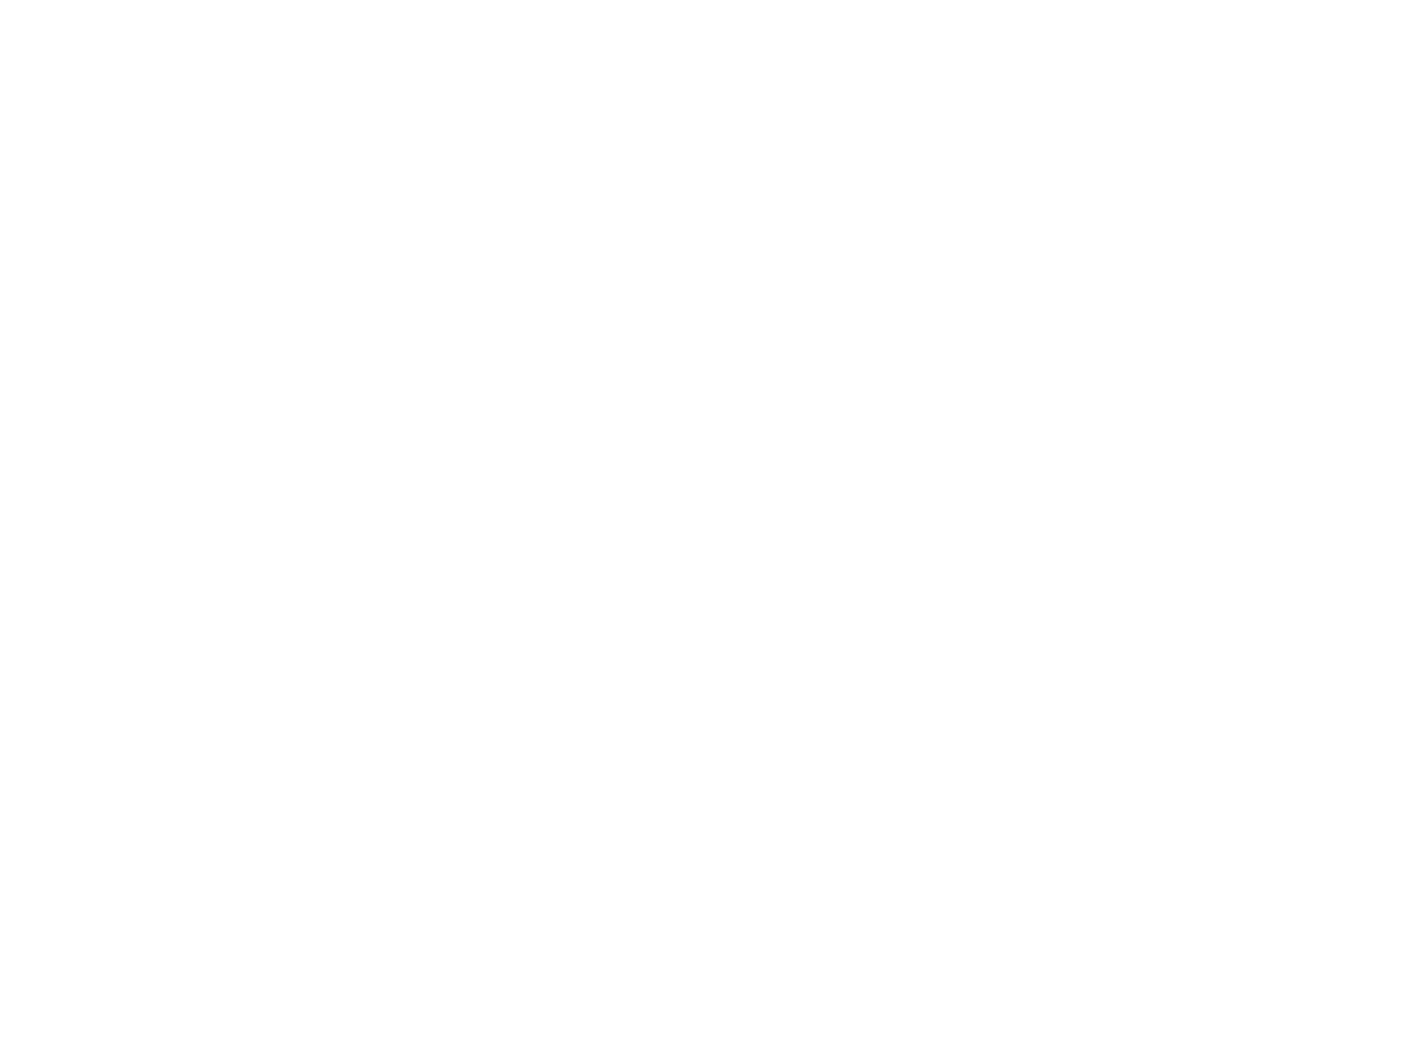

<IPython.core.display.Javascript object>


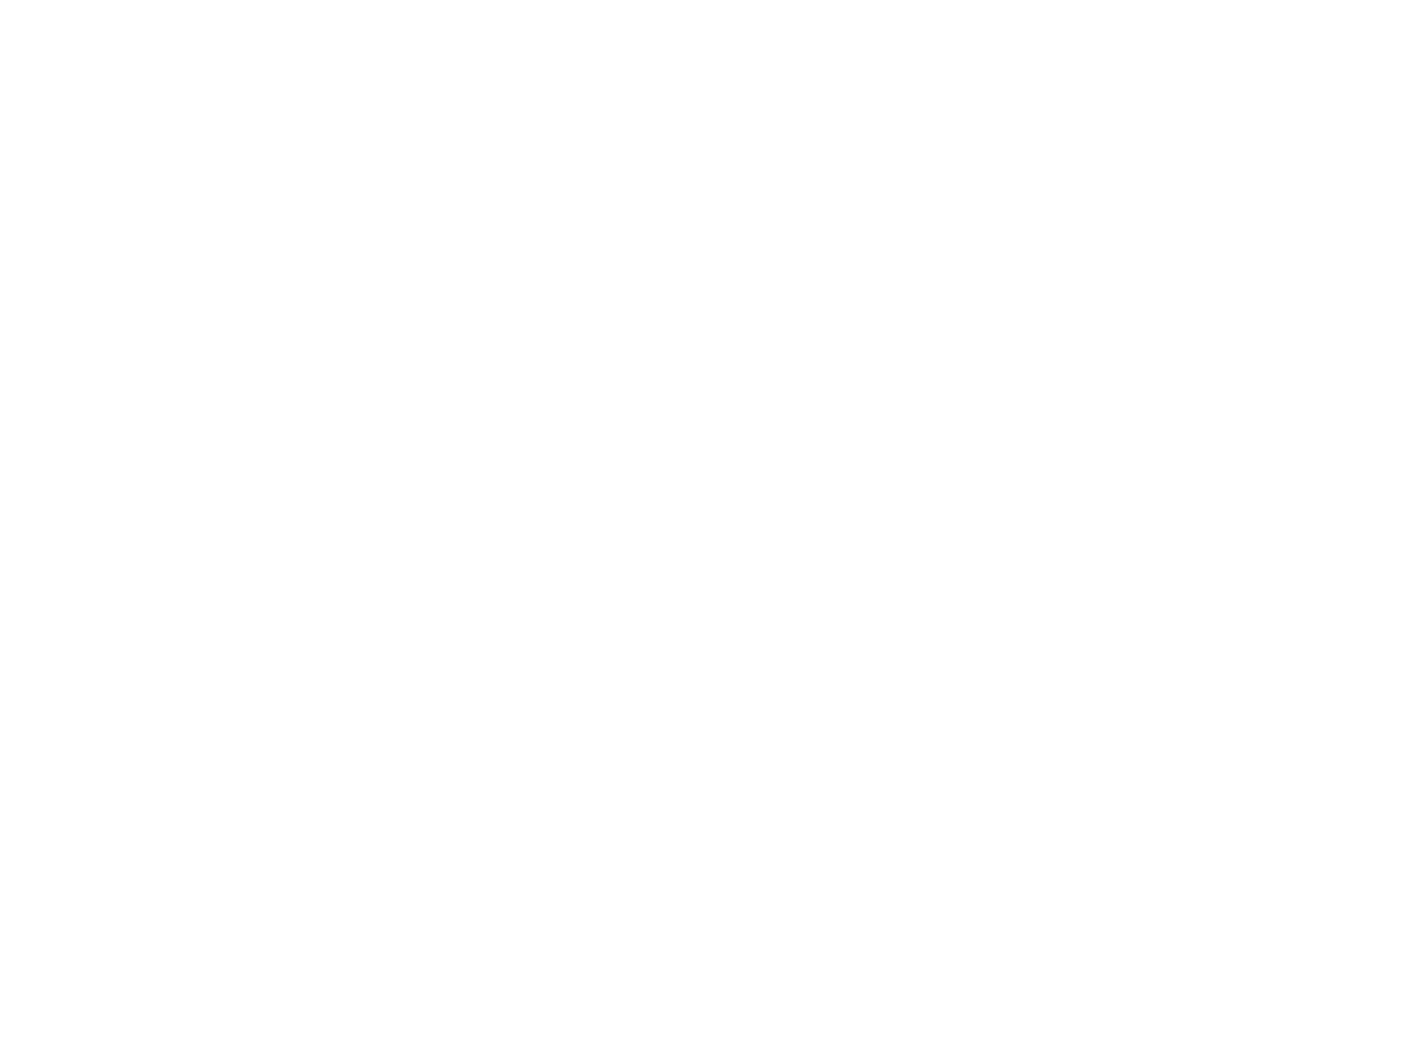

<IPython.core.display.Javascript object>


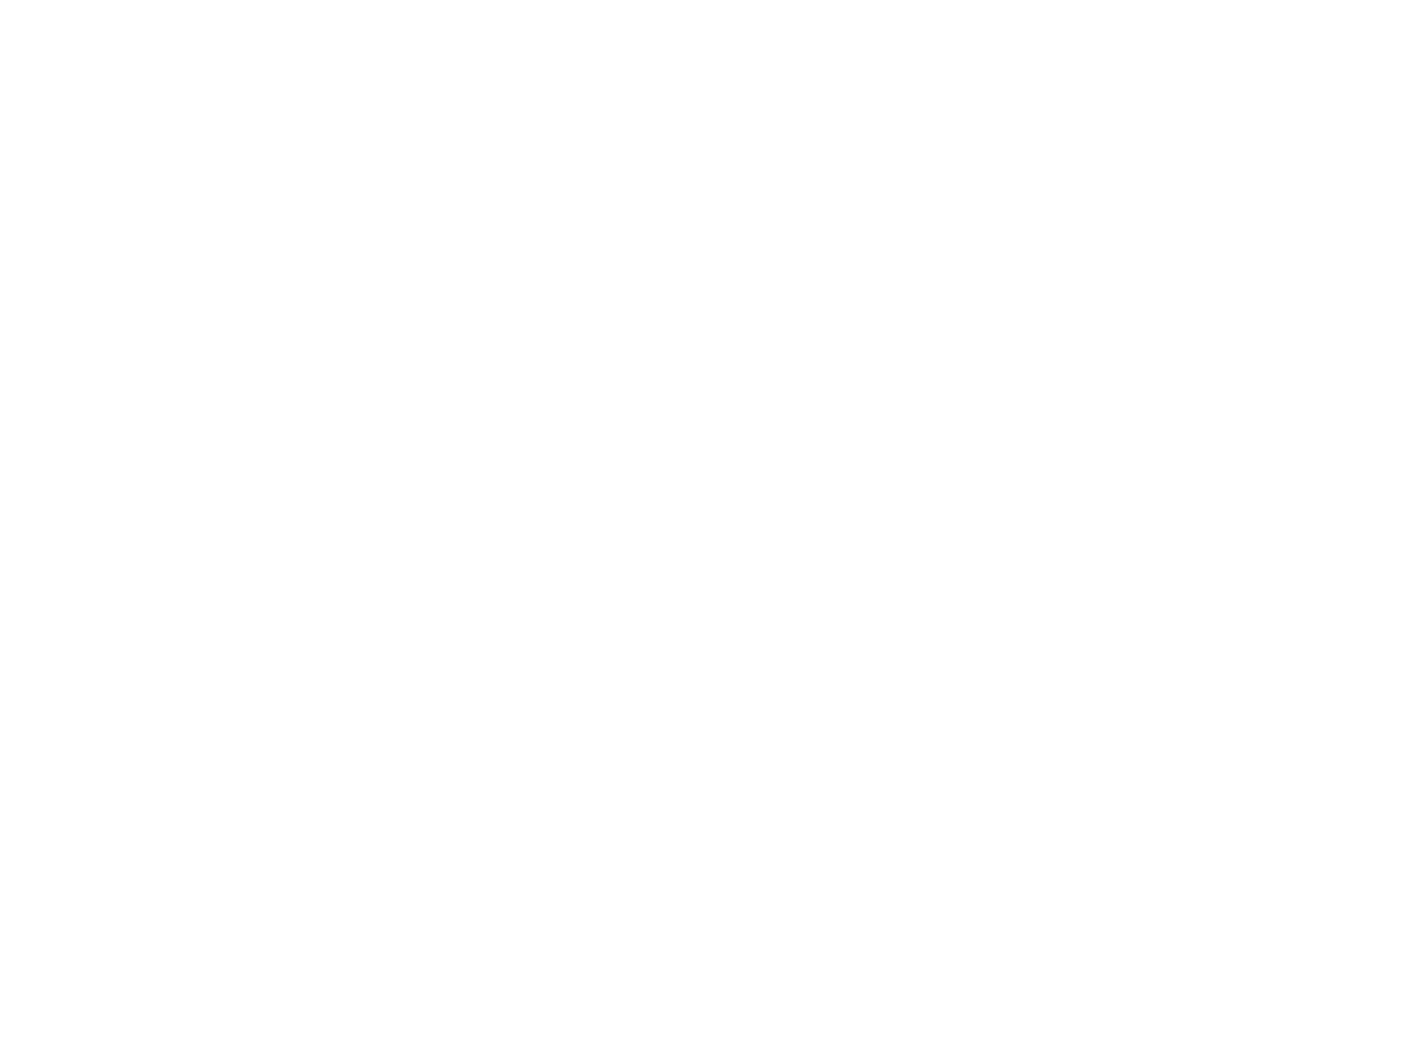

<IPython.core.display.Javascript object>


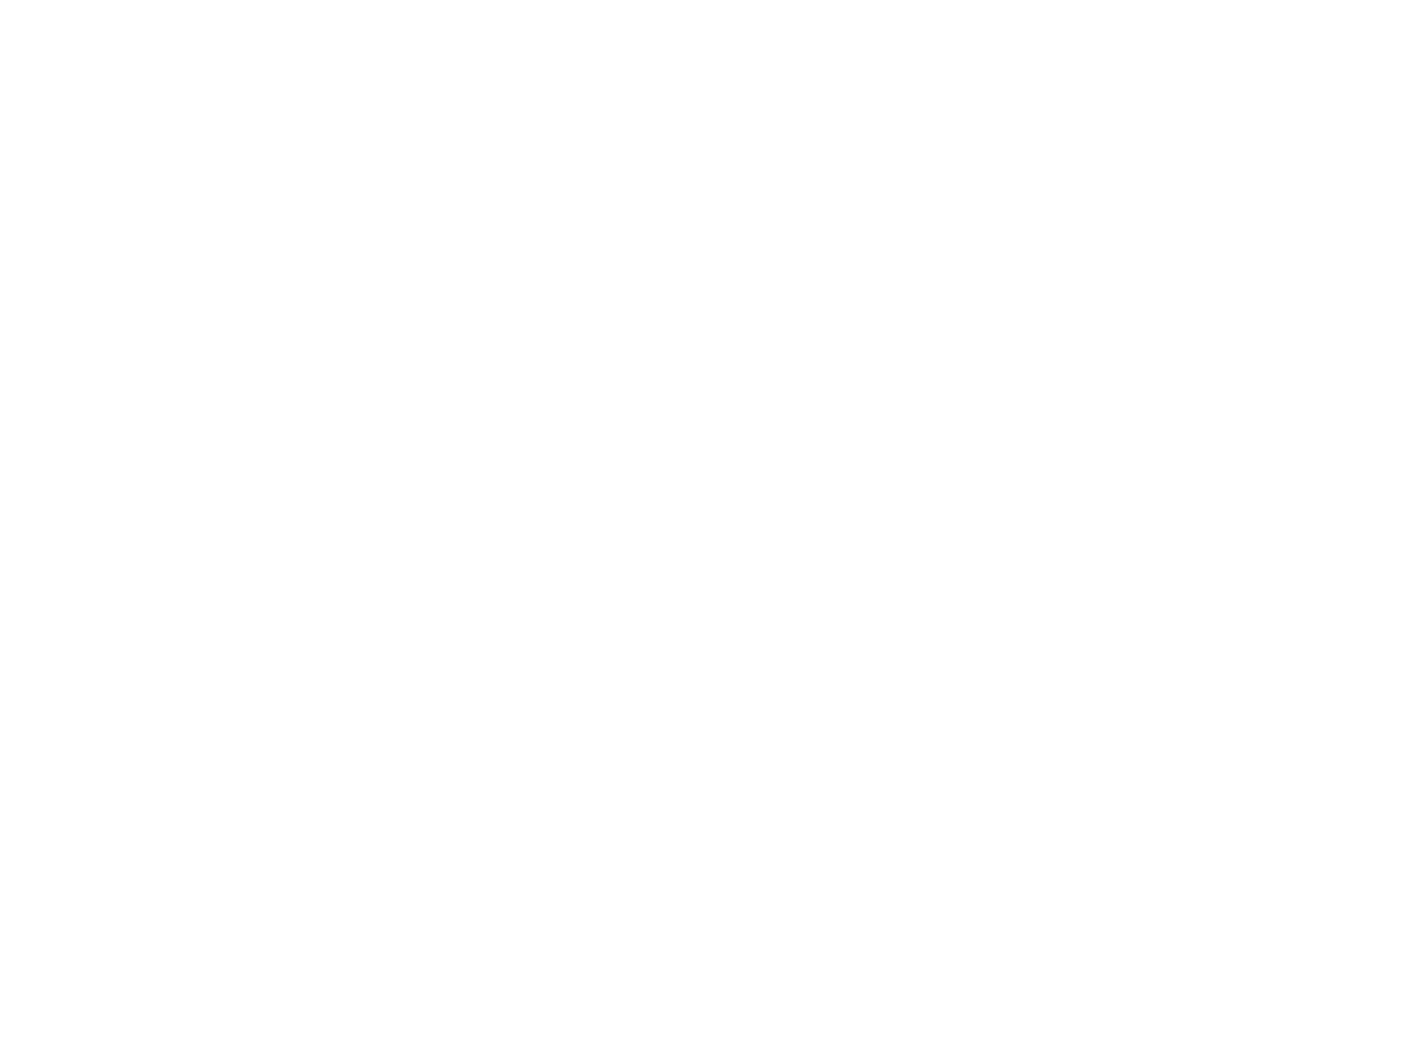

<IPython.core.display.Javascript object>


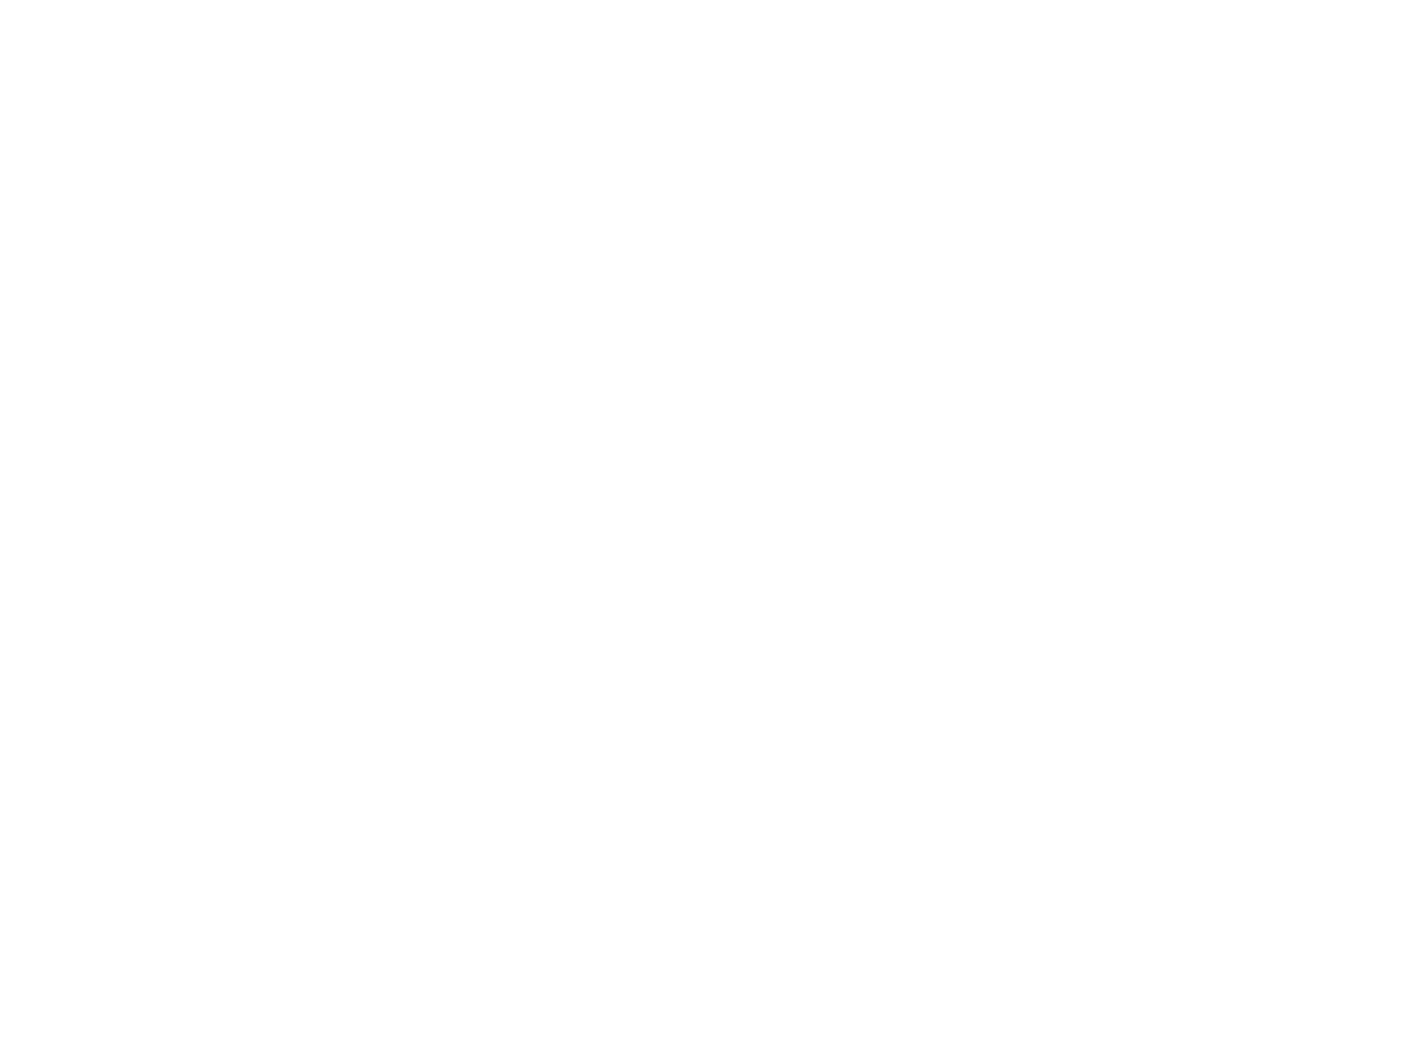

In [83]:
#plotting histograms of tSNR per ROI
tsnr_full = np.zeros(nonzerovar_mask.shape)
tsnr = tc_mean/np.sqrt(tc_var)
tsnr_full[nonzerovar_mask]=tsnr
for roi in idx_rois:
    pl.figure()
    pl.title(roi)
    pl.hist(tsnr_full[idx_rois[roi]],bins=100)
    pl.show()
    pl.close()

In [11]:
#data quality/stats cortex visualization

mean_ts_vert = cortex.Vertex2D(tc_mean_full, nonzerovar_mask*(tc_mean_full>45000), subject=subj, cmap='Jet_2D_alpha')
var_ts_vert = cortex.Vertex2D(tc_var_full, nonzerovar_mask, subject=subj, cmap='Jet_2D_alpha')
tsnr_vert = cortex.Vertex2D(tsnr_full, nonzerovar_mask, subject=subj, cmap='Jet_2D_alpha')

data_stats ={'mean':mean_ts_vert.raw, 'var':var_ts_vert.raw, 'tsnr':tsnr_vert.raw}

cortex.webgl.show(data_stats,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True,
                 with_borders=True, 
                 with_colorbar=True)

Started server on port 21858


<JS: window.viewer>

Stopping server


In [84]:
#(this is now included in preprocessing) correcting for low variance TCs (below 0.25% signal change) 
tc_mean = timecourse.mean(-1)
low_var = (timecourse - tc_mean[...,np.newaxis]).max(-1) < tc_mean*0.25/100

print("low var vertices: "+str(np.sum(low_var)))

gauss[low_var]=0
css_res[low_var]=0
dog_res[low_var]=0
norm_res[low_var]=0

low var vertices: 0


In [8]:
%%capture
#RSQ
rsq = np.zeros((nonzerovar_mask.shape[0],4))
rsq[nonzerovar_mask,0] = gauss[:,-1]
rsq[nonzerovar_mask,1] = css_res[:, -1]
rsq[nonzerovar_mask,2] = dog_res[:, -1]
rsq[nonzerovar_mask,3] = norm_res[:, -1]

#prf ecc
ecc = np.zeros((nonzerovar_mask.shape[0],4))
ecc[nonzerovar_mask,0] = np.sqrt(gauss[:,0]**2+gauss[:,1]**2)
ecc[nonzerovar_mask,1] = np.sqrt(css_res[:,0]**2+css_res[:,1]**2)
ecc[nonzerovar_mask,2] = np.sqrt(dog_res[:,0]**2+dog_res[:,1]**2)
ecc[nonzerovar_mask,3] = np.sqrt(norm_res[:,0]**2+norm_res[:,1]**2)

#prf polar angle
polar = np.zeros((nonzerovar_mask.shape[0],4))
polar[nonzerovar_mask,0] = np.arctan2(gauss[:,0], -gauss[:,1])
polar[nonzerovar_mask,1] = np.arctan2(css_res[:,0], -css_res[:,1])
polar[nonzerovar_mask,2] = np.arctan2(dog_res[:,0], -dog_res[:,1])
polar[nonzerovar_mask,3] = np.arctan2(norm_res[:,0], -norm_res[:,1])

#prf size
size = np.zeros((nonzerovar_mask.shape[0],4))
size[nonzerovar_mask,0] = gauss[:,2]
size[nonzerovar_mask,1] = css_res[:,2]
size[nonzerovar_mask,2] = dog_res[:,2]
size[nonzerovar_mask,3] = norm_res[:,2]

#prf amplitude
amp = np.zeros((nonzerovar_mask.shape[0],4))
amp[nonzerovar_mask,0] = gauss[:,3]
amp[nonzerovar_mask,1] = css_res[:,3]
amp[nonzerovar_mask,2] = dog_res[:,3]
amp[nonzerovar_mask,3] = norm_res[:,3]

#BOLD baseline
bold_base = np.zeros((nonzerovar_mask.shape[0],4))
bold_base[nonzerovar_mask,0] = gauss[:,4]
bold_base[nonzerovar_mask,1] = css_res[:,4]
bold_base[nonzerovar_mask,2] = dog_res[:,4]
bold_base[nonzerovar_mask,3] = norm_res[:,4]

#css exponent
css_exp = np.zeros(nonzerovar_mask.shape[0])
css_exp[nonzerovar_mask] = css_res[:,5]

#surround amplitude
surr_amp = np.zeros((nonzerovar_mask.shape[0],2))
surr_amp[nonzerovar_mask,0] = dog_res[:,5]
surr_amp[nonzerovar_mask,1] = norm_res[:,5]

#surround size
surr_size = np.zeros((nonzerovar_mask.shape[0],2))
surr_size[nonzerovar_mask,0] = dog_res[:,6]
surr_size[nonzerovar_mask,1] = norm_res[:,6]

#fwhmax
fw_hmax = np.zeros((nonzerovar_mask.shape[0],4))
fw_hmax[nonzerovar_mask,0] = fwhmax('Gauss', gauss)
fw_hmax[nonzerovar_mask,1] = fwhmax('CSS', css_res)
fw_hmax[nonzerovar_mask,2] = fwhmax('DoG', dog_res)
fw_hmax[nonzerovar_mask,3] = fwhmax('Norm', norm_res)

#fwatmin
fw_atmin = np.zeros((nonzerovar_mask.shape[0],2))
fw_atmin[nonzerovar_mask,0] = fwatmin('DoG', dog_res)
fw_atmin[nonzerovar_mask,1] = fwatmin('Norm', norm_res)

#normalization model baselines (neural and surround, ratio, (a+b/(c+d)))
baselines = np.zeros((nonzerovar_mask.shape[0],4))
baselines[nonzerovar_mask,0] = norm_res[:,7]
baselines[nonzerovar_mask,1] = norm_res[:,8]
baselines[nonzerovar_mask,2] = norm_res[:,7]/norm_res[:,8]
baselines[nonzerovar_mask,3] = (norm_res[:,3]+norm_res[:,7])/(norm_res[:,5]+norm_res[:,8])

In [15]:
#min time series threshold for each subject determined by inspecting mean tc map
if subj == 'sub-006':
    tc_min = 45000
elif subj == 'sub-007':
    tc_min = 30000
elif subj == 'sub-001':
    tc_min = 35000

alpha = rsq.max(-1) * (ecc.max(-1)<4.5) * (ecc.min(-1)>0.5) * (amp.min(-1)>0) * (tc_mean_full>tc_min)

alpha_gauss = rsq[:,0] * (ecc[:,0]<4.5) * (ecc[:,0]>0.5) * (amp[:,0]>0) * (tc_mean_full>tc_min)
alpha_css = rsq[:,1] * (ecc[:,1]<4.5) * (ecc[:,1]>0.5) * (amp[:,1]>0) * (tc_mean_full>tc_min)
alpha_dog = rsq[:,2] * (ecc[:,2]<4.5) * (ecc[:,2]>0.5) * (amp[:,2]>0) * (tc_mean_full>tc_min)
alpha_norm = rsq[:,3] * (ecc[:,3]<4.5) * (ecc[:,3]>0.5) * (amp[:,3]>0) * (tc_mean_full>tc_min)

alpha_dict = {'all':alpha,
             'Gauss':alpha_gauss,
             'CSS':alpha_css,
             'DoG':alpha_dog,
             'Norm':alpha_norm}

In [17]:
#use e.g. roi_mask(V1,alpha) or roi_mask(idx_rois["FEF"],alpha) as dim2 to plot only for specific ROIs

rsq_diff_cssgauss = cortex.Vertex2D(rsq[:,1]-rsq[:,0], alpha, subject=subj,
                                              vmin=0, vmax=0.1, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')

rsq_diff_doggauss = cortex.Vertex2D(rsq[:,2]-rsq[:,0], alpha, subject=subj,
                                          vmin=0, vmax=0.1, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')

rsq_diff_normgauss = cortex.Vertex2D(rsq[:,3]-rsq[:,0], alpha, subject=subj,
                                          vmin=0, vmax=0.1, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')

rsq_diff_normdog = cortex.Vertex2D(rsq[:,3]-rsq[:,2], alpha, subject=subj,
                                          vmin=0, vmax=0.1, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')

rsq_diff_normcss = cortex.Vertex2D(rsq[:,3]-rsq[:,1], alpha, subject=subj, 
                                          vmin=-0.02, vmax=0.02, vmin2=0.3, vmax2=0.6, cmap='Jet_2D_alpha')

#NOTE: MULTIPLE VERTEX2D IN ONE DATASET = BUGGY
ds_rsq = {'CSS - Gauss':rsq_diff_cssgauss.raw, 'DoG -  Gauss':rsq_diff_doggauss.raw, 'Norm - Gauss':rsq_diff_normgauss.raw,
    'Norm - DoG':rsq_diff_normdog.raw, 'Norm - CSS':rsq_diff_normcss.raw}

cortex.webgl.show(ds_rsq,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True,
                 with_borders=True, 
                 with_colorbar=True)

Started server on port 27687


<JS: window.viewer>

Stopping server


In [768]:
#plot ecc on cortex
ecc_gauss = cortex.Vertex2D(ecc[:,0], alpha, subject=subj, vmin=0.5, vmax=4.5, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
ecc_css = cortex.Vertex2D(ecc[:,1], alpha, subject=subj, vmin=0.5, vmax=4.5, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
ecc_dog = cortex.Vertex2D(ecc[:,2], alpha, subject=subj, vmin=0.5, vmax=4.5, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
ecc_norm = cortex.Vertex2D(ecc[:,3], alpha, subject=subj, vmin=0.5, vmax=4.5, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')

ds_ecc = {'Ecc Gauss':ecc_gauss.raw, 'Ecc CSS':ecc_css.raw, 'Ecc DoG':ecc_dog.raw, 'Ecc Norm':ecc_norm.raw}

cortex.webgl.show(ds_ecc,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True, 
                 with_borders=True, 
                 with_colorbar=True)

Started server on port 17665


<JS: window.viewer>

Stopping server
Stopping server


In [894]:
#plot polar angle on cortex
alpha_roi = roi_mask(idx_rois['V1'],alpha)

polar_gauss = cortex.Vertex2D(polar[:,0], alpha_roi, subject=subj, vmin2=0.2, vmax2=0.6, cmap='Retinotopy_HSV_2x_alpha')
polar_css = cortex.Vertex2D(polar[:,1], alpha_roi, subject=subj, vmin2=0.2, vmax2=0.6, cmap='Retinotopy_HSV_2x_alpha')
polar_dog = cortex.Vertex2D(polar[:,2], alpha_roi, subject=subj, vmin2=0.2, vmax2=0.6, cmap='Retinotopy_HSV_2x_alpha')
polar_norm = cortex.Vertex2D(polar[:,3], alpha_roi, subject=subj, vmin2=0.2, vmax2=0.6, cmap='Retinotopy_HSV_2x_alpha')

polar_norm_full = cortex.Vertex2D(polar[:,3], alpha, subject=subj, vmin2=0.2, vmax2=0.6, cmap='Retinotopy_HSV_2x_alpha')


ds_polar = {'polar Gauss':polar_gauss.raw, 'polar CSS':polar_css.raw, 'polar DoG':polar_dog.raw, 'polar Norm':polar_norm.raw,
           'polar norm full':polar_norm_full.raw}

cortex.webgl.show(ds_polar,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True, 
                 with_borders=True, 
                 with_colorbar=True)

Started server on port 7637


<JS: window.viewer>

Stopping server


In [166]:
#plot fw_hmax on cortex
fw_hmax_gauss = cortex.Vertex2D(fw_hmax[:,0], alpha, subject=subj, vmin=0, vmax=3, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
fw_hmax_css = cortex.Vertex2D(fw_hmax[:,1], alpha, subject=subj, vmin=0, vmax=3, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
fw_hmax_dog = cortex.Vertex2D(fw_hmax[:,2], alpha, subject=subj, vmin=0, vmax=3, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
fw_hmax_norm = cortex.Vertex2D(fw_hmax[:,3], alpha, subject=subj, vmin=0, vmax=3, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')

ds_fw_hmax = {'fw_hmax Gauss':fw_hmax_gauss.raw, 'fw_hmax CSS':fw_hmax_css.raw, 'fw_hmax DoG':fw_hmax_dog.raw, 'fw_hmax Norm':fw_hmax_norm.raw}

cortex.webgl.show(ds_fw_hmax,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True, 
                 with_borders=True, 
                 with_colorbar=True)

Started server on port 13337


<JS: window.viewer>

Stopping server


In [388]:
#plot amp on cortex
amp_gauss = cortex.Vertex2D(amp[:,0], alpha, subject=subj, vmin=0, vmax=1000, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
amp_css = cortex.Vertex2D(amp[:,1], alpha, subject=subj, vmin=0, vmax=1000, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
amp_dog = cortex.Vertex2D(amp[:,2], alpha, subject=subj, vmin=0, vmax=1000, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
amp_norm = cortex.Vertex2D(amp[:,3], alpha, subject=subj, vmin=0, vmax=1000, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')

ds_amp = {'amp Gauss':amp_gauss.raw, 
          'amp CSS':amp_css.raw, 
          'amp DoG':amp_dog.raw, 
          'amp Norm':amp_norm.raw}

cortex.webgl.show(ds_amp,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True, 
                 with_borders=True, 
                 with_colorbar=True)

Started server on port 47489


<JS: window.viewer>

Stopping server


In [857]:
#CSS exponent
ds_css_exp = {'CSS Exponent':cortex.Vertex2D(css_exp, alpha_css, subject=subj,
                                             vmin=0, vmax=0.75, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha').raw}
cortex.webgl.show(ds_css_exp,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True, 
                 with_borders=True, 
                 with_colorbar=True)


Started server on port 63723


<JS: window.viewer>

Stopping server


In [167]:
#plot fw_atmin on cortex
fw_atmin_dog = cortex.Vertex2D(fw_atmin[:,0], alpha_dog, subject=subj,
                                vmax=50, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
fw_atmin_norm = cortex.Vertex2D(fw_atmin[:,1], alpha_norm, subject=subj,
                                  vmax=50, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')

ds_fw_atmin = {'fw_atmin DoG':fw_atmin_dog.raw, 'fw_atmin Norm':fw_atmin_norm.raw}

cortex.webgl.show(ds_fw_atmin,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True, 
                 with_borders=True, 
                 with_colorbar=True)

Started server on port 29199


<JS: window.viewer>

Stopping server


In [11]:
%%capture
#norm baselines non resc (-18 18 norm -8 8 surr -25 15 ratio, 3 9 abcd); resc: norm (-35 4), ratio -15,25, abcs -9, 2

#neural_baseline_resc = cortex.Vertex2D(np.log(baselines[:,0]/tc_mean_full), alpha_norm_norm, subject=subj,
#                                vmin=-35, vmax=4, vmin2=0.3, vmax2=0.6, cmap='Jet_2D_alpha_norm')

neural_baseline = cortex.Vertex2D(np.log(baselines[:,0]), alpha_norm, subject=subj,
                                vmin=-18, vmax=15, vmin2=0.3, vmax2=0.6, cmap='Jet_2D_alpha')

surr_baseline = cortex.Vertex2D(np.log(baselines[:,1]), alpha_norm, subject=subj,
                                 vmin=-8, vmax=8, vmin2=0.3, vmax2=0.6, cmap='Jet_2D_alpha')

ratio_baseline = cortex.Vertex2D(np.log(baselines[:,2]), alpha_norm, subject=subj,
                                 vmin=-25, vmax=15, vmin2=0.3, vmax2=0.6, cmap='Jet_2D_alpha')

abcd = cortex.Vertex2D(np.log(baselines[:,3]), alpha_norm, subject=subj,
                                 vmin=3, vmax=9, vmin2=0.3, vmax2=0.6, cmap='Jet_2D_alpha')

ds_baselines = {'Neural baseline':neural_baseline.raw,
                'Surround baseline':surr_baseline.raw,
               'Ratio (b/d)': ratio_baseline.raw, 'max norm amplitude (a+b)/(c+d)': abcd.raw}


cortex.webgl.show(ds_baselines,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True, 
                 with_borders=True, 
                 with_colorbar=True)

<IPython.core.display.Javascript object>


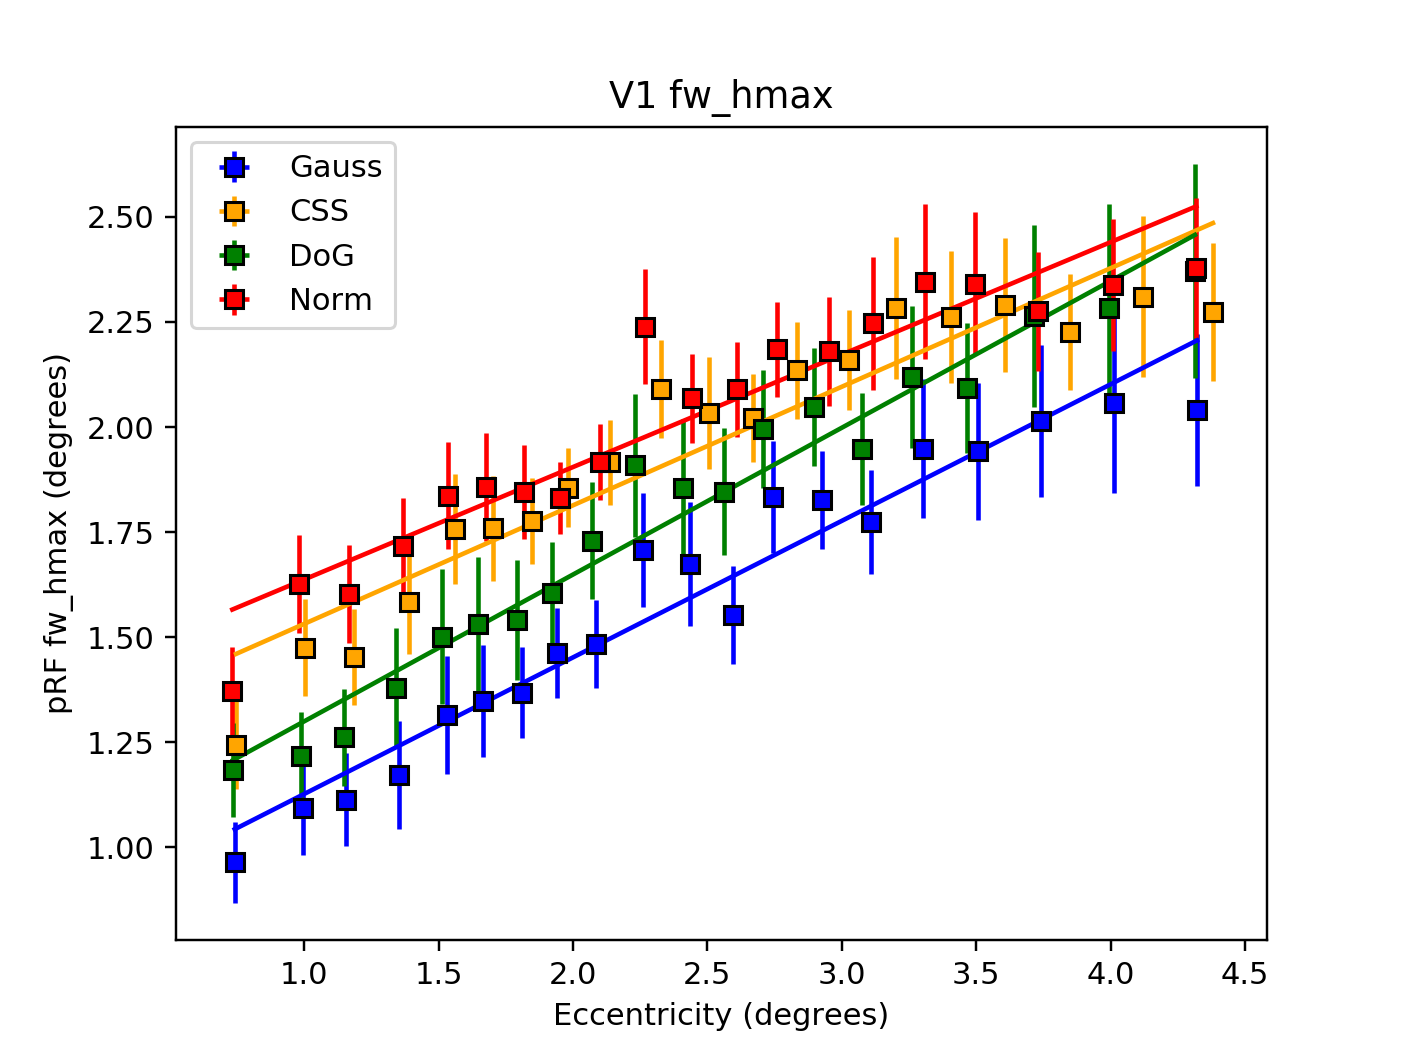

V1 Gauss 0.24288491806507528
V1 CSS 0.19368449356140094
V1 DoG 0.2137459002546065
V1 Norm 0.17022897311995022


<IPython.core.display.Javascript object>


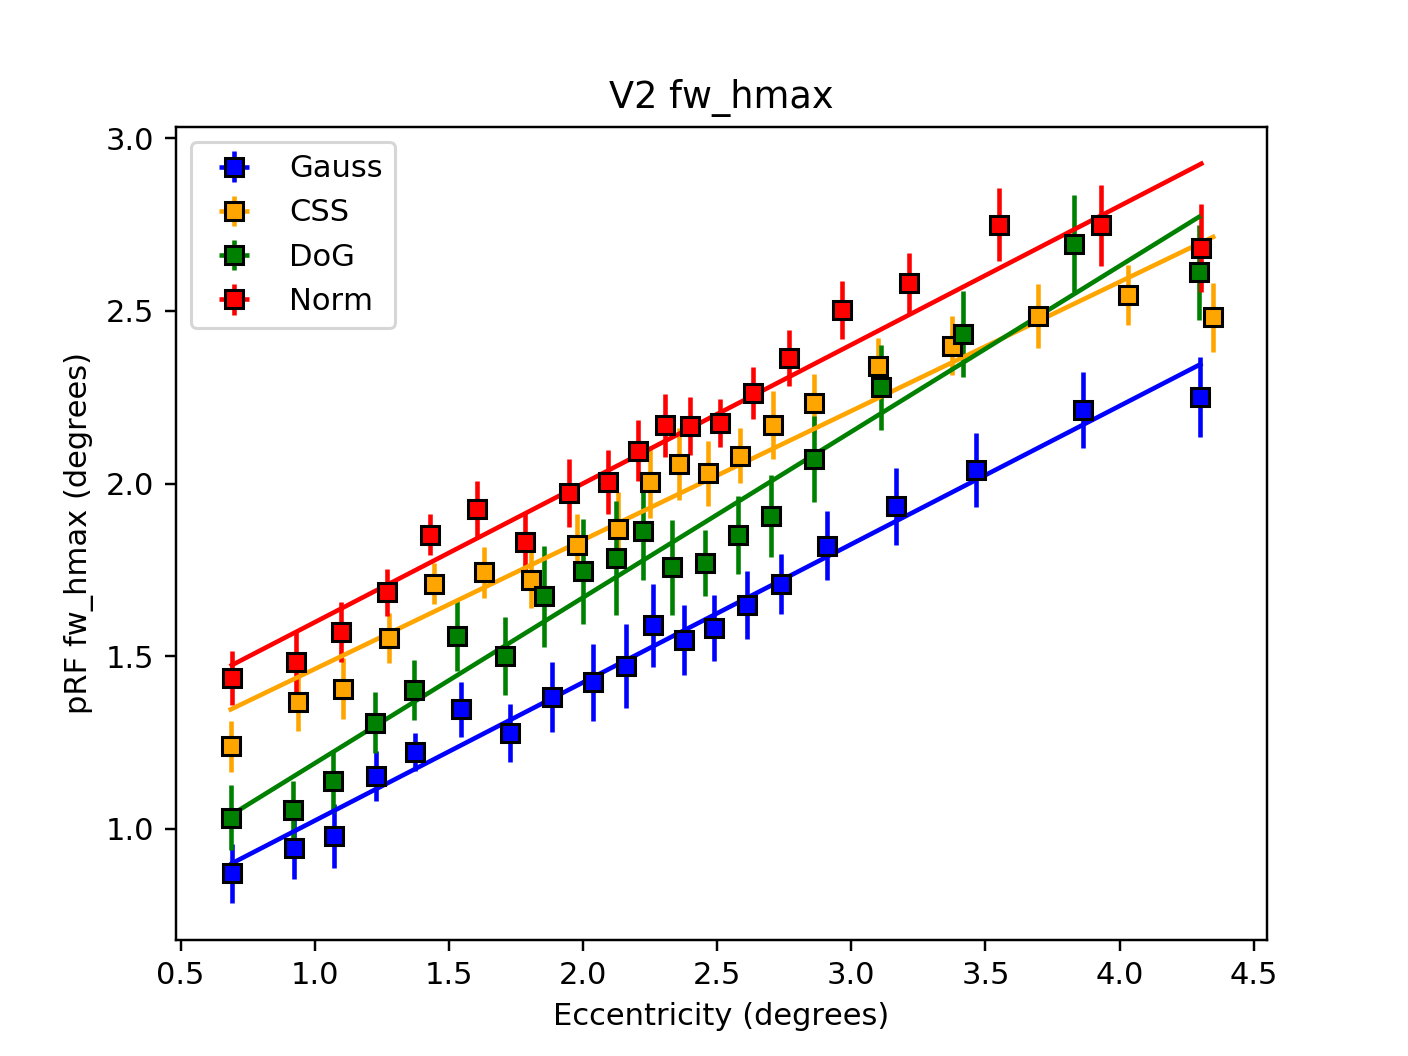

V2 Gauss 0.38961007079585613
V2 CSS 0.38183530911052355
V2 DoG 0.36333678168288697
V2 Norm 0.39475462360808883


<IPython.core.display.Javascript object>


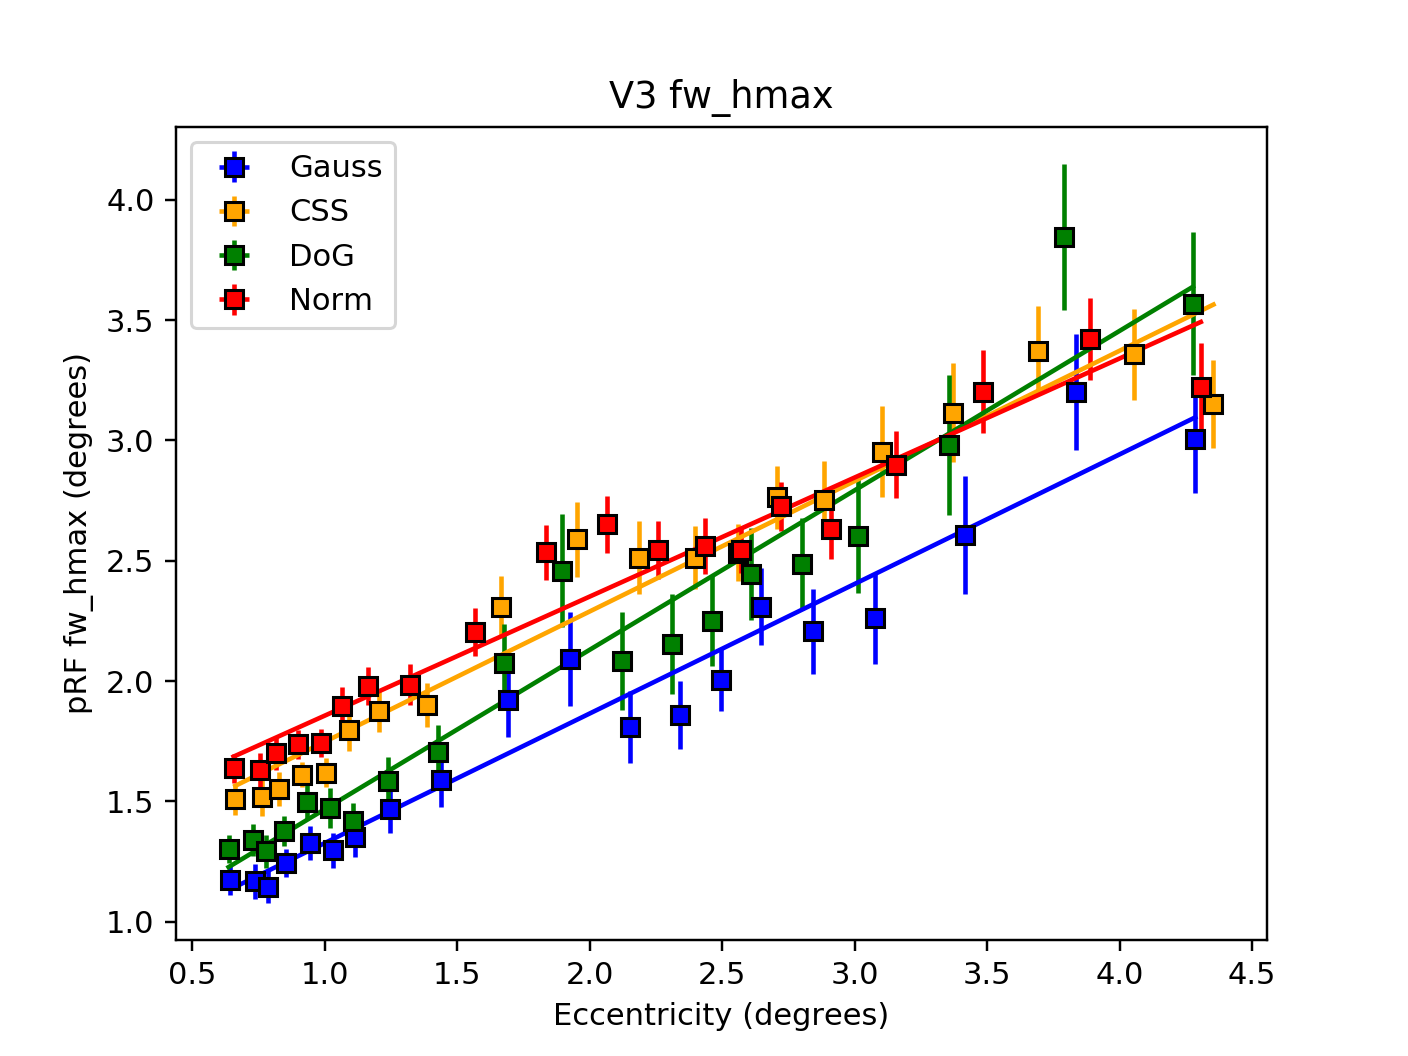

V3 Gauss 0.4225855837466261
V3 CSS 0.4280831627918864
V3 DoG 0.4136699250336464
V3 Norm 0.45358505128887716


In [47]:
# binned eccentricity vs other parameters relationships

rsq_thresh = 0.3

colors = ['blue','orange','green','red']

fw_hmax_stats = {}
ecc_stats = {}

for roi in ['V1', 'V2', 'V3']:#idx_rois:
    
    pl.figure(roi+' fw_hmax')
    pl.title(roi+' fw_hmax')
    
    fw_hmax_stats[roi] = {}
    ecc_stats[roi] = {}
    
    #same alpha for all
    #alpha_roi = roi_mask(idx_rois[roi],alpha)>rsq_thresh
    #ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
    #split_ecc_bins = np.array_split(ecc_sorted, 20, axis=0)    
    
    for i, model in enumerate(['Gauss','CSS','DoG','Norm']):
        fw_hmax_stats[roi][model]=[]
        ecc_stats[roi][model]=[]
        
        #model-specific alpha
        alpha_roi = roi_mask(idx_rois[roi],alpha_dict[model])>rsq_thresh      
        ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
        split_ecc_bins = np.array_split(ecc_sorted, 20, axis=0)
    
        for ecc_quantile in split_ecc_bins:
            fw_hmax_stats[roi][model].append(weightstats.DescrStatsW(fw_hmax[alpha_roi,i][ecc_quantile[:,i]],
                                                                  weights=rsq[alpha_roi,i][ecc_quantile[:,i]]))

            ecc_stats[roi][model].append(weightstats.DescrStatsW(ecc[alpha_roi,i][ecc_quantile[:,i]],
                                                                  weights=rsq[alpha_roi,i][ecc_quantile[:,i]]))
            


        WLS = LinearRegression()
        WLS.fit(ecc[alpha_roi,i].reshape(-1, 1), fw_hmax[alpha_roi,i], sample_weight=rsq[alpha_roi,i])
        pl.plot([ss.mean for ss in ecc_stats[roi][model]],
                WLS.predict(np.array([ss.mean for ss in ecc_stats[roi][model]]).reshape(-1, 1)),
                color=colors[i])
        
        print(roi+" "+model+" "+str(WLS.score(ecc[alpha_roi,i].reshape(-1, 1), fw_hmax[alpha_roi,i], sample_weight=rsq[alpha_roi,i])))
        
        plot = pl.errorbar([ss.mean for ss in ecc_stats[roi][model]],
           [ss.mean for ss in fw_hmax_stats[roi][model]],
           yerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in fw_hmax_stats[roi][model]]).T,
           xerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in ecc_stats[roi][model]]).T,
           fmt='s', mfc=colors[i], mec='black', label=model, ecolor=colors[i])
        
        pl.xlabel('Eccentricity (degrees)')
        pl.ylabel('pRF fw_hmax (degrees)')
    
    pl.legend(loc=0)
    


<IPython.core.display.Javascript object>


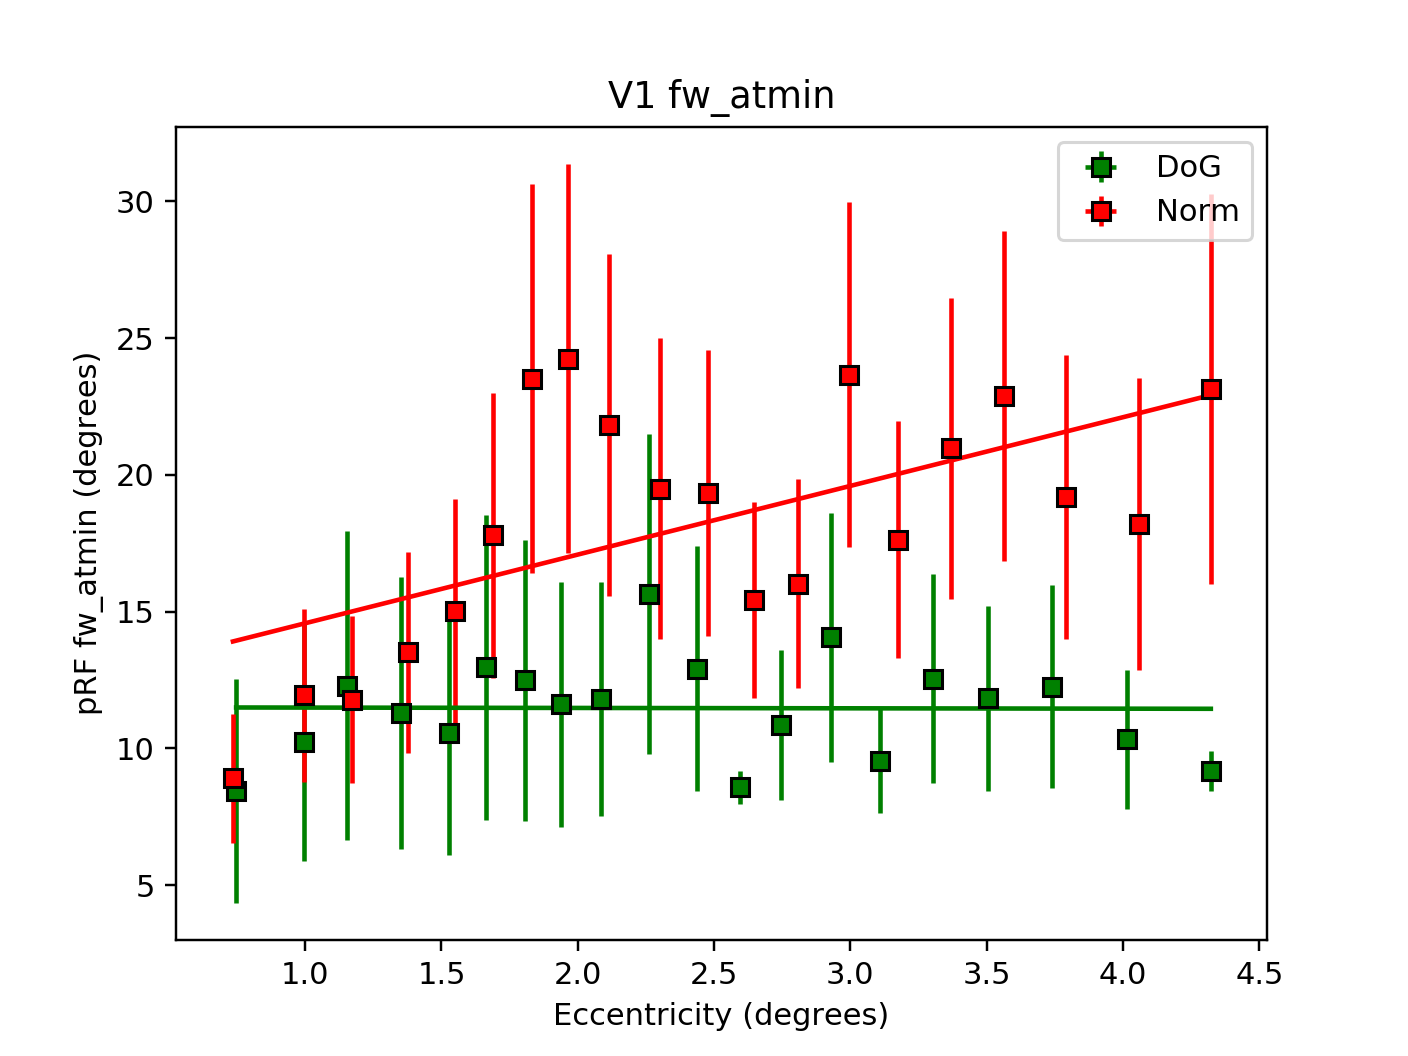

V1 DoG 6.379970363123988e-07
V1 Norm 0.012065222843463676


<IPython.core.display.Javascript object>


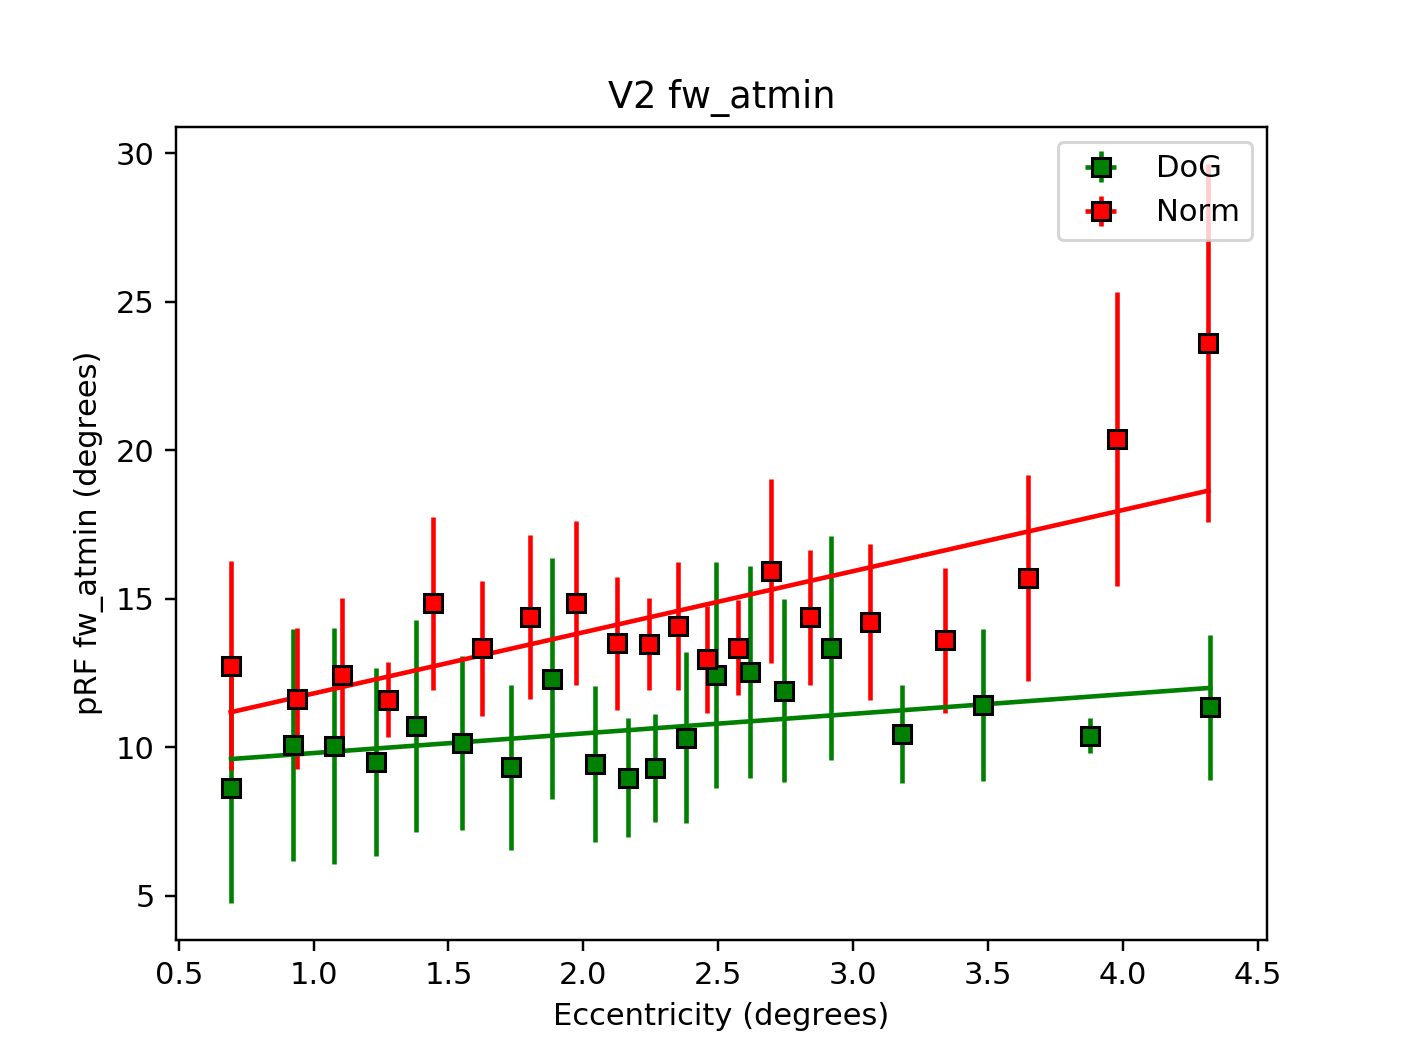

V2 DoG 0.0017095880316071455
V2 Norm 0.016799076863497686


<IPython.core.display.Javascript object>


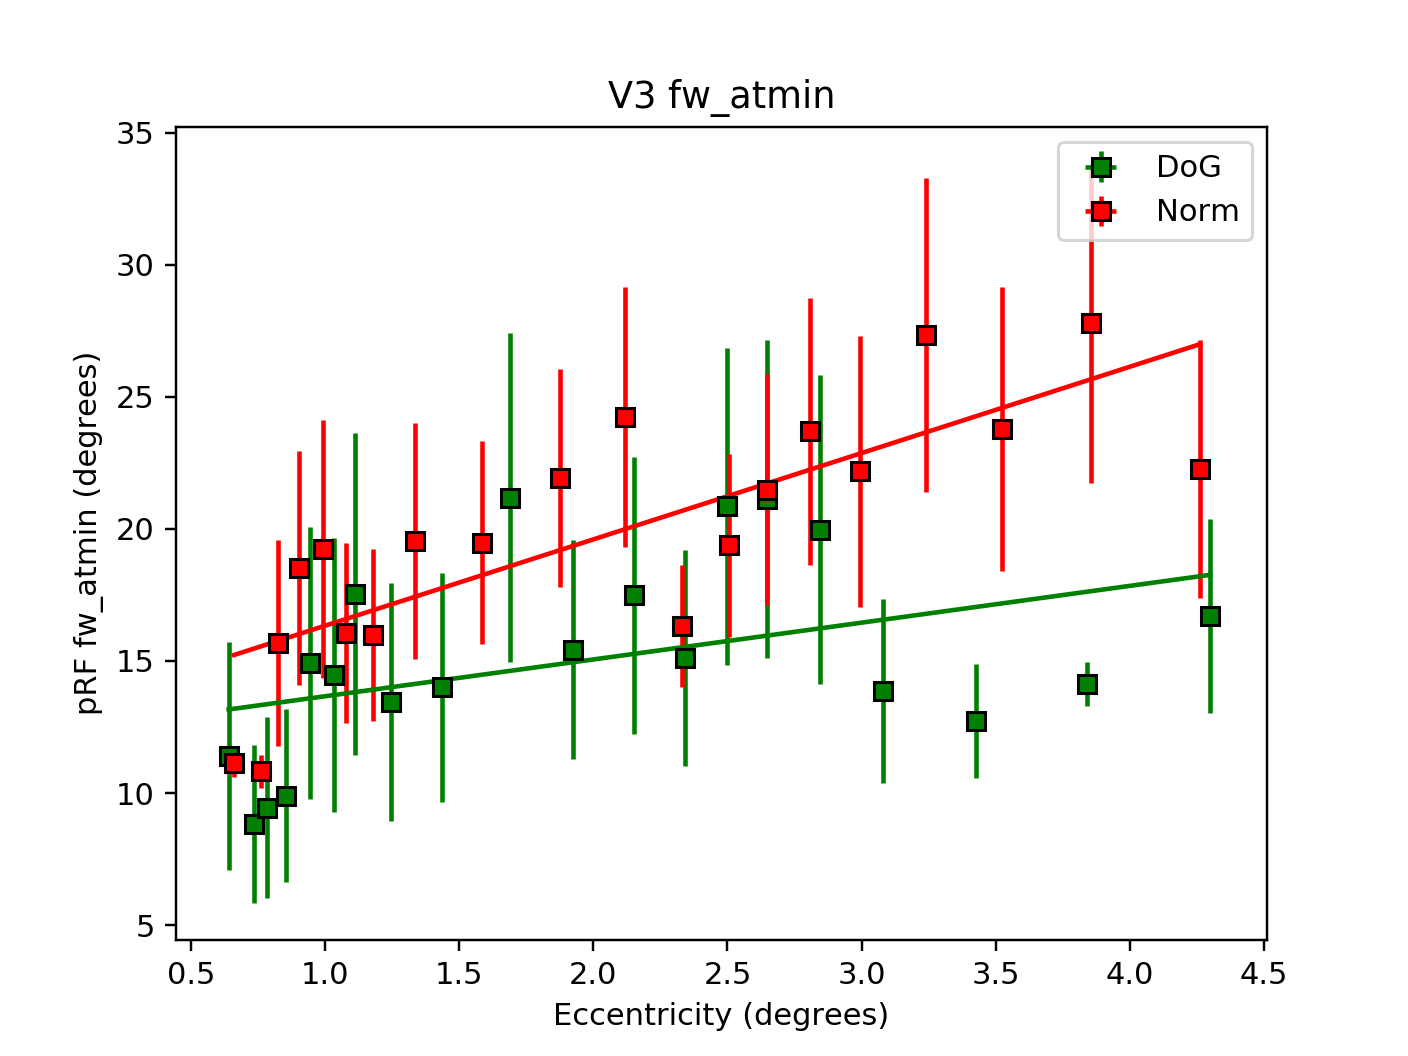

V3 DoG 0.0051759320071148585
V3 Norm 0.02542153240689371


In [46]:
# binned eccentricity vs other parameters relationships

rsq_thresh = 0.3

colors = ['green','red']

fw_atmin_stats = {}
ecc_stats = {}

for roi in ['V1', 'V2', 'V3']:#idx_rois:
    
    pl.figure(roi+" fw_atmin")
    pl.title(roi+" fw_atmin")
    
    fw_atmin_stats[roi] = {}
    ecc_stats[roi] = {}
    
    #same alpha for all
    #alpha_roi = roi_mask(idx_rois[roi],alpha)>rsq_thresh
    #ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
    #split_ecc_bins = np.array_split(ecc_sorted, 20, axis=0)    
    
    for i, model in enumerate(['DoG','Norm']):
        fw_atmin_stats[roi][model]=[]
        ecc_stats[roi][model]=[]
        
        #model-specific alpha
        alpha_roi = roi_mask(idx_rois[roi],alpha_dict[model])>rsq_thresh      
        ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
        split_ecc_bins = np.array_split(ecc_sorted, 20, axis=0)
    
        for ecc_quantile in split_ecc_bins:
            fw_atmin_stats[roi][model].append(weightstats.DescrStatsW(fw_atmin[alpha_roi,i][ecc_quantile[:,i]],
                                                                  weights=rsq[alpha_roi,i][ecc_quantile[:,i]]))

            ecc_stats[roi][model].append(weightstats.DescrStatsW(ecc[alpha_roi,i][ecc_quantile[:,i]],
                                                                  weights=rsq[alpha_roi,i][ecc_quantile[:,i]]))
            


        WLS = LinearRegression()
        WLS.fit(ecc[alpha_roi,i].reshape(-1, 1), fw_atmin[alpha_roi,i], sample_weight=rsq[alpha_roi,i])
        pl.plot([ss.mean for ss in ecc_stats[roi][model]],
                WLS.predict(np.array([ss.mean for ss in ecc_stats[roi][model]]).reshape(-1, 1)),
               color=colors[i])
        
        print(roi+" "+model+" "+str(WLS.score(ecc[alpha_roi,i].reshape(-1, 1), fw_atmin[alpha_roi,i], sample_weight=rsq[alpha_roi,i])))
        
        plot = pl.errorbar([ss.mean for ss in ecc_stats[roi][model]],
           [ss.mean for ss in fw_atmin_stats[roi][model]],
           yerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in fw_atmin_stats[roi][model]]).T,
           xerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in ecc_stats[roi][model]]).T,
           fmt='s', mfc=colors[i], mec='black', label=model, ecolor=colors[i])
        
        pl.xlabel('Eccentricity (degrees)')
        pl.ylabel('pRF fw_atmin (degrees)')
    
    pl.legend(loc=0)
    


<IPython.core.display.Javascript object>


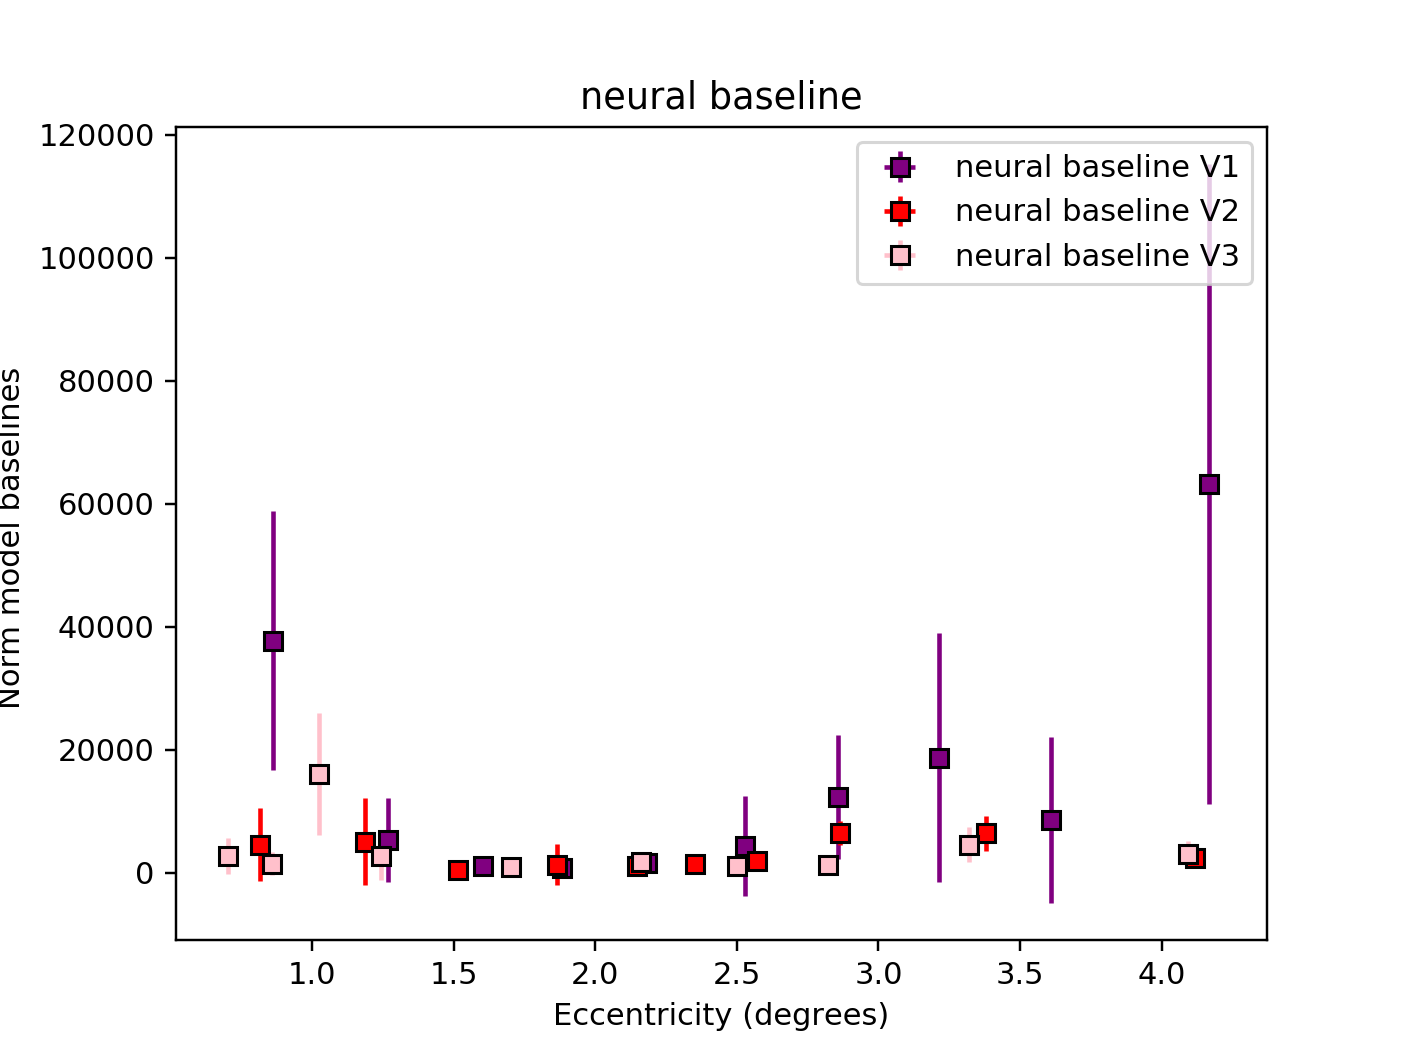

<IPython.core.display.Javascript object>


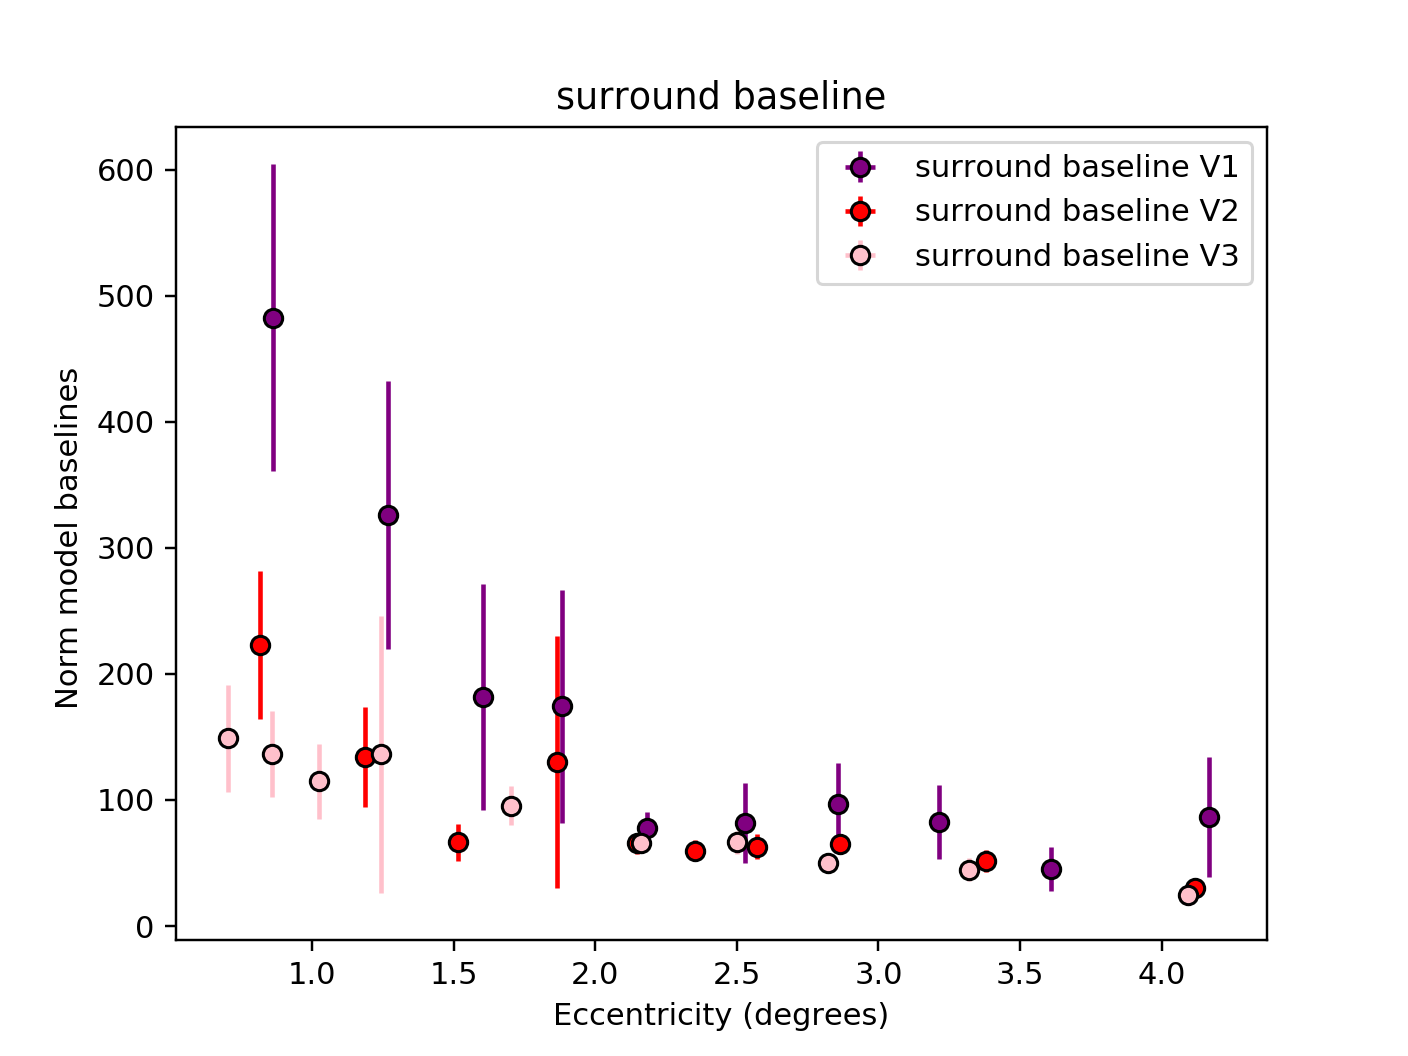

<IPython.core.display.Javascript object>


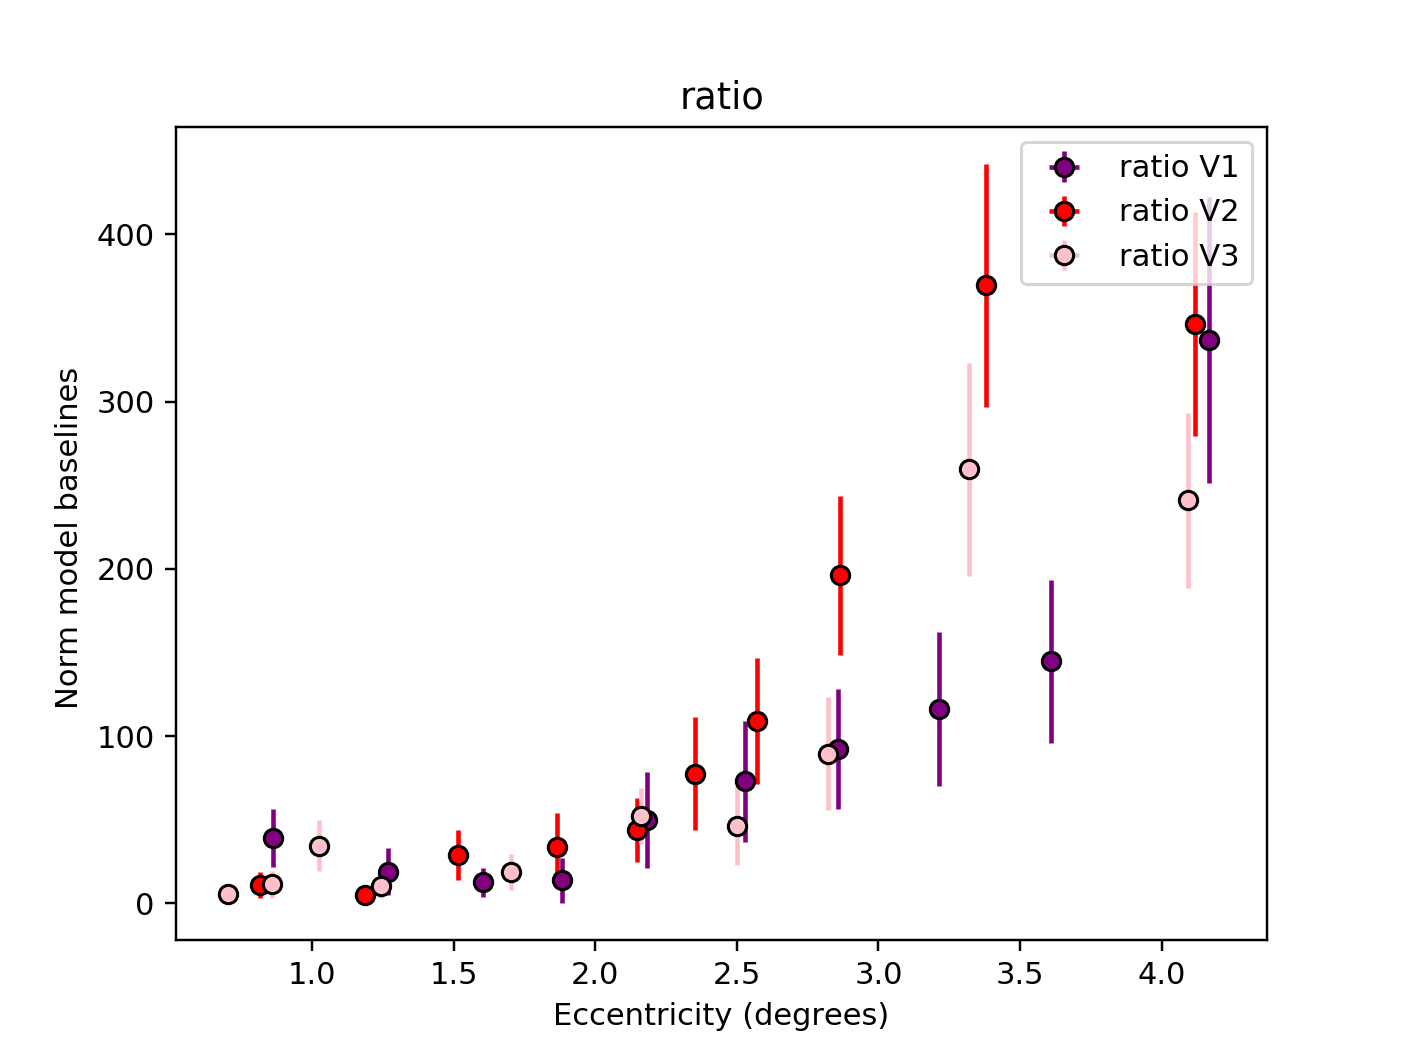

<IPython.core.display.Javascript object>


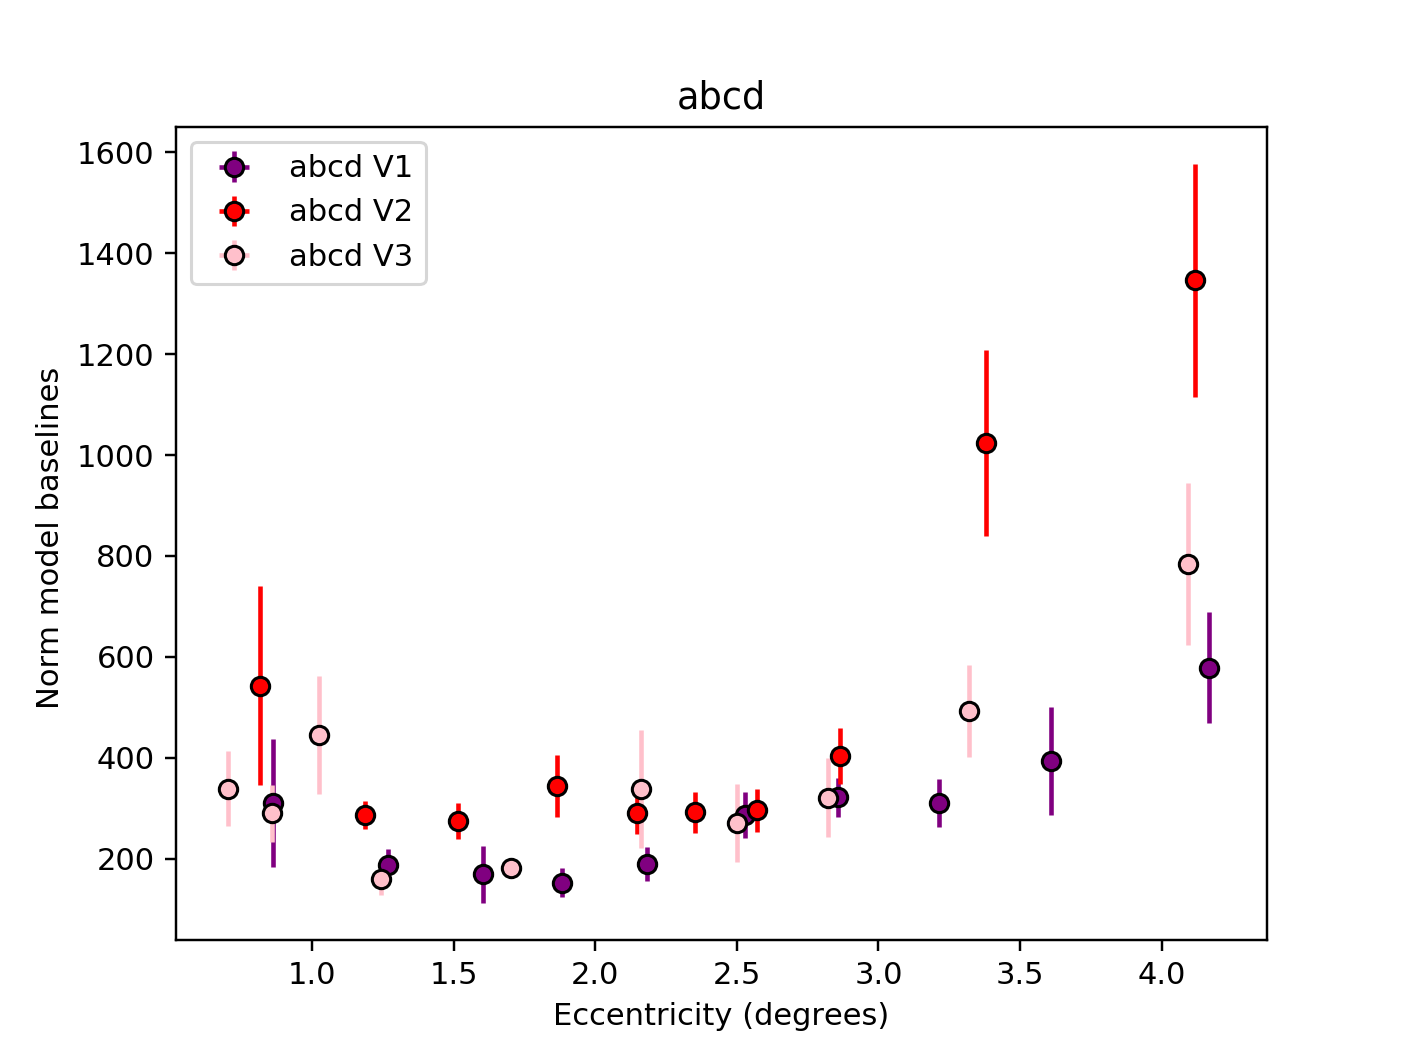

In [44]:
# binned eccentricity vs other parameters relationships
rsq_thresh = 0.3


colors = {}
colors['V1']= 'purple'
colors['V2']= 'red'
colors['V3']= 'pink'

symbol = {}
symbol['neural baseline'] = 's'
symbol['surround baseline'] = 'o'
symbol['ratio'] = 'o'
symbol['abcd'] = 'o'


baselines_stats = {}
ecc_stats = {}

for roi in ['V1', 'V2', 'V3']:#idx_rois:
        
    #pl.title(roi)
    
    baselines_stats[roi] = {}
    ecc_stats[roi] = {}
    
    alpha_roi = roi_mask(idx_rois[roi],alpha_norm)>rsq_thresh
    if alpha_roi.sum()>40:    
    
        ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
        split_ecc_bins = np.array_split(ecc_sorted, 10, axis=0)

        #note: here i indexes different params of same model (above it is same param in different models)
        #therefore ecc_stats is the same for all params
        for i, param in enumerate(['neural baseline', 'surround baseline', 'ratio', 'abcd']):
            pl.figure(param)
            pl.title(param)
            
            baselines_stats[roi][param]=[]
            ecc_stats[roi][param]=[]

            for ecc_quantile in split_ecc_bins:
                baselines_stats[roi][param].append(weightstats.DescrStatsW(baselines[alpha_roi,i][ecc_quantile[:,3]],
                                                                      weights=rsq[alpha_roi,3][ecc_quantile[:,3]]))

                ecc_stats[roi][param].append(weightstats.DescrStatsW(ecc[alpha_roi,3][ecc_quantile[:,3]],
                                                                      weights=rsq[alpha_roi,3][ecc_quantile[:,3]]))




            plot = pl.errorbar([ss.mean for ss in ecc_stats[roi][param]],
               [ss.mean for ss in baselines_stats[roi][param]],
               yerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in baselines_stats[roi][param]]).T,
               xerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in ecc_stats[roi][param]]).T,
               fmt=symbol[param], mfc=colors[roi], mec='black', label=param+" "+roi, ecolor=colors[roi])
            #pl.yscale('log')
            pl.legend(loc=0)
            pl.xlabel('Eccentricity (degrees)')
            pl.ylabel('Norm model baselines ')
    else:
        print(roi+" has no vertices/voxels above specified rsq threshold")
    
    
    

<IPython.core.display.Javascript object>


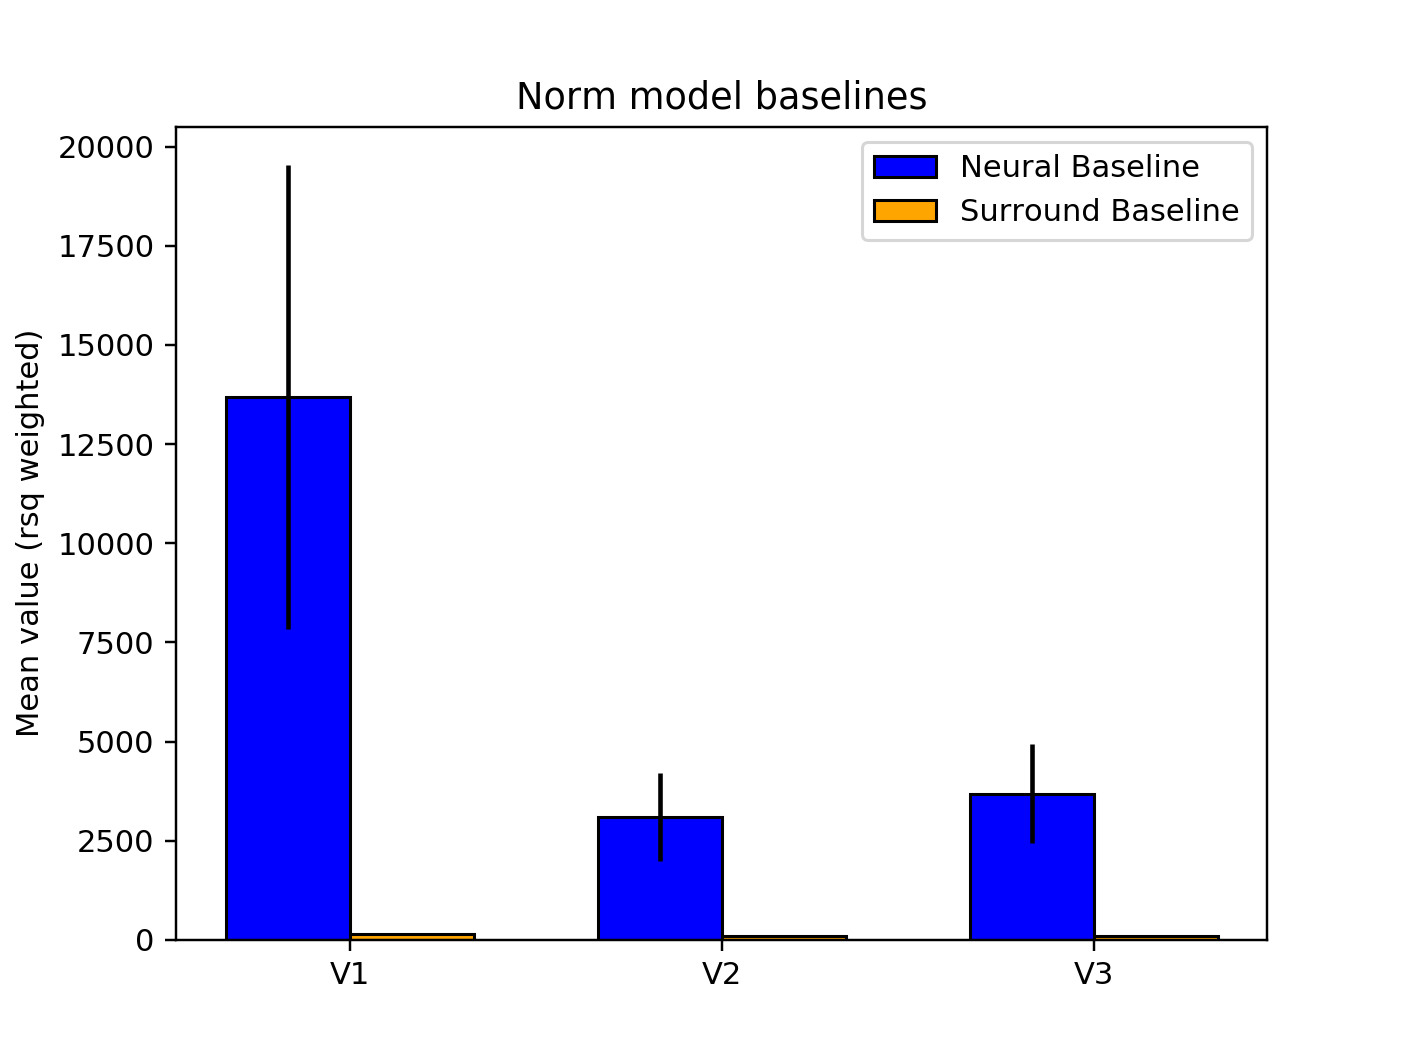

In [101]:
#plotting baseline average values per roi

pl.figure()
pl.title("Norm model baselines")
pl.ylabel("Mean value (rsq weighted)")

bar_positions = np.array([0,0.1])
x_ticks = []
x_labels = []

for roi in ['V1', 'V2', 'V3']:
    alpha_roi = roi_mask(idx_rois[roi],alpha)>rsq_thresh
    if alpha_roi.sum()>40:
        height_1 = weightstats.DescrStatsW(baselines[alpha_roi,0],
                                                    weights=rsq[alpha_roi,3])
        height_2 = weightstats.DescrStatsW(baselines[alpha_roi,1],
                                                    weights=rsq[alpha_roi,3])
        
        p1=pl.bar(bar_positions, height=[height_1.mean, height_2.mean], width=0.1,
                  yerr=np.array([np.abs(height_1.zconfint_mean(alpha=0.05)-height_1.mean),
                       np.abs(height_2.zconfint_mean(alpha=0.05)-height_2.mean)]).T, color=
                  ['blue','orange'],edgecolor='black')
        x_ticks.append(bar_positions.mean())
        x_labels.append(roi)
        bar_positions+=0.3
    else:
        print(roi+" has no vertices/voxels above specified rsq threshold")
            
pl.xticks(x_ticks, x_labels)


pl.legend((p1[0],p1[1]),('Neural Baseline','Surround Baseline'),loc=0)


<IPython.core.display.Javascript object>


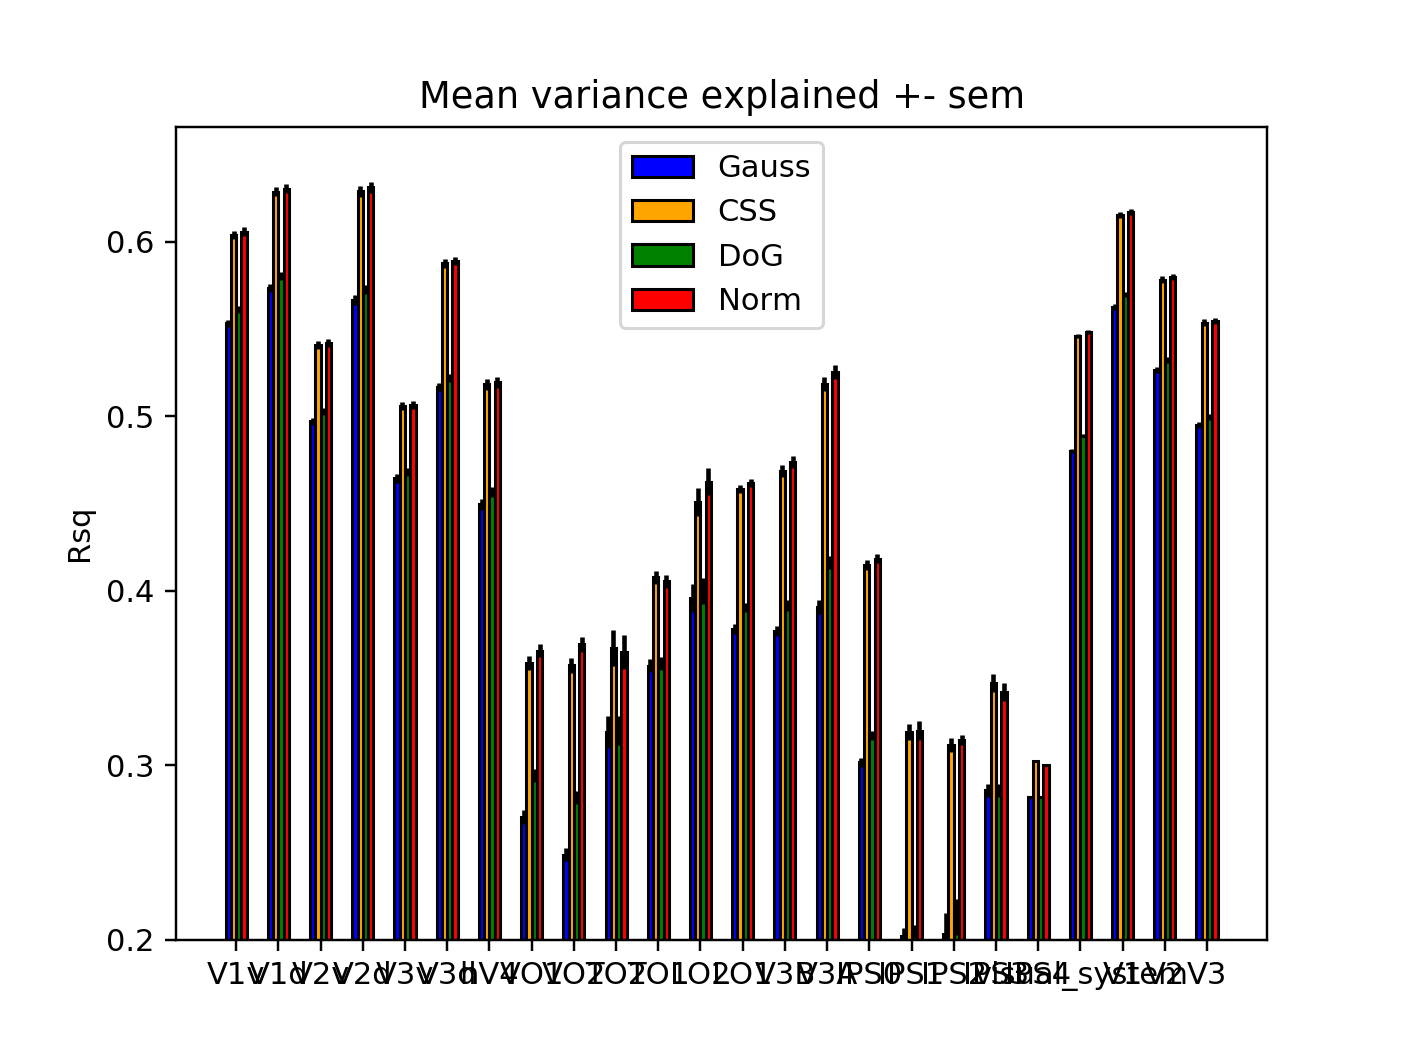

PHC1 has no vertices/voxels above specified rsq threshold
PHC2 has no vertices/voxels above specified rsq threshold
IPS5 has no vertices/voxels above specified rsq threshold
SPL1 has no vertices/voxels above specified rsq threshold
FEF has no vertices/voxels above specified rsq threshold


/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/numpy/core/_methods.py:130: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [27]:
#plotting rsq per roi

pl.figure()
pl.title("Mean variance explained +- sem")
pl.ylabel("Rsq")

bar_positions = np.array([0,0.1,0.2,0.3])
x_ticks = []
x_labels = []

for roi in idx_rois:
    alpha_roi = roi_mask(idx_rois[roi],alpha)>rsq_thresh
    if alpha_roi.sum()>1:        
        p1=pl.bar(bar_positions, height=np.mean(rsq[alpha_roi],axis=0), width=0.1,
                  yerr=sem(rsq[alpha_roi],axis=0), color=
                  ['blue','orange','green','red'],edgecolor='black')
        x_ticks.append(bar_positions.mean())
        x_labels.append(roi)
        bar_positions+=0.8
    else:
        print(roi+" has no vertices/voxels above specified rsq threshold")
            
pl.xticks(x_ticks, x_labels)

pl.ylim(bottom=0.2)
pl.legend((p1[0],p1[1],p1[2],p1[3]),('Gauss','CSS','DoG','Norm'),loc=0)


In [913]:

for roi in idx_rois:
    print(roi)
    try:
        print(ks_2samp(rsq[roi_mask(idx_rois[roi],alpha)>rsq_thresh,1],rsq[roi_mask(idx_rois[roi],alpha)>rsq_thresh,3]))
    except:
        print(roi+" has no vertices/voxels above specified rsq threshold")


V1v
Ks_2sampResult(statistic=0.009988901220865709, pvalue=0.9992309644165229)
V1d
Ks_2sampResult(statistic=0.008996851102114234, pvalue=0.999989791800348)
V2v
Ks_2sampResult(statistic=0.008665511265164655, pvalue=0.9999938307903815)
V2d
Ks_2sampResult(statistic=0.012738853503184766, pvalue=0.9995261694418252)
V3v
Ks_2sampResult(statistic=0.01167582417582419, pvalue=0.999964569583189)
V3d
Ks_2sampResult(statistic=0.007411067193675902, pvalue=0.9999999971167877)
hV4
Ks_2sampResult(statistic=0.010889292196007316, pvalue=0.9999999249949583)
VO1
Ks_2sampResult(statistic=0.15141955835962148, pvalue=0.0012012481825599156)
VO2
Ks_2sampResult(statistic=0.16901408450704225, pvalue=0.23880815871338087)
PHC1
PHC1 has no vertices/voxels above specified rsq threshold
PHC2
PHC2 has no vertices/voxels above specified rsq threshold
TO2
Ks_2sampResult(statistic=0.28571428571428575, pvalue=0.5407399624437565)
TO1
Ks_2sampResult(statistic=0.09090909090909094, pvalue=0.7336458901692724)
LO2
Ks_2sampResult(

In [ ]:
#the following cells are in case we want to quickly look at some specific model/data timecourse

In [205]:
analysis_settings = '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/analysis_settings_cartesius.yml'

local_files = '/Users/marcoaqil/prfpy_norm/analysis_settings.yml'

with open(analysis_settings) as f:
    analysis_info = yaml.safe_load(f)

with open(local_files) as f:
    analysis_info_local = yaml.safe_load(f)
# note that screenshot paths and task names should be in the same order
n_pix = analysis_info["n_pix"]
discard_volumes = analysis_info["discard_volumes"]
screenshot_paths = analysis_info_local["screenshot_paths"]
screen_size_cm = analysis_info["screen_size_cm"]
screen_distance_cm = analysis_info["screen_distance_cm"]
TR = analysis_info["TR"]
task_names = analysis_info["task_names"]
data_path = analysis_info["data_path"]
fitting_space = analysis_info["fitting_space"]
window_length = analysis_info["window_length"]
n_jobs = analysis_info["n_jobs"]
hrf = analysis_info["hrf"]
gradient_method = analysis_info["gradient_method"]
verbose = analysis_info["verbose"]
rsq_threshold = analysis_info["rsq_threshold"]
n_batches = analysis_info["n_batches"]
fit_hrf = analysis_info["fit_hrf"]

#new params to be added to analysis settings
dm_edges_clipping = analysis_info["dm_edges_clipping"]
baseline_volumes_begin_end = analysis_info["baseline_volumes_begin_end"]
min_percent_var = analysis_info["min_percent_var"]

In [206]:
#create stim
task_lengths, prf_stim, late_iso_dict = create_full_stim(screenshot_paths,
                n_pix,
                discard_volumes,
                baseline_volumes_begin_end,                                         
                dm_edges_clipping,
                screen_size_cm,
                screen_distance_cm,
                TR,
                task_names)

Design matrix completed
Design matrix completed
Design matrix completed
Design matrix completed
Design matrix completed


In [649]:
#initialize models 
gg = Iso2DGaussianGridder(stimulus=prf_stim,
                          hrf=hrf,
                          filter_predictions=True,
                          window_length=window_length,
                          task_lengths=task_lengths)

gg_css = CSS_Iso2DGaussianGridder(stimulus=prf_stim,
                          hrf=hrf,
                          filter_predictions=True,
                          window_length=window_length,
                                  task_lengths=task_lengths)

gg_norm = Norm_Iso2DGaussianGridder(stimulus=prf_stim,
                                    hrf=hrf,
                                    filter_predictions=True,
                                    window_length=window_length,
                                    task_lengths=task_lengths)

gg_dog = DoG_Iso2DGaussianGridder(stimulus=prf_stim,
                                  hrf=hrf,
                                  filter_predictions=True,
                                  window_length=window_length,
                                  task_lengths=task_lengths)

In [652]:
print(norm_tc[late_iso_dict['1R']].mean())
print(norm_tc[task_lengths[0]+late_iso_dict['1S']].mean())
print(norm_tc[np.sum(task_lengths[:2])+late_iso_dict['2R']].mean())
print(norm_tc[np.sum(task_lengths[:3])+late_iso_dict['4F']].mean())
print(norm_tc[np.sum(task_lengths[:4])+late_iso_dict['4R']].mean())

81296.62650324668
81484.42830762974
81318.6845042052
81333.0287499793
81383.69182436485


In [ ]:
%matplotlib notebook
#create timecourses
vox_num=np.argmax((rsq[:,2]-rsq[:,3])*(alpha>rsq_thresh))#50370



vox_num = np.sum(nonzerovar_mask[:vox_num])
tc_vox=timecourse[vox_num] 




#norm_grid_tc=gg_norm.return_single_prediction(*list(norm_grid[vox_num,:-1]))
norm_tc=gg_norm.return_single_prediction(*list(norm_res[vox_num,:-1])) #/tc_vox.mean(-1) +99
gauss_tc=gg.return_single_prediction(*list(gauss[vox_num,:-1])) #/tc_vox.mean(-1) +99
css_tc=gg_css.return_single_prediction(*list(css_res[vox_num,:-1])) #/tc_vox.mean(-1) +99
dog_tc=gg_dog.return_single_prediction(*list(dog_res[vox_num,:-1])) #/tc_vox.mean(-1) +99
norm_updated=gg_norm.return_single_prediction(*list(gf_norm.iterative_search_params[0])) #/tc_vox.mean(-1) +99
#css_updated=gg_css.return_single_prediction(*list(gf_css.iterative_search_params[0]))


#tc_vox/=tc_vox.mean(-1)
#tc_vox+=99

fig=pl.figure()
pl.plot(tc_vox, label='data')
pl.plot(norm_tc, label='norm')
pl.plot(css_tc,label='css')
pl.plot(dog_tc,label='dog')
pl.plot(gauss_tc,label='gauss')
pl.plot(norm_updated,label='new norm')
#pl.plot(css_updated,label='new css')
pl.legend()

print("gauss rsq: "+str(1-np.sum((tc_vox-gauss_tc)**2)/(timecourse.shape[-1]*np.var(tc_vox))))
print("css rsq: "+str(1-np.sum((tc_vox-css_tc)**2)/(timecourse.shape[-1]*np.var(tc_vox))))
print("dog rsq: "+str(1-np.sum((tc_vox-dog_tc)**2)/(timecourse.shape[-1]*np.var(tc_vox))))
print("norm rsq: "+str(1-np.sum((tc_vox-norm_tc)**2)/(timecourse.shape[-1]*np.var(tc_vox))))
print("new norm rsq: "+str(1-np.sum((tc_vox-norm_updated)**2)/(timecourse.shape[-1]*np.var(tc_vox))))

print("new css rsq: "+str(1-np.sum((tc_vox-css_updated)**2)/(timecourse.shape[-1]*np.var(tc_vox))))


print("gauss params")
print(gauss[vox_num])
print("css params")
print(css_res[vox_num])
print("dog params")
print(dog_res[vox_num])
print("norm params")
print(norm_res[vox_num])
print("new norm params")
print(gf_norm.iterative_search_params[0])

#norm_res[vox_num] = gf_norm.iterative_search_params[0]

In [653]:
print(tc_vox[late_iso_dict['1R']].mean())
print(tc_vox[task_lengths[0]+late_iso_dict['1S']].mean())
print(tc_vox[np.sum(task_lengths[:2])+late_iso_dict['2R']].mean())
print(tc_vox[np.sum(task_lengths[:3])+late_iso_dict['4F']].mean())
print(tc_vox[np.sum(task_lengths[:4])+late_iso_dict['4R']].mean())

80890.47
80890.46
80890.45
80890.45
80890.45


In [958]:
from scipy.optimize import LinearConstraint, NonlinearConstraint

inf = np.inf
eps = 1e-1
ss = prf_stim.screen_size_degrees

gf_norm = Norm_Iso2DGaussianFitter(data=tc_vox.reshape(-1,tc_vox.shape[-1]),
                                       gridder=gg_norm,
                                       n_jobs=1)
gf_css = CSS_Iso2DGaussianFitter(data=tc_vox.reshape(-1,tc_vox.shape[-1]),
                                       gridder=gg_css,
                                       n_jobs=1)



A_ssc_norm = np.array([[0,0,-1,0,0,0,1,0,0],[0,0,0,0,0,1,0,0,0]])

def tall_center_constraint(x):
    return (x[3]+x[7])/(x[5]+x[8]) - x[7]/x[8]

constraints_norm = [LinearConstraint(A_ssc_norm,
                                                lb=[0,1],
                                                ub=[+inf,1]),
                        NonlinearConstraint(tall_center_constraint,
                                            lb=0,
                                            ub=+inf)]

In [961]:
gf_norm.iterative_fit(rsq_threshold=0, verbose=2,
                              starting_params=gf_norm.iterative_search_params,#norm_grid[vox_num].reshape(-1,norm_grid[vox_num].shape[-1]),
                                      bounds=[(-2*ss, 2*ss),  # x
                                               (-2*ss, 2*ss),  # y
                                               (eps, 2*ss),  # prf size
                                               (0, +inf),  # prf amplitude
                                               (0, +inf),  # bold baseline
                                               (0, +inf),  # surround amplitude
                                               (2*eps, 4*ss),  # surround size
                                               (0, +inf),  # neural baseline
                                               (1e-6, +inf)],  # surround baseline
                                       gradient_method='no',
                                       fit_hrf=False,
                                         constraints=constraints_norm)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Using no-gradient minimization


/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained

/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


`xtol` termination condition is satisfied.
Number of iterations: 379, function evaluations: 4360, CG iterations: 1840, optimality: 2.84e+03, constraint violation: 0.00e+00, execution time: 4e+01 s.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.2s finished


In [123]:
gf_css.iterative_fit(rsq_threshold=0, verbose=True,
                              starting_params=css_res[vox_num].reshape(-1,css_res[vox_num].shape[-1]),
                             bounds=[(-2*ss, 2*ss),  # x
                                     (-2*ss, 2*ss),  # y
                                     (eps, 2*ss),  # prf size
                                     (-inf, +inf),  # prf amplitude
                                     (0, +inf),  # bold baseline
                                     (0.001, 3)],  # CSS exponent
                                       gradient_method='numerical',
                                       fit_hrf=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Using numerical gradient


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s finished


In [962]:
np.set_printoptions(suppress=True)
#gf_norm.iterative_search_params[0,-2]=1
#gf_norm.iterative_search_params[0,-3]=1000
#gf_norm.iterative_search_params[0,3]=6000
#gf_norm.iterative_search_params[0,4]=80000
print(gf_norm.iterative_search_params[0])
print(norm_res[vox_num])
#print(gf_norm.iterative_search_params[0] - norm_res[vox_num])
print(norm_grid[vox_num])

[   -0.20938654    -0.92204793     0.19884804  2577.38979612
 53866.27130807     1.             0.2            0.
     0.000001       0.52069497]
[   -0.23354912    -0.87887172     0.93521313   814.56112622
 53768.47265625     0.4121263      3.01334447     0.00382687
    10.00012842     0.02305505]
[   -0.20962779    -0.85747595     1.12533616   814.56115723
 53768.47265625     0.05           3.             0.
    10.             0.56944734]


In [124]:
np.set_printoptions(suppress=True)
print(gf_css.iterative_search_params[0])

[   -1.06535238    -3.10326027     0.2137977   1553.37869903
 80585.98293379     0.00161563     0.33977976]


In [37]:
anp = norm_res[:10,:-1]#gf_norm.iterative_search_params[0]
agp = gauss[:10,:-1]
acp = css_res[:10,:-1]#gf_css.iterative_search_params[0]
adp = dog_res[:10,:-1]


x=np.linspace(-20,20,1000)
gauss_profile = agp[...,3] * np.exp(-0.5*x[...,np.newaxis]**2 / agp[...,2]**2)

half_max = np.max(gauss_profile, axis=0)/2

css_profile = (acp[3] * (np.exp(-0.5*x**2 / acp[2]**2))**acp[5])
dog_profile = adp[3] * np.exp(-0.5*x**2 / adp[2]**2) - adp[5] * np.exp(-0.5*x**2 / adp[6]**2)
norm_profile = (anp[3] * np.exp(-0.5*x**2 / anp[2]**2) + anp[7]) / (anp[5] * np.exp(-0.5*x**2 / anp[6]**2) + anp[8])
pl.figure()
pl.plot(x,norm_profile,label='norm')
pl.plot(x,css_profile,label='css')
pl.plot(x,dog_profile,label='dog')
pl.plot(x,gauss_profile,label='gauss')
pl.legend()

ValueError: operands could not be broadcast together with shapes (1000,) (6,) 

In [42]:
print(half_max.shape)
x[np.argmin(np.abs(half_max-gauss_profile), axis=0)]

(10,)


array([-0.42042042, -0.5005005 , -0.54054054, -0.54054054, -0.54054054,
       -0.38038038, -0.54054054, -0.62062062, -0.38038038, -0.66066066])

In [43]:
agp

array([[2.39757873e+00, 2.60430189e-01, 3.50643828e-01, 1.13346322e+02,
        6.86608990e+04],
       [2.54802888e+00, 3.85879235e-01, 4.30552282e-01, 9.51115676e+01,
        6.96927229e+04],
       [2.58749607e+00, 4.17583105e-01, 4.51059228e-01, 9.68074753e+01,
        7.06364901e+04],
       [2.73111188e+00, 4.66150961e-01, 4.50371759e-01, 1.15703847e+02,
        6.45847187e+04],
       [2.61016573e+00, 6.21102360e-01, 4.65716762e-01, 8.71259269e+01,
        5.91878856e+04],
       [2.37924514e+00, 2.76602634e-01, 3.17047987e-01, 1.27025499e+02,
        6.82756637e+04],
       [2.47908634e+00, 3.93369349e-01, 4.68963855e-01, 6.84625191e+01,
        6.70114840e+04],
       [2.41922278e+00, 4.57514285e-01, 5.26847349e-01, 4.73289070e+01,
        6.53476156e+04],
       [2.41741948e+00, 4.29122585e-01, 3.24784667e-01, 1.23262778e+02,
        6.46082178e+04],
       [2.59173473e+00, 6.57237544e-01, 5.50875479e-01, 6.17278592e+01,
        6.71865053e+04]])

(10,)


<IPython.core.display.Javascript object>


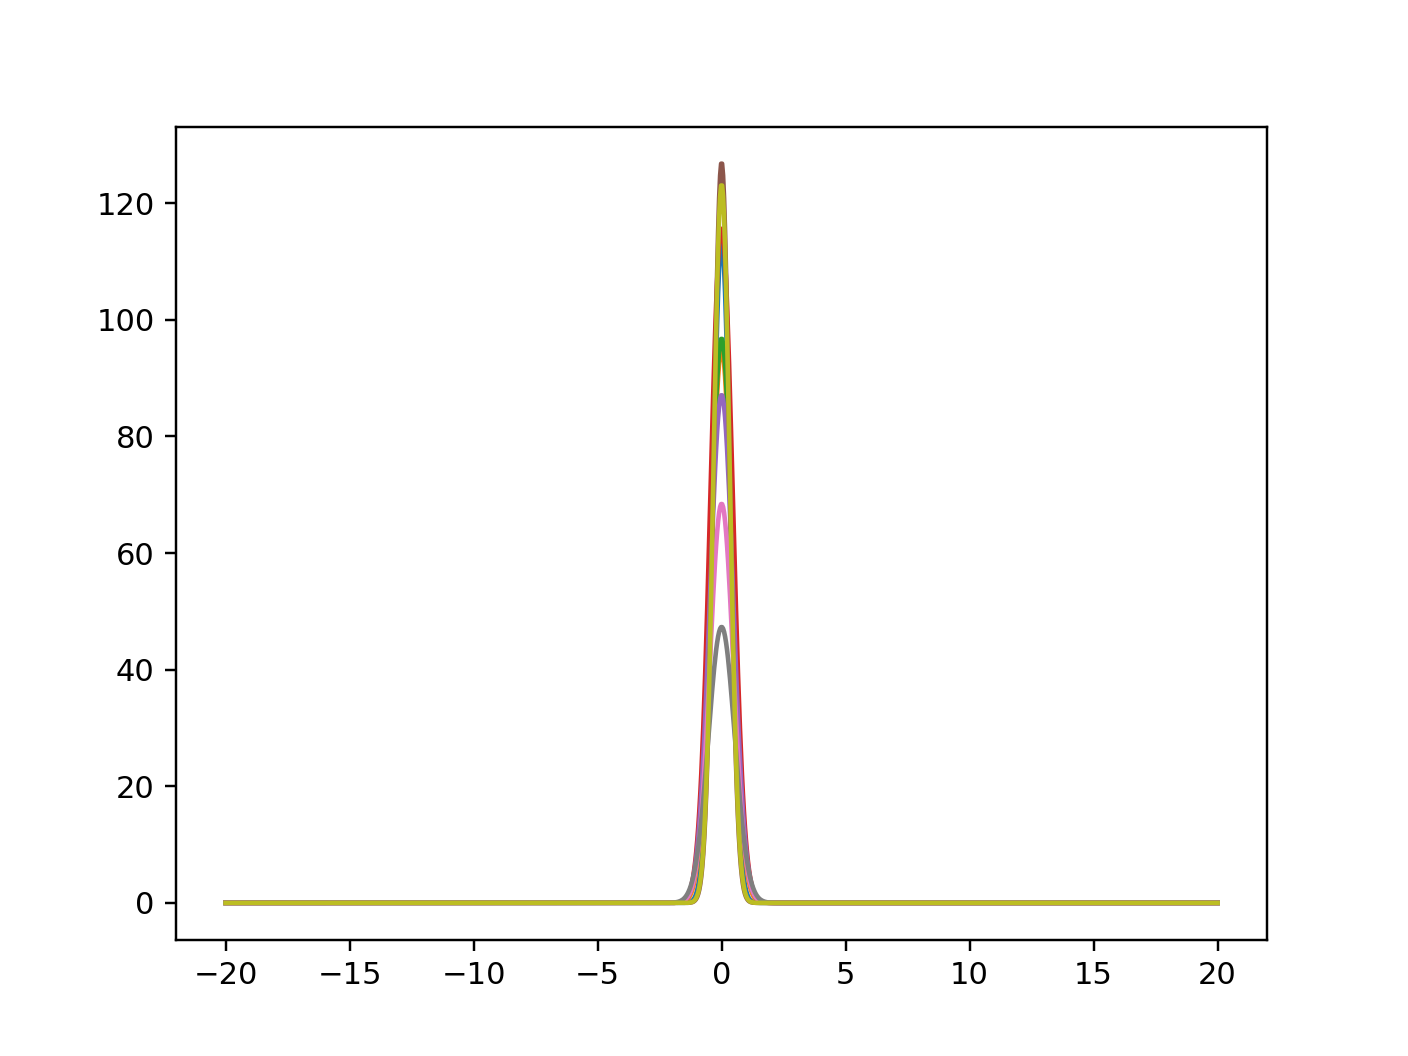

In [38]:
pl.figure()
for i in range(9):
    pl.plot(x,gauss_profile[:,i],label='gauss')

In [ ]:
###outdated cells

In [96]:
#correcting for low intensity TCs (lowest xx percentile per ROI) (unused)
tc_mean_full = np.zeros(nonzerovar_mask.shape)
tc_mean = timecourse.mean(-1)
tc_mean_full[nonzerovar_mask]=tc_mean

for roi in idx_rois:
    k_values = int(len(idx_rois[roi])/20)
    lowest_intensity = np.argpartition(tc_mean_full[idx_rois[roi]][tc_mean_full[idx_rois[roi]]>0], k_values)
    alpha[idx_rois[roi][tc_mean_full[idx_rois[roi]]>0][lowest_intensity[:k_values]]] = 0
    
    tc_mean_full[idx_rois[roi][tc_mean_full[idx_rois[roi]]>0][lowest_intensity[:k_values]]] = 0

#plotting histograms of mean signal intensity per ROI, after removing lowest intensity
for roi in idx_rois:
    pl.figure()
    pl.title(roi)
    pl.hist(tc_mean_full[idx_rois[roi]],bins=100)
    pl.show()
    #pl.close()

In [2]:
#load data fsaverage sub 001

gauss = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-gauss_space-fsaverage.npy")
norm_grid = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_gridparams-norm_space-fsaverage.npy") 
norm_an = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-norm_space-fsaverage_analytic.npy")
#norm_num = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-norm_space-fsaverage_numerical.npy")
dog_res= np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-dog_space-fsaverage.npy")
css_res= np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-css_space-fsaverage.npy")
norm_unbound = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-norm_space-fsaverage_unbounded.npy")
norm_combined=np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_norm-iterparams-combined_space-fsaverage.npy")
norm_powell=np.load("/Users/marcoaqil/PRFMapping/Cartesius results sub-001/sub-001_iterparams-norm_space-fsaverage_powell.npy")
norm_num_fix = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-norm_space-fsaverage_num_bounds_fixed.npy")

nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/sub-001_nonzerovar-mask_space-fsaverage.npy")

norm_res = norm_num_fix

#load data fsnative sub 001
gauss = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-gauss_space-fsnative.npy")
css_res= np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-css_space-fsnative.npy")
dog_res= np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-dog_space-fsnative.npy")
norm_res = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-norm_space-fsnative.npy")
nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_nonzerovar-mask_space-fsnative.npy")
timecourse = np.load('/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_timecourse_space-fsnative.npy')

#load data fsnative sub 006 (old)
gauss = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-gauss_space-fsnative.npy")
css_res= np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-css_space-fsnative.npy")
dog_res= np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-dog_space-fsnative.npy")
norm_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-norm_space-fsnative.npy")
norm_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_gridparams-norm_space-fsnative.npy")
gauss_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_gridparams-gauss_space-fsnative.npy")

nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_nonlow-var-mask_space-fsnative.npy")

timecourse = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_timecourse_space-fsnative.npy')

#load data fsnative20191107120858 sub 006 SMALLER BOUNDS iterated fit (old)
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_iterparams-gauss_space-fsnative20191107120858.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_iterparams-css_space-fsnative20191107120858.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_iterparams-dog_space-fsnative20191107120858.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_iterparams-norm_space-fsnative20191107120858.npy")

nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_nonlow-var-mask_space-fsnative.npy")

timecourse = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_timecourse_space-fsnative.npy')

#load data fsnative sub 006 iterated with trust-constr minimizer (old)
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-gauss_space-fsnative20191106094038.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-css_space-fsnative20191106094038.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-dog_space-fsnative20191106094038.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-norm_space-fsnative20191106094038.npy")

#nonzerovar_mask_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_nonlow-var-mask_space-fsnative.npy")

#timecourse_it = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_timecourse_space-fsnative.npy')

#load data fsnative sub 006 first surr constraints tc first (old)
gauss = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-gauss_space-fsnative.npy")
css_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-css_space-fsnative.npy")
dog_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-dog_space-fsnative.npy")
norm_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-norm_space-fsnative.npy")

#load data fsnative sub 006 first surr constraints tc first iterated (old)
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-gauss_space-fsnative20191108021600.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-css_space-fsnative20191108021600.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-dog_space-fsnative20191108021600.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-norm_space-fsnative20191108021600.npy")

#load data fsnative sub 007 (old)
gauss = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_iterparams-gauss_space-fsnative.npy")
css_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_iterparams-css_space-fsnative.npy")
dog_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_iterparams-dog_space-fsnative.npy")
norm_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_iterparams-norm_space-fsnative.npy")
norm_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_gridparams-norm_space-fsnative.npy")
gauss_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_gridparams-gauss_space-fsnative.npy")

nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_nonlow-var-mask_space-fsnative.npy")
timecourse = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_timecourse_space-fsnative.npy')

In [901]:
#plot suppr idx on cortex (not very meaningful)
#suppression index (for norm also take into account baseline?)
suppr_idx = np.zeros((nonzerovar_mask.shape[0],2))
suppr_idx[nonzerovar_mask,0] = (dog_res[:,5] * dog_res[:,6]**2)/(dog_res[:,3] * dog_res[:,2]**2)
suppr_idx[nonzerovar_mask,1] = (norm_res[:,5] * norm_res[:,6]**2 + norm_res[:,7])/(norm_res[:,3] * norm_res[:,2]**2 + norm_res[:,8])

suppr_idx_dog = cortex.Vertex2D(np.log(suppr_idx[:,0]), alpha, subject=subj,
                                vmin=-25, vmax=10, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
suppr_idx_norm = cortex.Vertex2D(np.log(suppr_idx[:,1]), alpha, subject=subj,
                                 vmin=-12, vmax=2, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')

ds_suppr_idx = {'suppr_idx DoG':suppr_idx_dog.raw, 'suppr_idx Norm':suppr_idx_norm.raw}

cortex.webgl.show(ds_suppr_idx,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True, 
                 with_borders=True, 
                 with_colorbar=True)

/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


Started server on port 43369


<JS: window.viewer>

Stopping server
